(1351, 4) (289, 4) (290, 4)
cuda:0


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Parameter containing:
tensor([[ 0.1195, -0.0221, -0.2134],
        [ 0.0464, -0.2300,  0.2417],
        [-0.0973,  0.2060,  0.0816],
        [ 0.1669, -0.2175, -0.1458],
        [-0.0759, -0.1791,  0.1728],
        [-0.1404, -0.0113, -0.1338],
        [-0.1779, -0.0779, -0.0677],
        [ 0.0241,  0.0918, -0.1871],
        [-0.0350,  0.0912,  0.1286],
        [-0.0710, -0.1728,  0.0352],
        [-0.1548, -0.1557, -0.1297],
        [ 0.1863,  0.0296,  0.2128],
        [ 0.1944, -0.0219, -0.0747],
        [-0.2212, -0.2404,  0.1606],
        [-0.2402,  0.0699,  0.0589],
        [-0.1224,  0.1405, -0.0323],
        [ 0.1810, -0.1249, -0.1123],
        [ 0.0743, -0.1213, -0.0577],
        [-0.1219,  0.0486, -0.2442],
        [ 0.1305, -0.0027, -0.0196],
        [ 0.1857,  0.2169, -0.1766],
        [ 0.2389,  0.1887,  0.2208],
        [-0.1629,  0.1566, -0.1808],
        [ 0.2468, -0.1091,  0.2436],
        [ 0.0075,  0.1451,  0.1683],
        [-0.2111, -0.0143,  0.0142],
        [-0.016

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1| Train Loss: 0.7999181


  3%|▎         | 1/30 [00:07<03:30,  7.26s/it]

Epoch: 1| Validation error: 0.8066349
Epoch: 2| Train Loss: 0.7234361


  7%|▋         | 2/30 [00:13<03:09,  6.78s/it]

Epoch: 2| Validation error: 0.6699184
Epoch: 3| Train Loss: 0.5984344


 10%|█         | 3/30 [00:20<03:02,  6.75s/it]

Epoch: 3| Validation error: 0.5974523
Epoch: 4| Train Loss: 0.5425442


 13%|█▎        | 4/30 [00:26<02:53,  6.66s/it]

Epoch: 4| Validation error: 0.5585562
Epoch: 5| Train Loss: 0.5189823


 17%|█▋        | 5/30 [00:33<02:43,  6.52s/it]

Epoch: 5| Validation error: 0.5290330
Epoch: 6| Train Loss: 0.5078770


 20%|██        | 6/30 [00:39<02:34,  6.43s/it]

Epoch: 6| Validation error: 0.5260381
Epoch: 7| Train Loss: 0.4997286


 23%|██▎       | 7/30 [00:45<02:28,  6.46s/it]

Epoch: 7| Validation error: 0.5145867
Epoch: 8| Train Loss: 0.4927783


 27%|██▋       | 8/30 [00:52<02:22,  6.50s/it]

Epoch: 8| Validation error: 0.5156107
Epoch: 9| Train Loss: 0.4855163


 30%|███       | 9/30 [00:59<02:16,  6.49s/it]

Epoch: 9| Validation error: 0.5022417
Epoch: 10| Train Loss: 0.4780353


 33%|███▎      | 10/30 [01:05<02:09,  6.48s/it]

Epoch: 10| Validation error: 0.5087743
Epoch: 11| Train Loss: 0.4749764


 37%|███▋      | 11/30 [01:11<02:02,  6.44s/it]

Epoch: 11| Validation error: 0.4935912
Epoch: 12| Train Loss: 0.4743852


 40%|████      | 12/30 [01:18<01:54,  6.38s/it]

Epoch: 12| Validation error: 0.5018146
Epoch: 13| Train Loss: 0.4653449


 43%|████▎     | 13/30 [01:24<01:49,  6.44s/it]

Epoch: 13| Validation error: 0.4792897
Epoch: 14| Train Loss: 0.4577355


 47%|████▋     | 14/30 [01:30<01:41,  6.36s/it]

Epoch: 14| Validation error: 0.4755041
Epoch: 15| Train Loss: 0.4505448


 50%|█████     | 15/30 [01:37<01:34,  6.31s/it]

Epoch: 15| Validation error: 0.4648688
Epoch: 16| Train Loss: 0.4438583


 53%|█████▎    | 16/30 [01:43<01:27,  6.28s/it]

Epoch: 16| Validation error: 0.4652588
Epoch: 17| Train Loss: 0.4403172


 57%|█████▋    | 17/30 [01:49<01:21,  6.30s/it]

Epoch: 17| Validation error: 0.4676323
Epoch: 18| Train Loss: 0.4323205


 60%|██████    | 18/30 [01:55<01:15,  6.32s/it]

Epoch: 18| Validation error: 0.4462184
Epoch: 19| Train Loss: 0.4344528


 63%|██████▎   | 19/30 [02:02<01:10,  6.36s/it]

Epoch: 19| Validation error: 0.4356868
Epoch: 20| Train Loss: 0.4127260


 67%|██████▋   | 20/30 [02:08<01:03,  6.32s/it]

Epoch: 20| Validation error: 0.4197316
Epoch: 21| Train Loss: 0.4085336


 70%|███████   | 21/30 [02:14<00:56,  6.33s/it]

Epoch: 21| Validation error: 0.4169459
Epoch: 22| Train Loss: 0.3976167


 73%|███████▎  | 22/30 [02:21<00:50,  6.30s/it]

Epoch: 22| Validation error: 0.4081787
Epoch: 23| Train Loss: 0.3894448


 77%|███████▋  | 23/30 [02:27<00:44,  6.35s/it]

Epoch: 23| Validation error: 0.3911979
Epoch: 24| Train Loss: 0.3744812


 80%|████████  | 24/30 [02:34<00:38,  6.34s/it]

Epoch: 24| Validation error: 0.3777846
Epoch: 25| Train Loss: 0.3657944


 83%|████████▎ | 25/30 [02:40<00:31,  6.34s/it]

Epoch: 25| Validation error: 0.3707246
Epoch: 26| Train Loss: 0.3600789


 87%|████████▋ | 26/30 [02:46<00:25,  6.32s/it]

Epoch: 26| Validation error: 0.3775366
Epoch: 27| Train Loss: 0.3456378


 90%|█████████ | 27/30 [02:52<00:19,  6.33s/it]

Epoch: 27| Validation error: 0.3484250
Epoch: 28| Train Loss: 0.3291247


 93%|█████████▎| 28/30 [02:59<00:12,  6.35s/it]

Epoch: 28| Validation error: 0.3326688
Epoch: 29| Train Loss: 0.3182905


 97%|█████████▋| 29/30 [03:05<00:06,  6.33s/it]

Epoch: 29| Validation error: 0.3251025
Epoch: 30| Train Loss: 0.3096204


100%|██████████| 30/30 [03:11<00:00,  6.40s/it]

Epoch: 30| Validation error: 0.3094616
Epoch:30| Best Train+Val Loss：0.3095410


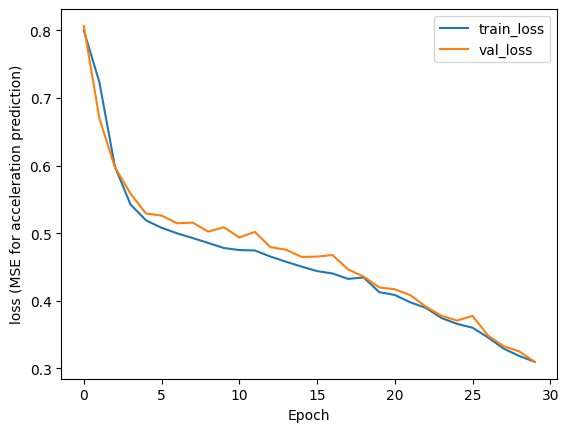

mean_test_error 25.09867254892985


289it [00:34,  8.37it/s]


count= 289 col= 3 rate 0.010380622837370242 jerk 0.5248966 miniumu_ttc 12.628256
mean_test_error 24.409756224127424


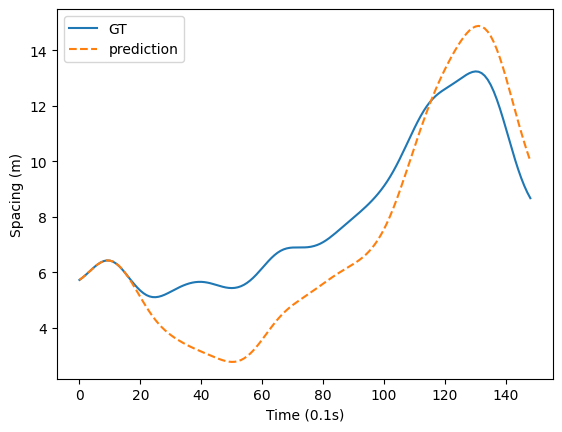

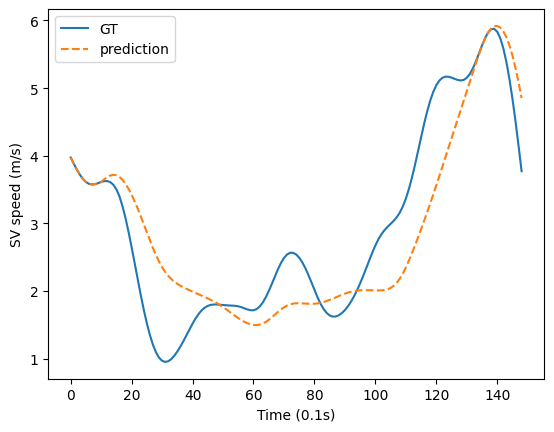

In [1]:
# 原跟车训练测试过程
from torch import nn, optim
import torch
import torch.nn as nnn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial


ACC_LIMIT = 3 # the limit of acceleration, this can be calibrated based on the data 加速度极限
# Ts = 0.04 # time interval for data sampling for HighD is 0.04 for other datasets are 0.1 数据采样时间间隔 15/375s
Ts = 0.1

# load data    加载包含Python对象的.npy或.npz文件，需要显式地设置allow_pickle参数为True
HighD_data = np.load('/kaggle/input/follow-car-datasets/data/HighD_car_fol_event_set_dhw.npy', allow_pickle=True)
NGSIM_data = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS1_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das1_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS2_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das2_car_fol_event_set.npy', allow_pickle=True)
waymo_data = np.load('/kaggle/input/follow-car-datasets/data/waymo_filter_carfo_info_150.npy', allow_pickle=True)
Lyft_test = np.load('/kaggle/input/follow-car-datasets/data/Lyft_test_data.npy', allow_pickle=True)
Lyft_train = np.load('/kaggle/input/follow-car-datasets/data/Lyft_train_data.npy', allow_pickle=True)
Lyft_val = np.load('/kaggle/input/follow-car-datasets/data/Lyft_val_data.npy', allow_pickle=True)
HighD_test = np.load('/kaggle/input/follow-car-datasets/data/HighD_test_data.npy', allow_pickle=True)
HighD_train = np.load('/kaggle/input/follow-car-datasets/data/HighD_train_data.npy', allow_pickle=True)
HighD_val = np.load('/kaggle/input/follow-car-datasets/data/HighD_val_data.npy', allow_pickle=True)
NGSIM_test = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_test_data.npy', allow_pickle=True)
NGSIM_train = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_train_data.npy', allow_pickle=True)
NGSIM_val = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_val_data.npy', allow_pickle=True)
SPMD1_test = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_test_data.npy', allow_pickle=True)
SPMD1_train = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_train_data.npy', allow_pickle=True)
SPMD1_val = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_val_data.npy', allow_pickle=True)
SPMD2_test = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_test_data.npy', allow_pickle=True)
SPMD2_train = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_train_data.npy', allow_pickle=True)
SPMD2_val = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_val_data.npy', allow_pickle=True)
Waymo_test = np.load('/kaggle/input/follow-car-datasets/data/Waymo_test_data.npy', allow_pickle=True)
Waymo_train = np.load('/kaggle/input/follow-car-datasets/data/Waymo_train_data.npy', allow_pickle=True)
Waymo_val = np.load('/kaggle/input/follow-car-datasets/data/Waymo_val_data.npy', allow_pickle=True)
# car_following_data = HighD_data
# the data shape format (number of car following event, 4 dimension data, lenth of each dimension)数据形状格式（跟车事件的车辆数、4 维数据、各维数据的长度）
# 4 dimension data= [spacing, subject_vehicle_speed, relative_speed, leading_vehicle_speed]4 维数据= [车距、后车车速、相对车速、前车车速］
# print(car_following_data)
# print(car_following_data.shape)   # HighD(12541, 4, 375)

# split the date into train, validation, test 数据集划分
def split_train(data,test_ratio,val_ratio):
#     np.random.seed(43)
    # 随机排列数据集的索引
    shuffled_indices=np.random.permutation(len(data))
    # 根据输入百分比（test_ratio）计算测试集大小
    test_set_size=int(len(data)*test_ratio)
    # 根据输入百分比（val_ratio）计算验证集大小
    val_number=int(len(data)*(test_ratio+val_ratio))
    # 根据索引划分数据集
    test_indices =shuffled_indices[:test_set_size] # 测试 (1881)
    val_indices=shuffled_indices[test_set_size:val_number] # 验证 (1881)
    train_indices=shuffled_indices[val_number:] # 训练 (8779)
    return data[train_indices],data[test_indices],data[val_indices]
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


# Define NN and lstm models
# max_len = 375 # for HighD dataset is 375 for others are 150
max_len = 150

class ImitationCarFolData(torch.utils.data.Dataset):
    """
    Dataset class for imitation learning (state -> action fitting) based car-following models.
    """
    def __init__(self, split: str, max_len = max_len):
        if split == 'train':
            self.data = train_data
        elif split == 'test':
            self.data = test_data
        elif split == 'validation':
            self.data = val_data
        self.max_len = max_len # Max length of a car following event.

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # 获取数据集中指定索引的车辆跟驰事件
        event = self.data[idx]
        # 截取事件中的max_len个时间步数据
        sv = event[1][:self.max_len] # 后车速度
        lv = event[3][:self.max_len] # 前车速度
        spacing = event[0][:self.max_len] # 车距
        relSpeed = event[2][:self.max_len] # 相对速度
        # 构建输入数据，包括 spacing, sv, relSpeed，截取除最后一项的全部数据
        inputs = [spacing[:-1], sv[:-1], relSpeed[:-1]]
        # 计算加速度标签（当前速度减去上一个时间步的速度）
        acc_label = np.diff(sv) / Ts  # (max_len - 1)
        # 保存 lv 作为速度标签
        lv_spd = lv
        return {'inputs': inputs, 'label': acc_label, 'lv_spd': lv_spd}

# Define data-driven car-following models
class nn_model(nn.Module):
    def __init__(self, input_size = 3, hidden_size = 256):
        super(nn_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Tanh(),
            )

    def forward(self, x):
        out = ACC_LIMIT*self.encoder(x)
        return out

class lstm_model(nn.Module):
    # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    def __init__(self, input_size=3, hidden_size=16, lstm_layers=1, dropout=0.1):
        super(lstm_model, self).__init__()
        # LSTM编码器，接受输入序列并输出隐藏状态
        self.encoder = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=False, dropout=dropout)
        # 线性层，将LSTM的输出映射到1维
        # self.linear = nn.Linear(hidden_size, 1)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.relu = nnn.ReLU(inplace=True)
        # 初始化线性层的权重和偏置
        nn.init.normal_(self.linear1.weight, 0, 0.02)
        nn.init.constant_(self.linear1.bias, 0.0)
        nn.init.normal_(self.linear2.weight, 0, 0.02)
        nn.init.constant_(self.linear2.bias, 0.0)
    # LSTM 模型由编码器和线性层组成。编码器接收输入数据并计算编码表示和最终层的隐藏状态。
    # 随后，线性层层将隐藏状态映射到输出值，输出值经过 tanh 激活函数并乘以代表加速度极限的常数
    def forward(self, src):
        # 将输入序列通过LSTM编码器得到隐藏状态  src(10,32,3)
        # enc_x(10,32,16)是模型在每个时间步的输出，(h_n, c_n)((1,32,16), (1,32,16))) 是模型的隐藏状态和记忆单元状态
        enc_x, (h_n, c_n) = self.encoder(src)
        # 如果隐藏状态的维度为3，则取最后一层的隐藏状态 即(batch_size, hidden_size)
        if len(h_n.shape) == 3:
            h_n = h_n[-1] # (32,16)
        # 通过线性层和激活函数得到最终输出
        out_0 = self.linear1(h_n) # (32,16)
        out = self.linear2(self.relu(out_0)) # (32, 1)
        # out = self.linear(h_n)
        # out = torch.tanh(out) * ACC_LIMIT
        return out


# Train
# 获取划分数据集
# (8779,4,375)，(1881,4,375)，(1881,4,375)
# train_data, test_data, val_data = split_train(car_following_data,0.15,0.15)
# train_data, test_data, val_data = split_train(car_following_data,0.8,0.1)
# train_data = Lyft_train
# test_data = Lyft_test
# val_data = Lyft_val
train_data = NGSIM_train
test_data = NGSIM_test
val_data = NGSIM_val
print(train_data.shape, test_data.shape, val_data.shape)
dataset = 'NGSIM'
model_type = 'lstm'
batch_size = 32
total_epochs = 30
# 创建训练集 DataLoader
train_dataset = ImitationCarFolData(split = 'train', max_len = max_len)
train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True)
# 创建验证集 DataLoader
validation_dataset = ImitationCarFolData(split = 'validation', max_len = max_len)
validation_loader = DataLoader(
        validation_dataset ,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True)
# 创建测试集 DataLoader
test_dataset = ImitationCarFolData(split = 'test', max_len = max_len)
test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        drop_last=True)

# 使用训练设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

his_horizon = 10 # number of time steps as history data
lr = 1e-3 # learning rate
# lr = 0.01
save = f'{model_type}_{dataset}.pt' # 保存模型文件
# 根据名称定义模型
if model_type == 'nn':
    model = nn_model(input_size = his_horizon*3).to(device)
elif model_type == 'lstm':
    model = lstm_model(input_size = 3, lstm_layers = 1).to(device) # single layer lstm
model_state = list(model.parameters())
print(model_state)
# 定义优化器和损失函数
model_optim = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# 初始化变量
train_loss_his = [] # 训练损失
test_error_his = [] # 测试误差
validation_error_his = [] # 验证误差
best_train_loss = None # 最佳训练损失
best_validation_loss = None # 最佳验证损失
best_epoch = None # 最佳验证损失时的轮次

print("----")
# 训练过程
for epoch in tqdm(range(total_epochs)):
    train_losses = [] # 记录每个epoch的训练损失
    validation_losses = [] # 记录每个epoch的验证损失
    model.train()
    # 遍历数据集
    for i, item in enumerate(train_loader):
        # x_data, y_data = item['inputs'].float().to(device), item['label'].float().to(device)
        # 获取输入数据及标签，input包括[距离，后车速度，相对速度]，label为加速度
        x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
        # Put T into the first dimension, B, T, d -> T, B, d
        # 将x_data中3个(32,374)连接，转换成(3,32,374)
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        # x->(374,32,3)，y->(374,32)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data
        
        y_pre = torch.zeros(T - his_horizon, B).to(device) # 存储预测加速度 (364,32)
        y_label = y_data[his_horizon:] # 存储从his_horizon开始的真实加速度 (364,32)
        # 从历史数据时间步开始遍历
        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
            if model_type == 'nn':
                x = x.transpose(0,1).reshape(B, -1) # flatten for history data
            # 根据his_horizon个数据预测加速度
            acc_pre = model(x).squeeze() # (32)
            y_pre[frame - his_horizon] = acc_pre
        #计算损失并进行反传及优化
        loss = criterion(y_pre, y_label)
        model_optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25) # 对模型梯度进行裁剪，避免梯度爆炸
        model_optim.step()

        train_losses.append(loss.item())
    # 计算本轮平均损失
    train_loss = np.mean(train_losses)

    train_loss_his.append(train_loss)
    print("Epoch: {0}| Train Loss: {1:.7f}".format(epoch + 1, train_loss))

    # 验证过程
    model.eval()
    error_list = []
    for i, item in enumerate(validation_loader):
        x_data, y_data = item['inputs'], item['label']
        # Put T into the first dimension, B, T, d -> T, B, d
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)
        # lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)
        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data
        # save a copy of x_data
        x_data_orig = x_data.clone().detach()
        y_label = y_data[his_horizon:]
        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
            if model_type == 'nn':
              x = x.transpose(0,1).reshape(B, -1) # flatten for history data

            acc_pre = model(x).squeeze()
            y_pre[frame - his_horizon] = acc_pre
        validation_loss = criterion(y_pre, y_label)
        model_optim.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        model_optim.step()
        validation_losses.append(validation_loss.item())
    # 计算平均验证误差
    mean_validation_error = np.mean(validation_losses)
    train_val_error = (mean_validation_error + train_loss)/2
    if best_validation_loss is None or best_validation_loss > train_val_error:
        best_epoch = epoch + 1
        best_validation_loss = train_val_error
        # save the best model
        with open(save, 'wb') as f:
            torch.save(model, f)

    validation_error_his.append(mean_validation_error)
    print("Epoch: {0}| Validation error: {1:.7f}".format(epoch + 1, mean_validation_error))

print("Epoch:{0}| Best Train+Val Loss：{1:.7f}".format(best_epoch, best_validation_loss))
plt.plot(train_loss_his, label = 'train_loss')
plt.plot(validation_error_his, label = 'val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss (MSE for acceleration prediction)')
plt.show()


# 用该数据集训练得到的模型去对其他数据集进行测试
# Ts = 0.04
# max_len = 375
# # car_following_data = NGSIM_data
# # print(car_following_data.shape)
# # train_data, test_data, val_data = split_train(car_following_data,0.15,0.15)
# test_data = HighD_test
# # 创建测试集 DataLoader
# test_dataset = ImitationCarFolData(split = 'test', max_len = max_len)
# test_loader = DataLoader(
#         test_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=1,
#         drop_last=True)


# Testing, closed-loop prediction
# Load the best model saved
with open(f'{save}', 'rb') as f:
    model = torch.load(f).to(device)
model.eval()

error_list = []

for i, item in enumerate(test_loader):
    x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data) # (3,32,374)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device) # x(374,32,3)  y(374,32)
    # 获取前车速度
    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1) # (375,32)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach() # (374,32,3)

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze() # (32,1)

        # update next data
        # 根据前一次计算得到的值，计算后面的值
        if frame < T-1:
            # 根据当前速度和加速度计算下一时间速度
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts # (32)
            # 计算下一时间速度的相对速度
            delta_v_ = lv_spd[frame + 1] - sv_spd_ # (32)
            # 该时刻真实相对速度
            delta_v = x_data[frame, :, -1] # (32)
            # 通过两车车距加上相对位移得到下一时间段车距 ？
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2 # (32)

            # update 根据计算得到的值，更新下一时间的值
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data

    # Calculating spacing error for the closed-loop simulation
    # 预测的车距
    spacing_pre = x_data[..., 0] # (374,32)
    # 真实的车距
    spacing_obs = x_data_orig[..., 0] # (374,32)

    error = criterion(spacing_pre, spacing_obs).item()
    error_list.append(error)
model.train()
# 计算MSE - 间距均方误差（Mean square error of spacing）
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)


# plot for one event
event_no = 2
plt.plot(spacing_obs[:, event_no].cpu().detach().numpy(), label = 'GT')
plt.plot(spacing_pre[:, event_no].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('Spacing (m)')

# speed part
plt.figure()
plt.plot(x_data_orig[:, event_no, 1].cpu().detach().numpy(), label = 'GT')
plt.plot(x_data[:, event_no, 1].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('SV speed (m/s)')


# Updated for the four key elvaluation metrics.  Note that: The loss design in FollowNet is for the reduction of the mse of spacing.
# Please note that The TTC results presented in the table of the paper indicate the average TTC value calculated.
# However, a drawback of this approach is that if the relative velocity in just one frame is extremely small, it will result in a significantly large computed TTC when reproducing paper.
# To address this issue, it may be beneficial to consider plotting the distribution of TTC as a way to present the results.
# 间距均方误差（Mean square error of spacing (MSE))
# 碰撞率（Collision rate）
# 驾驶舒适度指标(颠簸)（Driving comfort metric (jerk)）
# 碰撞时间(TTC)指标（Time-To-Collision (TTC) metric）
# for test
# 创建测试集 DataLoader
# Ts = 0.04
# max_len = 375
batch_size = 1
test_dataset = ImitationCarFolData(split = 'test', max_len = max_len)
test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        drop_last=True)
# 记录跟车事件数和发生碰撞事件数
count = 0
col = 0
jerk_set = [] 
# TTC_set = []
minimum_ttc_set = []
model.eval()
# ttc = [1, 2, 3, 4, 5, 6, 7, 8, -1, -3, 7]
def calculate_safety(ttc):
    # Remove any negative values (assuming TTC cannot be negative)
    # ttc = [x for x in ttc if x >= 0]
    # 计算ttc中最小值
    minimum_ttc = min(ttc)
    # 计算ttc中第1百分位的值
    first_percentile_ttc = np.percentile(ttc, 1)
    # print(1111)
    return minimum_ttc, first_percentile_ttc

# # Example usage
# minimum_ttc, first_percentile_ttc = calculate_safety(ttc)
# print("Minimum TTC:", minimum_ttc)
# print("1st Percentile TTC:", first_percentile_ttc)

for i, item in tqdm(enumerate(test_loader)):

    # jerk
    # jerk = np.diff(sv)/Ts
    acc_single = []
    TTC_single = []

    count += 1
    x_data, y_data = item['inputs'], item['label']
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach()

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze()

        acc_single.append(acc_pre)

        # update next data
        if frame < T-1:
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts
            # print(sv_spd_)
#             MyDevice = torch.device('cuda:0')
            # 速度取值大于0.001的
            sv_spd_ = torch.tensor(np.maximum(np.array(sv_spd_.detach().cpu()),0.001), device=device)
            delta_v_ = lv_spd[frame + 1] - sv_spd_
            delta_v = x_data[frame, :, -1]
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2

            spacing = np.array(spacing_.cpu())
            # 如果spacing<=0，表示发生碰撞
            if float(np.array(spacing_.cpu())) <= 0:
                col += 1
                break
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data
        # 计算TTC
        TTC_single.append(-spacing_ / delta_v_) # 正常情况(139)
    # Mean absolute jerk
    jerk =np.mean(np.abs(np.diff(torch.tensor(acc_single))/Ts))

    # if np.sum(torch.tensor(TTC_single).cuda().cpu().numpy()>0) == 0:
    #     continue
    TTC_single = torch.tensor(TTC_single).to(device).cpu().numpy()
    TTC_single = [x for x in TTC_single if x >= 0]
    if len(TTC_single) > 0:
        minimum_ttc, _ = calculate_safety(TTC_single)
        minimum_ttc_set.append(minimum_ttc)  # 大小为测试数据总数减去发生了碰撞的事件

    # Calculating spacing error for the closed-loop simulation
    # 预测车距
    spacing_pre = x_data[..., 0]
    # 真实车距
    spacing_obs = x_data_orig[..., 0]

    # plt.plot(np.array(spacing_obs.cpu()), label = 'GT')
    # plt.plot(np.array(spacing_pre.cpu()), '--', label = 'Prediction')
    # plt.legend()
    # plt.xlabel(f'Time ({Ts}s)');
    # plt.ylabel('Spacing (m)');
    # plt.show()
    error = criterion(spacing_pre[:(frame+1)], spacing_obs[:(frame+1)]).item()
    error_list.append(error)

    jerk_set.append(jerk)
# 输出指标
print("count=",count,"col=",col,"rate",col/count,"jerk", np.mean(jerk_set), "miniumu_ttc", np.mean(minimum_ttc_set))
model.train()
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)

(289, 4)
cuda:0
mean_test_error 25.09867254892985


289it [00:34,  8.32it/s]


count= 289 col= 3 rate 0.010380622837370242 jerk 0.5248966 miniumu_ttc 12.628256
mean_test_error 24.409756224127424


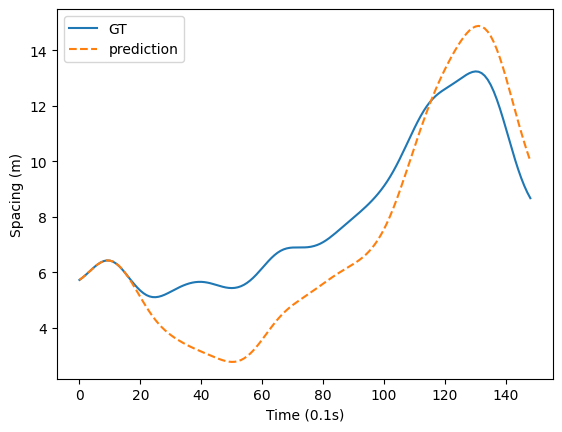

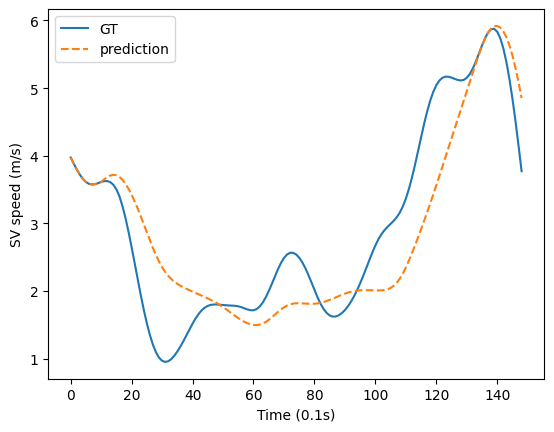

In [2]:
# 只含有test和指标计算代码部分，用于使用在不同数据集下训练的模型用在其他数据集上测试
from torch import nn, optim
import torch
import torch.nn as nnn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial


ACC_LIMIT = 3 # the limit of acceleration, this can be calibrated based on the data 加速度极限
# Ts = 0.04 # time interval for data sampling for HighD is 0.04 for other datasets are 0.1 数据采样时间间隔 15/375s
Ts = 0.1

# load data    加载包含Python对象的.npy或.npz文件，需要显式地设置allow_pickle参数为True
HighD_data = np.load('/kaggle/input/follow-car-datasets/data/HighD_car_fol_event_set_dhw.npy', allow_pickle=True)
NGSIM_data = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS1_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das1_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS2_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das2_car_fol_event_set.npy', allow_pickle=True)
waymo_data = np.load('/kaggle/input/follow-car-datasets/data/waymo_filter_carfo_info_150.npy', allow_pickle=True)
# car_following_data = NGSIM_data
# the data shape format (number of car following event, 4 dimension data, lenth of each dimension)数据形状格式（跟车事件的车辆数、4 维数据、各维数据的长度）
# 4 dimension data= [spacing, subject_vehicle_speed, relative_speed, leading_vehicle_speed]4 维数据= [车距、后车车速、相对车速、前车车速］
# print(car_following_data)
# print(car_following_data.shape)   # (12541, 4, 375)

# # 除HighD的数据集需要进行连接
# def car_stack(data):
#     # 创建一个空的目标数组，形状为 (1930, 4, 600)
#     target_shape = (data.shape[0], data.shape[1], data[0, 0].shape[0])
#     target_array = np.empty(target_shape)

#     # 遍历原始数组，将每个元素转换为 (4, 600) 的子数组，并放入目标数组
#     for i in range(data.shape[0]):
#         for j in range(data.shape[1]):
#             target_array[i, j, :] = data[i, j]
#     # 最终 target_array 的形状为 (1930, 4, 600)
#     return target_array


# split the date into train, validation, test 数据集划分
def split_train(data,test_ratio,val_ratio):
#     np.random.seed(43)
    # 随机排列数据集的索引
    shuffled_indices=np.random.permutation(len(data))
    # 根据输入百分比（test_ratio）计算测试集大小
    test_set_size=int(len(data)*test_ratio)
    # 根据输入百分比（val_ratio）计算验证集大小
    val_number=int(len(data)*(test_ratio+val_ratio))
    # 根据索引划分数据集
    test_indices =shuffled_indices[:test_set_size] # 测试 (1881)
    val_indices=shuffled_indices[test_set_size:val_number] # 验证 (1881)
    train_indices=shuffled_indices[val_number:] # 训练 (8779)
    return data[train_indices],data[test_indices],data[val_indices]
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


# Define NN and lstm models
# max_len = 375 # for HighD dataset is 375 for others are 150
max_len = 150

class ImitationCarFolData(torch.utils.data.Dataset):
    """
    Dataset class for imitation learning (state -> action fitting) based car-following models.
    """
    def __init__(self, split: str, max_len = max_len):
        if split == 'train':
            self.data = train_data
        elif split == 'test':
            self.data = test_data
        elif split == 'validation':
            self.data = val_data
        self.max_len = max_len # Max length of a car following event.

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # 获取数据集中指定索引的车辆跟驰事件
        event = self.data[idx]
        # 截取事件中的除最后一项的前 max_len-1 个时间步
        sv = event[1][:self.max_len] # 后车速度
        lv = event[3][:self.max_len] # 前车速度
        spacing = event[0][:self.max_len] # 车距
        relSpeed = event[2][:self.max_len] # 相对速度
        # 构建输入数据，包括 spacing, sv, relSpeed
        inputs = [spacing[:-1], sv[:-1], relSpeed[:-1]]
        # 计算加速度标签（当前速度减去上一个时间步的速度）
        acc_label = np.diff(sv) / Ts
        # 保存 lv 作为速度标签
        lv_spd = lv
        return {'inputs': inputs, 'label': acc_label, 'lv_spd': lv_spd}

# Define data-driven car-following models
class nn_model(nn.Module):
    def __init__(self, input_size = 3, hidden_size = 256):
        super(nn_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Tanh(),
            )

    def forward(self, x):
        out = ACC_LIMIT*self.encoder(x)
        return out

class lstm_model(nn.Module):
    # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    def __init__(self, input_size=3, hidden_size=16, lstm_layers=1, dropout=0.1):
        super(lstm_model, self).__init__()
        # LSTM编码器，接受输入序列并输出隐藏状态
        self.encoder = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=False, dropout=dropout)
        # 线性层，将LSTM的输出映射到1维
        # self.linear = nn.Linear(hidden_size, 1)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.relu = nnn.ReLU(inplace=True)
        # 初始化线性层的权重和偏置
        nn.init.normal_(self.linear1.weight, 0, 0.02)
        nn.init.constant_(self.linear1.bias, 0.0)
        nn.init.normal_(self.linear2.weight, 0, 0.02)
        nn.init.constant_(self.linear2.bias, 0.0)
    # LSTM 模型由编码器和线性层组成。编码器接收输入数据并计算编码表示和最终层的隐藏状态。
    # 随后，线性层层将隐藏状态映射到输出值，输出值经过 tanh 激活函数并乘以代表加速度极限的常数
    def forward(self, src):
        # 将输入序列通过LSTM编码器得到隐藏状态  src(10,32,3)
        # enc_x(10,32,16)是模型在每个时间步的输出，(h_n, c_n)((1,32,16), (1,32,16))) 是模型的隐藏状态和记忆单元状态
        enc_x, (h_n, c_n) = self.encoder(src)
        # 如果隐藏状态的维度为3，则取最后一层的隐藏状态 即(batch_size, hidden_size)
        if len(h_n.shape) == 3:
            h_n = h_n[-1] # (32,16)
        # 通过线性层和激活函数得到最终输出
        out_0 = self.linear1(h_n) # (32,16)
        out = self.linear2(self.relu(out_0)) # (32, 1)
        # out = self.linear(h_n)
        # out = torch.tanh(out) * ACC_LIMIT
        return out

HighD_test = np.load('/kaggle/input/follow-car-datasets/data/HighD_test_data.npy', allow_pickle=True)
HighD_train = np.load('/kaggle/input/follow-car-datasets/data/HighD_train_data.npy', allow_pickle=True)
HighD_val = np.load('/kaggle/input/follow-car-datasets/data/HighD_val_data.npy', allow_pickle=True)
Lyft_test = np.load('/kaggle/input/follow-car-datasets/data/Lyft_test_data.npy', allow_pickle=True)
Lyft_train = np.load('/kaggle/input/follow-car-datasets/data/Lyft_train_data.npy', allow_pickle=True)
Lyft_val = np.load('/kaggle/input/follow-car-datasets/data/Lyft_val_data.npy', allow_pickle=True)
NGSIM_test = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_test_data.npy', allow_pickle=True)
NGSIM_train = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_train_data.npy', allow_pickle=True)
NGSIM_val = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_val_data.npy', allow_pickle=True)

# 获取划分数据集
# (8779,4,375)，(1881,4,375)，(1881,4,375)
# train_data, test_data, val_data = split_train(car_following_data,0.15,0.15)
# train_data, test_data, val_data = Lyft_train, Lyft_test, Lyft_val
train_data = NGSIM_train
test_data = NGSIM_test
val_data = NGSIM_val
print(test_data.shape)
dataset = 'NGSIM'
model_type = 'lstm'
batch_size = 32
total_epochs = 20
# 创建训练集 DataLoader
train_dataset = ImitationCarFolData(split = 'train', max_len = max_len)
train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True)
# 创建验证集 DataLoader
validation_dataset = ImitationCarFolData(split = 'validation', max_len = max_len)
validation_loader = DataLoader(
        validation_dataset ,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True)
# 创建测试集 DataLoader
test_dataset = ImitationCarFolData(split = 'test', max_len = max_len)
test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        drop_last=True)

# 使用训练设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

his_horizon = 10 # number of time steps as history data
lr = 1e-3 # learning rate
save = f'{model_type}_{dataset}.pt' # 保存模型文件
# 根据名称定义模型
if model_type == 'nn':
    model = nn_model(input_size = his_horizon*3).to(device)
elif model_type == 'lstm':
    model = lstm_model(input_size = 3, lstm_layers = 1).to(device) # single layer lstm
# 定义优化器和损失函数
model_optim = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# 初始化变量
train_loss_his = [] # 训练损失
test_error_his = [] # 测试误差
validation_error_his = [] # 验证误差
best_train_loss = None # 最佳训练损失
best_validation_loss = None # 最佳验证损失

# Testing, closed-loop prediction
# Load the best model saved
with open(f'{save}', 'rb') as f:
    model = torch.load(f).to(device)
model.eval()

error_list = []

for i, item in enumerate(test_loader):
    x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data) # (3,32,374)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device) # x(374,32,3)  y(374,32)
    # 获取前车速度
    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1) # (375,32)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach() # (374,32,3)

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze() # (32,1)

        # update next data
        # 根据前一次计算得到的值，计算后面的值
        if frame < T-1:
            # 根据当前速度和加速度计算下一时间速度
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts # (32)
            # 计算下一时间速度的相对速度
            delta_v_ = lv_spd[frame + 1] - sv_spd_ # (32)
            # 该时刻真实相对速度
            delta_v = x_data[frame, :, -1] # (32)
            # 通过两车车距加上相对位移得到下一时间段车距 ？
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2 # (32)

            # update 根据计算得到的值，更新下一时间的值
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data

    # Calculating spacing error for the closed-loop simulation
    # 预测的车距
    spacing_pre = x_data[..., 0] # (374,32)
    # 真实的车距
    spacing_obs = x_data_orig[..., 0] # (374,32)

    error = criterion(spacing_pre, spacing_obs).item()
    error_list.append(error)
model.train()
# 计算MSE - 间距均方误差（Mean square error of spacing）
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)


# plot for one event
event_no = 2
plt.plot(spacing_obs[:, event_no].cpu().detach().numpy(), label = 'GT')
plt.plot(spacing_pre[:, event_no].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('Spacing (m)')

# speed part
plt.figure()
plt.plot(x_data_orig[:, event_no, 1].cpu().detach().numpy(), label = 'GT')
plt.plot(x_data[:, event_no, 1].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('SV speed (m/s)')


# Updated for the four key elvaluation metrics.  Note that: The loss design in FollowNet is for the reduction of the mse of spacing.
# Please note that The TTC results presented in the table of the paper indicate the average TTC value calculated.
# However, a drawback of this approach is that if the relative velocity in just one frame is extremely small, it will result in a significantly large computed TTC when reproducing paper.
# To address this issue, it may be beneficial to consider plotting the distribution of TTC as a way to present the results.
# 间距均方误差（Mean square error of spacing (MSE))
# 碰撞率（Collision rate）
# 驾驶舒适度指标(颠簸)（Driving comfort metric (jerk)）
# 碰撞时间(TTC)指标（Time-To-Collision (TTC) metric）
# for test
# 创建测试集 DataLoader
batch_size = 1
test_dataset = ImitationCarFolData(split = 'test', max_len = max_len)
test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        drop_last=True)
# 记录跟车事件数和发生碰撞事件数
count = 0
col = 0
jerk_set = [] 
# TTC_set = []
minimum_ttc_set = []
model.eval()
# ttc = [1, 2, 3, 4, 5, 6, 7, 8, -1, -3, 7]
def calculate_safety(ttc):
    # Remove any negative values (assuming TTC cannot be negative)
    # ttc = [x for x in ttc if x >= 0]
    # 计算ttc中最小值
    minimum_ttc = min(ttc)
    # 计算ttc中第1百分位的值
    first_percentile_ttc = np.percentile(ttc, 1)
    # print(1111)
    return minimum_ttc, first_percentile_ttc

# # Example usage
# minimum_ttc, first_percentile_ttc = calculate_safety(ttc)
# print("Minimum TTC:", minimum_ttc)
# print("1st Percentile TTC:", first_percentile_ttc)

for i, item in tqdm(enumerate(test_loader)):

    # jerk
    # jerk = np.diff(sv)/Ts
    acc_single = []
    TTC_single = []

    count += 1
    x_data, y_data = item['inputs'], item['label']
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach()

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze()

        acc_single.append(acc_pre)

        # update next data
        if frame < T-1:
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts
            # print(sv_spd_)
            MyDevice = torch.device('cuda:0')
            # 速度取值大于0.001的
            sv_spd_ = torch.tensor(np.maximum(np.array(sv_spd_.detach().cpu()),0.001), device=MyDevice)
            delta_v_ = lv_spd[frame + 1] - sv_spd_
            delta_v = x_data[frame, :, -1]
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2

            spacing = np.array(spacing_.cpu())
            # 如果spacing<=0，表示发生碰撞
            if float(np.array(spacing_.cpu())) <= 0:
                col += 1
                break
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data
        # 计算TTC
        TTC_single.append(-spacing_ / delta_v_)

    # Mean absolute jerk
    jerk =np.mean(np.abs(np.diff(torch.tensor(acc_single))/Ts))

    # if np.sum(torch.tensor(TTC_single).cuda().cpu().numpy()>0) == 0:
    #     continue
    TTC_single = torch.tensor(TTC_single).to(device).cpu().numpy()
    TTC_single = [x for x in TTC_single if x >= 0]
    if len(TTC_single) > 0:
        minimum_ttc, _ = calculate_safety(TTC_single)
        minimum_ttc_set.append(minimum_ttc)

    # Calculating spacing error for the closed-loop simulation
    # 预测车距
    spacing_pre = x_data[..., 0]
    # 真实车距
    spacing_obs = x_data_orig[..., 0]

    # plt.plot(np.array(spacing_obs.cpu()), label = 'GT')
    # plt.plot(np.array(spacing_pre.cpu()), '--', label = 'Prediction')
    # plt.legend()
    # plt.xlabel(f'Time ({Ts}s)');
    # plt.ylabel('Spacing (m)');
    # plt.show()
    error = criterion(spacing_pre[:(frame+1)], spacing_obs[:(frame+1)]).item()
    error_list.append(error)

    jerk_set.append(jerk)
# 输出指标
print("count=",count,"col=",col,"rate",col/count,"jerk", np.mean(jerk_set), "miniumu_ttc", np.mean(minimum_ttc_set))
model.train()
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)

In [3]:
# 求一些值用
from torch import nn, optim
import torch
import torch.nn as nnn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Ts = 0.04 # time interval for data sampling for HighD is 0.04 for other datasets are 0.1 数据采样时间间隔 15/375s   15/150s
# max_len = 375 # for HighD dataset is 375 for others are 150
Ts = 0.1
max_len = 150

# load data    加载包含Python对象的.npy或.npz文件，需要显式地设置allow_pickle参数为True
HighD_data = np.load('/kaggle/input/follow-car-datasets/data/HighD_car_fol_event_set_dhw.npy', allow_pickle=True)
NGSIM_data = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS1_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das1_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS2_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das2_car_fol_event_set.npy', allow_pickle=True)
Waymo_data = np.load('/kaggle/input/follow-car-datasets/data/waymo_filter_carfo_info_150.npy', allow_pickle=True)
Lyft_data = np.load('/kaggle/input/lyft-data/Lyft_car_fol_event_set.npy', allow_pickle=True)
Lyft_test = np.load('/kaggle/input/follow-car-datasets/data/Lyft_test_data.npy', allow_pickle=True)
Lyft_train = np.load('/kaggle/input/follow-car-datasets/data/Lyft_train_data.npy', allow_pickle=True)
Lyft_val = np.load('/kaggle/input/follow-car-datasets/data/Lyft_val_data.npy', allow_pickle=True)
HighD_test = np.load('/kaggle/input/follow-car-datasets/data/HighD_test_data.npy', allow_pickle=True)
HighD_train = np.load('/kaggle/input/follow-car-datasets/data/HighD_train_data.npy', allow_pickle=True)
HighD_val = np.load('/kaggle/input/follow-car-datasets/data/HighD_val_data.npy', allow_pickle=True)
NGSIM_test = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_test_data.npy', allow_pickle=True)
NGSIM_train = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_train_data.npy', allow_pickle=True)
NGSIM_val = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_val_data.npy', allow_pickle=True)
SPMD1_test = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_test_data.npy', allow_pickle=True)
SPMD1_train = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_train_data.npy', allow_pickle=True)
SPMD1_val = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_val_data.npy', allow_pickle=True)
SPMD2_test = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_test_data.npy', allow_pickle=True)
SPMD2_train = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_train_data.npy', allow_pickle=True)
SPMD2_val = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_val_data.npy', allow_pickle=True)
Waymo_test = np.load('/kaggle/input/follow-car-datasets/data/Waymo_test_data.npy', allow_pickle=True)
Waymo_train = np.load('/kaggle/input/follow-car-datasets/data/Waymo_train_data.npy', allow_pickle=True)
Waymo_val = np.load('/kaggle/input/follow-car-datasets/data/Waymo_val_data.npy', allow_pickle=True)
# 使用训练设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 获取每个跟车事件的时间步长
def DataMin(dataset):
    data_min = []
    for i in range(dataset.shape[0]):
        data_min.append(dataset[i][0].size)
    return data_min

datamin = DataMin(NGSIM_data)
# print(datamin)
print("最小时间步：", np.min(datamin))

# 将数据集划分成样本
class ImitationCarFolData(torch.utils.data.Dataset):
    """
    Dataset class for imitation learning (state -> action fitting) based car-following models.
    """
    def __init__(self, data, max_len = max_len):
        self.data = data
        self.max_len = max_len # Max length of a car following event.

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 获取数据集中指定索引的车辆跟驰事件
        event = self.data[idx]
        # 截取事件中的max_len个时间步数据
        sv = event[1][:self.max_len] # 后车速度
        lv = event[3][:self.max_len] # 前车速度
        spacing = event[0][:self.max_len] # 车距
        relSpeed = event[2][:self.max_len] # 相对速度
        # 构建输入数据，包括 spacing, sv, relSpeed，截取除最后一项的全部数据
        inputs = [spacing[:-1], sv[:-1], relSpeed[:-1]]
        # 计算加速度标签（当前速度减去上一个时间步的速度）
        acc_label = np.diff(sv) / Ts
        # 保存 lv 作为速度标签
        lv_spd = lv
        return {'inputs': inputs, 'label': acc_label, 'lv_spd': lv_spd}

# 求原测试集中的平均jerk
Ts = 0.1
max_len = 150
dataset_test = Lyft_test
dataset_loader_test = ImitationCarFolData(dataset_test, max_len = max_len)
test_loader = DataLoader(
            dataset_loader_test,
            batch_size=1,
            shuffle=False,
            num_workers=1,
            drop_last=True)
# 记录跟车事件数和发生碰撞事件数
his_horizon = 10
count = 0
col = 0
jerk_set = []
# TTC_set = []
minimum_ttc_set = []
# ttc = [1, 2, 3, 4, 5, 6, 7, 8, -1, -3, 7]
def calculate_safety(ttc):
    # Remove any negative values (assuming TTC cannot be negative)
    # ttc = [x for x in ttc if x >= 0]
    # 计算ttc中最小值
    minimum_ttc = min(ttc)
    # 计算ttc中第1百分位的值
    first_percentile_ttc = np.percentile(ttc, 1)
    # print(1111)
    return minimum_ttc, first_percentile_ttc

# # Example usage
# minimum_ttc, first_percentile_ttc = calculate_safety(ttc)
# print("Minimum TTC:", minimum_ttc)
# print("1st Percentile TTC:", first_percentile_ttc)

for i, item in tqdm(enumerate(test_loader)):

    # jerk
    # jerk = np.diff(sv)/Ts
    acc_single = []
    TTC_single = []

    count += 1
    x_data, y_data = item['inputs'], item['label']
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
#     x_data, y_data = x_data.transpose(0, 2).float(), y_data.transpose(0, 1).float()

    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)

    T, B = y_data.shape # (total steps, batch_size, d) as the shape of the data
#     print(T,B)
    a = np.diff(y_data)/Ts
    b = np.abs(a)
    jerk =np.mean(b)
    jerk_set.append(jerk)
# 输出指标
print("jerk", np.mean(jerk_set))

cuda:0
最小时间步： 150


2240it [00:07, 282.17it/s]

jerk 0.7705402415347494


cuda:0
1/1. loss: 0.05995489358901977


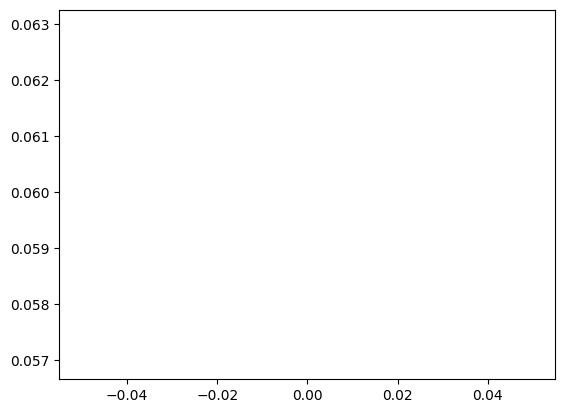

----------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1| Train Loss: 1.0017771


 10%|█         | 1/10 [00:01<00:14,  1.59s/it]

Epoch: 1| Validation error: 1.1394189
Epoch: 2| Train Loss: 1.0005401


 20%|██        | 2/10 [00:03<00:13,  1.66s/it]

Epoch: 2| Validation error: 1.0504931
Epoch: 3| Train Loss: 0.9673114


 30%|███       | 3/10 [00:04<00:11,  1.63s/it]

Epoch: 3| Validation error: 1.0001079
Epoch: 4| Train Loss: 0.9095850


 40%|████      | 4/10 [00:06<00:09,  1.63s/it]

Epoch: 4| Validation error: 0.9567192
Epoch: 5| Train Loss: 0.8560571


 50%|█████     | 5/10 [00:08<00:08,  1.63s/it]

Epoch: 5| Validation error: 0.9049085
Epoch: 6| Train Loss: 0.8279323


 60%|██████    | 6/10 [00:09<00:06,  1.63s/it]

Epoch: 6| Validation error: 0.8733972
Epoch: 7| Train Loss: 0.7849904


 70%|███████   | 7/10 [00:11<00:04,  1.63s/it]

Epoch: 7| Validation error: 0.8398764
Epoch: 8| Train Loss: 0.7611768


 80%|████████  | 8/10 [00:13<00:03,  1.64s/it]

Epoch: 8| Validation error: 0.8072399
Epoch: 9| Train Loss: 0.7333342


 90%|█████████ | 9/10 [00:14<00:01,  1.64s/it]

Epoch: 9| Validation error: 0.8260500
Epoch: 10| Train Loss: 0.7265012


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

Epoch: 10| Validation error: 0.7780620
Epoch:10| Best Train+Val Loss：0.7522816


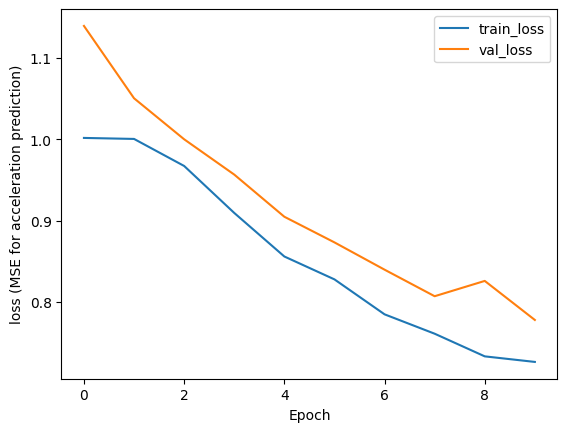

mean_test_error 142.1366026742118


289it [00:25, 11.47it/s]


count= 289 col= 80 rate 0.2768166089965398 jerk 0.037525084 miniumu_ttc 8.569448
mean_test_error 86.1209768412241


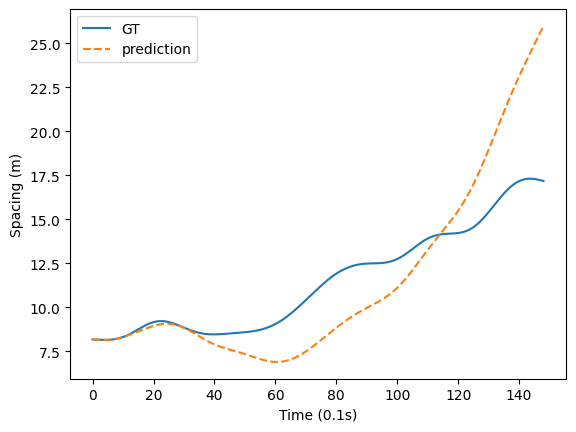

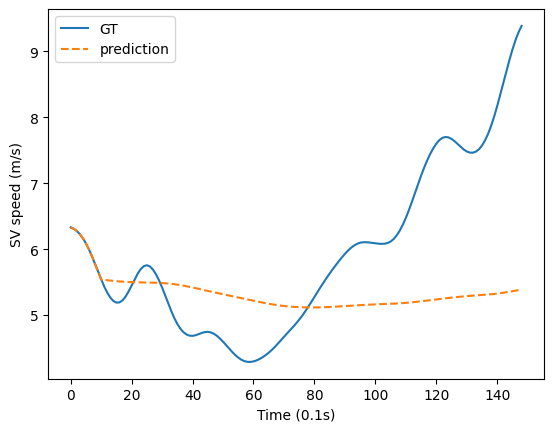

In [4]:
# MAML-跟车  version1
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial
import copy


# ACC_LIMIT = 3 # the limit of acceleration, this can be calibrated based on the data 加速度极限
# Ts = 0.04 # time interval for data sampling for HighD is 0.04 for other datasets are 0.1 数据采样时间间隔 15/375s
Ts = 0.1

# load data    加载包含Python对象的.npy或.npz文件，需要显式地设置allow_pickle参数为True
HighD_data = np.load('/kaggle/input/follow-car-datasets/data/HighD_car_fol_event_set_dhw.npy', allow_pickle=True)
NGSIM_data = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS1_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das1_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS2_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das2_car_fol_event_set.npy', allow_pickle=True)
Waymo_data = np.load('/kaggle/input/follow-car-datasets/data/waymo_filter_carfo_info_150.npy', allow_pickle=True)
Lyft_data = np.load('/kaggle/input/lyft-data/Lyft_car_fol_event_set.npy', allow_pickle=True)
Lyft_test = np.load('/kaggle/input/follow-car-datasets/data/Lyft_test_data.npy', allow_pickle=True)
Lyft_train = np.load('/kaggle/input/follow-car-datasets/data/Lyft_train_data.npy', allow_pickle=True)
Lyft_val = np.load('/kaggle/input/follow-car-datasets/data/Lyft_val_data.npy', allow_pickle=True)
HighD_test = np.load('/kaggle/input/follow-car-datasets/data/HighD_test_data.npy', allow_pickle=True)
HighD_train = np.load('/kaggle/input/follow-car-datasets/data/HighD_train_data.npy', allow_pickle=True)
HighD_val = np.load('/kaggle/input/follow-car-datasets/data/HighD_val_data.npy', allow_pickle=True)
NGSIM_test = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_test_data.npy', allow_pickle=True)
NGSIM_train = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_train_data.npy', allow_pickle=True)
NGSIM_val = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_val_data.npy', allow_pickle=True)
SPMD1_test = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_test_data.npy', allow_pickle=True)
SPMD1_train = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_train_data.npy', allow_pickle=True)
SPMD1_val = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_val_data.npy', allow_pickle=True)
SPMD2_test = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_test_data.npy', allow_pickle=True)
SPMD2_train = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_train_data.npy', allow_pickle=True)
SPMD2_val = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_val_data.npy', allow_pickle=True)
Waymo_test = np.load('/kaggle/input/follow-car-datasets/data/Waymo_test_data.npy', allow_pickle=True)
Waymo_train = np.load('/kaggle/input/follow-car-datasets/data/Waymo_train_data.npy', allow_pickle=True)
Waymo_val = np.load('/kaggle/input/follow-car-datasets/data/Waymo_val_data.npy', allow_pickle=True)
# 使用训练设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 数据集划分
def split_train(data,data_ratio):
#     np.random.seed(43)
    # 随机排列数据集的索引
    shuffled_indices=np.random.permutation(len(data))
    if data_ratio < 0:
        # 如果小于零，根据输入百分比计算获取数据集的数量
        data_size=int(len(data)*data_ratio)
        # 根据索引划分数据集
        data_indices =shuffled_indices[:data_size] # 测试 (1881)
    else:
        # 如果大于等于零，则data_ratio为获取数据集中的数量
        data_indices = shuffled_indices[:data_ratio]
    return data[data_indices]
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


# Define NN and lstm models
# max_len = 375 # for HighD dataset is 375 for others are 150
max_len = 150
his_horizon = 10

# 将数据集划分成样本
class ImitationCarFolData(torch.utils.data.Dataset):
    """
    Dataset class for imitation learning (state -> action fitting) based car-following models.
    """
    def __init__(self, data, max_len = max_len):
        self.data = data
        self.max_len = max_len # Max length of a car following event.

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 获取数据集中指定索引的车辆跟驰事件
        event = self.data[idx]
        # 截取事件中的max_len个时间步数据
        sv = event[1][:self.max_len] # 后车速度
        lv = event[3][:self.max_len] # 前车速度
        spacing = event[0][:self.max_len] # 车距
        relSpeed = event[2][:self.max_len] # 相对速度
        # 构建输入数据，包括 spacing, sv, relSpeed，截取除最后一项的全部数据
        inputs = [spacing[:-1], sv[:-1], relSpeed[:-1]]
        # 计算加速度标签（当前速度减去上一个时间步的速度）
        acc_label = np.diff(sv) / Ts
        # 保存 lv 作为速度标签
        lv_spd = lv
        return {'inputs': inputs, 'label': acc_label, 'lv_spd': lv_spd}


# 定义模型
class nn_model(nn.Module):
    def __init__(self, input_size = 3):
        super(nn_model,self).__init__()
        self.net=nn.Sequential(OrderedDict([
                ('l1',nn.Linear(input_size,256)),
                ('relu1',nn.ReLU()),
                ('l2',nn.Linear(256,256)),
                ('relu2',nn.ReLU()),
                ('l3',nn.Linear(256,1))
            ]))
        self.state = list(self.net.parameters())
  # 用于元学习的内循环中更新权重的方法，用于计算元损失，然后重置下一个元任务的权重。
    def argforward(self,x,weights): 
        x=F.linear(x,weights[0],weights[1])  # (input,weight,bias)
        x=F.relu(x)
        x=F.linear(x,weights[2],weights[3])
        x=F.relu(x)
        x=F.linear(x,weights[4],weights[5])
        return x


# 元学习内循环训练过程
def inner_train(data_loader, net ,temp_weights, criterion):
    # 初始化变量
    train_loss_his = []  # 训练损失
    best_train_loss = None  # 最佳训练损失
    best_epoch = None  # 最佳验证损失时的轮次
    # 训练过程
    train_losses = []  # 记录每个epoch的训练损失
    net.train()
    # 遍历数据集
    for i, item in enumerate(data_loader):
        # x_data, y_data = item['inputs'].float().to(device), item['label'].float().to(device)
        # 获取输入数据及标签，input包括[距离，后车速度，相对速度]，label为加速度
        x_data, y_data = item['inputs'], item['label'] # x_data((20,149)，(20,149)，(20,149))  y_data(20,149)
        # Put T into the first dimension, B, T, d -> T, B, d
        # 将x_data中3个(20,149)连接，转换成(3,20,149)
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        # x->(149,20,3)，y->(149,20)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data
#         print(T,B,d)  # 149  20  3
        y_pre = torch.zeros(T - his_horizon, B).to(device) # 存储预测加速度 (139,20)
        y_label = y_data[his_horizon:] # 存储从his_horizon开始的真实加速度 (139,20)
        # 从历史数据时间步开始遍历
        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10, 20, 3)
            if model_type == 'nn':
                x = x.transpose(0,1).reshape(B, -1) # flatten for history data (20, 30)
            # 根据his_horizon个数据预测加速度
            acc_pre = net.argforward(x, temp_weights).squeeze() # (32)
            y_pre[frame - his_horizon] = acc_pre
        #计算损失并进行反传及优化
        loss = criterion(y_pre, y_label)
        return loss


# 生成不同数据集的任务类
class DataTask():
    def __init__(self,data_range):
        self.data_range = data_range
  # 生成任务数据，默认生成一个数据点，可以通过指定size参数生成多个数据点
    def sample_data(self,size=1):
        if self.data_range == 1:
            meta_data = HighD_data
            Ts = 0.04
            max_len = 375
#             print('--HighD--')
        elif self.data_range == 2:
            meta_data = Lyft_data
            Ts = 0.1
            max_len = 150
#             print('--Lyft---')
        elif self.data_range == 3:
            meta_data = SPMD_DAS1_data
            Ts = 0.1
            max_len = 150
#             print('SPMD_DAS1')
        elif self.data_range == 4:
            meta_data = SPMD_DAS2_data
            Ts = 0.1
            max_len = 150
#             print('SPMD_DAS2')
        elif self.data_range == 5:
            meta_data = Waymo_data
            Ts = 0.1
            max_len = 150
#             print('--Waymo--')
        meta_data_set = split_train(meta_data, size)
#         print(data_set[0].shape)
        dataset_loader = ImitationCarFolData(meta_data_set, max_len = max_len)
        return dataset_loader


# 任务分布，及选择不同的数据
class DataDistribution():
    def __init__(self,min_data=1,max_data=5):
        self.min_data=min_data    # 获取数据集的数值
        self.max_data=max_data
    # 随机生成一个跟车数据集
    def sample_task(self):
        # 从1-5中随机生成一个数字来选取数据集
        data_range = np.random.randint(self.min_data, self.max_data + 1)
        return DataTask(data_range)


# MAML元学习训练过程
class MAML():
    def __init__(self, net, alpha, beta, tasks, k, num_metatasks):  # (net,alpha=0.01,beta=0.001,tasks=data_tasks,k=100,num_metatasks=10)
        # 初始化 MAML 算法的元参数
        self.net = net  # 元学习使用的神经网络模型
        self.weights = list(net.parameters())  # 获取神经网络的参数
        self.alpha = alpha  # 内循环学习率
        self.beta = beta  # 外循环学习率
        self.tasks = tasks  # 正弦任务的分布
        self.k = k  # 内循环（任务采样）的数据集大小
        self.num_tasks_meta = num_metatasks  # 外循环（元任务采样）的任务数量
        self.criterion = nn.MSELoss()  # 均方误差损失函数
        self.meta_optimiser = torch.optim.Adam(self.weights, self.beta)  # 外循环优化器（Adam）
        self.meta_losses = []  # 用于存储元学习的损失历史
        self.plot_every = 1  # 每隔多少次迭代记录一次损失，用于绘图
        self.print_every = 1  # 每隔多少次迭代输出一次损失信息，用于打印
        self.num_metatasks = num_metatasks  # 外循环迭代的总次数
        self.batch_size = self.k

    def inner_loop(self, task):
        # 内循环更新参数，用于计算元学习损失
        temp_weights = [w.clone() for w in self.weights]  # 复制当前网络参数作为临时参数
        dataset_loader = task.sample_data(size=self.k)  # 从任务中采样数据集 D
        dataloader = DataLoader(
                dataset_loader,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=1,
                drop_last=False)
        # 训练过程
        loss = inner_train(dataloader, self.net, temp_weights, self.criterion) / self.k
        grads = torch.autograd.grad(loss, temp_weights)  # 计算损失对参数的梯度
        temp_weights = [w - self.alpha * g for w, g in zip(temp_weights, grads)]  # 临时参数更新 梯度下降
        metaloss = inner_train(dataloader, self.net, temp_weights, self.criterion) / self.k
        return metaloss

    def outer_loop(self, num_epochs):  # epoch 50000
        total_loss = 0
        for epoch in range(1, num_epochs + 1):
            metaloss_sum = 0
            for i in range(self.num_metatasks):  # 10
                task = self.tasks.sample_task()  # 从任务分布中采样一个元任务
                metaloss = self.inner_loop(task)  # 内循环更新参数，计算元学习损失
                metaloss_sum += metaloss  # mete_loss求和
            metagrads = torch.autograd.grad(metaloss_sum, self.weights)  # 计算元学习损失对参数的梯度
            # 重要步骤：使用元学习梯度更新网络参数
            for w, g in zip(self.weights, metagrads):
                w.grad = g
            self.meta_optimiser.step()  # 使用外循环优化器更新网络参数
            total_loss += metaloss_sum.item() / self.num_metatasks
            if epoch % self.print_every == 0:
                print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.print_every))
            if epoch % self.plot_every == 0:
                self.meta_losses.append(total_loss / self.plot_every)
                total_loss = 0

dataset = 'NGSIM'
model_type = 'nn'
save = f'{model_type}_{dataset}.pt' # 保存模型文件
if model_type == 'nn':
    net = nn_model(input_size = his_horizon*3).to(device)
# elif model_type == 'lstm':
#     net = lstm_model(input_size = 3, lstm_layers = 1).to(device) # single layer lstm
data_tasks=DataDistribution(1, 5)
maml=MAML(net,alpha=0.01,beta=0.001,tasks=data_tasks,k=100,num_metatasks=10)


maml.outer_loop(num_epochs=1)
plt.plot(maml.meta_losses)
plt.show()
print('----------------------')


# Train
Ts = 0.1
max_len = 150
og_net = maml.net.net
# 创建一个与原始网络结构相同的虚拟网络
if model_type == 'nn':
    dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(his_horizon*3,256)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(256,256)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(256,1))
    ]))
dummy_net=dummy_net.to(device)
# 加载原始网络的权重
# dummy_net.load_state_dict(og_net.state_dict())
# 进行迭代，每次更新虚拟网络的参数
num_shots=10
lr = 0.01
loss_fn=nn.MSELoss()
optim=torch.optim.SGD
opt=optim(dummy_net.parameters(),lr=lr)


# 数据集划分
def split_data(data,data_ratio):
    if data_ratio < 0:
        # 如果小于零，根据输入百分比计算获取数据集的数量
        data_size=int(len(data)*data_ratio)
    else:
        # 如果大于等于零，则data_ratio为获取数据集中的数量
        data_size = data_ratio
    return data[:data_size]
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# 获取数据集的数量
K=40
dataset_train = split_data(NGSIM_train, K)
# print(dataset_train[0][0],dataset_train.shape)
dataset_loader_train = ImitationCarFolData(dataset_train, max_len = max_len)
train_loader = DataLoader(
            dataset_loader_train,
            batch_size=10,
            shuffle=True,
            num_workers=1,
            drop_last=True)
dataset_val = NGSIM_val
dataset_loader_val = ImitationCarFolData(dataset_val, max_len = max_len)
val_loader = DataLoader(
            dataset_loader_val,
            batch_size=10,
            shuffle=True,
            num_workers=1,
            drop_last=True)
dataset_test = NGSIM_test
dataset_loader_test = ImitationCarFolData(dataset_test, max_len = max_len)
test_loader = DataLoader(
            dataset_loader_test,
            batch_size=10,
            shuffle=False,
            num_workers=1,
            drop_last=True)


# 初始化变量
train_loss_his = [] # 训练损失
test_error_his = [] # 测试误差
validation_error_his = [] # 验证误差
best_train_loss = None # 最佳训练损失
best_validation_loss = None # 最佳验证损失
best_epoch = None # 最佳验证损失时的轮次

# 训练过程
for epoch in tqdm(range(num_shots)):
    train_losses = [] # 记录每个epoch的训练损失
    validation_losses = [] # 记录每个epoch的验证损失
    jerk_val = 0
    dummy_net.train()
    # 遍历数据集
    for i, item in enumerate(train_loader):
        # x_data, y_data = item['inputs'].float().to(device), item['label'].float().to(device)
        # 获取输入数据及标签，input包括[距离，后车速度，相对速度]，label为加速度
        x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
        # Put T into the first dimension, B, T, d -> T, B, d
        # 将x_data中3个(32,374)连接，转换成(3,32,374)
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        # x->(374,32,3)，y->(374,32)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

        y_pre = torch.zeros(T - his_horizon, B).to(device) # 存储预测加速度 (364,32)
        y_label = y_data[his_horizon:] # 存储从his_horizon开始的真实加速度 (364,32)
        # 从历史数据时间步开始遍历
        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
            if model_type == 'nn':
                x = x.transpose(0,1).reshape(B, -1) # flatten for history data
            # 根据his_horizon个数据预测加速度
            acc_pre = dummy_net(x).squeeze() # (32)
            y_pre[frame - his_horizon] = acc_pre
        #计算损失并进行反传及优化
        loss = loss_fn(y_pre, y_label)
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dummy_net.parameters(), 0.25) # 对模型梯度进行裁剪，避免梯度爆炸
        opt.step()

        train_losses.append(loss.item())
    # 计算本轮平均损失
    train_loss = np.mean(train_losses)

    train_loss_his.append(train_loss)
    print("Epoch: {0}| Train Loss: {1:.7f}".format(epoch + 1, train_loss))

    # 验证过程
    dummy_net.eval()
    error_list = []
    for i, item in enumerate(val_loader):
        x_data, y_data = item['inputs'], item['label']
        # Put T into the first dimension, B, T, d -> T, B, d
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)
        # lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)
        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data
        # save a copy of x_data
        x_data_orig = x_data.clone().detach()
        y_label = y_data[his_horizon:]
        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
            if model_type == 'nn':
              x = x.transpose(0,1).reshape(B, -1) # flatten for history data
            acc_pre = dummy_net(x).squeeze()
            y_pre[frame - his_horizon] = acc_pre
        validation_loss = loss_fn(y_pre, y_label)
        # jerk_val = np.mean(np.abs(np.diff(torch.tensor(y_pre))/Ts))/batch_size
        # print("Val jerk：", jerk_val)
        opt.zero_grad()
        torch.nn.utils.clip_grad_norm_(dummy_net.parameters(), 0.25)
        opt.step()
        validation_losses.append(validation_loss.item())
    # 计算平均验证误差
    mean_validation_error = np.mean(validation_losses)
    train_val_error = (mean_validation_error + train_loss)/2
    if best_validation_loss is None or best_validation_loss > train_val_error:
        best_epoch = epoch + 1
        best_validation_loss = train_val_error
        # save the best model
    with open(save, 'wb') as f:
        torch.save(dummy_net, f)

    validation_error_his.append(mean_validation_error)
    print("Epoch: {0}| Validation error: {1:.7f}".format(epoch + 1, mean_validation_error))

# print(list(dummy_net.parameters()))
print("Epoch:{0}| Best Train+Val Loss：{1:.7f}".format(best_epoch, best_validation_loss))
plt.plot(train_loss_his, label = 'train_loss')
plt.plot(validation_error_his, label = 'val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss (MSE for acceleration prediction)')
plt.show()


# Testing, closed-loop prediction
# Load the best model saved
model = dummy_net
with open(f'{save}', 'rb') as f:
    model = torch.load(f).to(device)
model.eval()


error_list = []

for i, item in enumerate(test_loader):
    x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data) # (3,32,374)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device) # x(374,32,3)  y(374,32)
    # 获取前车速度
    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1) # (375,32)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach() # (374,32,3)

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze() # (32,1)

        # update next data
        # 根据前一次计算得到的值，计算后面的值
        if frame < T-1:
            # 根据当前速度和加速度计算下一时间速度
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts # (32)
            # 计算下一时间速度的相对速度
            delta_v_ = lv_spd[frame + 1] - sv_spd_ # (32)
            # 该时刻真实相对速度
            delta_v = x_data[frame, :, -1] # (32)
            # 通过两车车距加上相对位移得到下一时间段车距 ？
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2 # (32)

            # update 根据计算得到的值，更新下一时间的值
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data

    # Calculating spacing error for the closed-loop simulation
    # 预测的车距
    spacing_pre = x_data[..., 0] # (374,32)
    # 真实的车距
    spacing_obs = x_data_orig[..., 0] # (374,32)

    error = loss_fn(spacing_pre, spacing_obs).item()
    error_list.append(error)
model.train()
# 计算MSE - 间距均方误差（Mean square error of spacing）
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)


# plot for one event
event_no = 2
plt.plot(spacing_obs[:, event_no].cpu().detach().numpy(), label = 'GT')
plt.plot(spacing_pre[:, event_no].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('Spacing (m)')

# speed part
plt.figure()
plt.plot(x_data_orig[:, event_no, 1].cpu().detach().numpy(), label = 'GT')
plt.plot(x_data[:, event_no, 1].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('SV speed (m/s)')


# Updated for the four key elvaluation metrics.  Note that: The loss design in FollowNet is for the reduction of the mse of spacing.
# Please note that The TTC results presented in the table of the paper indicate the average TTC value calculated.
# However, a drawback of this approach is that if the relative velocity in just one frame is extremely small, it will result in a significantly large computed TTC when reproducing paper.
# To address this issue, it may be beneficial to consider plotting the distribution of TTC as a way to present the results.
# 间距均方误差（Mean square error of spacing (MSE))
# 碰撞率（Collision rate）
# 驾驶舒适度指标(颠簸)（Driving comfort metric (jerk)）
# 碰撞时间(TTC)指标（Time-To-Collision (TTC) metric）
# for test
# 创建测试集 DataLoader
# Ts = 0.1
# max_len = 150
dataset_test = NGSIM_test
dataset_loader_test = ImitationCarFolData(dataset_test, max_len = max_len)
test_loader = DataLoader(
            dataset_loader_test,
            batch_size=1,
            shuffle=False,
            num_workers=1,
            drop_last=True)
# 记录跟车事件数和发生碰撞事件数
count = 0
col = 0
jerk_set = []
# TTC_set = []
minimum_ttc_set = []
model.eval()
# ttc = [1, 2, 3, 4, 5, 6, 7, 8, -1, -3, 7]
def calculate_safety(ttc):
    # Remove any negative values (assuming TTC cannot be negative)
    # ttc = [x for x in ttc if x >= 0]
    # 计算ttc中最小值
    minimum_ttc = min(ttc)
    # 计算ttc中第1百分位的值
    first_percentile_ttc = np.percentile(ttc, 1)
    # print(1111)
    return minimum_ttc, first_percentile_ttc

# # Example usage
# minimum_ttc, first_percentile_ttc = calculate_safety(ttc)
# print("Minimum TTC:", minimum_ttc)
# print("1st Percentile TTC:", first_percentile_ttc)

for i, item in tqdm(enumerate(test_loader)):

    # jerk
    # jerk = np.diff(sv)/Ts
    acc_single = []
    TTC_single = []

    count += 1
    x_data, y_data = item['inputs'], item['label']
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach()

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze()

        acc_single.append(acc_pre)

        # update next data
        if frame < T-1:
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts
            # print(sv_spd_)
            # MyDevice = torch.device('cuda:0')
            # 速度取值大于0.001的
            sv_spd_ = torch.tensor(np.maximum(np.array(sv_spd_.detach().cpu()),0.001), device=device)
            delta_v_ = lv_spd[frame + 1] - sv_spd_
            delta_v = x_data[frame, :, -1]
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2

            spacing = np.array(spacing_.cpu())
            # 如果spacing<=0，表示发生碰撞
            if float(np.array(spacing_.cpu())) <= 0:
                col += 1
                break
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data
        # 计算TTC
        TTC_single.append(-spacing_ / delta_v_) # 正常情况(139)
    # Mean absolute jerk
    jerk =np.mean(np.abs(np.diff(torch.tensor(acc_single))/Ts))

    # if np.sum(torch.tensor(TTC_single).cuda().cpu().numpy()>0) == 0:
    #     continue
    TTC_single = torch.tensor(TTC_single).to(device).cpu().numpy()
    TTC_single = [x for x in TTC_single if x >= 0]
    if len(TTC_single) > 0:
        minimum_ttc, _ = calculate_safety(TTC_single)
        minimum_ttc_set.append(minimum_ttc)  # 大小为测试数据总数减去发生了碰撞的事件

    # Calculating spacing error for the closed-loop simulation
    # 预测车距
    spacing_pre = x_data[..., 0]
    # 真实车距
    spacing_obs = x_data_orig[..., 0]

    # plt.plot(np.array(spacing_obs.cpu()), label = 'GT')
    # plt.plot(np.array(spacing_pre.cpu()), '--', label = 'Prediction')
    # plt.legend()
    # plt.xlabel(f'Time ({Ts}s)');
    # plt.ylabel('Spacing (m)');
    # plt.show()
    error = loss_fn(spacing_pre[:(frame+1)], spacing_obs[:(frame+1)]).item()
    error_list.append(error)

    jerk_set.append(jerk)
# 输出指标
print("count=",count,"col=",col,"rate",col/count,"jerk", np.mean(jerk_set), "miniumu_ttc", np.mean(minimum_ttc_set))
model.train()
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)

In [5]:
# # MAML-跟车 增加LSTM
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import numpy as np
# from collections import OrderedDict
# from torch.utils.data import DataLoader
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# %matplotlib inline
# from functools import partial
# import copy


# # ACC_LIMIT = 3 # the limit of acceleration, this can be calibrated based on the data 加速度极限
# # Ts = 0.04 # time interval for data sampling for HighD is 0.04 for other datasets are 0.1 数据采样时间间隔 15/375s
# Ts = 0.1

# # load data    加载包含Python对象的.npy或.npz文件，需要显式地设置allow_pickle参数为True
# HighD_data = np.load('/kaggle/input/follow-car-datasets/data/HighD_car_fol_event_set_dhw.npy', allow_pickle=True)
# NGSIM_data = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_car_fol_event_set.npy', allow_pickle=True)
# SPMD_DAS1_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das1_car_fol_event_set.npy', allow_pickle=True)
# SPMD_DAS2_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das2_car_fol_event_set.npy', allow_pickle=True)
# Waymo_data = np.load('/kaggle/input/follow-car-datasets/data/waymo_filter_carfo_info_150.npy', allow_pickle=True)
# Lyft_data = np.load('/kaggle/input/lyft-data/Lyft_car_fol_event_set.npy', allow_pickle=True)
# Lyft_test = np.load('/kaggle/input/follow-car-datasets/data/Lyft_test_data.npy', allow_pickle=True)
# Lyft_train = np.load('/kaggle/input/follow-car-datasets/data/Lyft_train_data.npy', allow_pickle=True)
# Lyft_val = np.load('/kaggle/input/follow-car-datasets/data/Lyft_val_data.npy', allow_pickle=True)
# HighD_test = np.load('/kaggle/input/follow-car-datasets/data/HighD_test_data.npy', allow_pickle=True)
# HighD_train = np.load('/kaggle/input/follow-car-datasets/data/HighD_train_data.npy', allow_pickle=True)
# HighD_val = np.load('/kaggle/input/follow-car-datasets/data/HighD_val_data.npy', allow_pickle=True)
# NGSIM_test = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_test_data.npy', allow_pickle=True)
# NGSIM_train = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_train_data.npy', allow_pickle=True)
# NGSIM_val = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_val_data.npy', allow_pickle=True)
# SPMD1_test = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_test_data.npy', allow_pickle=True)
# SPMD1_train = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_train_data.npy', allow_pickle=True)
# SPMD1_val = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_val_data.npy', allow_pickle=True)
# SPMD2_test = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_test_data.npy', allow_pickle=True)
# SPMD2_train = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_train_data.npy', allow_pickle=True)
# SPMD2_val = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_val_data.npy', allow_pickle=True)
# Waymo_test = np.load('/kaggle/input/follow-car-datasets/data/Waymo_test_data.npy', allow_pickle=True)
# Waymo_train = np.load('/kaggle/input/follow-car-datasets/data/Waymo_train_data.npy', allow_pickle=True)
# Waymo_val = np.load('/kaggle/input/follow-car-datasets/data/Waymo_val_data.npy', allow_pickle=True)
# # 使用训练设备
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# # 数据集划分
# def split_train(data,data_ratio):
# #     np.random.seed(43)
#     # 随机排列数据集的索引
#     shuffled_indices=np.random.permutation(len(data))
#     if data_ratio < 0:
#         # 如果小于零，根据输入百分比计算获取数据集的数量
#         data_size=int(len(data)*data_ratio)
#         # 根据索引划分数据集
#         data_indices =shuffled_indices[:data_size] # 测试 (1881)
#     else:
#         # 如果大于等于零，则data_ratio为获取数据集中的数量
#         data_indices = shuffled_indices[:data_ratio]
#     return data[data_indices]
# # np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


# # Define NN and lstm models
# # max_len = 375 # for HighD dataset is 375 for others are 150
# max_len = 150
# his_horizon = 10

# # 将数据集划分成样本
# class ImitationCarFolData(torch.utils.data.Dataset):
#     """
#     Dataset class for imitation learning (state -> action fitting) based car-following models.
#     """
#     def __init__(self, data, max_len = max_len):
#         self.data = data
#         self.max_len = max_len # Max length of a car following event.

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         # 获取数据集中指定索引的车辆跟驰事件
#         event = self.data[idx]
#         # 截取事件中的max_len个时间步数据
#         sv = event[1][:self.max_len] # 后车速度
#         lv = event[3][:self.max_len] # 前车速度
#         spacing = event[0][:self.max_len] # 车距
#         relSpeed = event[2][:self.max_len] # 相对速度
#         # 构建输入数据，包括 spacing, sv, relSpeed，截取除最后一项的全部数据
#         inputs = [spacing[:-1], sv[:-1], relSpeed[:-1]]
#         # 计算加速度标签（当前速度减去上一个时间步的速度）
#         acc_label = np.diff(sv) / Ts
#         # 保存 lv 作为速度标签
#         lv_spd = lv
#         return {'inputs': inputs, 'label': acc_label, 'lv_spd': lv_spd}


# # nn模型
# class nn_model(nn.Module):
#   def __init__(self, input_size = 3):
#     super(nn_model,self).__init__()
#     self.net=nn.Sequential(OrderedDict([
#             ('l1',nn.Linear(input_size,256)),
#             ('relu1',nn.ReLU()),
#             ('l2',nn.Linear(256,256)),
#             ('relu2',nn.ReLU()),
#             ('l3',nn.Linear(256,1))
#         ]))
#     self.state = list(self.net.parameters())
#   # 用于元学习的内循环中更新权重的方法，用于计算元损失，然后重置下一个元任务的权重。
#   def argforward(self,x,weights): 
#     x=F.linear(x,weights[0],weights[1])  # (input,weight,bias)
#     x=F.relu(x)
#     x=F.linear(x,weights[2],weights[3])
#     x=F.relu(x)
#     x=F.linear(x,weights[4],weights[5])
#     return x

# # LSTM模型
# class lstm_model(nn.Module):
#     # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
#     def __init__(self, input_size=3, hidden_size=16, lstm_layers=1, dropout=0.1):
#         super(lstm_model, self).__init__()
#         self.net1=nn.Sequential(OrderedDict([
#             ('lstm',nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=False, dropout=dropout))
#         ]))
#         self.net2=nn.Sequential(OrderedDict([
#             ('l1',nn.Linear(hidden_size,hidden_size)),
#             ('relu',nn.ReLU()),
#             ('l2',nn.Linear(hidden_size,1))
#         ]))
# #         # LSTM编码器，接受输入序列并输出隐藏状态
# #         self.encoder = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=False, dropout=dropout)
# #         # 线性层，将LSTM的输出映射到1维
# #         self.linear1 = nn.Linear(hidden_size, hidden_size)
# #         self.relu = nn.ReLU(inplace=True)
# #         self.linear2 = nn.Linear(hidden_size, 1)
#         # 初始化线性层的权重和偏置
# #         nn.init.normal_(self.linear1.weight, 0, 0.02)
# #         nn.init.constant_(self.linear1.bias, 0.0)
# #         nn.init.normal_(self.linear2.weight, 0, 0.02)
# #         nn.init.constant_(self.linear2.bias, 0.0)
#     # LSTM 模型由编码器和线性层组成。编码器接收输入数据并计算编码表示和最终层的隐藏状态。
#     def argforward(self, x, weights):
#         state_dict = {
#             'lstm.weight1': weights[0],
#             'lstm.bias1': weights[1],
#             'lstm.weight2': weights[2],
#             'lstm.bias2': weights[3]
#         }
#         # LSTM编码器，接受输入序列并输出隐藏状态
#         self.encoder = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=False, dropout=dropout)
#         # 线性层，将LSTM的输出映射到1维
#         self.linear1 = nn.Linear(hidden_size, hidden_size)
#         self.relu = nn.ReLU(inplace=True)
#         self.linear2 = nn.Linear(hidden_size, 1)
# #         # 将输入序列通过LSTM编码器得到隐藏状态  src(10,32,3)
# #         # enc_x(10,32,16)是模型在每个时间步的输出，(h_n, c_n)((1,32,16), (1,32,16))) 是模型的隐藏状态和记忆单元状态
# #         enc_x, (h_n, c_n) = self.encoder(x)
# #         # 如果隐藏状态的维度为3，则取最后一层的隐藏状态 即(batch_size, hidden_size)
# #         if len(h_n.shape) == 3:
# #             h_n = h_n[-1] # (32,16)
# #         # 通过线性层和激活函数得到最终输出
# #         out_0 = self.linear1(h_n) # (32,16)
# #         out = self.linear2(self.relu(out_0)) # (32, 1)
#         return out


# # 元学习内循环训练过程
# def inner_train(data_loader, net ,temp_weights, criterion):
#     # 初始化变量
#     train_loss_his = []  # 训练损失
#     best_train_loss = None  # 最佳训练损失
#     best_epoch = None  # 最佳验证损失时的轮次
#     # 训练过程
#     train_losses = []  # 记录每个epoch的训练损失
#     net.train()
#     # 遍历数据集
#     for i, item in enumerate(data_loader):
#         # x_data, y_data = item['inputs'].float().to(device), item['label'].float().to(device)
#         # 获取输入数据及标签，input包括[距离，后车速度，相对速度]，label为加速度
#         x_data, y_data = item['inputs'], item['label'] # x_data((20,149)，(20,149)，(20,149))  y_data(20,149)
#         # Put T into the first dimension, B, T, d -> T, B, d
#         # 将x_data中3个(20,149)连接，转换成(3,20,149)
#         x_data = torch.stack(x_data)
#         # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
#         # x->(149,20,3)，y->(149,20)
#         x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

#         T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data
# #         print(T,B,d)  # 149  20  3
#         y_pre = torch.zeros(T - his_horizon, B).to(device) # 存储预测加速度 (139,20)
#         y_label = y_data[his_horizon:] # 存储从his_horizon开始的真实加速度 (139,20)
#         # 从历史数据时间步开始遍历
#         for frame in range(his_horizon, T):
#             x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10, 20, 3)
#             if model_type == 'nn':
#                 x = x.transpose(0,1).reshape(B, -1) # flatten for history data (20, 30)
#             # 根据his_horizon个数据预测加速度
#             acc_pre = net.argforward(x, temp_weights).squeeze() # (32)
#             y_pre[frame - his_horizon] = acc_pre
#         #计算损失并进行反传及优化
#         loss = criterion(y_pre, y_label)
#         return loss


# # 生成不同数据集的任务类
# class DataTask():
#     def __init__(self,data_range):
#         self.data_range = data_range
#   # 生成任务数据，默认生成一个数据点，可以通过指定size参数生成多个数据点
#     def sample_data(self,size=1):
#         if self.data_range == 1:
#             meta_data = HighD_data
#             Ts = 0.04
#             max_len = 375
# #             print('--HighD--')
#         elif self.data_range == 2:
#             meta_data = Lyft_data
#             Ts = 0.1
#             max_len = 150
# #             print('--Lyft---')
#         elif self.data_range == 3:
#             meta_data = SPMD_DAS1_data
#             Ts = 0.1
#             max_len = 150
# #             print('SPMD_DAS1')
#         elif self.data_range == 4:
#             meta_data = SPMD_DAS2_data
#             Ts = 0.1
#             max_len = 150
# #             print('SPMD_DAS2')
#         elif self.data_range == 5:
#             meta_data = Waymo_data
#             Ts = 0.1
#             max_len = 150
# #             print('--Waymo--')
#         meta_data_set = split_train(meta_data, size)
# #         print(data_set[0].shape)
#         dataset_loader = ImitationCarFolData(meta_data_set, max_len = max_len)
#         return dataset_loader


# # 任务分布，及选择不同的数据
# class DataDistribution():
#     def __init__(self, data_range=5, n=3):
#         self.data_range = data_range    # 获取数据集的数值
#         self.n = n
#     # 随机生成一个跟车数据集
#     def sample_task(self):
#         # 从1到5中随机选择3个不重复的数
#         data_choice = np.random.choice(self.data_range, size=self.n, replace=False) + 1
#         return data_choice


# # MAML元学习训练过程
# class MAML():
#     def __init__(self, net, alpha, beta, tasks, k):  # (net,alpha=0.01,beta=0.001,tasks=data_tasks,k=100)
#         # 初始化 MAML 算法的元参数
#         self.net = net  # 元学习使用的神经网络模型
#         self.weights = list(net.parameters())  # 获取神经网络的参数
#         self.alpha = alpha  # 内循环学习率
#         self.beta = beta  # 外循环学习率
#         self.tasks = tasks  # 正弦任务的分布
#         self.k = k  # 内循环（任务采样）的数据集大小
#         self.criterion = nn.MSELoss()  # 均方误差损失函数
#         self.meta_optimiser = torch.optim.Adam(self.weights, self.beta)  # 外循环优化器（Adam）
#         self.meta_losses = []  # 用于存储元学习的损失历史
#         self.plot_every = 1  # 每隔多少次迭代记录一次损失，用于绘图
#         self.print_every = 1  # 每隔多少次迭代输出一次损失信息，用于打印
#         self.batch_size = self.k

#     def inner_loop(self, task):
#         # 内循环更新参数，用于计算元学习损失
#         temp_weights = [w.clone() for w in self.weights]  # 复制当前网络参数作为临时参数
#         dataset_loader = task.sample_data(size=self.k)  # 从任务中采样数据集 D
#         dataloader = DataLoader(
#                 dataset_loader,
#                 batch_size=self.batch_size,
#                 shuffle=True,
#                 num_workers=1,
#                 drop_last=False)
#         # 训练过程
#         loss = inner_train(dataloader, self.net, temp_weights, self.criterion) / self.k
#         grads = torch.autograd.grad(loss, temp_weights)  # 计算损失对参数的梯度
#         temp_weights = [w - self.alpha * g for w, g in zip(temp_weights, grads)]  # 临时参数更新 梯度下降
#         metaloss = inner_train(dataloader, self.net, temp_weights, self.criterion) / self.k
#         return metaloss

#     def outer_loop(self, num_epochs):  # epoch 500
#         total_loss = 0
#         for epoch in range(1, num_epochs + 1):
#             metaloss_sum = 0
#             tasks = self.tasks.sample_task()  # 从任务分布中采样一个元任务
#             for i in tasks:
#                 task = DataTask(i)
#                 metaloss = self.inner_loop(task)  # 内循环更新参数，计算元学习损失
#                 metaloss_sum += metaloss  # mete_loss求和
#             metagrads = torch.autograd.grad(metaloss_sum, self.weights)  # 计算元学习损失对参数的梯度
#             # 重要步骤：使用元学习梯度更新网络参数
#             for w, g in zip(self.weights, metagrads):
#                 w.grad = g
#             self.meta_optimiser.step()  # 使用外循环优化器更新网络参数
#             total_loss += metaloss_sum.item() / len(tasks)
#             if epoch % self.print_every == 0:
#                 print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.print_every))
#             if epoch % self.plot_every == 0:
#                 self.meta_losses.append(total_loss / self.plot_every)
#                 total_loss = 0

# dataset = 'NGSIM'
# model_type = 'lstm'
# save = f'{model_type}_{dataset}.pt' # 保存模型文件
# if model_type == 'nn':
#     net = nn_model(input_size = his_horizon*3).to(device)
# elif model_type == 'lstm':
#     net = lstm_model(input_size = 3, lstm_layers = 1).to(device) # single layer lstm
# # print(list(net.parameters()))
# data_tasks=DataDistribution(data_range=5, n=3)
# maml=MAML(net,alpha=0.01,beta=0.001,tasks=data_tasks,k=200)


# maml.outer_loop(num_epochs=2)
# plt.plot(maml.meta_losses)
# plt.show()
# print('----------------------')


# # Train
# Ts = 0.1
# max_len = 150
# og_net = maml.net.net
# # 创建一个与原始网络结构相同的虚拟网络
# if model_type == 'nn':
#     dummy_net = nn.Sequential(OrderedDict([
#         ('l1', nn.Linear(his_horizon*3,256)),
#         ('relu1', nn.ReLU()),
#         ('l2', nn.Linear(256,256)),
#         ('relu2', nn.ReLU()),
#         ('l3', nn.Linear(256,1))
#     ]))
# dummy_net=dummy_net.to(device)
# # 加载原始网络的权重
# dummy_net.load_state_dict(og_net.state_dict())
# # 进行迭代，每次更新虚拟网络的参数
# num_shots=10
# lr = 0.01
# loss_fn=nn.MSELoss()
# optim=torch.optim.SGD
# opt=optim(dummy_net.parameters(),lr=lr)


# # 数据集划分
# def split_data(data,data_ratio):
#     if data_ratio < 0:
#         # 如果小于零，根据输入百分比计算获取数据集的数量
#         data_size=int(len(data)*data_ratio)
#     else:
#         # 如果大于等于零，则data_ratio为获取数据集中的数量
#         data_size = data_ratio
#     return data[:data_size]
# # np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# # 获取数据集的数量
# K=40
# dataset_train = split_data(NGSIM_train, K)
# dataset_loader_train = ImitationCarFolData(dataset_train, max_len = max_len)
# train_loader = DataLoader(
#             dataset_loader_train,
#             batch_size=10,
#             shuffle=True,
#             num_workers=1,
#             drop_last=True)
# dataset_val = NGSIM_val
# dataset_loader_val = ImitationCarFolData(dataset_val, max_len = max_len)
# val_loader = DataLoader(
#             dataset_loader_val,
#             batch_size=10,
#             shuffle=True,
#             num_workers=1,
#             drop_last=True)
# dataset_test = NGSIM_test
# dataset_loader_test = ImitationCarFolData(dataset_test, max_len = max_len)
# test_loader = DataLoader(
#             dataset_loader_test,
#             batch_size=10,
#             shuffle=False,
#             num_workers=1,
#             drop_last=True)


# # 初始化变量
# train_loss_his = [] # 训练损失
# test_error_his = [] # 测试误差
# validation_error_his = [] # 验证误差
# best_train_loss = None # 最佳训练损失
# best_validation_loss = None # 最佳验证损失
# best_epoch = None # 最佳验证损失时的轮次

# # 训练过程
# for epoch in tqdm(range(num_shots)):
#     train_losses = [] # 记录每个epoch的训练损失
#     validation_losses = [] # 记录每个epoch的验证损失
#     jerk_val = 0
#     dummy_net.train()
#     # 遍历数据集
#     for i, item in enumerate(train_loader):
#         # x_data, y_data = item['inputs'].float().to(device), item['label'].float().to(device)
#         # 获取输入数据及标签，input包括[距离，后车速度，相对速度]，label为加速度
#         x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
#         # Put T into the first dimension, B, T, d -> T, B, d
#         # 将x_data中3个(32,374)连接，转换成(3,32,374)
#         x_data = torch.stack(x_data)
#         # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
#         # x->(374,32,3)，y->(374,32)
#         x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

#         T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

#         y_pre = torch.zeros(T - his_horizon, B).to(device) # 存储预测加速度 (364,32)
#         y_label = y_data[his_horizon:] # 存储从his_horizon开始的真实加速度 (364,32)
#         # 从历史数据时间步开始遍历
#         for frame in range(his_horizon, T):
#             x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
#             if model_type == 'nn':
#                 x = x.transpose(0,1).reshape(B, -1) # flatten for history data
#             # 根据his_horizon个数据预测加速度
#             acc_pre = dummy_net(x).squeeze() # (32)
#             y_pre[frame - his_horizon] = acc_pre
#         #计算损失并进行反传及优化
#         loss = loss_fn(y_pre, y_label)
#         opt.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(dummy_net.parameters(), 0.25) # 对模型梯度进行裁剪，避免梯度爆炸
#         opt.step()

#         train_losses.append(loss.item())
#     # 计算本轮平均损失
#     train_loss = np.mean(train_losses)

#     train_loss_his.append(train_loss)
#     print("Epoch: {0}| Train Loss: {1:.7f}".format(epoch + 1, train_loss))

#     # 验证过程
#     dummy_net.eval()
#     error_list = []
#     for i, item in enumerate(val_loader):
#         x_data, y_data = item['inputs'], item['label']
#         # Put T into the first dimension, B, T, d -> T, B, d
#         x_data = torch.stack(x_data)
#         # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
#         x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)
#         # lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)
#         T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data
#         # save a copy of x_data
#         x_data_orig = x_data.clone().detach()
#         y_label = y_data[his_horizon:]
#         for frame in range(his_horizon, T):
#             x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
#             if model_type == 'nn':
#               x = x.transpose(0,1).reshape(B, -1) # flatten for history data
#             acc_pre = dummy_net(x).squeeze()
#             y_pre[frame - his_horizon] = acc_pre
#         validation_loss = loss_fn(y_pre, y_label)
#         # jerk_val = np.mean(np.abs(np.diff(torch.tensor(y_pre))/Ts))/batch_size
#         # print("Val jerk：", jerk_val)
#         opt.zero_grad()
#         torch.nn.utils.clip_grad_norm_(dummy_net.parameters(), 0.25)
#         opt.step()
#         validation_losses.append(validation_loss.item())
#     # 计算平均验证误差
#     mean_validation_error = np.mean(validation_losses)
#     train_val_error = (mean_validation_error + train_loss)/2
#     if best_validation_loss is None or best_validation_loss > train_val_error:
#         best_epoch = epoch + 1
#         best_validation_loss = train_val_error
#         # save the best model
#     with open(save, 'wb') as f:
#         torch.save(dummy_net, f)

#     validation_error_his.append(mean_validation_error)
#     print("Epoch: {0}| Validation error: {1:.7f}".format(epoch + 1, mean_validation_error))

# # print(list(dummy_net.parameters()))
# print("Epoch:{0}| Best Train+Val Loss：{1:.7f}".format(best_epoch, best_validation_loss))
# plt.plot(train_loss_his, label = 'train_loss')
# plt.plot(validation_error_his, label = 'val_loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('loss (MSE for acceleration prediction)')
# plt.show()


# # Testing, closed-loop prediction
# # Load the best model saved
# model = dummy_net
# with open(f'{save}', 'rb') as f:
#     model = torch.load(f).to(device)
# model.eval()


# error_list = []

# for i, item in enumerate(test_loader):
#     x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
#     # Put T into the first dimension, B, T, d -> T, B, d
#     x_data = torch.stack(x_data) # (3,32,374)
#     # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
#     x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device) # x(374,32,3)  y(374,32)
#     # 获取前车速度
#     lv_spd = item['lv_spd'].float().to(device).transpose(0, 1) # (375,32)

#     T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

#     # save a copy of x_data
#     x_data_orig = x_data.clone().detach() # (374,32,3)

#     for frame in range(his_horizon, T):
#         x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
#         if model_type == 'nn':
#           x = x.transpose(0,1).reshape(B, -1) # flatten for history data

#         acc_pre = model(x).squeeze() # (32,1)

#         # update next data
#         # 根据前一次计算得到的值，计算后面的值
#         if frame < T-1:
#             # 根据当前速度和加速度计算下一时间速度
#             sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts # (32)
#             # 计算下一时间速度的相对速度
#             delta_v_ = lv_spd[frame + 1] - sv_spd_ # (32)
#             # 该时刻真实相对速度
#             delta_v = x_data[frame, :, -1] # (32)
#             # 通过两车车距加上相对位移得到下一时间段车距 ？
#             spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2 # (32)

#             # update 根据计算得到的值，更新下一时间的值
#             next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
#             x_data[frame + 1] = next_frame_data

#     # Calculating spacing error for the closed-loop simulation
#     # 预测的车距
#     spacing_pre = x_data[..., 0] # (374,32)
#     # 真实的车距
#     spacing_obs = x_data_orig[..., 0] # (374,32)

#     error = loss_fn(spacing_pre, spacing_obs).item()
#     error_list.append(error)
# model.train()
# # 计算MSE - 间距均方误差（Mean square error of spacing）
# mean_test_error = np.mean(error_list)
# print('mean_test_error',mean_test_error)


# # plot for one event
# event_no = 2
# plt.plot(spacing_obs[:, event_no].cpu().detach().numpy(), label = 'GT')
# plt.plot(spacing_pre[:, event_no].cpu().detach().numpy(), '--', label = 'prediction')
# plt.legend()
# plt.xlabel(f'Time ({Ts}s)')
# plt.ylabel('Spacing (m)')

# # speed part
# plt.figure()
# plt.plot(x_data_orig[:, event_no, 1].cpu().detach().numpy(), label = 'GT')
# plt.plot(x_data[:, event_no, 1].cpu().detach().numpy(), '--', label = 'prediction')
# plt.legend()
# plt.xlabel(f'Time ({Ts}s)')
# plt.ylabel('SV speed (m/s)')


# # Updated for the four key elvaluation metrics.  Note that: The loss design in FollowNet is for the reduction of the mse of spacing.
# # Please note that The TTC results presented in the table of the paper indicate the average TTC value calculated.
# # However, a drawback of this approach is that if the relative velocity in just one frame is extremely small, it will result in a significantly large computed TTC when reproducing paper.
# # To address this issue, it may be beneficial to consider plotting the distribution of TTC as a way to present the results.
# # 间距均方误差（Mean square error of spacing (MSE))
# # 碰撞率（Collision rate）
# # 驾驶舒适度指标(颠簸)（Driving comfort metric (jerk)）
# # 碰撞时间(TTC)指标（Time-To-Collision (TTC) metric）
# # for test
# # 创建测试集 DataLoader
# # Ts = 0.1
# # max_len = 150
# dataset_test = NGSIM_test
# dataset_loader_test = ImitationCarFolData(dataset_test, max_len = max_len)
# test_loader = DataLoader(
#             dataset_loader_test,
#             batch_size=1,
#             shuffle=True,
#             num_workers=1,
#             drop_last=True)
# # 记录跟车事件数和发生碰撞事件数
# count = 0
# col = 0
# jerk_set = []
# # TTC_set = []
# minimum_ttc_set = []
# model.eval()
# # ttc = [1, 2, 3, 4, 5, 6, 7, 8, -1, -3, 7]
# def calculate_safety(ttc):
#     # Remove any negative values (assuming TTC cannot be negative)
#     # ttc = [x for x in ttc if x >= 0]
#     # 计算ttc中最小值
#     minimum_ttc = min(ttc)
#     # 计算ttc中第1百分位的值
#     first_percentile_ttc = np.percentile(ttc, 1)
#     # print(1111)
#     return minimum_ttc, first_percentile_ttc

# # # Example usage
# # minimum_ttc, first_percentile_ttc = calculate_safety(ttc)
# # print("Minimum TTC:", minimum_ttc)
# # print("1st Percentile TTC:", first_percentile_ttc)

# for i, item in tqdm(enumerate(test_loader)):

#     # jerk
#     # jerk = np.diff(sv)/Ts
#     acc_single = []
#     TTC_single = []

#     count += 1
#     x_data, y_data = item['inputs'], item['label']
#     # Put T into the first dimension, B, T, d -> T, B, d
#     x_data = torch.stack(x_data)
#     # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
#     x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

#     lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)

#     T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

#     # save a copy of x_data
#     x_data_orig = x_data.clone().detach()

#     for frame in range(his_horizon, T):
#         x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
#         if model_type == 'nn':
#           x = x.transpose(0,1).reshape(B, -1) # flatten for history data

#         acc_pre = model(x).squeeze()

#         acc_single.append(acc_pre)

#         # update next data
#         if frame < T-1:
#             sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts
#             # print(sv_spd_)
#             # MyDevice = torch.device('cuda:0')
#             # 速度取值大于0.001的
#             sv_spd_ = torch.tensor(np.maximum(np.array(sv_spd_.detach().cpu()),0.001), device=device)
#             delta_v_ = lv_spd[frame + 1] - sv_spd_
#             delta_v = x_data[frame, :, -1]
#             spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2

#             spacing = np.array(spacing_.cpu())
#             # 如果spacing<=0，表示发生碰撞
#             if float(np.array(spacing_.cpu())) <= 0:
#                 col += 1
#                 break
#             next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
#             x_data[frame + 1] = next_frame_data
#         # 计算TTC
#         TTC_single.append(-spacing_ / delta_v_) # 正常情况(139)
#     # Mean absolute jerk
#     jerk =np.mean(np.abs(np.diff(torch.tensor(acc_single))/Ts))

#     # if np.sum(torch.tensor(TTC_single).cuda().cpu().numpy()>0) == 0:
#     #     continue
#     TTC_single = torch.tensor(TTC_single).to(device).cpu().numpy()
#     TTC_single = [x for x in TTC_single if x >= 0]
#     if len(TTC_single) > 0:
#         minimum_ttc, _ = calculate_safety(TTC_single)
#         minimum_ttc_set.append(minimum_ttc)  # 大小为测试数据总数减去发生了碰撞的事件

#     # Calculating spacing error for the closed-loop simulation
#     # 预测车距
#     spacing_pre = x_data[..., 0]
#     # 真实车距
#     spacing_obs = x_data_orig[..., 0]

#     # plt.plot(np.array(spacing_obs.cpu()), label = 'GT')
#     # plt.plot(np.array(spacing_pre.cpu()), '--', label = 'Prediction')
#     # plt.legend()
#     # plt.xlabel(f'Time ({Ts}s)');
#     # plt.ylabel('Spacing (m)');
#     # plt.show()
#     error = loss_fn(spacing_pre[:(frame+1)], spacing_obs[:(frame+1)]).item()
#     error_list.append(error)

#     jerk_set.append(jerk)
# # 输出指标
# print("count=",count,"col=",col,"rate",col/count,"jerk", np.mean(jerk_set), "miniumu_ttc", np.mean(minimum_ttc_set))
# model.train()
# mean_test_error = np.mean(error_list)
# print('mean_test_error',mean_test_error)

cuda:0


  0%|          | 1/5000 [00:01<1:46:56,  1.28s/it]

1/5000. loss: 0.0016692285425961018


  0%|          | 2/5000 [00:02<1:47:05,  1.29s/it]

2/5000. loss: 0.0020997775718569756


  0%|          | 3/5000 [00:03<1:37:52,  1.18s/it]

3/5000. loss: 0.003038539861639341


  0%|          | 4/5000 [00:04<1:33:04,  1.12s/it]

4/5000. loss: 0.003371458500623703


  0%|          | 5/5000 [00:05<1:38:52,  1.19s/it]

5/5000. loss: 0.0016473131254315376


  0%|          | 6/5000 [00:06<1:34:30,  1.14s/it]

6/5000. loss: 0.0023428567995627723


  0%|          | 7/5000 [00:08<1:39:24,  1.19s/it]

7/5000. loss: 0.0020673532659808793


  0%|          | 8/5000 [00:09<1:41:29,  1.22s/it]

8/5000. loss: 0.001868039680023988


  0%|          | 9/5000 [00:10<1:42:17,  1.23s/it]

9/5000. loss: 0.002336414841314157


  0%|          | 10/5000 [00:11<1:36:35,  1.16s/it]

10/5000. loss: 0.0020316997542977333


  0%|          | 11/5000 [00:13<1:39:10,  1.19s/it]

11/5000. loss: 0.0034838588908314705


  0%|          | 12/5000 [00:14<1:40:45,  1.21s/it]

12/5000. loss: 0.0021827848007281623


  0%|          | 13/5000 [00:15<1:41:55,  1.23s/it]

13/5000. loss: 0.002279913673798243


  0%|          | 14/5000 [00:16<1:37:30,  1.17s/it]

14/5000. loss: 0.002658031570414702


  0%|          | 15/5000 [00:18<1:41:40,  1.22s/it]

15/5000. loss: 0.0026563378050923347


  0%|          | 16/5000 [00:19<1:43:02,  1.24s/it]

16/5000. loss: 0.0018851781884829204


  0%|          | 17/5000 [00:20<1:43:55,  1.25s/it]

17/5000. loss: 0.0028823763132095337


  0%|          | 18/5000 [00:21<1:45:01,  1.26s/it]

18/5000. loss: 0.002551982024063667


  0%|          | 19/5000 [00:23<1:45:18,  1.27s/it]

19/5000. loss: 0.00417062205572923


  0%|          | 20/5000 [00:24<1:45:01,  1.27s/it]

20/5000. loss: 0.0021112988082071147


  0%|          | 21/5000 [00:25<1:44:52,  1.26s/it]

21/5000. loss: 0.0018794992938637733


  0%|          | 22/5000 [00:26<1:44:26,  1.26s/it]

22/5000. loss: 0.0030743880197405815


  0%|          | 23/5000 [00:28<1:45:22,  1.27s/it]

23/5000. loss: 0.002035351780553659


  0%|          | 24/5000 [00:29<1:45:59,  1.28s/it]

24/5000. loss: 0.0033083430801828704


  0%|          | 25/5000 [00:30<1:51:15,  1.34s/it]

25/5000. loss: 0.0019493460034330685


  1%|          | 26/5000 [00:32<1:43:45,  1.25s/it]

26/5000. loss: 0.002559158019721508


  1%|          | 27/5000 [00:33<1:37:49,  1.18s/it]

27/5000. loss: 0.004523120199640592


  1%|          | 28/5000 [00:34<1:39:44,  1.20s/it]

28/5000. loss: 0.0015878826379776


  1%|          | 29/5000 [00:35<1:35:31,  1.15s/it]

29/5000. loss: 0.003946794817845027


  1%|          | 30/5000 [00:36<1:32:01,  1.11s/it]

30/5000. loss: 0.003129419249792894


  1%|          | 31/5000 [00:37<1:36:12,  1.16s/it]

31/5000. loss: 0.0019720272781948247


  1%|          | 32/5000 [00:38<1:38:36,  1.19s/it]

32/5000. loss: 0.0018924986943602562


  1%|          | 33/5000 [00:39<1:34:16,  1.14s/it]

33/5000. loss: 0.0028020224223534265


  1%|          | 34/5000 [00:41<1:37:21,  1.18s/it]

34/5000. loss: 0.0019743827482064566


  1%|          | 35/5000 [00:42<1:32:59,  1.12s/it]

35/5000. loss: 0.003371761180460453


  1%|          | 36/5000 [00:43<1:36:04,  1.16s/it]

36/5000. loss: 0.00321123314400514


  1%|          | 37/5000 [00:44<1:38:25,  1.19s/it]

37/5000. loss: 0.002734257529179255


  1%|          | 38/5000 [00:45<1:33:57,  1.14s/it]

38/5000. loss: 0.00293721134463946


  1%|          | 39/5000 [00:46<1:36:23,  1.17s/it]

39/5000. loss: 0.0017289736618598301


  1%|          | 40/5000 [00:48<1:39:26,  1.20s/it]

40/5000. loss: 0.0015461474346617858


  1%|          | 41/5000 [00:49<1:40:44,  1.22s/it]

41/5000. loss: 0.0019364172282318275


  1%|          | 42/5000 [00:50<1:35:57,  1.16s/it]

42/5000. loss: 0.0026603645334641137


  1%|          | 43/5000 [00:51<1:32:11,  1.12s/it]

43/5000. loss: 0.0024334099143743515


  1%|          | 44/5000 [00:52<1:35:58,  1.16s/it]

44/5000. loss: 0.001902117549131314


  1%|          | 45/5000 [00:53<1:33:09,  1.13s/it]

45/5000. loss: 0.0027318100134531655


  1%|          | 46/5000 [00:55<1:36:00,  1.16s/it]

46/5000. loss: 0.0018119500018656254


  1%|          | 47/5000 [00:56<1:39:04,  1.20s/it]

47/5000. loss: 0.0018548745041092236


  1%|          | 48/5000 [00:57<1:35:53,  1.16s/it]

48/5000. loss: 0.002190766235192617


  1%|          | 49/5000 [00:58<1:38:19,  1.19s/it]

49/5000. loss: 0.001994194152454535


  1%|          | 50/5000 [01:00<1:41:16,  1.23s/it]

50/5000. loss: 0.0035627701630194983


  1%|          | 51/5000 [01:01<1:36:12,  1.17s/it]

51/5000. loss: 0.0029060266291101775


  1%|          | 52/5000 [01:02<1:44:39,  1.27s/it]

52/5000. loss: 0.0022023110650479794


  1%|          | 53/5000 [01:03<1:39:27,  1.21s/it]

53/5000. loss: 0.00373906921595335


  1%|          | 54/5000 [01:04<1:41:47,  1.23s/it]

54/5000. loss: 0.0015538542841871579


  1%|          | 55/5000 [01:06<1:42:46,  1.25s/it]

55/5000. loss: 0.0018881149590015411


  1%|          | 56/5000 [01:07<1:44:04,  1.26s/it]

56/5000. loss: 0.0016325923303763072


  1%|          | 57/5000 [01:08<1:43:59,  1.26s/it]

57/5000. loss: 0.002292428476115068


  1%|          | 58/5000 [01:10<1:44:49,  1.27s/it]

58/5000. loss: 0.002553767990320921


  1%|          | 59/5000 [01:11<1:45:23,  1.28s/it]

59/5000. loss: 0.002400600972274939


  1%|          | 60/5000 [01:12<1:39:05,  1.20s/it]

60/5000. loss: 0.0024497522972524166


  1%|          | 61/5000 [01:13<1:34:22,  1.15s/it]

61/5000. loss: 0.002246876868108908


  1%|          | 62/5000 [01:14<1:32:06,  1.12s/it]

62/5000. loss: 0.0022108047269284725


  1%|▏         | 63/5000 [01:15<1:30:01,  1.09s/it]

63/5000. loss: 0.0035940116892258325


  1%|▏         | 64/5000 [01:16<1:34:32,  1.15s/it]

64/5000. loss: 0.0019402566055456798


  1%|▏         | 65/5000 [01:17<1:32:28,  1.12s/it]

65/5000. loss: 0.0024486551992595196


  1%|▏         | 66/5000 [01:18<1:29:58,  1.09s/it]

66/5000. loss: 0.0020909536009033522


  1%|▏         | 67/5000 [01:19<1:28:04,  1.07s/it]

67/5000. loss: 0.0029139885058005652


  1%|▏         | 68/5000 [01:21<1:32:33,  1.13s/it]

68/5000. loss: 0.001987582848717769


  1%|▏         | 69/5000 [01:22<1:36:12,  1.17s/it]

69/5000. loss: 0.0020331324388583503


  1%|▏         | 70/5000 [01:23<1:32:48,  1.13s/it]

70/5000. loss: 0.002729803944627444


  1%|▏         | 71/5000 [01:24<1:30:19,  1.10s/it]

71/5000. loss: 0.0022610692928234735


  1%|▏         | 72/5000 [01:25<1:34:25,  1.15s/it]

72/5000. loss: 0.0017686840146780014


  1%|▏         | 73/5000 [01:26<1:37:55,  1.19s/it]

73/5000. loss: 0.0018346205664177735


  1%|▏         | 74/5000 [01:28<1:40:36,  1.23s/it]

74/5000. loss: 0.00197542163853844


  2%|▏         | 75/5000 [01:29<1:35:28,  1.16s/it]

75/5000. loss: 0.002853240817785263


  2%|▏         | 76/5000 [01:30<1:32:28,  1.13s/it]

76/5000. loss: 0.0024095637102921805


  2%|▏         | 77/5000 [01:31<1:29:44,  1.09s/it]

77/5000. loss: 0.00243549266209205


  2%|▏         | 78/5000 [01:32<1:29:43,  1.09s/it]

78/5000. loss: 0.0021153238291541734


  2%|▏         | 79/5000 [01:33<1:39:26,  1.21s/it]

79/5000. loss: 0.002073007014890512


  2%|▏         | 80/5000 [01:35<1:41:57,  1.24s/it]

80/5000. loss: 0.0018953075632452965


  2%|▏         | 81/5000 [01:36<1:37:05,  1.18s/it]

81/5000. loss: 0.002483805331091086


  2%|▏         | 82/5000 [01:37<1:34:00,  1.15s/it]

82/5000. loss: 0.002549891360104084


  2%|▏         | 83/5000 [01:38<1:30:59,  1.11s/it]

83/5000. loss: 0.002271852921694517


  2%|▏         | 84/5000 [01:39<1:28:31,  1.08s/it]

84/5000. loss: 0.0029383807753523192


  2%|▏         | 85/5000 [01:40<1:33:11,  1.14s/it]

85/5000. loss: 0.001561732031404972


  2%|▏         | 86/5000 [01:41<1:30:42,  1.11s/it]

86/5000. loss: 0.003207125390569369


  2%|▏         | 87/5000 [01:42<1:28:36,  1.08s/it]

87/5000. loss: 0.0025723986327648163


  2%|▏         | 88/5000 [01:44<1:33:54,  1.15s/it]

88/5000. loss: 0.0017164706562956173


  2%|▏         | 89/5000 [01:45<1:36:49,  1.18s/it]

89/5000. loss: 0.0015720056059459846


  2%|▏         | 90/5000 [01:46<1:40:00,  1.22s/it]

90/5000. loss: 0.0015194541774690151


  2%|▏         | 91/5000 [01:47<1:42:02,  1.25s/it]

91/5000. loss: 0.0019970408951242766


  2%|▏         | 92/5000 [01:49<1:43:23,  1.26s/it]

92/5000. loss: 0.0017808584185938041


  2%|▏         | 93/5000 [01:50<1:37:37,  1.19s/it]

93/5000. loss: 0.002376338622222344


  2%|▏         | 94/5000 [01:51<1:40:13,  1.23s/it]

94/5000. loss: 0.0026379634315768876


  2%|▏         | 95/5000 [01:52<1:41:30,  1.24s/it]

95/5000. loss: 0.0018840885410706203


  2%|▏         | 96/5000 [01:54<1:42:35,  1.26s/it]

96/5000. loss: 0.0016850372776389122


  2%|▏         | 97/5000 [01:55<1:43:15,  1.26s/it]

97/5000. loss: 0.002682292523483435


  2%|▏         | 98/5000 [01:56<1:43:36,  1.27s/it]

98/5000. loss: 0.0023059152687589326


  2%|▏         | 99/5000 [01:58<1:46:04,  1.30s/it]

99/5000. loss: 0.0019404015814264615


  2%|▏         | 100/5000 [01:59<1:39:59,  1.22s/it]

100/5000. loss: 0.0020878448461492858


  2%|▏         | 101/5000 [02:00<1:35:01,  1.16s/it]

101/5000. loss: 0.0026369417707125344


  2%|▏         | 102/5000 [02:01<1:38:23,  1.21s/it]

102/5000. loss: 0.0016452611113588016


  2%|▏         | 103/5000 [02:02<1:35:02,  1.16s/it]

103/5000. loss: 0.0033493988836805024


  2%|▏         | 104/5000 [02:03<1:32:52,  1.14s/it]

104/5000. loss: 0.0023032288687924543


  2%|▏         | 105/5000 [02:05<1:41:24,  1.24s/it]

105/5000. loss: 0.001705762619773547


  2%|▏         | 106/5000 [02:06<1:37:00,  1.19s/it]

106/5000. loss: 0.003526893133918444


  2%|▏         | 107/5000 [02:07<1:33:21,  1.14s/it]

107/5000. loss: 0.0025904374197125435


  2%|▏         | 108/5000 [02:08<1:31:20,  1.12s/it]

108/5000. loss: 0.0023037733820577464


  2%|▏         | 109/5000 [02:09<1:28:54,  1.09s/it]

109/5000. loss: 0.002254198305308819


  2%|▏         | 110/5000 [02:10<1:27:19,  1.07s/it]

110/5000. loss: 0.002330515533685684


  2%|▏         | 111/5000 [02:11<1:32:04,  1.13s/it]

111/5000. loss: 0.0018794455875953038


  2%|▏         | 112/5000 [02:12<1:29:32,  1.10s/it]

112/5000. loss: 0.0023115426301956177


  2%|▏         | 113/5000 [02:13<1:34:09,  1.16s/it]

113/5000. loss: 0.0018583228811621666


  2%|▏         | 114/5000 [02:15<1:37:07,  1.19s/it]

114/5000. loss: 0.00185046282907327


  2%|▏         | 115/5000 [02:16<1:39:37,  1.22s/it]

115/5000. loss: 0.0014934328695138295


  2%|▏         | 116/5000 [02:17<1:41:30,  1.25s/it]

116/5000. loss: 0.0016057888666788738


  2%|▏         | 117/5000 [02:18<1:41:41,  1.25s/it]

117/5000. loss: 0.00156147467593352


  2%|▏         | 118/5000 [02:20<1:37:06,  1.19s/it]

118/5000. loss: 0.003764220823844274


  2%|▏         | 119/5000 [02:21<1:32:57,  1.14s/it]

119/5000. loss: 0.001904030020038287


  2%|▏         | 120/5000 [02:22<1:36:04,  1.18s/it]

120/5000. loss: 0.002270230557769537


  2%|▏         | 121/5000 [02:23<1:32:27,  1.14s/it]

121/5000. loss: 0.0023314648618300757


  2%|▏         | 122/5000 [02:24<1:36:01,  1.18s/it]

122/5000. loss: 0.002509817946702242


  2%|▏         | 123/5000 [02:25<1:38:34,  1.21s/it]

123/5000. loss: 0.0016920602259536583


  2%|▏         | 124/5000 [02:26<1:34:10,  1.16s/it]

124/5000. loss: 0.002018693989763657


  2%|▎         | 125/5000 [02:28<1:31:51,  1.13s/it]

125/5000. loss: 0.0037201857194304466


  3%|▎         | 126/5000 [02:29<1:34:45,  1.17s/it]

126/5000. loss: 0.0017974084864060085


  3%|▎         | 127/5000 [02:30<1:37:25,  1.20s/it]

127/5000. loss: 0.0022904487947622934


  3%|▎         | 128/5000 [02:31<1:39:37,  1.23s/it]

128/5000. loss: 0.0019125958594183128


  3%|▎         | 129/5000 [02:33<1:40:34,  1.24s/it]

129/5000. loss: 0.001432319637387991


  3%|▎         | 130/5000 [02:34<1:37:21,  1.20s/it]

130/5000. loss: 0.003085738979279995


  3%|▎         | 131/5000 [02:35<1:40:13,  1.23s/it]

131/5000. loss: 0.0013785436749458313


  3%|▎         | 132/5000 [02:36<1:37:13,  1.20s/it]

132/5000. loss: 0.0025469831501444182


  3%|▎         | 133/5000 [02:38<1:40:26,  1.24s/it]

133/5000. loss: 0.0023471654082338014


  3%|▎         | 134/5000 [02:39<1:35:45,  1.18s/it]

134/5000. loss: 0.0028219794233640036


  3%|▎         | 135/5000 [02:40<1:31:59,  1.13s/it]

135/5000. loss: 0.0024249741497139135


  3%|▎         | 136/5000 [02:41<1:35:07,  1.17s/it]

136/5000. loss: 0.0017413363481561344


  3%|▎         | 137/5000 [02:42<1:37:59,  1.21s/it]

137/5000. loss: 0.0015724338591098785


  3%|▎         | 138/5000 [02:43<1:39:38,  1.23s/it]

138/5000. loss: 0.001527378335595131


  3%|▎         | 139/5000 [02:45<1:40:45,  1.24s/it]

139/5000. loss: 0.0024320466133455434


  3%|▎         | 140/5000 [02:46<1:35:22,  1.18s/it]

140/5000. loss: 0.0026418554286162057


  3%|▎         | 141/5000 [02:47<1:32:25,  1.14s/it]

141/5000. loss: 0.0020727451580266156


  3%|▎         | 142/5000 [02:48<1:30:12,  1.11s/it]

142/5000. loss: 0.0026173951725165048


  3%|▎         | 143/5000 [02:49<1:34:34,  1.17s/it]

143/5000. loss: 0.0028430502861738205


  3%|▎         | 144/5000 [02:50<1:31:06,  1.13s/it]

144/5000. loss: 0.002782227471470833


  3%|▎         | 145/5000 [02:51<1:34:33,  1.17s/it]

145/5000. loss: 0.0019503654912114143


  3%|▎         | 146/5000 [02:53<1:37:46,  1.21s/it]

146/5000. loss: 0.0016127362226446469


  3%|▎         | 147/5000 [02:54<1:40:16,  1.24s/it]

147/5000. loss: 0.002359027974307537


  3%|▎         | 148/5000 [02:55<1:41:30,  1.26s/it]

148/5000. loss: 0.0015317791452010472


  3%|▎         | 149/5000 [02:57<1:42:22,  1.27s/it]

149/5000. loss: 0.002550838670382897


  3%|▎         | 150/5000 [02:58<1:43:47,  1.28s/it]

150/5000. loss: 0.0014645637323458989


  3%|▎         | 151/5000 [02:59<1:43:41,  1.28s/it]

151/5000. loss: 0.0018105629521111648


  3%|▎         | 152/5000 [03:00<1:37:40,  1.21s/it]

152/5000. loss: 0.0019990000873804092


  3%|▎         | 153/5000 [03:02<1:40:05,  1.24s/it]

153/5000. loss: 0.0017652930691838264


  3%|▎         | 154/5000 [03:03<1:36:00,  1.19s/it]

154/5000. loss: 0.0024361529697974524


  3%|▎         | 155/5000 [03:04<1:39:28,  1.23s/it]

155/5000. loss: 0.0019082479799787204


  3%|▎         | 156/5000 [03:05<1:40:16,  1.24s/it]

156/5000. loss: 0.001621196356912454


  3%|▎         | 157/5000 [03:06<1:37:20,  1.21s/it]

157/5000. loss: 0.002660036707917849


  3%|▎         | 158/5000 [03:08<1:43:18,  1.28s/it]

158/5000. loss: 0.0024182375830908618


  3%|▎         | 159/5000 [03:09<1:43:30,  1.28s/it]

159/5000. loss: 0.0014368738047778606


  3%|▎         | 160/5000 [03:10<1:37:57,  1.21s/it]

160/5000. loss: 0.002872989202539126


  3%|▎         | 161/5000 [03:11<1:39:09,  1.23s/it]

161/5000. loss: 0.002233020029962063


  3%|▎         | 162/5000 [03:12<1:34:42,  1.17s/it]

162/5000. loss: 0.0025313786851863065


  3%|▎         | 163/5000 [03:14<1:37:15,  1.21s/it]

163/5000. loss: 0.0022705821320414543


  3%|▎         | 164/5000 [03:15<1:32:46,  1.15s/it]

164/5000. loss: 0.0020624613389372826


  3%|▎         | 165/5000 [03:16<1:30:08,  1.12s/it]

165/5000. loss: 0.004147473722696304


  3%|▎         | 166/5000 [03:17<1:35:05,  1.18s/it]

166/5000. loss: 0.0018273405730724335


  3%|▎         | 167/5000 [03:18<1:37:22,  1.21s/it]

167/5000. loss: 0.0014389812325437863


  3%|▎         | 168/5000 [03:19<1:33:39,  1.16s/it]

168/5000. loss: 0.0028105713427066803


  3%|▎         | 169/5000 [03:21<1:36:47,  1.20s/it]

169/5000. loss: 0.0015188042695323627


  3%|▎         | 170/5000 [03:22<1:39:20,  1.23s/it]

170/5000. loss: 0.0015507933373252551


  3%|▎         | 171/5000 [03:23<1:40:18,  1.25s/it]

171/5000. loss: 0.0028989755858977637


  3%|▎         | 172/5000 [03:25<1:41:42,  1.26s/it]

172/5000. loss: 0.0014873888964454334


  3%|▎         | 173/5000 [03:26<1:36:16,  1.20s/it]

173/5000. loss: 0.0019354081402222316


  3%|▎         | 174/5000 [03:27<1:33:15,  1.16s/it]

174/5000. loss: 0.002797724058230718


  4%|▎         | 175/5000 [03:28<1:29:50,  1.12s/it]

175/5000. loss: 0.002076769092430671


  4%|▎         | 176/5000 [03:29<1:27:40,  1.09s/it]

176/5000. loss: 0.002418991643935442


  4%|▎         | 177/5000 [03:30<1:26:30,  1.08s/it]

177/5000. loss: 0.002424433516959349


  4%|▎         | 178/5000 [03:31<1:25:02,  1.06s/it]

178/5000. loss: 0.0024515770686169467


  4%|▎         | 179/5000 [03:32<1:24:51,  1.06s/it]

179/5000. loss: 0.0033093634992837906


  4%|▎         | 180/5000 [03:33<1:23:57,  1.05s/it]

180/5000. loss: 0.0020697259654601416


  4%|▎         | 181/5000 [03:34<1:24:21,  1.05s/it]

181/5000. loss: 0.0024222501864035926


  4%|▎         | 182/5000 [03:35<1:25:33,  1.07s/it]

182/5000. loss: 0.0021633844201763472


  4%|▎         | 183/5000 [03:36<1:30:25,  1.13s/it]

183/5000. loss: 0.0019718967378139496


  4%|▎         | 184/5000 [03:38<1:37:38,  1.22s/it]

184/5000. loss: 0.0031782748798529306


  4%|▎         | 185/5000 [03:39<1:36:00,  1.20s/it]

185/5000. loss: 0.0026233776782949767


  4%|▎         | 186/5000 [03:40<1:39:57,  1.25s/it]

186/5000. loss: 0.0019056064387162526


  4%|▎         | 187/5000 [03:42<1:41:28,  1.26s/it]

187/5000. loss: 0.0030543282628059387


  4%|▍         | 188/5000 [03:43<1:35:34,  1.19s/it]

188/5000. loss: 0.0021995756154259047


  4%|▍         | 189/5000 [03:44<1:31:37,  1.14s/it]

189/5000. loss: 0.003522207960486412


  4%|▍         | 190/5000 [03:45<1:34:41,  1.18s/it]

190/5000. loss: 0.0016878902291258175


  4%|▍         | 191/5000 [03:46<1:31:51,  1.15s/it]

191/5000. loss: 0.0018508806824684143


  4%|▍         | 192/5000 [03:47<1:35:28,  1.19s/it]

192/5000. loss: 0.002327093854546547


  4%|▍         | 193/5000 [03:49<1:37:10,  1.21s/it]

193/5000. loss: 0.002023271440217892


  4%|▍         | 194/5000 [03:50<1:38:36,  1.23s/it]

194/5000. loss: 0.001973274163901806


  4%|▍         | 195/5000 [03:51<1:40:24,  1.25s/it]

195/5000. loss: 0.0019346564076840878


  4%|▍         | 196/5000 [03:52<1:42:11,  1.28s/it]

196/5000. loss: 0.0019316677935421467


  4%|▍         | 197/5000 [03:54<1:43:46,  1.30s/it]

197/5000. loss: 0.002962842583656311


  4%|▍         | 198/5000 [03:55<1:37:54,  1.22s/it]

198/5000. loss: 0.0020459027340014777


  4%|▍         | 199/5000 [03:56<1:39:55,  1.25s/it]

199/5000. loss: 0.00213656605531772


  4%|▍         | 200/5000 [03:57<1:41:41,  1.27s/it]

200/5000. loss: 0.0018321104968587558


  4%|▍         | 201/5000 [03:59<1:36:21,  1.20s/it]

201/5000. loss: 0.0024856568003694215


  4%|▍         | 202/5000 [04:00<1:37:42,  1.22s/it]

202/5000. loss: 0.0015227093050877254


  4%|▍         | 203/5000 [04:01<1:38:34,  1.23s/it]

203/5000. loss: 0.002069785880545775


  4%|▍         | 204/5000 [04:02<1:40:31,  1.26s/it]

204/5000. loss: 0.0025170068256556988


  4%|▍         | 205/5000 [04:04<1:40:49,  1.26s/it]

205/5000. loss: 0.0017423524210850398


  4%|▍         | 206/5000 [04:05<1:35:45,  1.20s/it]

206/5000. loss: 0.002059733495116234


  4%|▍         | 207/5000 [04:06<1:38:25,  1.23s/it]

207/5000. loss: 0.001572685781866312


  4%|▍         | 208/5000 [04:07<1:34:53,  1.19s/it]

208/5000. loss: 0.003345981240272522


  4%|▍         | 209/5000 [04:08<1:31:44,  1.15s/it]

209/5000. loss: 0.0018290212998787563


  4%|▍         | 210/5000 [04:09<1:31:38,  1.15s/it]

210/5000. loss: 0.002286522494008144


  4%|▍         | 211/5000 [04:10<1:30:46,  1.14s/it]

211/5000. loss: 0.002298740049203237


  4%|▍         | 212/5000 [04:12<1:34:51,  1.19s/it]

212/5000. loss: 0.0028518211717406907


  4%|▍         | 213/5000 [04:13<1:37:45,  1.23s/it]

213/5000. loss: 0.001649309725811084


  4%|▍         | 214/5000 [04:14<1:33:07,  1.17s/it]

214/5000. loss: 0.002459835261106491


  4%|▍         | 215/5000 [04:15<1:35:28,  1.20s/it]

215/5000. loss: 0.0021785572171211243


  4%|▍         | 216/5000 [04:17<1:37:23,  1.22s/it]

216/5000. loss: 0.002365737377355496


  4%|▍         | 217/5000 [04:18<1:33:46,  1.18s/it]

217/5000. loss: 0.002247561700642109


  4%|▍         | 218/5000 [04:19<1:30:14,  1.13s/it]

218/5000. loss: 0.0026065645118554435


  4%|▍         | 219/5000 [04:20<1:33:10,  1.17s/it]

219/5000. loss: 0.001571491826325655


  4%|▍         | 220/5000 [04:21<1:29:53,  1.13s/it]

220/5000. loss: 0.0021799377476175628


  4%|▍         | 221/5000 [04:22<1:33:08,  1.17s/it]

221/5000. loss: 0.001638057641685009


  4%|▍         | 222/5000 [04:23<1:29:55,  1.13s/it]

222/5000. loss: 0.0033747144043445587


  4%|▍         | 223/5000 [04:25<1:33:12,  1.17s/it]

223/5000. loss: 0.0014342134818434715


  4%|▍         | 224/5000 [04:26<1:30:47,  1.14s/it]

224/5000. loss: 0.0019581293066342673


  4%|▍         | 225/5000 [04:27<1:28:08,  1.11s/it]

225/5000. loss: 0.002181143189469973


  5%|▍         | 226/5000 [04:28<1:32:49,  1.17s/it]

226/5000. loss: 0.0015656761825084686


  5%|▍         | 227/5000 [04:29<1:29:42,  1.13s/it]

227/5000. loss: 0.0022401598592599234


  5%|▍         | 228/5000 [04:30<1:32:38,  1.16s/it]

228/5000. loss: 0.0021905043783287206


  5%|▍         | 229/5000 [04:32<1:37:33,  1.23s/it]

229/5000. loss: 0.001921708385149638


  5%|▍         | 230/5000 [04:33<1:39:24,  1.25s/it]

230/5000. loss: 0.001762568640212218


  5%|▍         | 231/5000 [04:34<1:41:14,  1.27s/it]

231/5000. loss: 0.0024976118778189025


  5%|▍         | 232/5000 [04:36<1:42:24,  1.29s/it]

232/5000. loss: 0.001956192155679067


  5%|▍         | 233/5000 [04:37<1:39:41,  1.25s/it]

233/5000. loss: 0.0024537299759685993


  5%|▍         | 234/5000 [04:38<1:40:35,  1.27s/it]

234/5000. loss: 0.002148199360817671


  5%|▍         | 235/5000 [04:39<1:34:48,  1.19s/it]

235/5000. loss: 0.002841578796505928


  5%|▍         | 236/5000 [04:40<1:38:38,  1.24s/it]

236/5000. loss: 0.0015918104909360409


  5%|▍         | 237/5000 [04:42<1:36:56,  1.22s/it]

237/5000. loss: 0.0023589317376414933


  5%|▍         | 238/5000 [04:43<1:32:42,  1.17s/it]

238/5000. loss: 0.0020282759020725885


  5%|▍         | 239/5000 [04:44<1:35:52,  1.21s/it]

239/5000. loss: 0.001374301811059316


  5%|▍         | 240/5000 [04:45<1:32:43,  1.17s/it]

240/5000. loss: 0.00239501241594553


  5%|▍         | 241/5000 [04:46<1:30:46,  1.14s/it]

241/5000. loss: 0.0017018706227342288


  5%|▍         | 242/5000 [04:47<1:34:49,  1.20s/it]

242/5000. loss: 0.00245990635206302


  5%|▍         | 243/5000 [04:49<1:31:43,  1.16s/it]

243/5000. loss: 0.0025075202186902366


  5%|▍         | 244/5000 [04:50<1:35:04,  1.20s/it]

244/5000. loss: 0.0021805674768984318


  5%|▍         | 245/5000 [04:51<1:37:57,  1.24s/it]

245/5000. loss: 0.0018493114039301872


  5%|▍         | 246/5000 [04:52<1:40:24,  1.27s/it]

246/5000. loss: 0.001615075549731652


  5%|▍         | 247/5000 [04:54<1:44:19,  1.32s/it]

247/5000. loss: 0.0013443475278715293


  5%|▍         | 248/5000 [04:55<1:45:09,  1.33s/it]

248/5000. loss: 0.0016301216868062813


  5%|▍         | 249/5000 [04:56<1:41:59,  1.29s/it]

249/5000. loss: 0.0019800743709007898


  5%|▌         | 250/5000 [04:58<1:37:39,  1.23s/it]

250/5000. loss: 0.002511549120148023


  5%|▌         | 251/5000 [04:59<1:35:31,  1.21s/it]

251/5000. loss: 0.0020778769006331763


  5%|▌         | 252/5000 [05:00<1:35:41,  1.21s/it]

252/5000. loss: 0.003070077858865261


  5%|▌         | 253/5000 [05:01<1:40:35,  1.27s/it]

253/5000. loss: 0.0019309593675037224


  5%|▌         | 254/5000 [05:03<1:40:44,  1.27s/it]

254/5000. loss: 0.0015517142601311207


  5%|▌         | 255/5000 [05:04<1:41:45,  1.29s/it]

255/5000. loss: 0.0014701161223153274


  5%|▌         | 256/5000 [05:05<1:41:39,  1.29s/it]

256/5000. loss: 0.0023713897292812667


  5%|▌         | 257/5000 [05:06<1:36:27,  1.22s/it]

257/5000. loss: 0.0018168088669578235


  5%|▌         | 258/5000 [05:08<1:39:27,  1.26s/it]

258/5000. loss: 0.0027428393562634787


  5%|▌         | 259/5000 [05:09<1:39:53,  1.26s/it]

259/5000. loss: 0.001416248269379139


  5%|▌         | 260/5000 [05:10<1:40:06,  1.27s/it]

260/5000. loss: 0.0014877892099320889


  5%|▌         | 261/5000 [05:11<1:41:14,  1.28s/it]

261/5000. loss: 0.002231119511028131


  5%|▌         | 262/5000 [05:13<1:44:57,  1.33s/it]

262/5000. loss: 0.0018514093632499378


  5%|▌         | 263/5000 [05:14<1:45:31,  1.34s/it]

263/5000. loss: 0.0017067741913100083


  5%|▌         | 264/5000 [05:16<1:46:56,  1.35s/it]

264/5000. loss: 0.0017508592767020066


  5%|▌         | 265/5000 [05:17<1:47:02,  1.36s/it]

265/5000. loss: 0.0026404925932486853


  5%|▌         | 266/5000 [05:18<1:46:08,  1.35s/it]

266/5000. loss: 0.0018691299483180046


  5%|▌         | 267/5000 [05:20<1:44:58,  1.33s/it]

267/5000. loss: 0.0023681940510869026


  5%|▌         | 268/5000 [05:21<1:38:40,  1.25s/it]

268/5000. loss: 0.0022451073552171388


  5%|▌         | 269/5000 [05:22<1:39:43,  1.26s/it]

269/5000. loss: 0.001362104279299577


  5%|▌         | 270/5000 [05:23<1:41:24,  1.29s/it]

270/5000. loss: 0.0017457312593857448


  5%|▌         | 271/5000 [05:25<1:41:42,  1.29s/it]

271/5000. loss: 0.002715339884161949


  5%|▌         | 272/5000 [05:26<1:47:47,  1.37s/it]

272/5000. loss: 0.0016245773682991664


  5%|▌         | 273/5000 [05:27<1:41:14,  1.29s/it]

273/5000. loss: 0.0026580176005760827


  5%|▌         | 274/5000 [05:28<1:35:33,  1.21s/it]

274/5000. loss: 0.0018286164849996567


  6%|▌         | 275/5000 [05:30<1:37:03,  1.23s/it]

275/5000. loss: 0.0023736280078689256


  6%|▌         | 276/5000 [05:31<1:32:33,  1.18s/it]

276/5000. loss: 0.0022356932361920676


  6%|▌         | 277/5000 [05:32<1:35:31,  1.21s/it]

277/5000. loss: 0.0014065025995175044


  6%|▌         | 278/5000 [05:33<1:37:45,  1.24s/it]

278/5000. loss: 0.001978036016225815


  6%|▌         | 279/5000 [05:35<1:40:23,  1.28s/it]

279/5000. loss: 0.0015909463788072269


  6%|▌         | 280/5000 [05:36<1:34:45,  1.20s/it]

280/5000. loss: 0.002812253311276436


  6%|▌         | 281/5000 [05:37<1:31:19,  1.16s/it]

281/5000. loss: 0.002733149565756321


  6%|▌         | 282/5000 [05:38<1:29:15,  1.14s/it]

282/5000. loss: 0.002043329644948244


  6%|▌         | 283/5000 [05:39<1:32:39,  1.18s/it]

283/5000. loss: 0.0013838103041052818


  6%|▌         | 284/5000 [05:40<1:35:21,  1.21s/it]

284/5000. loss: 0.0014570316610236962


  6%|▌         | 285/5000 [05:42<1:37:13,  1.24s/it]

285/5000. loss: 0.0019536373826364675


  6%|▌         | 286/5000 [05:43<1:39:21,  1.26s/it]

286/5000. loss: 0.0015309954372545083


  6%|▌         | 287/5000 [05:44<1:41:55,  1.30s/it]

287/5000. loss: 0.0015221374730269115


  6%|▌         | 288/5000 [05:46<1:42:25,  1.30s/it]

288/5000. loss: 0.00302710539350907


  6%|▌         | 289/5000 [05:47<1:38:43,  1.26s/it]

289/5000. loss: 0.0030945303539435067


  6%|▌         | 290/5000 [05:48<1:34:12,  1.20s/it]

290/5000. loss: 0.002847822072605292


  6%|▌         | 291/5000 [05:49<1:36:05,  1.22s/it]

291/5000. loss: 0.001352335015932719


  6%|▌         | 292/5000 [05:50<1:32:36,  1.18s/it]

292/5000. loss: 0.0015036767969528835


  6%|▌         | 293/5000 [05:51<1:29:55,  1.15s/it]

293/5000. loss: 0.002209947599718968


  6%|▌         | 294/5000 [05:52<1:27:48,  1.12s/it]

294/5000. loss: 0.0025639284091691175


  6%|▌         | 295/5000 [05:54<1:32:18,  1.18s/it]

295/5000. loss: 0.0016972729936242104


  6%|▌         | 296/5000 [05:55<1:35:20,  1.22s/it]

296/5000. loss: 0.0019256272353231907


  6%|▌         | 297/5000 [05:56<1:31:53,  1.17s/it]

297/5000. loss: 0.00236053050806125


  6%|▌         | 298/5000 [05:57<1:35:49,  1.22s/it]

298/5000. loss: 0.0011859976996978123


  6%|▌         | 299/5000 [05:59<1:38:11,  1.25s/it]

299/5000. loss: 0.0018418153437475364


  6%|▌         | 300/5000 [06:00<1:33:33,  1.19s/it]

300/5000. loss: 0.0017704754136502743


  6%|▌         | 301/5000 [06:01<1:36:28,  1.23s/it]

301/5000. loss: 0.0013864642630020778


  6%|▌         | 302/5000 [06:02<1:39:57,  1.28s/it]

302/5000. loss: 0.002775749812523524


  6%|▌         | 303/5000 [06:04<1:35:22,  1.22s/it]

303/5000. loss: 0.00346406859656175


  6%|▌         | 304/5000 [06:05<1:31:47,  1.17s/it]

304/5000. loss: 0.003032763178149859


  6%|▌         | 305/5000 [06:06<1:36:33,  1.23s/it]

305/5000. loss: 0.0018491358496248722


  6%|▌         | 306/5000 [06:07<1:38:22,  1.26s/it]

306/5000. loss: 0.0018078017358978589


  6%|▌         | 307/5000 [06:09<1:40:12,  1.28s/it]

307/5000. loss: 0.0017693519281844299


  6%|▌         | 308/5000 [06:10<1:41:00,  1.29s/it]

308/5000. loss: 0.0017249224086602528


  6%|▌         | 309/5000 [06:11<1:41:21,  1.30s/it]

309/5000. loss: 0.0027223539849122367


  6%|▌         | 310/5000 [06:12<1:35:38,  1.22s/it]

310/5000. loss: 0.0021234462037682533


  6%|▌         | 311/5000 [06:14<1:37:19,  1.25s/it]

311/5000. loss: 0.002066836847613255


  6%|▌         | 312/5000 [06:15<1:41:01,  1.29s/it]

312/5000. loss: 0.0012309762338797252


  6%|▋         | 313/5000 [06:16<1:35:02,  1.22s/it]

313/5000. loss: 0.0022753430530428886


  6%|▋         | 314/5000 [06:17<1:36:45,  1.24s/it]

314/5000. loss: 0.002232631668448448


  6%|▋         | 315/5000 [06:19<1:38:27,  1.26s/it]

315/5000. loss: 0.0016864089605708916


  6%|▋         | 316/5000 [06:20<1:32:49,  1.19s/it]

316/5000. loss: 0.0019710632041096687


  6%|▋         | 317/5000 [06:21<1:35:12,  1.22s/it]

317/5000. loss: 0.0018148353944222133


  6%|▋         | 318/5000 [06:22<1:36:33,  1.24s/it]

318/5000. loss: 0.0024359930927554765


  6%|▋         | 319/5000 [06:23<1:31:42,  1.18s/it]

319/5000. loss: 0.002269627836843332


  6%|▋         | 320/5000 [06:25<1:33:56,  1.20s/it]

320/5000. loss: 0.0010141710905979078


  6%|▋         | 321/5000 [06:26<1:35:52,  1.23s/it]

321/5000. loss: 0.001829754716406266


  6%|▋         | 322/5000 [06:27<1:37:16,  1.25s/it]

322/5000. loss: 0.0012678320830066998


  6%|▋         | 323/5000 [06:28<1:32:29,  1.19s/it]

323/5000. loss: 0.002836486945549647


  6%|▋         | 324/5000 [06:29<1:28:26,  1.13s/it]

324/5000. loss: 0.0017602425068616867


  6%|▋         | 325/5000 [06:30<1:26:01,  1.10s/it]

325/5000. loss: 0.003075982133547465


  7%|▋         | 326/5000 [06:31<1:24:13,  1.08s/it]

326/5000. loss: 0.0021271860847870507


  7%|▋         | 327/5000 [06:33<1:28:25,  1.14s/it]

327/5000. loss: 0.0020104216722150645


  7%|▋         | 328/5000 [06:34<1:31:59,  1.18s/it]

328/5000. loss: 0.0027469564229249954


  7%|▋         | 329/5000 [06:35<1:30:14,  1.16s/it]

329/5000. loss: 0.002256701389948527


  7%|▋         | 330/5000 [06:36<1:28:01,  1.13s/it]

330/5000. loss: 0.0021889631946881614


  7%|▋         | 331/5000 [06:37<1:32:08,  1.18s/it]

331/5000. loss: 0.002643503248691559


  7%|▋         | 332/5000 [06:38<1:28:39,  1.14s/it]

332/5000. loss: 0.0017780189712842305


  7%|▋         | 333/5000 [06:40<1:32:46,  1.19s/it]

333/5000. loss: 0.001618086826056242


  7%|▋         | 334/5000 [06:41<1:34:23,  1.21s/it]

334/5000. loss: 0.0014614835381507874


  7%|▋         | 335/5000 [06:42<1:30:00,  1.16s/it]

335/5000. loss: 0.0027276830126841864


  7%|▋         | 336/5000 [06:43<1:32:24,  1.19s/it]

336/5000. loss: 0.0011351724776128929


  7%|▋         | 337/5000 [06:44<1:29:22,  1.15s/it]

337/5000. loss: 0.0028375089168548584


  7%|▋         | 338/5000 [06:45<1:27:19,  1.12s/it]

338/5000. loss: 0.002801300026476383


  7%|▋         | 339/5000 [06:47<1:28:36,  1.14s/it]

339/5000. loss: 0.002635082540412744


  7%|▋         | 340/5000 [06:48<1:26:51,  1.12s/it]

340/5000. loss: 0.0023337040717403093


  7%|▋         | 341/5000 [06:49<1:25:09,  1.10s/it]

341/5000. loss: 0.0018513919785618782


  7%|▋         | 342/5000 [06:50<1:29:25,  1.15s/it]

342/5000. loss: 0.002443592995405197


  7%|▋         | 343/5000 [06:51<1:27:04,  1.12s/it]

343/5000. loss: 0.002494289850195249


  7%|▋         | 344/5000 [06:52<1:24:52,  1.09s/it]

344/5000. loss: 0.0026221293956041336


  7%|▋         | 345/5000 [06:53<1:29:14,  1.15s/it]

345/5000. loss: 0.0015244440486033757


  7%|▋         | 346/5000 [06:55<1:32:11,  1.19s/it]

346/5000. loss: 0.001391396236916383


  7%|▋         | 347/5000 [06:56<1:34:10,  1.21s/it]

347/5000. loss: 0.001868948806077242


  7%|▋         | 348/5000 [06:57<1:36:19,  1.24s/it]

348/5000. loss: 0.0020199112283686795


  7%|▋         | 349/5000 [06:58<1:37:02,  1.25s/it]

349/5000. loss: 0.0015855987245837848


  7%|▋         | 350/5000 [07:00<1:37:27,  1.26s/it]

350/5000. loss: 0.0018746601417660713


  7%|▋         | 351/5000 [07:01<1:32:22,  1.19s/it]

351/5000. loss: 0.002355632527420918


  7%|▋         | 352/5000 [07:02<1:28:18,  1.14s/it]

352/5000. loss: 0.0027455550928910575


  7%|▋         | 353/5000 [07:03<1:25:33,  1.10s/it]

353/5000. loss: 0.0021735296274224916


  7%|▋         | 354/5000 [07:04<1:24:10,  1.09s/it]

354/5000. loss: 0.002355082891881466


  7%|▋         | 355/5000 [07:05<1:22:32,  1.07s/it]

355/5000. loss: 0.0023953632141153016


  7%|▋         | 356/5000 [07:06<1:27:35,  1.13s/it]

356/5000. loss: 0.0018429954846700032


  7%|▋         | 357/5000 [07:07<1:31:44,  1.19s/it]

357/5000. loss: 0.0025108723590771356


  7%|▋         | 358/5000 [07:09<1:33:48,  1.21s/it]

358/5000. loss: 0.0026770373806357384


  7%|▋         | 359/5000 [07:10<1:29:57,  1.16s/it]

359/5000. loss: 0.0017342061425248783


  7%|▋         | 360/5000 [07:11<1:32:20,  1.19s/it]

360/5000. loss: 0.0012132249151666958


  7%|▋         | 361/5000 [07:12<1:34:32,  1.22s/it]

361/5000. loss: 0.0014026065667470296


  7%|▋         | 362/5000 [07:14<1:36:23,  1.25s/it]

362/5000. loss: 0.0013352460227906704


  7%|▋         | 363/5000 [07:15<1:37:38,  1.26s/it]

363/5000. loss: 0.0013602254912257195


  7%|▋         | 364/5000 [07:16<1:33:34,  1.21s/it]

364/5000. loss: 0.0034507643431425095


  7%|▋         | 365/5000 [07:17<1:39:15,  1.28s/it]

365/5000. loss: 0.0022212138089040914


  7%|▋         | 366/5000 [07:19<1:34:18,  1.22s/it]

366/5000. loss: 0.002070286155988773


  7%|▋         | 367/5000 [07:20<1:29:40,  1.16s/it]

367/5000. loss: 0.0032274977614482245


  7%|▋         | 368/5000 [07:21<1:32:27,  1.20s/it]

368/5000. loss: 0.0016198911083241303


  7%|▋         | 369/5000 [07:22<1:35:23,  1.24s/it]

369/5000. loss: 0.002605799585580826


  7%|▋         | 370/5000 [07:23<1:36:08,  1.25s/it]

370/5000. loss: 0.0012773132572571437


  7%|▋         | 371/5000 [07:25<1:37:20,  1.26s/it]

371/5000. loss: 0.002238363182793061


  7%|▋         | 372/5000 [07:26<1:37:28,  1.26s/it]

372/5000. loss: 0.0019274475052952766


  7%|▋         | 373/5000 [07:27<1:33:11,  1.21s/it]

373/5000. loss: 0.0016706717821458976


  7%|▋         | 374/5000 [07:28<1:35:04,  1.23s/it]

374/5000. loss: 0.002510263118892908


  8%|▊         | 375/5000 [07:30<1:36:48,  1.26s/it]

375/5000. loss: 0.0014135247717301052


  8%|▊         | 376/5000 [07:31<1:37:15,  1.26s/it]

376/5000. loss: 0.0027559340621034303


  8%|▊         | 377/5000 [07:32<1:37:52,  1.27s/it]

377/5000. loss: 0.0012880715851982434


  8%|▊         | 378/5000 [07:34<1:37:51,  1.27s/it]

378/5000. loss: 0.0014394735917448997


  8%|▊         | 379/5000 [07:35<1:38:15,  1.28s/it]

379/5000. loss: 0.003133449082573255


  8%|▊         | 380/5000 [07:36<1:32:38,  1.20s/it]

380/5000. loss: 0.0033346709484855333


  8%|▊         | 381/5000 [07:37<1:35:51,  1.25s/it]

381/5000. loss: 0.0012884242460131645


  8%|▊         | 382/5000 [07:38<1:36:22,  1.25s/it]

382/5000. loss: 0.001226956956088543


  8%|▊         | 383/5000 [07:40<1:36:45,  1.26s/it]

383/5000. loss: 0.0013823617870608966


  8%|▊         | 384/5000 [07:41<1:38:23,  1.28s/it]

384/5000. loss: 0.0018236394971609116


  8%|▊         | 385/5000 [07:42<1:38:19,  1.28s/it]

385/5000. loss: 0.0019133584573864937


  8%|▊         | 386/5000 [07:43<1:33:11,  1.21s/it]

386/5000. loss: 0.0025731222704052925


  8%|▊         | 387/5000 [07:45<1:34:20,  1.23s/it]

387/5000. loss: 0.001716668251901865


  8%|▊         | 388/5000 [07:46<1:35:47,  1.25s/it]

388/5000. loss: 0.001529790461063385


  8%|▊         | 389/5000 [07:47<1:37:30,  1.27s/it]

389/5000. loss: 0.0016102225830157597


  8%|▊         | 390/5000 [07:49<1:39:38,  1.30s/it]

390/5000. loss: 0.0015405042407413323


  8%|▊         | 391/5000 [07:50<1:39:50,  1.30s/it]

391/5000. loss: 0.002382993077238401


  8%|▊         | 392/5000 [07:51<1:33:44,  1.22s/it]

392/5000. loss: 0.0029186010360717773


  8%|▊         | 393/5000 [07:52<1:34:42,  1.23s/it]

393/5000. loss: 0.001210471848025918


  8%|▊         | 394/5000 [07:53<1:30:25,  1.18s/it]

394/5000. loss: 0.002903550552825133


  8%|▊         | 395/5000 [07:55<1:32:55,  1.21s/it]

395/5000. loss: 0.001198107919966181


  8%|▊         | 396/5000 [07:56<1:28:40,  1.16s/it]

396/5000. loss: 0.0016337086757024129


  8%|▊         | 397/5000 [07:57<1:25:41,  1.12s/it]

397/5000. loss: 0.002400752156972885


  8%|▊         | 398/5000 [07:58<1:24:25,  1.10s/it]

398/5000. loss: 0.0022680905337134996


  8%|▊         | 399/5000 [07:59<1:22:52,  1.08s/it]

399/5000. loss: 0.0022634759855767093


  8%|▊         | 400/5000 [08:00<1:27:10,  1.14s/it]

400/5000. loss: 0.0020507583394646645


  8%|▊         | 401/5000 [08:01<1:24:50,  1.11s/it]

401/5000. loss: 0.0016769864596426487


  8%|▊         | 402/5000 [08:02<1:28:54,  1.16s/it]

402/5000. loss: 0.001671096310019493


  8%|▊         | 403/5000 [08:03<1:26:09,  1.12s/it]

403/5000. loss: 0.002073882147669792


  8%|▊         | 404/5000 [08:04<1:23:42,  1.09s/it]

404/5000. loss: 0.002553385061522325


  8%|▊         | 405/5000 [08:05<1:22:42,  1.08s/it]

405/5000. loss: 0.0022500560929377875


  8%|▊         | 406/5000 [08:07<1:27:23,  1.14s/it]

406/5000. loss: 0.0012630629353225231


  8%|▊         | 407/5000 [08:08<1:26:20,  1.13s/it]

407/5000. loss: 0.002696582737068335


  8%|▊         | 408/5000 [08:09<1:29:46,  1.17s/it]

408/5000. loss: 0.0017650872468948364


  8%|▊         | 409/5000 [08:10<1:32:02,  1.20s/it]

409/5000. loss: 0.0022941259667277336


  8%|▊         | 410/5000 [08:11<1:28:56,  1.16s/it]

410/5000. loss: 0.0021066895375649133


  8%|▊         | 411/5000 [08:13<1:30:47,  1.19s/it]

411/5000. loss: 0.0018976830566922824


  8%|▊         | 412/5000 [08:14<1:27:40,  1.15s/it]

412/5000. loss: 0.0021857538570960364


  8%|▊         | 413/5000 [08:15<1:30:16,  1.18s/it]

413/5000. loss: 0.001662764387826125


  8%|▊         | 414/5000 [08:16<1:32:22,  1.21s/it]

414/5000. loss: 0.0014249013426403205


  8%|▊         | 415/5000 [08:17<1:28:54,  1.16s/it]

415/5000. loss: 0.002219059815009435


  8%|▊         | 416/5000 [08:19<1:31:22,  1.20s/it]

416/5000. loss: 0.0014175788188974063


  8%|▊         | 417/5000 [08:20<1:35:34,  1.25s/it]

417/5000. loss: 0.002267871672908465


  8%|▊         | 418/5000 [08:21<1:32:10,  1.21s/it]

418/5000. loss: 0.002074748588105043


  8%|▊         | 419/5000 [08:22<1:28:04,  1.15s/it]

419/5000. loss: 0.0017107931586603324


  8%|▊         | 420/5000 [08:23<1:24:54,  1.11s/it]

420/5000. loss: 0.0031200510760148368


  8%|▊         | 421/5000 [08:24<1:23:13,  1.09s/it]

421/5000. loss: 0.0015027491996685665


  8%|▊         | 422/5000 [08:25<1:27:09,  1.14s/it]

422/5000. loss: 0.0013098441995680332


  8%|▊         | 423/5000 [08:27<1:29:57,  1.18s/it]

423/5000. loss: 0.0015201087420185406


  8%|▊         | 424/5000 [08:28<1:32:52,  1.22s/it]

424/5000. loss: 0.0014789130849142869


  8%|▊         | 425/5000 [08:29<1:28:49,  1.16s/it]

425/5000. loss: 0.0018878130552669365


  9%|▊         | 426/5000 [08:30<1:31:29,  1.20s/it]

426/5000. loss: 0.0017089777005215485


  9%|▊         | 427/5000 [08:31<1:27:45,  1.15s/it]

427/5000. loss: 0.002655294413367907


  9%|▊         | 428/5000 [08:33<1:30:45,  1.19s/it]

428/5000. loss: 0.0015765000134706497


  9%|▊         | 429/5000 [08:34<1:32:56,  1.22s/it]

429/5000. loss: 0.0013852741879721482


  9%|▊         | 430/5000 [08:35<1:34:43,  1.24s/it]

430/5000. loss: 0.0013270610943436623


  9%|▊         | 431/5000 [08:36<1:35:41,  1.26s/it]

431/5000. loss: 0.002515467038999001


  9%|▊         | 432/5000 [08:38<1:36:49,  1.27s/it]

432/5000. loss: 0.0019240123219788074


  9%|▊         | 433/5000 [08:39<1:32:36,  1.22s/it]

433/5000. loss: 0.0023155718420942626


  9%|▊         | 434/5000 [08:40<1:33:16,  1.23s/it]

434/5000. loss: 0.0015260027721524239


  9%|▊         | 435/5000 [08:41<1:36:41,  1.27s/it]

435/5000. loss: 0.0017453324981033802


  9%|▊         | 436/5000 [08:43<1:37:06,  1.28s/it]

436/5000. loss: 0.0016609098141392071


  9%|▊         | 437/5000 [08:44<1:36:51,  1.27s/it]

437/5000. loss: 0.0013227307548125584


  9%|▉         | 438/5000 [08:45<1:37:04,  1.28s/it]

438/5000. loss: 0.0013178481409947078


  9%|▉         | 439/5000 [08:47<1:36:53,  1.27s/it]

439/5000. loss: 0.0017052592399219673


  9%|▉         | 440/5000 [08:48<1:37:10,  1.28s/it]

440/5000. loss: 0.0015010068503518899


  9%|▉         | 441/5000 [08:49<1:32:12,  1.21s/it]

441/5000. loss: 0.0019562005375822387


  9%|▉         | 442/5000 [08:50<1:33:45,  1.23s/it]

442/5000. loss: 0.0022433892202874026


  9%|▉         | 443/5000 [08:52<1:38:04,  1.29s/it]

443/5000. loss: 0.001992550678551197


  9%|▉         | 444/5000 [08:53<1:38:10,  1.29s/it]

444/5000. loss: 0.0013822090501586597


  9%|▉         | 445/5000 [08:54<1:37:43,  1.29s/it]

445/5000. loss: 0.0016558784991502762


  9%|▉         | 446/5000 [08:56<1:37:55,  1.29s/it]

446/5000. loss: 0.0014461842365562916


  9%|▉         | 447/5000 [08:57<1:38:42,  1.30s/it]

447/5000. loss: 0.002554393062988917


  9%|▉         | 448/5000 [08:58<1:37:54,  1.29s/it]

448/5000. loss: 0.0015801525053878625


  9%|▉         | 449/5000 [08:59<1:37:45,  1.29s/it]

449/5000. loss: 0.0016064572458465893


  9%|▉         | 450/5000 [09:01<1:36:51,  1.28s/it]

450/5000. loss: 0.0015780859005947907


  9%|▉         | 451/5000 [09:02<1:37:22,  1.28s/it]

451/5000. loss: 0.00170927494764328


  9%|▉         | 452/5000 [09:03<1:37:25,  1.29s/it]

452/5000. loss: 0.001496054232120514


  9%|▉         | 453/5000 [09:05<1:37:25,  1.29s/it]

453/5000. loss: 0.001596531830728054


  9%|▉         | 454/5000 [09:06<1:37:12,  1.28s/it]

454/5000. loss: 0.0016704675120611985


  9%|▉         | 455/5000 [09:07<1:38:00,  1.29s/it]

455/5000. loss: 0.0014714831486344337


  9%|▉         | 456/5000 [09:08<1:32:40,  1.22s/it]

456/5000. loss: 0.0022888020612299442


  9%|▉         | 457/5000 [09:09<1:29:04,  1.18s/it]

457/5000. loss: 0.0027752798050642014


  9%|▉         | 458/5000 [09:11<1:31:13,  1.21s/it]

458/5000. loss: 0.0012529432618369658


  9%|▉         | 459/5000 [09:12<1:27:29,  1.16s/it]

459/5000. loss: 0.0017941901460289955


  9%|▉         | 460/5000 [09:13<1:24:41,  1.12s/it]

460/5000. loss: 0.0018112147226929665


  9%|▉         | 461/5000 [09:14<1:28:30,  1.17s/it]

461/5000. loss: 0.0011907328541080158


  9%|▉         | 462/5000 [09:15<1:26:38,  1.15s/it]

462/5000. loss: 0.002770377012590567


  9%|▉         | 463/5000 [09:16<1:23:50,  1.11s/it]

463/5000. loss: 0.002264766488224268


  9%|▉         | 464/5000 [09:17<1:22:12,  1.09s/it]

464/5000. loss: 0.0017223080309728782


  9%|▉         | 465/5000 [09:18<1:26:00,  1.14s/it]

465/5000. loss: 0.001843170573314031


  9%|▉         | 466/5000 [09:19<1:23:49,  1.11s/it]

466/5000. loss: 0.002109373298784097


  9%|▉         | 467/5000 [09:20<1:21:46,  1.08s/it]

467/5000. loss: 0.0018934709951281548


  9%|▉         | 468/5000 [09:21<1:20:55,  1.07s/it]

468/5000. loss: 0.0021807467564940453


  9%|▉         | 469/5000 [09:23<1:27:55,  1.16s/it]

469/5000. loss: 0.0019096761631468933


  9%|▉         | 470/5000 [09:24<1:31:36,  1.21s/it]

470/5000. loss: 0.0013316941137115161


  9%|▉         | 471/5000 [09:25<1:32:55,  1.23s/it]

471/5000. loss: 0.0016335266021390755


  9%|▉         | 472/5000 [09:27<1:35:56,  1.27s/it]

472/5000. loss: 0.0013934823994835217


  9%|▉         | 473/5000 [09:28<1:36:00,  1.27s/it]

473/5000. loss: 0.001608381513506174


  9%|▉         | 474/5000 [09:29<1:36:45,  1.28s/it]

474/5000. loss: 0.0016040497769912083


 10%|▉         | 475/5000 [09:30<1:30:49,  1.20s/it]

475/5000. loss: 0.0017876353425284226


 10%|▉         | 476/5000 [09:32<1:32:03,  1.22s/it]

476/5000. loss: 0.0024015866219997406


 10%|▉         | 477/5000 [09:33<1:27:27,  1.16s/it]

477/5000. loss: 0.0018817763775587082


 10%|▉         | 478/5000 [09:34<1:29:47,  1.19s/it]

478/5000. loss: 0.002402923380335172


 10%|▉         | 479/5000 [09:35<1:32:45,  1.23s/it]

479/5000. loss: 0.0011171476605037849


 10%|▉         | 480/5000 [09:36<1:33:40,  1.24s/it]

480/5000. loss: 0.001692551498611768


 10%|▉         | 481/5000 [09:38<1:34:57,  1.26s/it]

481/5000. loss: 0.0018426828707257907


 10%|▉         | 482/5000 [09:39<1:30:06,  1.20s/it]

482/5000. loss: 0.0024733225194116435


 10%|▉         | 483/5000 [09:40<1:31:53,  1.22s/it]

483/5000. loss: 0.001236887959142526


 10%|▉         | 484/5000 [09:41<1:28:20,  1.17s/it]

484/5000. loss: 0.0023013676206270852


 10%|▉         | 485/5000 [09:42<1:30:38,  1.20s/it]

485/5000. loss: 0.0017081961656610172


 10%|▉         | 486/5000 [09:44<1:27:02,  1.16s/it]

486/5000. loss: 0.0024623235998054347


 10%|▉         | 487/5000 [09:45<1:29:34,  1.19s/it]

487/5000. loss: 0.0013041480754812558


 10%|▉         | 488/5000 [09:46<1:26:49,  1.15s/it]

488/5000. loss: 0.0017321305349469185


 10%|▉         | 489/5000 [09:47<1:30:21,  1.20s/it]

489/5000. loss: 0.001581135205924511


 10%|▉         | 490/5000 [09:48<1:27:16,  1.16s/it]

490/5000. loss: 0.001754819725950559


 10%|▉         | 491/5000 [09:49<1:29:38,  1.19s/it]

491/5000. loss: 0.0016969842836260796


 10%|▉         | 492/5000 [09:51<1:26:02,  1.15s/it]

492/5000. loss: 0.0026340987533330917


 10%|▉         | 493/5000 [09:52<1:29:37,  1.19s/it]

493/5000. loss: 0.0012386551437278588


 10%|▉         | 494/5000 [09:53<1:32:19,  1.23s/it]

494/5000. loss: 0.0014238193010290463


 10%|▉         | 495/5000 [09:55<1:38:11,  1.31s/it]

495/5000. loss: 0.0012717428617179394


 10%|▉         | 496/5000 [09:56<1:37:56,  1.30s/it]

496/5000. loss: 0.0011831459899743397


 10%|▉         | 497/5000 [09:57<1:39:13,  1.32s/it]

497/5000. loss: 0.0013287188485264778


 10%|▉         | 498/5000 [09:59<1:38:42,  1.32s/it]

498/5000. loss: 0.0015029394999146461


 10%|▉         | 499/5000 [10:00<1:32:42,  1.24s/it]

499/5000. loss: 0.0031357609356443086


 10%|█         | 500/5000 [10:01<1:34:01,  1.25s/it]

500/5000. loss: 0.0010925487149506807


 10%|█         | 501/5000 [10:02<1:29:18,  1.19s/it]

501/5000. loss: 0.0030412341778477034


 10%|█         | 502/5000 [10:03<1:31:07,  1.22s/it]

502/5000. loss: 0.002361603546887636


 10%|█         | 503/5000 [10:04<1:27:50,  1.17s/it]

503/5000. loss: 0.0021901363506913185


 10%|█         | 504/5000 [10:05<1:24:33,  1.13s/it]

504/5000. loss: 0.0021998624627788863


 10%|█         | 505/5000 [10:06<1:23:02,  1.11s/it]

505/5000. loss: 0.0022877252971132598


 10%|█         | 506/5000 [10:08<1:27:56,  1.17s/it]

506/5000. loss: 0.0022645931070049605


 10%|█         | 507/5000 [10:09<1:30:07,  1.20s/it]

507/5000. loss: 0.002338613383471966


 10%|█         | 508/5000 [10:10<1:32:46,  1.24s/it]

508/5000. loss: 0.0017007569161554177


 10%|█         | 509/5000 [10:12<1:34:17,  1.26s/it]

509/5000. loss: 0.001611522554109494


 10%|█         | 510/5000 [10:13<1:30:06,  1.20s/it]

510/5000. loss: 0.00212758406996727


 10%|█         | 511/5000 [10:14<1:31:42,  1.23s/it]

511/5000. loss: 0.002090514792750279


 10%|█         | 512/5000 [10:15<1:26:56,  1.16s/it]

512/5000. loss: 0.0022959296281139054


 10%|█         | 513/5000 [10:16<1:24:49,  1.13s/it]

513/5000. loss: 0.0015952188211182754


 10%|█         | 514/5000 [10:17<1:28:47,  1.19s/it]

514/5000. loss: 0.001085094331453244


 10%|█         | 515/5000 [10:18<1:25:34,  1.14s/it]

515/5000. loss: 0.0015952798227469127


 10%|█         | 516/5000 [10:19<1:22:45,  1.11s/it]

516/5000. loss: 0.0021757219607631364


 10%|█         | 517/5000 [10:20<1:20:40,  1.08s/it]

517/5000. loss: 0.0016033053398132324


 10%|█         | 518/5000 [10:22<1:20:03,  1.07s/it]

518/5000. loss: 0.0018725233773390453


 10%|█         | 519/5000 [10:23<1:24:25,  1.13s/it]

519/5000. loss: 0.001759716309607029


 10%|█         | 520/5000 [10:24<1:27:58,  1.18s/it]

520/5000. loss: 0.0014508490761121113


 10%|█         | 521/5000 [10:25<1:32:35,  1.24s/it]

521/5000. loss: 0.0012378570002814133


 10%|█         | 522/5000 [10:27<1:28:10,  1.18s/it]

522/5000. loss: 0.003214384118715922


 10%|█         | 523/5000 [10:28<1:25:45,  1.15s/it]

523/5000. loss: 0.00155683234333992


 10%|█         | 524/5000 [10:29<1:22:59,  1.11s/it]

524/5000. loss: 0.003294164314866066


 10%|█         | 525/5000 [10:30<1:26:30,  1.16s/it]

525/5000. loss: 0.0024962847431500754


 11%|█         | 526/5000 [10:31<1:28:40,  1.19s/it]

526/5000. loss: 0.001110535425444444


 11%|█         | 527/5000 [10:32<1:30:54,  1.22s/it]

527/5000. loss: 0.0014753000189860661


 11%|█         | 528/5000 [10:33<1:26:55,  1.17s/it]

528/5000. loss: 0.0031976898511250815


 11%|█         | 529/5000 [10:35<1:24:05,  1.13s/it]

529/5000. loss: 0.0023820636173089347


 11%|█         | 530/5000 [10:36<1:27:12,  1.17s/it]

530/5000. loss: 0.0018761892182131608


 11%|█         | 531/5000 [10:37<1:30:14,  1.21s/it]

531/5000. loss: 0.001518738145629565


 11%|█         | 532/5000 [10:38<1:31:39,  1.23s/it]

532/5000. loss: 0.0019699224891761937


 11%|█         | 533/5000 [10:39<1:26:51,  1.17s/it]

533/5000. loss: 0.0023611014087994895


 11%|█         | 534/5000 [10:41<1:29:53,  1.21s/it]

534/5000. loss: 0.001097082548464338


 11%|█         | 535/5000 [10:42<1:25:32,  1.15s/it]

535/5000. loss: 0.0022763991728425026


 11%|█         | 536/5000 [10:43<1:28:10,  1.19s/it]

536/5000. loss: 0.0015630585451920827


 11%|█         | 537/5000 [10:44<1:30:03,  1.21s/it]

537/5000. loss: 0.0014361444239815075


 11%|█         | 538/5000 [10:45<1:26:26,  1.16s/it]

538/5000. loss: 0.0023355685795346894


 11%|█         | 539/5000 [10:47<1:29:53,  1.21s/it]

539/5000. loss: 0.0011853037091592948


 11%|█         | 540/5000 [10:48<1:31:51,  1.24s/it]

540/5000. loss: 0.0017436705529689789


 11%|█         | 541/5000 [10:49<1:27:30,  1.18s/it]

541/5000. loss: 0.0016106289500991504


 11%|█         | 542/5000 [10:50<1:24:03,  1.13s/it]

542/5000. loss: 0.002425636320064465


 11%|█         | 543/5000 [10:51<1:22:02,  1.10s/it]

543/5000. loss: 0.0021983295058210692


 11%|█         | 544/5000 [10:52<1:20:14,  1.08s/it]

544/5000. loss: 0.0018513286486268044


 11%|█         | 545/5000 [10:53<1:24:49,  1.14s/it]

545/5000. loss: 0.001212451917429765


 11%|█         | 546/5000 [10:55<1:27:51,  1.18s/it]

546/5000. loss: 0.001329648308455944


 11%|█         | 547/5000 [10:56<1:31:03,  1.23s/it]

547/5000. loss: 0.002015724622954925


 11%|█         | 548/5000 [10:57<1:35:50,  1.29s/it]

548/5000. loss: 0.0017160377465188503


 11%|█         | 549/5000 [10:59<1:35:33,  1.29s/it]

549/5000. loss: 0.0016147543986638386


 11%|█         | 550/5000 [11:00<1:34:48,  1.28s/it]

550/5000. loss: 0.0013271054873863857


 11%|█         | 551/5000 [11:01<1:29:24,  1.21s/it]

551/5000. loss: 0.002180947456508875


 11%|█         | 552/5000 [11:02<1:25:18,  1.15s/it]

552/5000. loss: 0.0017534176198144753


 11%|█         | 553/5000 [11:03<1:22:37,  1.11s/it]

553/5000. loss: 0.0014541042037308216


 11%|█         | 554/5000 [11:04<1:26:10,  1.16s/it]

554/5000. loss: 0.0024957451969385147


 11%|█         | 555/5000 [11:05<1:23:05,  1.12s/it]

555/5000. loss: 0.00234136451035738


 11%|█         | 556/5000 [11:06<1:20:38,  1.09s/it]

556/5000. loss: 0.001989745069295168


 11%|█         | 557/5000 [11:08<1:24:52,  1.15s/it]

557/5000. loss: 0.0014728171130021412


 11%|█         | 558/5000 [11:09<1:22:16,  1.11s/it]

558/5000. loss: 0.0019820937886834145


 11%|█         | 559/5000 [11:10<1:20:22,  1.09s/it]

559/5000. loss: 0.0018738143456478913


 11%|█         | 560/5000 [11:11<1:25:32,  1.16s/it]

560/5000. loss: 0.001219729504858454


 11%|█         | 561/5000 [11:12<1:22:35,  1.12s/it]

561/5000. loss: 0.0022938085409502187


 11%|█         | 562/5000 [11:13<1:26:12,  1.17s/it]

562/5000. loss: 0.0013255417967836063


 11%|█▏        | 563/5000 [11:15<1:28:38,  1.20s/it]

563/5000. loss: 0.0014653691711525123


 11%|█▏        | 564/5000 [11:16<1:25:18,  1.15s/it]

564/5000. loss: 0.0018665872824688752


 11%|█▏        | 565/5000 [11:17<1:22:37,  1.12s/it]

565/5000. loss: 0.0018271985463798046


 11%|█▏        | 566/5000 [11:18<1:27:35,  1.19s/it]

566/5000. loss: 0.0020287716761231422


 11%|█▏        | 567/5000 [11:19<1:29:19,  1.21s/it]

567/5000. loss: 0.001916120449701945


 11%|█▏        | 568/5000 [11:21<1:31:04,  1.23s/it]

568/5000. loss: 0.0014379019849002361


 11%|█▏        | 569/5000 [11:22<1:26:37,  1.17s/it]

569/5000. loss: 0.0019459095783531666


 11%|█▏        | 570/5000 [11:23<1:28:31,  1.20s/it]

570/5000. loss: 0.001373947598040104


 11%|█▏        | 571/5000 [11:24<1:30:27,  1.23s/it]

571/5000. loss: 0.0018869236422081788


 11%|█▏        | 572/5000 [11:25<1:26:27,  1.17s/it]

572/5000. loss: 0.0017375343789656956


 11%|█▏        | 573/5000 [11:26<1:29:00,  1.21s/it]

573/5000. loss: 0.001781726876894633


 11%|█▏        | 574/5000 [11:28<1:33:38,  1.27s/it]

574/5000. loss: 0.0012676895906527836


 12%|█▏        | 575/5000 [11:29<1:35:03,  1.29s/it]

575/5000. loss: 0.0030084801837801933


 12%|█▏        | 576/5000 [11:30<1:29:14,  1.21s/it]

576/5000. loss: 0.0017135109131534894


 12%|█▏        | 577/5000 [11:31<1:30:38,  1.23s/it]

577/5000. loss: 0.0016367059821883838


 12%|█▏        | 578/5000 [11:33<1:32:01,  1.25s/it]

578/5000. loss: 0.0013349450503786404


 12%|█▏        | 579/5000 [11:34<1:32:47,  1.26s/it]

579/5000. loss: 0.0017408688242236774


 12%|█▏        | 580/5000 [11:35<1:33:33,  1.27s/it]

580/5000. loss: 0.001123975884790222


 12%|█▏        | 581/5000 [11:37<1:34:17,  1.28s/it]

581/5000. loss: 0.0026084321240584054


 12%|█▏        | 582/5000 [11:38<1:35:20,  1.29s/it]

582/5000. loss: 0.0016100940605004628


 12%|█▏        | 583/5000 [11:39<1:35:06,  1.29s/it]

583/5000. loss: 0.0011287443339824677


 12%|█▏        | 584/5000 [11:41<1:35:07,  1.29s/it]

584/5000. loss: 0.0013682559753457706


 12%|█▏        | 585/5000 [11:42<1:30:11,  1.23s/it]

585/5000. loss: 0.0016955922668178876


 12%|█▏        | 586/5000 [11:43<1:25:35,  1.16s/it]

586/5000. loss: 0.001908784732222557


 12%|█▏        | 587/5000 [11:44<1:27:48,  1.19s/it]

587/5000. loss: 0.001819662128885587


 12%|█▏        | 588/5000 [11:45<1:24:54,  1.15s/it]

588/5000. loss: 0.0019845797990759215


 12%|█▏        | 589/5000 [11:46<1:27:39,  1.19s/it]

589/5000. loss: 0.0015278329762319724


 12%|█▏        | 590/5000 [11:47<1:25:32,  1.16s/it]

590/5000. loss: 0.0021003571649392447


 12%|█▏        | 591/5000 [11:48<1:23:37,  1.14s/it]

591/5000. loss: 0.0020629743424554667


 12%|█▏        | 592/5000 [11:50<1:26:31,  1.18s/it]

592/5000. loss: 0.0016291482994953792


 12%|█▏        | 593/5000 [11:51<1:29:12,  1.21s/it]

593/5000. loss: 0.0013777056398491065


 12%|█▏        | 594/5000 [11:52<1:30:47,  1.24s/it]

594/5000. loss: 0.0019464964667956035


 12%|█▏        | 595/5000 [11:54<1:32:08,  1.25s/it]

595/5000. loss: 0.0012167912597457569


 12%|█▏        | 596/5000 [11:55<1:27:17,  1.19s/it]

596/5000. loss: 0.001974227217336496


 12%|█▏        | 597/5000 [11:56<1:28:56,  1.21s/it]

597/5000. loss: 0.0016376832500100136


 12%|█▏        | 598/5000 [11:57<1:31:50,  1.25s/it]

598/5000. loss: 0.0014049808184305828


 12%|█▏        | 599/5000 [11:58<1:27:35,  1.19s/it]

599/5000. loss: 0.002700764685869217


 12%|█▏        | 600/5000 [12:00<1:28:20,  1.20s/it]

600/5000. loss: 0.002041188379128774


 12%|█▏        | 601/5000 [12:01<1:29:52,  1.23s/it]

601/5000. loss: 0.0013576739778121312


 12%|█▏        | 602/5000 [12:02<1:25:56,  1.17s/it]

602/5000. loss: 0.002416302915662527


 12%|█▏        | 603/5000 [12:03<1:22:47,  1.13s/it]

603/5000. loss: 0.0017711461211244266


 12%|█▏        | 604/5000 [12:04<1:25:51,  1.17s/it]

604/5000. loss: 0.0011423727652678888


 12%|█▏        | 605/5000 [12:05<1:22:44,  1.13s/it]

605/5000. loss: 0.0022625018221636615


 12%|█▏        | 606/5000 [12:06<1:25:39,  1.17s/it]

606/5000. loss: 0.001705457301189502


 12%|█▏        | 607/5000 [12:08<1:23:05,  1.13s/it]

607/5000. loss: 0.002891292174657186


 12%|█▏        | 608/5000 [12:09<1:20:33,  1.10s/it]

608/5000. loss: 0.0021441119412581124


 12%|█▏        | 609/5000 [12:10<1:18:53,  1.08s/it]

609/5000. loss: 0.0018797658073405425


 12%|█▏        | 610/5000 [12:11<1:22:37,  1.13s/it]

610/5000. loss: 0.0012957858853042126


 12%|█▏        | 611/5000 [12:12<1:21:45,  1.12s/it]

611/5000. loss: 0.001726164948195219


 12%|█▏        | 612/5000 [12:13<1:19:50,  1.09s/it]

612/5000. loss: 0.0018005459569394588


 12%|█▏        | 613/5000 [12:14<1:24:07,  1.15s/it]

613/5000. loss: 0.0014522597193717957


 12%|█▏        | 614/5000 [12:16<1:27:23,  1.20s/it]

614/5000. loss: 0.001606931754698356


 12%|█▏        | 615/5000 [12:17<1:24:14,  1.15s/it]

615/5000. loss: 0.0020952586395045123


 12%|█▏        | 616/5000 [12:18<1:22:08,  1.12s/it]

616/5000. loss: 0.0015138639137148857


 12%|█▏        | 617/5000 [12:19<1:25:49,  1.17s/it]

617/5000. loss: 0.0016524647362530231


 12%|█▏        | 618/5000 [12:20<1:28:43,  1.21s/it]

618/5000. loss: 0.0027925046160817146


 12%|█▏        | 619/5000 [12:21<1:25:09,  1.17s/it]

619/5000. loss: 0.0030194446444511414


 12%|█▏        | 620/5000 [12:23<1:27:48,  1.20s/it]

620/5000. loss: 0.0011212694613883893


 12%|█▏        | 621/5000 [12:24<1:24:08,  1.15s/it]

621/5000. loss: 0.0017846869304776192


 12%|█▏        | 622/5000 [12:25<1:26:38,  1.19s/it]

622/5000. loss: 0.0025335059811671576


 12%|█▏        | 623/5000 [12:26<1:28:44,  1.22s/it]

623/5000. loss: 0.0021288798501094184


 12%|█▏        | 624/5000 [12:27<1:30:14,  1.24s/it]

624/5000. loss: 0.001700867898762226


 12%|█▎        | 625/5000 [12:28<1:25:39,  1.17s/it]

625/5000. loss: 0.002566987027724584


 13%|█▎        | 626/5000 [12:29<1:22:24,  1.13s/it]

626/5000. loss: 0.0015820131326715152


 13%|█▎        | 627/5000 [12:31<1:29:08,  1.22s/it]

627/5000. loss: 0.0022687027230858803


 13%|█▎        | 628/5000 [12:32<1:30:30,  1.24s/it]

628/5000. loss: 0.001134723424911499


 13%|█▎        | 629/5000 [12:33<1:26:12,  1.18s/it]

629/5000. loss: 0.0016915397718548775


 13%|█▎        | 630/5000 [12:34<1:23:10,  1.14s/it]

630/5000. loss: 0.002294030816604694


 13%|█▎        | 631/5000 [12:36<1:27:01,  1.20s/it]

631/5000. loss: 0.0022286858099202314


 13%|█▎        | 632/5000 [12:37<1:29:07,  1.22s/it]

632/5000. loss: 0.0016897365761299927


 13%|█▎        | 633/5000 [12:38<1:25:04,  1.17s/it]

633/5000. loss: 0.0019792931464811168


 13%|█▎        | 634/5000 [12:39<1:27:42,  1.21s/it]

634/5000. loss: 0.0013407659716904163


 13%|█▎        | 635/5000 [12:40<1:24:03,  1.16s/it]

635/5000. loss: 0.001633156556636095


 13%|█▎        | 636/5000 [12:41<1:21:11,  1.12s/it]

636/5000. loss: 0.0015721675008535385


 13%|█▎        | 637/5000 [12:43<1:25:01,  1.17s/it]

637/5000. loss: 0.001784464189161857


 13%|█▎        | 638/5000 [12:44<1:22:34,  1.14s/it]

638/5000. loss: 0.0015835165977478027


 13%|█▎        | 639/5000 [12:45<1:25:32,  1.18s/it]

639/5000. loss: 0.0020720381289720535


 13%|█▎        | 640/5000 [12:46<1:27:56,  1.21s/it]

640/5000. loss: 0.001167729574566086


 13%|█▎        | 641/5000 [12:47<1:24:51,  1.17s/it]

641/5000. loss: 0.001881046996762355


 13%|█▎        | 642/5000 [12:49<1:26:53,  1.20s/it]

642/5000. loss: 0.0019122796754042308


 13%|█▎        | 643/5000 [12:50<1:24:54,  1.17s/it]

643/5000. loss: 0.0016826651990413666


 13%|█▎        | 644/5000 [12:51<1:32:37,  1.28s/it]

644/5000. loss: 0.0017127807562549908


 13%|█▎        | 645/5000 [12:52<1:32:57,  1.28s/it]

645/5000. loss: 0.0022226891790827117


 13%|█▎        | 646/5000 [12:54<1:33:21,  1.29s/it]

646/5000. loss: 0.0012264950200915337


 13%|█▎        | 647/5000 [12:55<1:33:35,  1.29s/it]

647/5000. loss: 0.0017433762550354004


 13%|█▎        | 648/5000 [12:56<1:33:32,  1.29s/it]

648/5000. loss: 0.0013052897217373054


 13%|█▎        | 649/5000 [12:58<1:34:50,  1.31s/it]

649/5000. loss: 0.0013799931233127911


 13%|█▎        | 650/5000 [12:59<1:29:37,  1.24s/it]

650/5000. loss: 0.002532543304065863


 13%|█▎        | 651/5000 [13:00<1:30:37,  1.25s/it]

651/5000. loss: 0.0023209194963177047


 13%|█▎        | 652/5000 [13:01<1:26:42,  1.20s/it]

652/5000. loss: 0.0022883396595716476


 13%|█▎        | 653/5000 [13:02<1:25:58,  1.19s/it]

653/5000. loss: 0.0015953217322627704


 13%|█▎        | 654/5000 [13:03<1:22:57,  1.15s/it]

654/5000. loss: 0.002217516303062439


 13%|█▎        | 655/5000 [13:04<1:20:37,  1.11s/it]

655/5000. loss: 0.002196891543765863


 13%|█▎        | 656/5000 [13:06<1:24:01,  1.16s/it]

656/5000. loss: 0.0012280847877264023


 13%|█▎        | 657/5000 [13:07<1:27:59,  1.22s/it]

657/5000. loss: 0.0014978108617166679


 13%|█▎        | 658/5000 [13:08<1:24:09,  1.16s/it]

658/5000. loss: 0.001448525891949733


 13%|█▎        | 659/5000 [13:09<1:21:03,  1.12s/it]

659/5000. loss: 0.0027965297922492027


 13%|█▎        | 660/5000 [13:10<1:24:09,  1.16s/it]

660/5000. loss: 0.0016870795128246148


 13%|█▎        | 661/5000 [13:12<1:26:22,  1.19s/it]

661/5000. loss: 0.0020071263425052166


 13%|█▎        | 662/5000 [13:13<1:23:45,  1.16s/it]

662/5000. loss: 0.0025235100959738097


 13%|█▎        | 663/5000 [13:14<1:26:28,  1.20s/it]

663/5000. loss: 0.0014356067404150963


 13%|█▎        | 664/5000 [13:15<1:28:13,  1.22s/it]

664/5000. loss: 0.002044343389570713


 13%|█▎        | 665/5000 [13:17<1:29:29,  1.24s/it]

665/5000. loss: 0.0017954491389294465


 13%|█▎        | 666/5000 [13:18<1:25:44,  1.19s/it]

666/5000. loss: 0.0019973477659126124


 13%|█▎        | 667/5000 [13:19<1:27:28,  1.21s/it]

667/5000. loss: 0.0017645210027694702


 13%|█▎        | 668/5000 [13:20<1:24:32,  1.17s/it]

668/5000. loss: 0.001593328391512235


 13%|█▎        | 669/5000 [13:21<1:22:07,  1.14s/it]

669/5000. loss: 0.0024204468354582787


 13%|█▎        | 670/5000 [13:22<1:25:09,  1.18s/it]

670/5000. loss: 0.001151744198674957


 13%|█▎        | 671/5000 [13:23<1:22:10,  1.14s/it]

671/5000. loss: 0.0021662386134266853


 13%|█▎        | 672/5000 [13:25<1:24:57,  1.18s/it]

672/5000. loss: 0.0022464984407027564


 13%|█▎        | 673/5000 [13:26<1:27:24,  1.21s/it]

673/5000. loss: 0.0016720968609054883


 13%|█▎        | 674/5000 [13:27<1:24:14,  1.17s/it]

674/5000. loss: 0.0016860986749331157


 14%|█▎        | 675/5000 [13:28<1:26:20,  1.20s/it]

675/5000. loss: 0.0011339566359917324


 14%|█▎        | 676/5000 [13:29<1:27:45,  1.22s/it]

676/5000. loss: 0.0024114049350221953


 14%|█▎        | 677/5000 [13:31<1:28:41,  1.23s/it]

677/5000. loss: 0.00179730790356795


 14%|█▎        | 678/5000 [13:32<1:24:34,  1.17s/it]

678/5000. loss: 0.001636847077558438


 14%|█▎        | 679/5000 [13:33<1:29:15,  1.24s/it]

679/5000. loss: 0.001741119349996249


 14%|█▎        | 680/5000 [13:34<1:30:25,  1.26s/it]

680/5000. loss: 0.0013916965884466965


 14%|█▎        | 681/5000 [13:36<1:31:26,  1.27s/it]

681/5000. loss: 0.001156409891943137


 14%|█▎        | 682/5000 [13:37<1:32:10,  1.28s/it]

682/5000. loss: 0.002451207023113966


 14%|█▎        | 683/5000 [13:38<1:26:59,  1.21s/it]

683/5000. loss: 0.001634120165059964


 14%|█▎        | 684/5000 [13:39<1:28:14,  1.23s/it]

684/5000. loss: 0.0015738420188426971


 14%|█▎        | 685/5000 [13:40<1:24:17,  1.17s/it]

685/5000. loss: 0.001644409882525603


 14%|█▎        | 686/5000 [13:42<1:26:13,  1.20s/it]

686/5000. loss: 0.0021087947922448316


 14%|█▎        | 687/5000 [13:43<1:22:45,  1.15s/it]

687/5000. loss: 0.002214848529547453


 14%|█▍        | 688/5000 [13:44<1:20:52,  1.13s/it]

688/5000. loss: 0.0016329847276210785


 14%|█▍        | 689/5000 [13:45<1:23:45,  1.17s/it]

689/5000. loss: 0.0019554089133938155


 14%|█▍        | 690/5000 [13:46<1:21:09,  1.13s/it]

690/5000. loss: 0.0018422737096746762


 14%|█▍        | 691/5000 [13:47<1:19:54,  1.11s/it]

691/5000. loss: 0.002436441369354725


 14%|█▍        | 692/5000 [13:48<1:18:04,  1.09s/it]

692/5000. loss: 0.0022399968778093657


 14%|█▍        | 693/5000 [13:49<1:22:07,  1.14s/it]

693/5000. loss: 0.0008420099038630724


 14%|█▍        | 694/5000 [13:51<1:20:26,  1.12s/it]

694/5000. loss: 0.0020210573760171733


 14%|█▍        | 695/5000 [13:52<1:25:01,  1.18s/it]

695/5000. loss: 0.0013800345671673615


 14%|█▍        | 696/5000 [13:53<1:21:40,  1.14s/it]

696/5000. loss: 0.002171349711716175


 14%|█▍        | 697/5000 [13:54<1:19:22,  1.11s/it]

697/5000. loss: 0.0016301994522412617


 14%|█▍        | 698/5000 [13:55<1:22:35,  1.15s/it]

698/5000. loss: 0.0013661696575582027


 14%|█▍        | 699/5000 [13:56<1:25:17,  1.19s/it]

699/5000. loss: 0.0011335436720401049


 14%|█▍        | 700/5000 [13:58<1:27:51,  1.23s/it]

700/5000. loss: 0.0023926282301545143


 14%|█▍        | 701/5000 [13:59<1:29:01,  1.24s/it]

701/5000. loss: 0.0010016783295820157


 14%|█▍        | 702/5000 [14:00<1:29:44,  1.25s/it]

702/5000. loss: 0.0014679376035928726


 14%|█▍        | 703/5000 [14:01<1:25:10,  1.19s/it]

703/5000. loss: 0.00220536378522714


 14%|█▍        | 704/5000 [14:02<1:21:48,  1.14s/it]

704/5000. loss: 0.0018613901920616627


 14%|█▍        | 705/5000 [14:04<1:25:19,  1.19s/it]

705/5000. loss: 0.0017950947706898053


 14%|█▍        | 706/5000 [14:05<1:30:17,  1.26s/it]

706/5000. loss: 0.0017232058259348075


 14%|█▍        | 707/5000 [14:06<1:30:45,  1.27s/it]

707/5000. loss: 0.0016671290310720603


 14%|█▍        | 708/5000 [14:08<1:26:50,  1.21s/it]

708/5000. loss: 0.0019779568538069725


 14%|█▍        | 709/5000 [14:09<1:28:03,  1.23s/it]

709/5000. loss: 0.0015478036366403103


 14%|█▍        | 710/5000 [14:10<1:29:54,  1.26s/it]

710/5000. loss: 0.0011087850046654542


 14%|█▍        | 711/5000 [14:11<1:31:26,  1.28s/it]

711/5000. loss: 0.0022337514286239943


 14%|█▍        | 712/5000 [14:12<1:26:39,  1.21s/it]

712/5000. loss: 0.001525907466808955


 14%|█▍        | 713/5000 [14:14<1:22:54,  1.16s/it]

713/5000. loss: 0.0020940743076304593


 14%|█▍        | 714/5000 [14:15<1:20:38,  1.13s/it]

714/5000. loss: 0.0020451416882375875


 14%|█▍        | 715/5000 [14:16<1:18:40,  1.10s/it]

715/5000. loss: 0.002143475227057934


 14%|█▍        | 716/5000 [14:17<1:23:46,  1.17s/it]

716/5000. loss: 0.001499269933750232


 14%|█▍        | 717/5000 [14:18<1:21:07,  1.14s/it]

717/5000. loss: 0.00243295698116223


 14%|█▍        | 718/5000 [14:19<1:18:51,  1.11s/it]

718/5000. loss: 0.0022432726497451463


 14%|█▍        | 719/5000 [14:20<1:22:39,  1.16s/it]

719/5000. loss: 0.0015485260325173538


 14%|█▍        | 720/5000 [14:22<1:26:09,  1.21s/it]

720/5000. loss: 0.001153927141179641


 14%|█▍        | 721/5000 [14:23<1:23:25,  1.17s/it]

721/5000. loss: 0.0015715664873520534


 14%|█▍        | 722/5000 [14:24<1:20:42,  1.13s/it]

722/5000. loss: 0.0015072859823703766


 14%|█▍        | 723/5000 [14:25<1:24:05,  1.18s/it]

723/5000. loss: 0.001260040250296394


 14%|█▍        | 724/5000 [14:26<1:26:54,  1.22s/it]

724/5000. loss: 0.0010704441616932552


 14%|█▍        | 725/5000 [14:28<1:29:43,  1.26s/it]

725/5000. loss: 0.0009452517454822859


 15%|█▍        | 726/5000 [14:29<1:30:51,  1.28s/it]

726/5000. loss: 0.001246917915220062


 15%|█▍        | 727/5000 [14:30<1:31:40,  1.29s/it]

727/5000. loss: 0.0018398963535825412


 15%|█▍        | 728/5000 [14:32<1:31:52,  1.29s/it]

728/5000. loss: 0.0019808470581968627


 15%|█▍        | 729/5000 [14:33<1:32:09,  1.29s/it]

729/5000. loss: 0.0012365023139864206


 15%|█▍        | 730/5000 [14:34<1:32:30,  1.30s/it]

730/5000. loss: 0.0015466166660189629


 15%|█▍        | 731/5000 [14:36<1:35:36,  1.34s/it]

731/5000. loss: 0.0017002476379275322


 15%|█▍        | 732/5000 [14:37<1:31:01,  1.28s/it]

732/5000. loss: 0.0021935642386476197


 15%|█▍        | 733/5000 [14:38<1:26:07,  1.21s/it]

733/5000. loss: 0.001587558692942063


 15%|█▍        | 734/5000 [14:39<1:22:37,  1.16s/it]

734/5000. loss: 0.0023975690516332784


 15%|█▍        | 735/5000 [14:40<1:20:12,  1.13s/it]

735/5000. loss: 0.0019403942860662937


 15%|█▍        | 736/5000 [14:41<1:23:59,  1.18s/it]

736/5000. loss: 0.001099566463381052


 15%|█▍        | 737/5000 [14:43<1:27:31,  1.23s/it]

737/5000. loss: 0.0019522846365968387


 15%|█▍        | 738/5000 [14:44<1:24:40,  1.19s/it]

738/5000. loss: 0.0016122966383894284


 15%|█▍        | 739/5000 [14:45<1:28:13,  1.24s/it]

739/5000. loss: 0.001825840522845586


 15%|█▍        | 740/5000 [14:46<1:30:01,  1.27s/it]

740/5000. loss: 0.0010666257391373317


 15%|█▍        | 741/5000 [14:48<1:26:12,  1.21s/it]

741/5000. loss: 0.0019817999564111233


 15%|█▍        | 742/5000 [14:49<1:28:22,  1.25s/it]

742/5000. loss: 0.0011820676736533642


 15%|█▍        | 743/5000 [14:50<1:29:59,  1.27s/it]

743/5000. loss: 0.00156679501136144


 15%|█▍        | 744/5000 [14:51<1:30:33,  1.28s/it]

744/5000. loss: 0.001447241132458051


 15%|█▍        | 745/5000 [14:53<1:26:56,  1.23s/it]

745/5000. loss: 0.0016888563210765521


 15%|█▍        | 746/5000 [14:54<1:29:03,  1.26s/it]

746/5000. loss: 0.002343284897506237


 15%|█▍        | 747/5000 [14:55<1:30:08,  1.27s/it]

747/5000. loss: 0.0014494392089545727


 15%|█▍        | 748/5000 [14:57<1:31:02,  1.28s/it]

748/5000. loss: 0.0011756695651759703


 15%|█▍        | 749/5000 [14:58<1:32:20,  1.30s/it]

749/5000. loss: 0.00196453013146917


 15%|█▌        | 750/5000 [14:59<1:27:10,  1.23s/it]

750/5000. loss: 0.0016520613183577855


 15%|█▌        | 751/5000 [15:00<1:22:40,  1.17s/it]

751/5000. loss: 0.001895217535396417


 15%|█▌        | 752/5000 [15:01<1:25:13,  1.20s/it]

752/5000. loss: 0.0010797401579717796


 15%|█▌        | 753/5000 [15:02<1:21:56,  1.16s/it]

753/5000. loss: 0.0031295083463191986


 15%|█▌        | 754/5000 [15:04<1:24:31,  1.19s/it]

754/5000. loss: 0.0015192897990345955


 15%|█▌        | 755/5000 [15:05<1:21:31,  1.15s/it]

755/5000. loss: 0.0021022440244754157


 15%|█▌        | 756/5000 [15:06<1:19:19,  1.12s/it]

756/5000. loss: 0.0019856030121445656


 15%|█▌        | 757/5000 [15:07<1:26:35,  1.22s/it]

757/5000. loss: 0.0014597394814093907


 15%|█▌        | 758/5000 [15:08<1:28:43,  1.25s/it]

758/5000. loss: 0.0019887487093607583


 15%|█▌        | 759/5000 [15:10<1:30:16,  1.28s/it]

759/5000. loss: 0.0014289114624261856


 15%|█▌        | 760/5000 [15:11<1:31:10,  1.29s/it]

760/5000. loss: 0.0014086115794877212


 15%|█▌        | 761/5000 [15:12<1:31:59,  1.30s/it]

761/5000. loss: 0.0010068109259009361


 15%|█▌        | 762/5000 [15:14<1:31:55,  1.30s/it]

762/5000. loss: 0.0020474158227443695


 15%|█▌        | 763/5000 [15:15<1:26:35,  1.23s/it]

763/5000. loss: 0.002044809361298879


 15%|█▌        | 764/5000 [15:16<1:23:15,  1.18s/it]

764/5000. loss: 0.001593252643942833


 15%|█▌        | 765/5000 [15:17<1:27:24,  1.24s/it]

765/5000. loss: 0.001312529668211937


 15%|█▌        | 766/5000 [15:18<1:24:04,  1.19s/it]

766/5000. loss: 0.0014528629059592884


 15%|█▌        | 767/5000 [15:19<1:20:54,  1.15s/it]

767/5000. loss: 0.003140877621869246


 15%|█▌        | 768/5000 [15:20<1:18:32,  1.11s/it]

768/5000. loss: 0.0026661486675341925


 15%|█▌        | 769/5000 [15:22<1:22:12,  1.17s/it]

769/5000. loss: 0.0012805121950805187


 15%|█▌        | 770/5000 [15:23<1:27:10,  1.24s/it]

770/5000. loss: 0.001394895991931359


 15%|█▌        | 771/5000 [15:24<1:23:21,  1.18s/it]

771/5000. loss: 0.0013989623015125592


 15%|█▌        | 772/5000 [15:25<1:25:31,  1.21s/it]

772/5000. loss: 0.0016053904158373673


 15%|█▌        | 773/5000 [15:27<1:27:43,  1.25s/it]

773/5000. loss: 0.0015675239264965057


 15%|█▌        | 774/5000 [15:28<1:29:07,  1.27s/it]

774/5000. loss: 0.0013534069682161014


 16%|█▌        | 775/5000 [15:29<1:24:53,  1.21s/it]

775/5000. loss: 0.0019670378727217517


 16%|█▌        | 776/5000 [15:30<1:26:35,  1.23s/it]

776/5000. loss: 0.001117741223424673


 16%|█▌        | 777/5000 [15:32<1:28:16,  1.25s/it]

777/5000. loss: 0.001331610915561517


 16%|█▌        | 778/5000 [15:33<1:29:07,  1.27s/it]

778/5000. loss: 0.001112410022566716


 16%|█▌        | 779/5000 [15:34<1:29:14,  1.27s/it]

779/5000. loss: 0.0015557844502230485


 16%|█▌        | 780/5000 [15:35<1:25:30,  1.22s/it]

780/5000. loss: 0.0020960417265693345


 16%|█▌        | 781/5000 [15:36<1:22:07,  1.17s/it]

781/5000. loss: 0.0026849514494339624


 16%|█▌        | 782/5000 [15:38<1:25:36,  1.22s/it]

782/5000. loss: 0.001815357090284427


 16%|█▌        | 783/5000 [15:39<1:25:33,  1.22s/it]

783/5000. loss: 0.0015437986391286056


 16%|█▌        | 784/5000 [15:40<1:27:08,  1.24s/it]

784/5000. loss: 0.0012314796913415194


 16%|█▌        | 785/5000 [15:42<1:28:21,  1.26s/it]

785/5000. loss: 0.0012463175226002932


 16%|█▌        | 786/5000 [15:43<1:29:09,  1.27s/it]

786/5000. loss: 0.002527074267466863


 16%|█▌        | 787/5000 [15:44<1:29:38,  1.28s/it]

787/5000. loss: 0.001210109330713749


 16%|█▌        | 788/5000 [15:45<1:30:00,  1.28s/it]

788/5000. loss: 0.0014330241829156876


 16%|█▌        | 789/5000 [15:47<1:26:03,  1.23s/it]

789/5000. loss: 0.001997671245286862


 16%|█▌        | 790/5000 [15:48<1:23:47,  1.19s/it]

790/5000. loss: 0.001960915823777517


 16%|█▌        | 791/5000 [15:49<1:21:00,  1.15s/it]

791/5000. loss: 0.0023950859904289246


 16%|█▌        | 792/5000 [15:50<1:23:41,  1.19s/it]

792/5000. loss: 0.0011179884895682335


 16%|█▌        | 793/5000 [15:51<1:21:29,  1.16s/it]

793/5000. loss: 0.0017452302078406017


 16%|█▌        | 794/5000 [15:52<1:23:56,  1.20s/it]

794/5000. loss: 0.0011262856423854828


 16%|█▌        | 795/5000 [15:54<1:26:42,  1.24s/it]

795/5000. loss: 0.0013412081946929295


 16%|█▌        | 796/5000 [15:55<1:27:52,  1.25s/it]

796/5000. loss: 0.0018872863923509915


 16%|█▌        | 797/5000 [15:56<1:28:42,  1.27s/it]

797/5000. loss: 0.0012468925366799037


 16%|█▌        | 798/5000 [15:58<1:30:54,  1.30s/it]

798/5000. loss: 0.0010589237790554762


 16%|█▌        | 799/5000 [15:59<1:26:12,  1.23s/it]

799/5000. loss: 0.001592755162467559


 16%|█▌        | 800/5000 [16:00<1:27:10,  1.25s/it]

800/5000. loss: 0.0012365652558704217


 16%|█▌        | 801/5000 [16:01<1:22:43,  1.18s/it]

801/5000. loss: 0.0023152935318648815


 16%|█▌        | 802/5000 [16:02<1:25:22,  1.22s/it]

802/5000. loss: 0.0012342709427078564


 16%|█▌        | 803/5000 [16:04<1:27:10,  1.25s/it]

803/5000. loss: 0.0014437702484428883


 16%|█▌        | 804/5000 [16:05<1:23:18,  1.19s/it]

804/5000. loss: 0.0015211900075276692


 16%|█▌        | 805/5000 [16:06<1:25:02,  1.22s/it]

805/5000. loss: 0.0012015521836777527


 16%|█▌        | 806/5000 [16:07<1:27:01,  1.24s/it]

806/5000. loss: 0.00138400262221694


 16%|█▌        | 807/5000 [16:08<1:23:00,  1.19s/it]

807/5000. loss: 0.0016288890813787777


 16%|█▌        | 808/5000 [16:10<1:21:29,  1.17s/it]

808/5000. loss: 0.001536761565754811


 16%|█▌        | 809/5000 [16:11<1:25:06,  1.22s/it]

809/5000. loss: 0.0014268606901168823


 16%|█▌        | 810/5000 [16:12<1:26:16,  1.24s/it]

810/5000. loss: 0.0014529636440177758


 16%|█▌        | 811/5000 [16:13<1:27:22,  1.25s/it]

811/5000. loss: 0.001140014346068104


 16%|█▌        | 812/5000 [16:14<1:23:02,  1.19s/it]

812/5000. loss: 0.002100598532706499


 16%|█▋        | 813/5000 [16:16<1:29:56,  1.29s/it]

813/5000. loss: 0.0010165291217466195


 16%|█▋        | 814/5000 [16:17<1:25:36,  1.23s/it]

814/5000. loss: 0.002950389248629411


 16%|█▋        | 815/5000 [16:18<1:26:18,  1.24s/it]

815/5000. loss: 0.0018416795258720715


 16%|█▋        | 816/5000 [16:20<1:27:02,  1.25s/it]

816/5000. loss: 0.0015397844836115837


 16%|█▋        | 817/5000 [16:21<1:22:23,  1.18s/it]

817/5000. loss: 0.001566622406244278


 16%|█▋        | 818/5000 [16:22<1:19:12,  1.14s/it]

818/5000. loss: 0.0019952322666843734


 16%|█▋        | 819/5000 [16:23<1:16:43,  1.10s/it]

819/5000. loss: 0.002568258593479792


 16%|█▋        | 820/5000 [16:24<1:15:04,  1.08s/it]

820/5000. loss: 0.0014584166929125786


 16%|█▋        | 821/5000 [16:25<1:20:39,  1.16s/it]

821/5000. loss: 0.0010649925873925288


 16%|█▋        | 822/5000 [16:26<1:18:00,  1.12s/it]

822/5000. loss: 0.0017194778968890507


 16%|█▋        | 823/5000 [16:27<1:21:33,  1.17s/it]

823/5000. loss: 0.0019033670735855897


 16%|█▋        | 824/5000 [16:29<1:23:47,  1.20s/it]

824/5000. loss: 0.0012490036121259134


 16%|█▋        | 825/5000 [16:30<1:20:11,  1.15s/it]

825/5000. loss: 0.002381067412594954


 17%|█▋        | 826/5000 [16:31<1:22:29,  1.19s/it]

826/5000. loss: 0.001978260620186726


 17%|█▋        | 827/5000 [16:32<1:19:35,  1.14s/it]

827/5000. loss: 0.0013933943895002205


 17%|█▋        | 828/5000 [16:33<1:22:13,  1.18s/it]

828/5000. loss: 0.0014384246120850246


 17%|█▋        | 829/5000 [16:34<1:19:29,  1.14s/it]

829/5000. loss: 0.0017260921498139699


 17%|█▋        | 830/5000 [16:36<1:23:08,  1.20s/it]

830/5000. loss: 0.00115136227880915


 17%|█▋        | 831/5000 [16:37<1:20:09,  1.15s/it]

831/5000. loss: 0.001739485189318657


 17%|█▋        | 832/5000 [16:38<1:17:58,  1.12s/it]

832/5000. loss: 0.002221369184553623


 17%|█▋        | 833/5000 [16:39<1:16:18,  1.10s/it]

833/5000. loss: 0.0015393899132808049


 17%|█▋        | 834/5000 [16:40<1:19:57,  1.15s/it]

834/5000. loss: 0.0013521825894713402


 17%|█▋        | 835/5000 [16:42<1:26:17,  1.24s/it]

835/5000. loss: 0.0013855417879919212


 17%|█▋        | 836/5000 [16:43<1:26:44,  1.25s/it]

836/5000. loss: 0.001398506263891856


 17%|█▋        | 837/5000 [16:44<1:22:09,  1.18s/it]

837/5000. loss: 0.0020012116680542627


 17%|█▋        | 838/5000 [16:45<1:23:43,  1.21s/it]

838/5000. loss: 0.0012499988079071045


 17%|█▋        | 839/5000 [16:46<1:25:17,  1.23s/it]

839/5000. loss: 0.0013850672791401546


 17%|█▋        | 840/5000 [16:47<1:22:27,  1.19s/it]

840/5000. loss: 0.0024280305951833725


 17%|█▋        | 841/5000 [16:49<1:24:00,  1.21s/it]

841/5000. loss: 0.0009700899633268515


 17%|█▋        | 842/5000 [16:50<1:25:22,  1.23s/it]

842/5000. loss: 0.001238929263005654


 17%|█▋        | 843/5000 [16:51<1:21:01,  1.17s/it]

843/5000. loss: 0.0016444266463319461


 17%|█▋        | 844/5000 [16:52<1:23:14,  1.20s/it]

844/5000. loss: 0.0016601902122298877


 17%|█▋        | 845/5000 [16:54<1:25:04,  1.23s/it]

845/5000. loss: 0.0019183497255047162


 17%|█▋        | 846/5000 [16:55<1:26:41,  1.25s/it]

846/5000. loss: 0.0010589224596818287


 17%|█▋        | 847/5000 [16:56<1:27:30,  1.26s/it]

847/5000. loss: 0.001611831287542979


 17%|█▋        | 848/5000 [16:58<1:29:04,  1.29s/it]

848/5000. loss: 0.001326797374834617


 17%|█▋        | 849/5000 [16:59<1:29:14,  1.29s/it]

849/5000. loss: 0.0011590073506037395


 17%|█▋        | 850/5000 [17:00<1:29:05,  1.29s/it]

850/5000. loss: 0.001656368530044953


 17%|█▋        | 851/5000 [17:01<1:23:47,  1.21s/it]

851/5000. loss: 0.0015562272941072781


 17%|█▋        | 852/5000 [17:02<1:24:52,  1.23s/it]

852/5000. loss: 0.0013866312801837921


 17%|█▋        | 853/5000 [17:04<1:26:08,  1.25s/it]

853/5000. loss: 0.0013223482916752498


 17%|█▋        | 854/5000 [17:05<1:21:39,  1.18s/it]

854/5000. loss: 0.0015848302282392979


 17%|█▋        | 855/5000 [17:06<1:18:21,  1.13s/it]

855/5000. loss: 0.0014457736785213153


 17%|█▋        | 856/5000 [17:07<1:17:03,  1.12s/it]

856/5000. loss: 0.0015109459248681862


 17%|█▋        | 857/5000 [17:08<1:20:45,  1.17s/it]

857/5000. loss: 0.0014601418127616246


 17%|█▋        | 858/5000 [17:09<1:18:17,  1.13s/it]

858/5000. loss: 0.0026662790526946387


 17%|█▋        | 859/5000 [17:10<1:16:13,  1.10s/it]

859/5000. loss: 0.0012634429149329662


 17%|█▋        | 860/5000 [17:11<1:14:35,  1.08s/it]

860/5000. loss: 0.001563726303478082


 17%|█▋        | 861/5000 [17:13<1:22:23,  1.19s/it]

861/5000. loss: 0.0017189035813013713


 17%|█▋        | 862/5000 [17:14<1:24:44,  1.23s/it]

862/5000. loss: 0.0013020432864626248


 17%|█▋        | 863/5000 [17:15<1:25:17,  1.24s/it]

863/5000. loss: 0.0015468030857543151


 17%|█▋        | 864/5000 [17:17<1:27:59,  1.28s/it]

864/5000. loss: 0.0011632762228449185


 17%|█▋        | 865/5000 [17:18<1:28:56,  1.29s/it]

865/5000. loss: 0.0010159765370190144


 17%|█▋        | 866/5000 [17:19<1:28:41,  1.29s/it]

866/5000. loss: 0.0016890051774680614


 17%|█▋        | 867/5000 [17:21<1:28:35,  1.29s/it]

867/5000. loss: 0.001382864701251189


 17%|█▋        | 868/5000 [17:22<1:23:27,  1.21s/it]

868/5000. loss: 0.0016418155282735825


 17%|█▋        | 869/5000 [17:23<1:19:32,  1.16s/it]

869/5000. loss: 0.0019374458740154903


 17%|█▋        | 870/5000 [17:24<1:16:55,  1.12s/it]

870/5000. loss: 0.0021309141690532365


 17%|█▋        | 871/5000 [17:25<1:20:14,  1.17s/it]

871/5000. loss: 0.0014774842808643978


 17%|█▋        | 872/5000 [17:26<1:18:45,  1.14s/it]

872/5000. loss: 0.0013589713101585705


 17%|█▋        | 873/5000 [17:27<1:16:59,  1.12s/it]

873/5000. loss: 0.0015336073314150174


 17%|█▋        | 874/5000 [17:28<1:14:55,  1.09s/it]

874/5000. loss: 0.0020947555700937905


 18%|█▊        | 875/5000 [17:29<1:18:06,  1.14s/it]

875/5000. loss: 0.0009521188524862131


 18%|█▊        | 876/5000 [17:30<1:16:19,  1.11s/it]

876/5000. loss: 0.0014721006155014038


 18%|█▊        | 877/5000 [17:32<1:19:33,  1.16s/it]

877/5000. loss: 0.0018801819533109665


 18%|█▊        | 878/5000 [17:33<1:22:37,  1.20s/it]

878/5000. loss: 0.0010911865004648764


 18%|█▊        | 879/5000 [17:34<1:24:19,  1.23s/it]

879/5000. loss: 0.001651526428759098


 18%|█▊        | 880/5000 [17:35<1:21:02,  1.18s/it]

880/5000. loss: 0.0015824101865291595


 18%|█▊        | 881/5000 [17:37<1:23:30,  1.22s/it]

881/5000. loss: 0.0013950200130542119


 18%|█▊        | 882/5000 [17:38<1:25:16,  1.24s/it]

882/5000. loss: 0.0014496116588513057


 18%|█▊        | 883/5000 [17:39<1:26:00,  1.25s/it]

883/5000. loss: 0.0012654349363098543


 18%|█▊        | 884/5000 [17:40<1:26:02,  1.25s/it]

884/5000. loss: 0.0014622868038713932


 18%|█▊        | 885/5000 [17:42<1:27:29,  1.28s/it]

885/5000. loss: 0.0014435135138531525


 18%|█▊        | 886/5000 [17:43<1:22:52,  1.21s/it]

886/5000. loss: 0.0016227328839401405


 18%|█▊        | 887/5000 [17:44<1:27:27,  1.28s/it]

887/5000. loss: 0.0012607300498833258


 18%|█▊        | 888/5000 [17:46<1:27:30,  1.28s/it]

888/5000. loss: 0.0010541149725516636


 18%|█▊        | 889/5000 [17:47<1:27:52,  1.28s/it]

889/5000. loss: 0.0009186555010577043


 18%|█▊        | 890/5000 [17:48<1:27:49,  1.28s/it]

890/5000. loss: 0.0014786177004377048


 18%|█▊        | 891/5000 [17:49<1:23:33,  1.22s/it]

891/5000. loss: 0.002514537423849106


 18%|█▊        | 892/5000 [17:50<1:19:45,  1.16s/it]

892/5000. loss: 0.0014432533644139767


 18%|█▊        | 893/5000 [17:51<1:16:53,  1.12s/it]

893/5000. loss: 0.001942164885501067


 18%|█▊        | 894/5000 [17:52<1:15:11,  1.10s/it]

894/5000. loss: 0.0015543724099795024


 18%|█▊        | 895/5000 [17:54<1:19:05,  1.16s/it]

895/5000. loss: 0.0016724839806556702


 18%|█▊        | 896/5000 [17:55<1:21:53,  1.20s/it]

896/5000. loss: 0.0009627183899283409


 18%|█▊        | 897/5000 [17:56<1:23:30,  1.22s/it]

897/5000. loss: 0.00129390275105834


 18%|█▊        | 898/5000 [17:57<1:21:33,  1.19s/it]

898/5000. loss: 0.0015576534594098728


 18%|█▊        | 899/5000 [17:59<1:22:57,  1.21s/it]

899/5000. loss: 0.0013685330438117187


 18%|█▊        | 900/5000 [18:00<1:24:22,  1.23s/it]

900/5000. loss: 0.002458995052923759


 18%|█▊        | 901/5000 [18:01<1:20:05,  1.17s/it]

901/5000. loss: 0.0016104578971862793


 18%|█▊        | 902/5000 [18:02<1:22:21,  1.21s/it]

902/5000. loss: 0.0012748641893267632


 18%|█▊        | 903/5000 [18:03<1:18:43,  1.15s/it]

903/5000. loss: 0.0024497959141929946


 18%|█▊        | 904/5000 [18:04<1:16:11,  1.12s/it]

904/5000. loss: 0.0016465745866298676


 18%|█▊        | 905/5000 [18:05<1:15:15,  1.10s/it]

905/5000. loss: 0.0015126066282391548


 18%|█▊        | 906/5000 [18:07<1:18:44,  1.15s/it]

906/5000. loss: 0.001650412566959858


 18%|█▊        | 907/5000 [18:08<1:17:31,  1.14s/it]

907/5000. loss: 0.0016457295666138332


 18%|█▊        | 908/5000 [18:09<1:20:13,  1.18s/it]

908/5000. loss: 0.0018231216818094254


 18%|█▊        | 909/5000 [18:10<1:21:58,  1.20s/it]

909/5000. loss: 0.002118694595992565


 18%|█▊        | 910/5000 [18:11<1:23:53,  1.23s/it]

910/5000. loss: 0.0010956226227184136


 18%|█▊        | 911/5000 [18:12<1:19:59,  1.17s/it]

911/5000. loss: 0.0018999027088284492


 18%|█▊        | 912/5000 [18:14<1:16:49,  1.13s/it]

912/5000. loss: 0.0017465014631549518


 18%|█▊        | 913/5000 [18:15<1:21:52,  1.20s/it]

913/5000. loss: 0.0012132322105268638


 18%|█▊        | 914/5000 [18:16<1:20:46,  1.19s/it]

914/5000. loss: 0.0019025416113436222


 18%|█▊        | 915/5000 [18:17<1:18:10,  1.15s/it]

915/5000. loss: 0.0014356949056188266


 18%|█▊        | 916/5000 [18:18<1:20:22,  1.18s/it]

916/5000. loss: 0.0025341149109105268


 18%|█▊        | 917/5000 [18:20<1:22:43,  1.22s/it]

917/5000. loss: 0.0013933948551615079


 18%|█▊        | 918/5000 [18:21<1:24:27,  1.24s/it]

918/5000. loss: 0.0015359185636043549


 18%|█▊        | 919/5000 [18:22<1:20:09,  1.18s/it]

919/5000. loss: 0.0017844814186294873


 18%|█▊        | 920/5000 [18:23<1:21:36,  1.20s/it]

920/5000. loss: 0.001051138776044051


 18%|█▊        | 921/5000 [18:24<1:18:15,  1.15s/it]

921/5000. loss: 0.0019044320409496625


 18%|█▊        | 922/5000 [18:26<1:20:21,  1.18s/it]

922/5000. loss: 0.0010049712533752124


 18%|█▊        | 923/5000 [18:27<1:17:16,  1.14s/it]

923/5000. loss: 0.0016919711294273536


 18%|█▊        | 924/5000 [18:28<1:21:12,  1.20s/it]

924/5000. loss: 0.001540084679921468


 18%|█▊        | 925/5000 [18:29<1:17:53,  1.15s/it]

925/5000. loss: 0.0016805847796301048


 19%|█▊        | 926/5000 [18:30<1:15:30,  1.11s/it]

926/5000. loss: 0.0020230362812678018


 19%|█▊        | 927/5000 [18:31<1:18:20,  1.15s/it]

927/5000. loss: 0.0011891776230186224


 19%|█▊        | 928/5000 [18:33<1:21:20,  1.20s/it]

928/5000. loss: 0.0012305959438284237


 19%|█▊        | 929/5000 [18:34<1:18:05,  1.15s/it]

929/5000. loss: 0.0021233990167578063


 19%|█▊        | 930/5000 [18:35<1:15:33,  1.11s/it]

930/5000. loss: 0.0014863971931238968


 19%|█▊        | 931/5000 [18:36<1:19:36,  1.17s/it]

931/5000. loss: 0.0019034969930847485


 19%|█▊        | 932/5000 [18:37<1:22:47,  1.22s/it]

932/5000. loss: 0.0014876780721048515


 19%|█▊        | 933/5000 [18:39<1:24:02,  1.24s/it]

933/5000. loss: 0.0011555278518547614


 19%|█▊        | 934/5000 [18:40<1:20:04,  1.18s/it]

934/5000. loss: 0.0013095719429353874


 19%|█▊        | 935/5000 [18:41<1:21:57,  1.21s/it]

935/5000. loss: 0.0018424848094582558


 19%|█▊        | 936/5000 [18:42<1:23:25,  1.23s/it]

936/5000. loss: 0.0010403378400951624


 19%|█▊        | 937/5000 [18:43<1:24:57,  1.25s/it]

937/5000. loss: 0.0022306175281604133


 19%|█▉        | 938/5000 [18:45<1:25:35,  1.26s/it]

938/5000. loss: 0.001251819000268976


 19%|█▉        | 939/5000 [18:46<1:26:57,  1.28s/it]

939/5000. loss: 0.002274114638566971


 19%|█▉        | 940/5000 [18:47<1:29:13,  1.32s/it]

940/5000. loss: 0.0019475511896113555


 19%|█▉        | 941/5000 [18:48<1:23:23,  1.23s/it]

941/5000. loss: 0.00225009194885691


 19%|█▉        | 942/5000 [18:49<1:19:12,  1.17s/it]

942/5000. loss: 0.0013374065359433491


 19%|█▉        | 943/5000 [18:51<1:17:04,  1.14s/it]

943/5000. loss: 0.0024496490756670633


 19%|█▉        | 944/5000 [18:52<1:15:20,  1.11s/it]

944/5000. loss: 0.0013377231856187184


 19%|█▉        | 945/5000 [18:53<1:18:53,  1.17s/it]

945/5000. loss: 0.0014107304935654004


 19%|█▉        | 946/5000 [18:54<1:21:13,  1.20s/it]

946/5000. loss: 0.0010195847135037184


 19%|█▉        | 947/5000 [18:55<1:18:04,  1.16s/it]

947/5000. loss: 0.00225035318483909


 19%|█▉        | 948/5000 [18:56<1:15:46,  1.12s/it]

948/5000. loss: 0.0013157833988467853


 19%|█▉        | 949/5000 [18:58<1:19:38,  1.18s/it]

949/5000. loss: 0.0011944225213179986


 19%|█▉        | 950/5000 [18:59<1:17:12,  1.14s/it]

950/5000. loss: 0.0012537486230333645


 19%|█▉        | 951/5000 [19:00<1:20:26,  1.19s/it]

951/5000. loss: 0.0019763275049626827


 19%|█▉        | 952/5000 [19:01<1:22:37,  1.22s/it]

952/5000. loss: 0.0009363080995778242


 19%|█▉        | 953/5000 [19:02<1:18:53,  1.17s/it]

953/5000. loss: 0.0022706460828582444


 19%|█▉        | 954/5000 [19:04<1:20:59,  1.20s/it]

954/5000. loss: 0.001059255873163541


 19%|█▉        | 955/5000 [19:05<1:17:34,  1.15s/it]

955/5000. loss: 0.001977698877453804


 19%|█▉        | 956/5000 [19:06<1:19:51,  1.18s/it]

956/5000. loss: 0.0014409224192301433


 19%|█▉        | 957/5000 [19:07<1:17:25,  1.15s/it]

957/5000. loss: 0.0016496716998517513


 19%|█▉        | 958/5000 [19:08<1:15:04,  1.11s/it]

958/5000. loss: 0.001611315490057071


 19%|█▉        | 959/5000 [19:09<1:18:16,  1.16s/it]

959/5000. loss: 0.0013167476281523705


 19%|█▉        | 960/5000 [19:10<1:15:49,  1.13s/it]

960/5000. loss: 0.001394222800930341


 19%|█▉        | 961/5000 [19:12<1:18:38,  1.17s/it]

961/5000. loss: 0.0009655233783026537


 19%|█▉        | 962/5000 [19:13<1:20:29,  1.20s/it]

962/5000. loss: 0.002345177965859572


 19%|█▉        | 963/5000 [19:14<1:22:37,  1.23s/it]

963/5000. loss: 0.001196078723296523


 19%|█▉        | 964/5000 [19:15<1:23:47,  1.25s/it]

964/5000. loss: 0.0011622887880851824


 19%|█▉        | 965/5000 [19:16<1:20:02,  1.19s/it]

965/5000. loss: 0.0014656581915915012


 19%|█▉        | 966/5000 [19:18<1:25:13,  1.27s/it]

966/5000. loss: 0.0010862364433705807


 19%|█▉        | 967/5000 [19:19<1:26:34,  1.29s/it]

967/5000. loss: 0.0012860378095259268


 19%|█▉        | 968/5000 [19:20<1:25:45,  1.28s/it]

968/5000. loss: 0.0012389551848173141


 19%|█▉        | 969/5000 [19:22<1:21:55,  1.22s/it]

969/5000. loss: 0.0014100810512900352


 19%|█▉        | 970/5000 [19:23<1:18:17,  1.17s/it]

970/5000. loss: 0.001467237404237191


 19%|█▉        | 971/5000 [19:24<1:15:43,  1.13s/it]

971/5000. loss: 0.0016280990093946457


 19%|█▉        | 972/5000 [19:25<1:13:43,  1.10s/it]

972/5000. loss: 0.0024442151188850403


 19%|█▉        | 973/5000 [19:26<1:12:58,  1.09s/it]

973/5000. loss: 0.0013757916167378426


 19%|█▉        | 974/5000 [19:27<1:12:46,  1.08s/it]

974/5000. loss: 0.002541986449311177


 20%|█▉        | 975/5000 [19:28<1:11:49,  1.07s/it]

975/5000. loss: 0.0011729236381749313


 20%|█▉        | 976/5000 [19:29<1:15:47,  1.13s/it]

976/5000. loss: 0.0008899959114690622


 20%|█▉        | 977/5000 [19:30<1:19:05,  1.18s/it]

977/5000. loss: 0.0011424644229312737


 20%|█▉        | 978/5000 [19:32<1:22:16,  1.23s/it]

978/5000. loss: 0.001424535798529784


 20%|█▉        | 979/5000 [19:33<1:23:21,  1.24s/it]

979/5000. loss: 0.0011268585609893005


 20%|█▉        | 980/5000 [19:34<1:19:23,  1.19s/it]

980/5000. loss: 0.0015133886287609737


 20%|█▉        | 981/5000 [19:35<1:21:27,  1.22s/it]

981/5000. loss: 0.001677141369630893


 20%|█▉        | 982/5000 [19:37<1:23:13,  1.24s/it]

982/5000. loss: 0.0010408679954707623


 20%|█▉        | 983/5000 [19:38<1:19:37,  1.19s/it]

983/5000. loss: 0.0018137269653379917


 20%|█▉        | 984/5000 [19:39<1:21:16,  1.21s/it]

984/5000. loss: 0.0014245913674434025


 20%|█▉        | 985/5000 [19:40<1:17:27,  1.16s/it]

985/5000. loss: 0.0016630346265931923


 20%|█▉        | 986/5000 [19:41<1:14:43,  1.12s/it]

986/5000. loss: 0.00129537641381224


 20%|█▉        | 987/5000 [19:42<1:17:51,  1.16s/it]

987/5000. loss: 0.0015981268758575122


 20%|█▉        | 988/5000 [19:43<1:15:12,  1.12s/it]

988/5000. loss: 0.0015378932779033978


 20%|█▉        | 989/5000 [19:44<1:13:23,  1.10s/it]

989/5000. loss: 0.0017127863441904385


 20%|█▉        | 990/5000 [19:45<1:12:06,  1.08s/it]

990/5000. loss: 0.0018636865230898063


 20%|█▉        | 991/5000 [19:47<1:16:24,  1.14s/it]

991/5000. loss: 0.0009565724370380243


 20%|█▉        | 992/5000 [19:48<1:14:23,  1.11s/it]

992/5000. loss: 0.0014884903406103451


 20%|█▉        | 993/5000 [19:49<1:15:04,  1.12s/it]

993/5000. loss: 0.0018082127595941226


 20%|█▉        | 994/5000 [19:50<1:14:48,  1.12s/it]

994/5000. loss: 0.0013846590494116147


 20%|█▉        | 995/5000 [19:51<1:17:59,  1.17s/it]

995/5000. loss: 0.000924102496355772


 20%|█▉        | 996/5000 [19:53<1:21:13,  1.22s/it]

996/5000. loss: 0.0021758715932567916


 20%|█▉        | 997/5000 [19:54<1:18:17,  1.17s/it]

997/5000. loss: 0.0014036089802781742


 20%|█▉        | 998/5000 [19:55<1:20:17,  1.20s/it]

998/5000. loss: 0.0011077021869520347


 20%|█▉        | 999/5000 [19:56<1:22:36,  1.24s/it]

999/5000. loss: 0.0012937096568445365


 20%|██        | 1000/5000 [19:58<1:23:59,  1.26s/it]

1000/5000. loss: 0.001048321680476268


 20%|██        | 1001/5000 [19:59<1:19:13,  1.19s/it]

1001/5000. loss: 0.0015791572319964569


 20%|██        | 1002/5000 [20:00<1:21:06,  1.22s/it]

1002/5000. loss: 0.0014689515034357707


 20%|██        | 1003/5000 [20:01<1:22:13,  1.23s/it]

1003/5000. loss: 0.0010919632234921057


 20%|██        | 1004/5000 [20:02<1:19:18,  1.19s/it]

1004/5000. loss: 0.0015666700589160125


 20%|██        | 1005/5000 [20:04<1:20:43,  1.21s/it]

1005/5000. loss: 0.0019528029176096122


 20%|██        | 1006/5000 [20:05<1:21:36,  1.23s/it]

1006/5000. loss: 0.0010145842097699642


 20%|██        | 1007/5000 [20:06<1:22:51,  1.25s/it]

1007/5000. loss: 0.0012123033714791138


 20%|██        | 1008/5000 [20:07<1:19:07,  1.19s/it]

1008/5000. loss: 0.002621521552403768


 20%|██        | 1009/5000 [20:08<1:16:21,  1.15s/it]

1009/5000. loss: 0.0010403871225814025


 20%|██        | 1010/5000 [20:10<1:18:46,  1.18s/it]

1010/5000. loss: 0.0007246551879992088


 20%|██        | 1011/5000 [20:11<1:15:42,  1.14s/it]

1011/5000. loss: 0.0014488630307217438


 20%|██        | 1012/5000 [20:12<1:13:41,  1.11s/it]

1012/5000. loss: 0.0011258767141650121


 20%|██        | 1013/5000 [20:13<1:12:05,  1.08s/it]

1013/5000. loss: 0.00159071230640014


 20%|██        | 1014/5000 [20:14<1:10:53,  1.07s/it]

1014/5000. loss: 0.0018199365586042404


 20%|██        | 1015/5000 [20:15<1:09:57,  1.05s/it]

1015/5000. loss: 0.0015992596745491028


 20%|██        | 1016/5000 [20:16<1:14:42,  1.13s/it]

1016/5000. loss: 0.0010732064644495647


 20%|██        | 1017/5000 [20:17<1:13:33,  1.11s/it]

1017/5000. loss: 0.0018999654178818066


 20%|██        | 1018/5000 [20:18<1:12:24,  1.09s/it]

1018/5000. loss: 0.0018963543698191643


 20%|██        | 1019/5000 [20:19<1:11:02,  1.07s/it]

1019/5000. loss: 0.001986035921921333


 20%|██        | 1020/5000 [20:20<1:16:48,  1.16s/it]

1020/5000. loss: 0.0018980798001090686


 20%|██        | 1021/5000 [20:22<1:20:13,  1.21s/it]

1021/5000. loss: 0.0011588307097554207


 20%|██        | 1022/5000 [20:23<1:18:10,  1.18s/it]

1022/5000. loss: 0.002061959976951281


 20%|██        | 1023/5000 [20:24<1:20:23,  1.21s/it]

1023/5000. loss: 0.0014040367677807808


 20%|██        | 1024/5000 [20:25<1:17:05,  1.16s/it]

1024/5000. loss: 0.0013592115913828213


 20%|██        | 1025/5000 [20:26<1:14:31,  1.12s/it]

1025/5000. loss: 0.0014918396870295207


 21%|██        | 1026/5000 [20:28<1:19:07,  1.19s/it]

1026/5000. loss: 0.0019845531011621156


 21%|██        | 1027/5000 [20:29<1:21:05,  1.22s/it]

1027/5000. loss: 0.0022967864448825517


 21%|██        | 1028/5000 [20:30<1:22:09,  1.24s/it]

1028/5000. loss: 0.001259663375094533


 21%|██        | 1029/5000 [20:31<1:22:38,  1.25s/it]

1029/5000. loss: 0.0017273500561714172


 21%|██        | 1030/5000 [20:33<1:24:31,  1.28s/it]

1030/5000. loss: 0.0011028677690774202


 21%|██        | 1031/5000 [20:34<1:24:36,  1.28s/it]

1031/5000. loss: 0.0014119924356540043


 21%|██        | 1032/5000 [20:35<1:24:18,  1.27s/it]

1032/5000. loss: 0.001176250788072745


 21%|██        | 1033/5000 [20:37<1:25:44,  1.30s/it]

1033/5000. loss: 0.001087851511935393


 21%|██        | 1034/5000 [20:38<1:21:39,  1.24s/it]

1034/5000. loss: 0.0017209847768147786


 21%|██        | 1035/5000 [20:39<1:22:35,  1.25s/it]

1035/5000. loss: 0.0012787086889147758


 21%|██        | 1036/5000 [20:40<1:23:27,  1.26s/it]

1036/5000. loss: 0.0014773438063760598


 21%|██        | 1037/5000 [20:41<1:19:09,  1.20s/it]

1037/5000. loss: 0.0021723907751341662


 21%|██        | 1038/5000 [20:43<1:20:43,  1.22s/it]

1038/5000. loss: 0.0012979026262958844


 21%|██        | 1039/5000 [20:44<1:16:54,  1.16s/it]

1039/5000. loss: 0.001711030180255572


 21%|██        | 1040/5000 [20:45<1:18:40,  1.19s/it]

1040/5000. loss: 0.0014171792815128963


 21%|██        | 1041/5000 [20:46<1:23:12,  1.26s/it]

1041/5000. loss: 0.0016577631856004398


 21%|██        | 1042/5000 [20:48<1:24:08,  1.28s/it]

1042/5000. loss: 0.0020294014054040113


 21%|██        | 1043/5000 [20:49<1:24:54,  1.29s/it]

1043/5000. loss: 0.001630161888897419


 21%|██        | 1044/5000 [20:50<1:24:41,  1.28s/it]

1044/5000. loss: 0.0008432019191483656


 21%|██        | 1045/5000 [20:51<1:21:28,  1.24s/it]

1045/5000. loss: 0.0012617746057609718


 21%|██        | 1046/5000 [20:53<1:23:20,  1.26s/it]

1046/5000. loss: 0.0010453606955707073


 21%|██        | 1047/5000 [20:54<1:24:27,  1.28s/it]

1047/5000. loss: 0.0012194559288521607


 21%|██        | 1048/5000 [20:55<1:19:35,  1.21s/it]

1048/5000. loss: 0.002335617318749428


 21%|██        | 1049/5000 [20:56<1:20:46,  1.23s/it]

1049/5000. loss: 0.0011259506766994793


 21%|██        | 1050/5000 [20:58<1:23:06,  1.26s/it]

1050/5000. loss: 0.001129229087382555


 21%|██        | 1051/5000 [20:59<1:23:21,  1.27s/it]

1051/5000. loss: 0.0009678937494754791


 21%|██        | 1052/5000 [21:00<1:23:49,  1.27s/it]

1052/5000. loss: 0.0009102167095988989


 21%|██        | 1053/5000 [21:02<1:24:08,  1.28s/it]

1053/5000. loss: 0.0012471345253288746


 21%|██        | 1054/5000 [21:03<1:19:07,  1.20s/it]

1054/5000. loss: 0.0012436693844695885


 21%|██        | 1055/5000 [21:04<1:20:52,  1.23s/it]

1055/5000. loss: 0.001979836728423834


 21%|██        | 1056/5000 [21:05<1:22:04,  1.25s/it]

1056/5000. loss: 0.0012614266015589237


 21%|██        | 1057/5000 [21:06<1:22:23,  1.25s/it]

1057/5000. loss: 0.0014581717550754547


 21%|██        | 1058/5000 [21:08<1:23:24,  1.27s/it]

1058/5000. loss: 0.001095426268875599


 21%|██        | 1059/5000 [21:09<1:23:32,  1.27s/it]

1059/5000. loss: 0.0012218263000249863


 21%|██        | 1060/5000 [21:10<1:23:52,  1.28s/it]

1060/5000. loss: 0.0009979795043667157


 21%|██        | 1061/5000 [21:12<1:24:18,  1.28s/it]

1061/5000. loss: 0.001185667933896184


 21%|██        | 1062/5000 [21:13<1:19:24,  1.21s/it]

1062/5000. loss: 0.0024815861446162066


 21%|██▏       | 1063/5000 [21:14<1:20:41,  1.23s/it]

1063/5000. loss: 0.0009182413729528586


 21%|██▏       | 1064/5000 [21:15<1:16:50,  1.17s/it]

1064/5000. loss: 0.0014212103560566902


 21%|██▏       | 1065/5000 [21:16<1:18:52,  1.20s/it]

1065/5000. loss: 0.0012059365399181843


 21%|██▏       | 1066/5000 [21:17<1:15:59,  1.16s/it]

1066/5000. loss: 0.0012908244971185923


 21%|██▏       | 1067/5000 [21:19<1:17:58,  1.19s/it]

1067/5000. loss: 0.0012224276239673297


 21%|██▏       | 1068/5000 [21:20<1:15:12,  1.15s/it]

1068/5000. loss: 0.002025259037812551


 21%|██▏       | 1069/5000 [21:21<1:13:18,  1.12s/it]

1069/5000. loss: 0.0017780992202460766


 21%|██▏       | 1070/5000 [21:22<1:16:16,  1.16s/it]

1070/5000. loss: 0.0009073688027759393


 21%|██▏       | 1071/5000 [21:23<1:21:19,  1.24s/it]

1071/5000. loss: 0.0012324866062651079


 21%|██▏       | 1072/5000 [21:24<1:18:11,  1.19s/it]

1072/5000. loss: 0.0014197792237003644


 21%|██▏       | 1073/5000 [21:25<1:14:55,  1.14s/it]

1073/5000. loss: 0.0021477232997616134


 21%|██▏       | 1074/5000 [21:27<1:18:07,  1.19s/it]

1074/5000. loss: 0.0013278370412687461


 22%|██▏       | 1075/5000 [21:28<1:15:22,  1.15s/it]

1075/5000. loss: 0.002066900643209616


 22%|██▏       | 1076/5000 [21:29<1:17:52,  1.19s/it]

1076/5000. loss: 0.0014624555284778278


 22%|██▏       | 1077/5000 [21:30<1:19:55,  1.22s/it]

1077/5000. loss: 0.000921138950313131


 22%|██▏       | 1078/5000 [21:32<1:20:45,  1.24s/it]

1078/5000. loss: 0.001059663559620579


 22%|██▏       | 1079/5000 [21:33<1:21:30,  1.25s/it]

1079/5000. loss: 0.0008994312956929207


 22%|██▏       | 1080/5000 [21:34<1:18:28,  1.20s/it]

1080/5000. loss: 0.0021922035763661065


 22%|██▏       | 1081/5000 [21:35<1:15:22,  1.15s/it]

1081/5000. loss: 0.0014359729054073493


 22%|██▏       | 1082/5000 [21:36<1:17:52,  1.19s/it]

1082/5000. loss: 0.0014239797989527385


 22%|██▏       | 1083/5000 [21:38<1:20:26,  1.23s/it]

1083/5000. loss: 0.0010401437369485695


 22%|██▏       | 1084/5000 [21:39<1:21:22,  1.25s/it]

1084/5000. loss: 0.0014381416452427704


 22%|██▏       | 1085/5000 [21:40<1:17:34,  1.19s/it]

1085/5000. loss: 0.001500830054283142


 22%|██▏       | 1086/5000 [21:41<1:14:56,  1.15s/it]

1086/5000. loss: 0.0017183598441382248


 22%|██▏       | 1087/5000 [21:42<1:12:32,  1.11s/it]

1087/5000. loss: 0.0014477437362074852


 22%|██▏       | 1088/5000 [21:43<1:15:28,  1.16s/it]

1088/5000. loss: 0.0015290070635577042


 22%|██▏       | 1089/5000 [21:44<1:13:16,  1.12s/it]

1089/5000. loss: 0.0013334394122163455


 22%|██▏       | 1090/5000 [21:46<1:16:17,  1.17s/it]

1090/5000. loss: 0.0009610439495493969


 22%|██▏       | 1091/5000 [21:47<1:19:32,  1.22s/it]

1091/5000. loss: 0.0013255268956224124


 22%|██▏       | 1092/5000 [21:48<1:15:49,  1.16s/it]

1092/5000. loss: 0.0012803454883396626


 22%|██▏       | 1093/5000 [21:49<1:17:50,  1.20s/it]

1093/5000. loss: 0.0011853846566130717


 22%|██▏       | 1094/5000 [21:51<1:19:55,  1.23s/it]

1094/5000. loss: 0.0016176185260216396


 22%|██▏       | 1095/5000 [21:52<1:20:48,  1.24s/it]

1095/5000. loss: 0.0015552792077263196


 22%|██▏       | 1096/5000 [21:53<1:17:20,  1.19s/it]

1096/5000. loss: 0.0013424066516260307


 22%|██▏       | 1097/5000 [21:54<1:15:57,  1.17s/it]

1097/5000. loss: 0.0014639490594466527


 22%|██▏       | 1098/5000 [21:55<1:16:25,  1.18s/it]

1098/5000. loss: 0.0010451842099428177


 22%|██▏       | 1099/5000 [21:56<1:13:25,  1.13s/it]

1099/5000. loss: 0.0018214252777397633


 22%|██▏       | 1100/5000 [21:57<1:12:01,  1.11s/it]

1100/5000. loss: 0.0012597075353066127


 22%|██▏       | 1101/5000 [21:59<1:15:22,  1.16s/it]

1101/5000. loss: 0.0022482656252880893


 22%|██▏       | 1102/5000 [22:00<1:17:29,  1.19s/it]

1102/5000. loss: 0.002504361793398857


 22%|██▏       | 1103/5000 [22:01<1:14:25,  1.15s/it]

1103/5000. loss: 0.0013072599346439044


 22%|██▏       | 1104/5000 [22:02<1:16:52,  1.18s/it]

1104/5000. loss: 0.001331433653831482


 22%|██▏       | 1105/5000 [22:04<1:19:17,  1.22s/it]

1105/5000. loss: 0.0012319603314002354


 22%|██▏       | 1106/5000 [22:05<1:21:25,  1.25s/it]

1106/5000. loss: 0.001337999167541663


 22%|██▏       | 1107/5000 [22:06<1:21:46,  1.26s/it]

1107/5000. loss: 0.0017666312245031197


 22%|██▏       | 1108/5000 [22:07<1:22:08,  1.27s/it]

1108/5000. loss: 0.0009319623932242393


 22%|██▏       | 1109/5000 [22:09<1:22:20,  1.27s/it]

1109/5000. loss: 0.001094491221010685


 22%|██▏       | 1110/5000 [22:10<1:17:59,  1.20s/it]

1110/5000. loss: 0.0014745358688135941


 22%|██▏       | 1111/5000 [22:11<1:19:20,  1.22s/it]

1111/5000. loss: 0.0013044346123933792


 22%|██▏       | 1112/5000 [22:12<1:20:33,  1.24s/it]

1112/5000. loss: 0.0008943253972878059


 22%|██▏       | 1113/5000 [22:14<1:20:48,  1.25s/it]

1113/5000. loss: 0.0013630208559334278


 22%|██▏       | 1114/5000 [22:15<1:17:05,  1.19s/it]

1114/5000. loss: 0.0019353763200342655


 22%|██▏       | 1115/5000 [22:16<1:19:18,  1.22s/it]

1115/5000. loss: 0.0017223646864295006


 22%|██▏       | 1116/5000 [22:17<1:16:32,  1.18s/it]

1116/5000. loss: 0.0017909952439367771


 22%|██▏       | 1117/5000 [22:18<1:18:14,  1.21s/it]

1117/5000. loss: 0.0009543350897729397


 22%|██▏       | 1118/5000 [22:19<1:14:58,  1.16s/it]

1118/5000. loss: 0.0016259669015804927


 22%|██▏       | 1119/5000 [22:20<1:12:11,  1.12s/it]

1119/5000. loss: 0.0016655251383781433


 22%|██▏       | 1120/5000 [22:22<1:15:21,  1.17s/it]

1120/5000. loss: 0.0019497109266618888


 22%|██▏       | 1121/5000 [22:23<1:18:01,  1.21s/it]

1121/5000. loss: 0.0013223184893528621


 22%|██▏       | 1122/5000 [22:24<1:14:40,  1.16s/it]

1122/5000. loss: 0.0013800108184417088


 22%|██▏       | 1123/5000 [22:25<1:18:05,  1.21s/it]

1123/5000. loss: 0.001268515440945824


 22%|██▏       | 1124/5000 [22:27<1:22:17,  1.27s/it]

1124/5000. loss: 0.0014723427593708038


 22%|██▎       | 1125/5000 [22:28<1:22:40,  1.28s/it]

1125/5000. loss: 0.0010861981039245923


 23%|██▎       | 1126/5000 [22:29<1:17:47,  1.20s/it]

1126/5000. loss: 0.0018252115696668625


 23%|██▎       | 1127/5000 [22:30<1:19:08,  1.23s/it]

1127/5000. loss: 0.0009684280181924502


 23%|██▎       | 1128/5000 [22:32<1:20:24,  1.25s/it]

1128/5000. loss: 0.0010125831079979737


 23%|██▎       | 1129/5000 [22:33<1:21:21,  1.26s/it]

1129/5000. loss: 0.0009179802921911081


 23%|██▎       | 1130/5000 [22:34<1:16:54,  1.19s/it]

1130/5000. loss: 0.0020252279937267303


 23%|██▎       | 1131/5000 [22:35<1:13:55,  1.15s/it]

1131/5000. loss: 0.0018829284235835075


 23%|██▎       | 1132/5000 [22:36<1:17:21,  1.20s/it]

1132/5000. loss: 0.0016268719919025898


 23%|██▎       | 1133/5000 [22:38<1:20:06,  1.24s/it]

1133/5000. loss: 0.0011545357604821522


 23%|██▎       | 1134/5000 [22:39<1:15:55,  1.18s/it]

1134/5000. loss: 0.001115263905376196


 23%|██▎       | 1135/5000 [22:40<1:12:51,  1.13s/it]

1135/5000. loss: 0.0012876779461900394


 23%|██▎       | 1136/5000 [22:41<1:10:53,  1.10s/it]

1136/5000. loss: 0.002034019368390242


 23%|██▎       | 1137/5000 [22:42<1:14:27,  1.16s/it]

1137/5000. loss: 0.0016754250973463058


 23%|██▎       | 1138/5000 [22:43<1:16:54,  1.19s/it]

1138/5000. loss: 0.0009103064270069202


 23%|██▎       | 1139/5000 [22:44<1:13:56,  1.15s/it]

1139/5000. loss: 0.0013803262263536453


 23%|██▎       | 1140/5000 [22:45<1:11:43,  1.11s/it]

1140/5000. loss: 0.002283849442998568


 23%|██▎       | 1141/5000 [22:46<1:10:09,  1.09s/it]

1141/5000. loss: 0.0023605474270880222


 23%|██▎       | 1142/5000 [22:47<1:09:25,  1.08s/it]

1142/5000. loss: 0.0012719780206680298


 23%|██▎       | 1143/5000 [22:49<1:13:05,  1.14s/it]

1143/5000. loss: 0.001135707755262653


 23%|██▎       | 1144/5000 [22:50<1:11:21,  1.11s/it]

1144/5000. loss: 0.0015608176278571289


 23%|██▎       | 1145/5000 [22:51<1:10:03,  1.09s/it]

1145/5000. loss: 0.002684755250811577


 23%|██▎       | 1146/5000 [22:52<1:08:52,  1.07s/it]

1146/5000. loss: 0.001749498148759206


 23%|██▎       | 1147/5000 [22:53<1:12:33,  1.13s/it]

1147/5000. loss: 0.0006968023565908273


 23%|██▎       | 1148/5000 [22:54<1:11:02,  1.11s/it]

1148/5000. loss: 0.0023835251728693643


 23%|██▎       | 1149/5000 [22:55<1:09:41,  1.09s/it]

1149/5000. loss: 0.0016474087412158649


 23%|██▎       | 1150/5000 [22:57<1:13:43,  1.15s/it]

1150/5000. loss: 0.0010293005034327507


 23%|██▎       | 1151/5000 [22:58<1:21:51,  1.28s/it]

1151/5000. loss: 0.0009387182071805


 23%|██▎       | 1152/5000 [22:59<1:17:28,  1.21s/it]

1152/5000. loss: 0.001660130297144254


 23%|██▎       | 1153/5000 [23:00<1:18:20,  1.22s/it]

1153/5000. loss: 0.0013955606458087761


 23%|██▎       | 1154/5000 [23:02<1:19:38,  1.24s/it]

1154/5000. loss: 0.0012122325133532286


 23%|██▎       | 1155/5000 [23:03<1:20:37,  1.26s/it]

1155/5000. loss: 0.0010876915572832029


 23%|██▎       | 1156/5000 [23:04<1:16:46,  1.20s/it]

1156/5000. loss: 0.001278477410475413


 23%|██▎       | 1157/5000 [23:05<1:13:27,  1.15s/it]

1157/5000. loss: 0.0013811479633053143


 23%|██▎       | 1158/5000 [23:06<1:16:19,  1.19s/it]

1158/5000. loss: 0.00105829785267512


 23%|██▎       | 1159/5000 [23:07<1:14:18,  1.16s/it]

1159/5000. loss: 0.0012130702380090952


 23%|██▎       | 1160/5000 [23:09<1:16:29,  1.20s/it]

1160/5000. loss: 0.0022530600739022097


 23%|██▎       | 1161/5000 [23:10<1:13:38,  1.15s/it]

1161/5000. loss: 0.002117609139531851


 23%|██▎       | 1162/5000 [23:11<1:15:56,  1.19s/it]

1162/5000. loss: 0.0008131083256254593


 23%|██▎       | 1163/5000 [23:12<1:17:35,  1.21s/it]

1163/5000. loss: 0.0011047300261755784


 23%|██▎       | 1164/5000 [23:13<1:14:21,  1.16s/it]

1164/5000. loss: 0.0013118777424097061


 23%|██▎       | 1165/5000 [23:14<1:12:04,  1.13s/it]

1165/5000. loss: 0.0015515879107018311


 23%|██▎       | 1166/5000 [23:16<1:14:45,  1.17s/it]

1166/5000. loss: 0.0008718414853016535


 23%|██▎       | 1167/5000 [23:17<1:17:10,  1.21s/it]

1167/5000. loss: 0.0008493536151945591


 23%|██▎       | 1168/5000 [23:18<1:13:44,  1.15s/it]

1168/5000. loss: 0.0015888310347994168


 23%|██▎       | 1169/5000 [23:19<1:16:04,  1.19s/it]

1169/5000. loss: 0.0015271003358066082


 23%|██▎       | 1170/5000 [23:20<1:12:59,  1.14s/it]

1170/5000. loss: 0.001781850742797057


 23%|██▎       | 1171/5000 [23:22<1:15:28,  1.18s/it]

1171/5000. loss: 0.0010241524626811345


 23%|██▎       | 1172/5000 [23:23<1:12:37,  1.14s/it]

1172/5000. loss: 0.00176597045113643


 23%|██▎       | 1173/5000 [23:24<1:15:16,  1.18s/it]

1173/5000. loss: 0.0012657626842459042


 23%|██▎       | 1174/5000 [23:25<1:17:08,  1.21s/it]

1174/5000. loss: 0.0016293007259567578


 24%|██▎       | 1175/5000 [23:26<1:14:06,  1.16s/it]

1175/5000. loss: 0.0015705729213853676


 24%|██▎       | 1176/5000 [23:28<1:16:49,  1.21s/it]

1176/5000. loss: 0.0011767886268595855


 24%|██▎       | 1177/5000 [23:29<1:22:05,  1.29s/it]

1177/5000. loss: 0.0013356620135406654


 24%|██▎       | 1178/5000 [23:30<1:17:49,  1.22s/it]

1178/5000. loss: 0.0016368875900904338


 24%|██▎       | 1179/5000 [23:31<1:19:04,  1.24s/it]

1179/5000. loss: 0.0012251702913393576


 24%|██▎       | 1180/5000 [23:33<1:19:46,  1.25s/it]

1180/5000. loss: 0.0013471165051062901


 24%|██▎       | 1181/5000 [23:34<1:20:31,  1.27s/it]

1181/5000. loss: 0.0011647476349025965


 24%|██▎       | 1182/5000 [23:35<1:20:49,  1.27s/it]

1182/5000. loss: 0.0010072390238444011


 24%|██▎       | 1183/5000 [23:37<1:21:43,  1.28s/it]

1183/5000. loss: 0.0012444139768679936


 24%|██▎       | 1184/5000 [23:38<1:18:05,  1.23s/it]

1184/5000. loss: 0.001365047258635362


 24%|██▎       | 1185/5000 [23:39<1:19:05,  1.24s/it]

1185/5000. loss: 0.0012193870109816392


 24%|██▎       | 1186/5000 [23:40<1:19:43,  1.25s/it]

1186/5000. loss: 0.0011638636545588572


 24%|██▎       | 1187/5000 [23:41<1:19:58,  1.26s/it]

1187/5000. loss: 0.00086357188411057


 24%|██▍       | 1188/5000 [23:43<1:20:44,  1.27s/it]

1188/5000. loss: 0.0011579764541238546


 24%|██▍       | 1189/5000 [23:44<1:20:54,  1.27s/it]

1189/5000. loss: 0.0013996005679170291


 24%|██▍       | 1190/5000 [23:45<1:16:36,  1.21s/it]

1190/5000. loss: 0.001271132379770279


 24%|██▍       | 1191/5000 [23:46<1:13:15,  1.15s/it]

1191/5000. loss: 0.0017351719240347545


 24%|██▍       | 1192/5000 [23:47<1:11:26,  1.13s/it]

1192/5000. loss: 0.0012661311775445938


 24%|██▍       | 1193/5000 [23:48<1:09:39,  1.10s/it]

1193/5000. loss: 0.0017988882027566433


 24%|██▍       | 1194/5000 [23:49<1:08:05,  1.07s/it]

1194/5000. loss: 0.0018056075399120648


 24%|██▍       | 1195/5000 [23:50<1:07:03,  1.06s/it]

1195/5000. loss: 0.0011003642963866393


 24%|██▍       | 1196/5000 [23:51<1:06:26,  1.05s/it]

1196/5000. loss: 0.0019284049049019814


 24%|██▍       | 1197/5000 [23:53<1:10:26,  1.11s/it]

1197/5000. loss: 0.0010539547850688298


 24%|██▍       | 1198/5000 [23:54<1:09:05,  1.09s/it]

1198/5000. loss: 0.0022314825716118016


 24%|██▍       | 1199/5000 [23:55<1:08:02,  1.07s/it]

1199/5000. loss: 0.0010311314836144447


 24%|██▍       | 1200/5000 [23:56<1:11:31,  1.13s/it]

1200/5000. loss: 0.0009866309507439535


 24%|██▍       | 1201/5000 [23:57<1:15:29,  1.19s/it]

1201/5000. loss: 0.0009213861388464769


 24%|██▍       | 1202/5000 [23:58<1:13:09,  1.16s/it]

1202/5000. loss: 0.0015931858991583188


 24%|██▍       | 1203/5000 [24:00<1:18:18,  1.24s/it]

1203/5000. loss: 0.0013913307338953018


 24%|██▍       | 1204/5000 [24:01<1:16:21,  1.21s/it]

1204/5000. loss: 0.001465131218234698


 24%|██▍       | 1205/5000 [24:02<1:17:55,  1.23s/it]

1205/5000. loss: 0.0014307424426078796


 24%|██▍       | 1206/5000 [24:03<1:18:24,  1.24s/it]

1206/5000. loss: 0.0013361815363168716


 24%|██▍       | 1207/5000 [24:04<1:14:34,  1.18s/it]

1207/5000. loss: 0.0014349954823652904


 24%|██▍       | 1208/5000 [24:06<1:16:36,  1.21s/it]

1208/5000. loss: 0.0009835643383363883


 24%|██▍       | 1209/5000 [24:07<1:13:54,  1.17s/it]

1209/5000. loss: 0.0017590390828748543


 24%|██▍       | 1210/5000 [24:08<1:11:46,  1.14s/it]

1210/5000. loss: 0.001741236075758934


 24%|██▍       | 1211/5000 [24:09<1:14:26,  1.18s/it]

1211/5000. loss: 0.0015786712368329365


 24%|██▍       | 1212/5000 [24:10<1:15:51,  1.20s/it]

1212/5000. loss: 0.0012985763605684042


 24%|██▍       | 1213/5000 [24:12<1:17:22,  1.23s/it]

1213/5000. loss: 0.0012320782989263535


 24%|██▍       | 1214/5000 [24:13<1:19:01,  1.25s/it]

1214/5000. loss: 0.0008873974438756704


 24%|██▍       | 1215/5000 [24:14<1:20:02,  1.27s/it]

1215/5000. loss: 0.0014648130163550377


 24%|██▍       | 1216/5000 [24:16<1:20:13,  1.27s/it]

1216/5000. loss: 0.0013357141676048438


 24%|██▍       | 1217/5000 [24:17<1:21:09,  1.29s/it]

1217/5000. loss: 0.001571215068300565


 24%|██▍       | 1218/5000 [24:18<1:20:53,  1.28s/it]

1218/5000. loss: 0.0015149257766703765


 24%|██▍       | 1219/5000 [24:19<1:20:54,  1.28s/it]

1219/5000. loss: 0.0010489003422359626


 24%|██▍       | 1220/5000 [24:21<1:16:21,  1.21s/it]

1220/5000. loss: 0.0017298559347788494


 24%|██▍       | 1221/5000 [24:22<1:12:47,  1.16s/it]

1221/5000. loss: 0.0014482280239462852


 24%|██▍       | 1222/5000 [24:23<1:10:13,  1.12s/it]

1222/5000. loss: 0.0015522049119075139


 24%|██▍       | 1223/5000 [24:24<1:13:11,  1.16s/it]

1223/5000. loss: 0.0013698261852065723


 24%|██▍       | 1224/5000 [24:25<1:16:08,  1.21s/it]

1224/5000. loss: 0.001886498959114154


 24%|██▍       | 1225/5000 [24:26<1:13:19,  1.17s/it]

1225/5000. loss: 0.0014290983478228252


 25%|██▍       | 1226/5000 [24:28<1:16:08,  1.21s/it]

1226/5000. loss: 0.001019704466064771


 25%|██▍       | 1227/5000 [24:29<1:17:08,  1.23s/it]

1227/5000. loss: 0.000844256409133474


 25%|██▍       | 1228/5000 [24:30<1:18:44,  1.25s/it]

1228/5000. loss: 0.0009499410322556893


 25%|██▍       | 1229/5000 [24:31<1:20:56,  1.29s/it]

1229/5000. loss: 0.0011891217436641455


 25%|██▍       | 1230/5000 [24:33<1:16:27,  1.22s/it]

1230/5000. loss: 0.0017339382320642471


 25%|██▍       | 1231/5000 [24:34<1:17:06,  1.23s/it]

1231/5000. loss: 0.001456186796228091


 25%|██▍       | 1232/5000 [24:35<1:13:43,  1.17s/it]

1232/5000. loss: 0.0015914148340622585


 25%|██▍       | 1233/5000 [24:36<1:11:36,  1.14s/it]

1233/5000. loss: 0.0019235362609227498


 25%|██▍       | 1234/5000 [24:37<1:14:33,  1.19s/it]

1234/5000. loss: 0.0010472267555693786


 25%|██▍       | 1235/5000 [24:39<1:17:32,  1.24s/it]

1235/5000. loss: 0.0011472392361611128


 25%|██▍       | 1236/5000 [24:40<1:18:17,  1.25s/it]

1236/5000. loss: 0.0019167149439454079


 25%|██▍       | 1237/5000 [24:41<1:14:45,  1.19s/it]

1237/5000. loss: 0.001503862130145232


 25%|██▍       | 1238/5000 [24:42<1:16:12,  1.22s/it]

1238/5000. loss: 0.0011595217511057854


 25%|██▍       | 1239/5000 [24:43<1:17:31,  1.24s/it]

1239/5000. loss: 0.0015708271724482377


 25%|██▍       | 1240/5000 [24:45<1:18:22,  1.25s/it]

1240/5000. loss: 0.0016849155848224957


 25%|██▍       | 1241/5000 [24:46<1:18:32,  1.25s/it]

1241/5000. loss: 0.00131963100284338


 25%|██▍       | 1242/5000 [24:47<1:19:35,  1.27s/it]

1242/5000. loss: 0.0011070442075530689


 25%|██▍       | 1243/5000 [24:49<1:20:41,  1.29s/it]

1243/5000. loss: 0.0014326553791761398


 25%|██▍       | 1244/5000 [24:50<1:19:59,  1.28s/it]

1244/5000. loss: 0.0013832682743668556


 25%|██▍       | 1245/5000 [24:51<1:16:03,  1.22s/it]

1245/5000. loss: 0.0022024274803698063


 25%|██▍       | 1246/5000 [24:52<1:12:48,  1.16s/it]

1246/5000. loss: 0.0012041547646125157


 25%|██▍       | 1247/5000 [24:53<1:10:08,  1.12s/it]

1247/5000. loss: 0.0015149777755141258


 25%|██▍       | 1248/5000 [24:54<1:12:54,  1.17s/it]

1248/5000. loss: 0.0011252113617956638


 25%|██▍       | 1249/5000 [24:56<1:14:33,  1.19s/it]

1249/5000. loss: 0.0007642069831490517


 25%|██▌       | 1250/5000 [24:57<1:16:39,  1.23s/it]

1250/5000. loss: 0.0011986741640915473


 25%|██▌       | 1251/5000 [24:58<1:17:43,  1.24s/it]

1251/5000. loss: 0.0005867648093650738


 25%|██▌       | 1252/5000 [24:59<1:14:01,  1.19s/it]

1252/5000. loss: 0.0014263254900773366


 25%|██▌       | 1253/5000 [25:00<1:11:59,  1.15s/it]

1253/5000. loss: 0.0012409938499331474


 25%|██▌       | 1254/5000 [25:02<1:14:11,  1.19s/it]

1254/5000. loss: 0.0009531889421244463


 25%|██▌       | 1255/5000 [25:03<1:19:05,  1.27s/it]

1255/5000. loss: 0.0010155537941803534


 25%|██▌       | 1256/5000 [25:04<1:19:46,  1.28s/it]

1256/5000. loss: 0.0009705772002538046


 25%|██▌       | 1257/5000 [25:06<1:19:42,  1.28s/it]

1257/5000. loss: 0.0008880243791888157


 25%|██▌       | 1258/5000 [25:07<1:15:06,  1.20s/it]

1258/5000. loss: 0.001027907943353057


 25%|██▌       | 1259/5000 [25:08<1:13:01,  1.17s/it]

1259/5000. loss: 0.002312116945783297


 25%|██▌       | 1260/5000 [25:09<1:15:39,  1.21s/it]

1260/5000. loss: 0.0008104636799544096


 25%|██▌       | 1261/5000 [25:10<1:17:24,  1.24s/it]

1261/5000. loss: 0.0009831474162638187


 25%|██▌       | 1262/5000 [25:11<1:13:33,  1.18s/it]

1262/5000. loss: 0.0018888038272658985


 25%|██▌       | 1263/5000 [25:13<1:15:12,  1.21s/it]

1263/5000. loss: 0.000728244117150704


 25%|██▌       | 1264/5000 [25:14<1:11:58,  1.16s/it]

1264/5000. loss: 0.0012914515100419521


 25%|██▌       | 1265/5000 [25:15<1:14:46,  1.20s/it]

1265/5000. loss: 0.0017128741989533107


 25%|██▌       | 1266/5000 [25:16<1:11:36,  1.15s/it]

1266/5000. loss: 0.0016061093968649705


 25%|██▌       | 1267/5000 [25:17<1:14:30,  1.20s/it]

1267/5000. loss: 0.0018198403219381969


 25%|██▌       | 1268/5000 [25:18<1:11:36,  1.15s/it]

1268/5000. loss: 0.002389106589059035


 25%|██▌       | 1269/5000 [25:20<1:13:43,  1.19s/it]

1269/5000. loss: 0.0012929464379946392


 25%|██▌       | 1270/5000 [25:21<1:11:10,  1.14s/it]

1270/5000. loss: 0.0012450572103261948


 25%|██▌       | 1271/5000 [25:22<1:09:13,  1.11s/it]

1271/5000. loss: 0.001983612310141325


 25%|██▌       | 1272/5000 [25:23<1:11:48,  1.16s/it]

1272/5000. loss: 0.0007968558153758446


 25%|██▌       | 1273/5000 [25:24<1:14:23,  1.20s/it]

1273/5000. loss: 0.0007999762116620938


 25%|██▌       | 1274/5000 [25:25<1:11:34,  1.15s/it]

1274/5000. loss: 0.0014447144543131192


 26%|██▌       | 1275/5000 [25:26<1:09:11,  1.11s/it]

1275/5000. loss: 0.001422400896747907


 26%|██▌       | 1276/5000 [25:28<1:12:51,  1.17s/it]

1276/5000. loss: 0.0012212549336254597


 26%|██▌       | 1277/5000 [25:29<1:15:08,  1.21s/it]

1277/5000. loss: 0.0010477103448162477


 26%|██▌       | 1278/5000 [25:30<1:16:24,  1.23s/it]

1278/5000. loss: 0.0008363088903327783


 26%|██▌       | 1279/5000 [25:31<1:13:58,  1.19s/it]

1279/5000. loss: 0.0010443228917817275


 26%|██▌       | 1280/5000 [25:33<1:15:49,  1.22s/it]

1280/5000. loss: 0.001940767125536998


 26%|██▌       | 1281/5000 [25:34<1:14:40,  1.20s/it]

1281/5000. loss: 0.0012045986950397491


 26%|██▌       | 1282/5000 [25:35<1:12:44,  1.17s/it]

1282/5000. loss: 0.0010922846073905628


 26%|██▌       | 1283/5000 [25:36<1:15:09,  1.21s/it]

1283/5000. loss: 0.0014796257019042969


 26%|██▌       | 1284/5000 [25:37<1:13:13,  1.18s/it]

1284/5000. loss: 0.0015203648557265599


 26%|██▌       | 1285/5000 [25:39<1:15:54,  1.23s/it]

1285/5000. loss: 0.0009297588840126991


 26%|██▌       | 1286/5000 [25:40<1:17:38,  1.25s/it]

1286/5000. loss: 0.0008017895743250847


 26%|██▌       | 1287/5000 [25:41<1:18:10,  1.26s/it]

1287/5000. loss: 0.0011735828593373299


 26%|██▌       | 1288/5000 [25:43<1:18:41,  1.27s/it]

1288/5000. loss: 0.0013064177085955937


 26%|██▌       | 1289/5000 [25:44<1:15:06,  1.21s/it]

1289/5000. loss: 0.0010041322869559128


 26%|██▌       | 1290/5000 [25:45<1:16:13,  1.23s/it]

1290/5000. loss: 0.000978024210780859


 26%|██▌       | 1291/5000 [25:46<1:17:21,  1.25s/it]

1291/5000. loss: 0.0012205106516679127


 26%|██▌       | 1292/5000 [25:47<1:18:12,  1.27s/it]

1292/5000. loss: 0.0009906388198335965


 26%|██▌       | 1293/5000 [25:49<1:18:12,  1.27s/it]

1293/5000. loss: 0.0008666149030129114


 26%|██▌       | 1294/5000 [25:50<1:18:24,  1.27s/it]

1294/5000. loss: 0.0010497042288382847


 26%|██▌       | 1295/5000 [25:51<1:13:50,  1.20s/it]

1295/5000. loss: 0.0008321048226207495


 26%|██▌       | 1296/5000 [25:52<1:10:35,  1.14s/it]

1296/5000. loss: 0.0013316042410830657


 26%|██▌       | 1297/5000 [25:53<1:13:00,  1.18s/it]

1297/5000. loss: 0.0008889374633630117


 26%|██▌       | 1298/5000 [25:54<1:10:11,  1.14s/it]

1298/5000. loss: 0.0013252485853930314


 26%|██▌       | 1299/5000 [25:55<1:08:11,  1.11s/it]

1299/5000. loss: 0.0013409533227483432


 26%|██▌       | 1300/5000 [25:56<1:06:43,  1.08s/it]

1300/5000. loss: 0.0024166364843646684


 26%|██▌       | 1301/5000 [25:57<1:06:30,  1.08s/it]

1301/5000. loss: 0.002327270650615295


 26%|██▌       | 1302/5000 [25:59<1:05:50,  1.07s/it]

1302/5000. loss: 0.002043043573697408


 26%|██▌       | 1303/5000 [26:00<1:05:27,  1.06s/it]

1303/5000. loss: 0.0015359494524697463


 26%|██▌       | 1304/5000 [26:01<1:09:18,  1.13s/it]

1304/5000. loss: 0.0008075452254464229


 26%|██▌       | 1305/5000 [26:02<1:09:04,  1.12s/it]

1305/5000. loss: 0.0016811409344275792


 26%|██▌       | 1306/5000 [26:03<1:11:43,  1.17s/it]

1306/5000. loss: 0.0011767842806875706


 26%|██▌       | 1307/5000 [26:04<1:09:38,  1.13s/it]

1307/5000. loss: 0.0012190404813736677


 26%|██▌       | 1308/5000 [26:06<1:15:11,  1.22s/it]

1308/5000. loss: 0.0014302590861916542


 26%|██▌       | 1309/5000 [26:07<1:16:51,  1.25s/it]

1309/5000. loss: 0.0017741538273791473


 26%|██▌       | 1310/5000 [26:08<1:17:07,  1.25s/it]

1310/5000. loss: 0.001283729448914528


 26%|██▌       | 1311/5000 [26:09<1:12:57,  1.19s/it]

1311/5000. loss: 0.001606184213111798


 26%|██▌       | 1312/5000 [26:10<1:10:30,  1.15s/it]

1312/5000. loss: 0.0018248725682497025


 26%|██▋       | 1313/5000 [26:12<1:12:46,  1.18s/it]

1313/5000. loss: 0.0012516467832028866


 26%|██▋       | 1314/5000 [26:13<1:10:48,  1.15s/it]

1314/5000. loss: 0.0013675309407214324


 26%|██▋       | 1315/5000 [26:14<1:09:03,  1.12s/it]

1315/5000. loss: 0.0015104090174039204


 26%|██▋       | 1316/5000 [26:15<1:12:17,  1.18s/it]

1316/5000. loss: 0.001129119424149394


 26%|██▋       | 1317/5000 [26:16<1:13:47,  1.20s/it]

1317/5000. loss: 0.0008824296916524569


 26%|██▋       | 1318/5000 [26:18<1:15:38,  1.23s/it]

1318/5000. loss: 0.0010776625325282414


 26%|██▋       | 1319/5000 [26:19<1:16:53,  1.25s/it]

1319/5000. loss: 0.001097103115171194


 26%|██▋       | 1320/5000 [26:20<1:18:04,  1.27s/it]

1320/5000. loss: 0.0009795159567147493


 26%|██▋       | 1321/5000 [26:22<1:18:31,  1.28s/it]

1321/5000. loss: 0.0011095877271145582


 26%|██▋       | 1322/5000 [26:23<1:14:58,  1.22s/it]

1322/5000. loss: 0.001292694980899493


 26%|██▋       | 1323/5000 [26:24<1:11:39,  1.17s/it]

1323/5000. loss: 0.0019881236366927624


 26%|██▋       | 1324/5000 [26:25<1:13:50,  1.21s/it]

1324/5000. loss: 0.0011388227964440982


 26%|██▋       | 1325/5000 [26:26<1:11:07,  1.16s/it]

1325/5000. loss: 0.0013417033478617668


 27%|██▋       | 1326/5000 [26:27<1:09:40,  1.14s/it]

1326/5000. loss: 0.0013185741069416206


 27%|██▋       | 1327/5000 [26:28<1:07:25,  1.10s/it]

1327/5000. loss: 0.0013336924215157826


 27%|██▋       | 1328/5000 [26:29<1:06:00,  1.08s/it]

1328/5000. loss: 0.0016867220401763916


 27%|██▋       | 1329/5000 [26:30<1:09:31,  1.14s/it]

1329/5000. loss: 0.0015771971084177494


 27%|██▋       | 1330/5000 [26:32<1:12:28,  1.18s/it]

1330/5000. loss: 0.0009638575526575247


 27%|██▋       | 1331/5000 [26:33<1:15:14,  1.23s/it]

1331/5000. loss: 0.0009587072612096866


 27%|██▋       | 1332/5000 [26:34<1:11:55,  1.18s/it]

1332/5000. loss: 0.0011186320334672928


 27%|██▋       | 1333/5000 [26:35<1:09:22,  1.14s/it]

1333/5000. loss: 0.001156570545087258


 27%|██▋       | 1334/5000 [26:36<1:09:24,  1.14s/it]

1334/5000. loss: 0.0012645248789340258


 27%|██▋       | 1335/5000 [26:38<1:13:28,  1.20s/it]

1335/5000. loss: 0.000745302764698863


 27%|██▋       | 1336/5000 [26:39<1:14:27,  1.22s/it]

1336/5000. loss: 0.0017699128948152065


 27%|██▋       | 1337/5000 [26:40<1:11:17,  1.17s/it]

1337/5000. loss: 0.001368728621552388


 27%|██▋       | 1338/5000 [26:41<1:14:30,  1.22s/it]

1338/5000. loss: 0.0013735506994028885


 27%|██▋       | 1339/5000 [26:42<1:11:14,  1.17s/it]

1339/5000. loss: 0.0016966451269884904


 27%|██▋       | 1340/5000 [26:44<1:13:22,  1.20s/it]

1340/5000. loss: 0.0013002948835492134


 27%|██▋       | 1341/5000 [26:45<1:14:58,  1.23s/it]

1341/5000. loss: 0.0012973506624499957


 27%|██▋       | 1342/5000 [26:46<1:15:46,  1.24s/it]

1342/5000. loss: 0.0014255447313189507


 27%|██▋       | 1343/5000 [26:48<1:16:55,  1.26s/it]

1343/5000. loss: 0.0009780058171600103


 27%|██▋       | 1344/5000 [26:49<1:17:03,  1.26s/it]

1344/5000. loss: 0.0013724938035011292


 27%|██▋       | 1345/5000 [26:50<1:12:41,  1.19s/it]

1345/5000. loss: 0.0013027554377913475


 27%|██▋       | 1346/5000 [26:51<1:13:57,  1.21s/it]

1346/5000. loss: 0.0014180010184645653


 27%|██▋       | 1347/5000 [26:52<1:14:59,  1.23s/it]

1347/5000. loss: 0.0010291375995924075


 27%|██▋       | 1348/5000 [26:54<1:15:55,  1.25s/it]

1348/5000. loss: 0.0022957782881955304


 27%|██▋       | 1349/5000 [26:55<1:16:45,  1.26s/it]

1349/5000. loss: 0.0011825277470052242


 27%|██▋       | 1350/5000 [26:56<1:17:31,  1.27s/it]

1350/5000. loss: 0.0006829188205301762


 27%|██▋       | 1351/5000 [26:58<1:18:35,  1.29s/it]

1351/5000. loss: 0.0018024537712335587


 27%|██▋       | 1352/5000 [26:59<1:13:59,  1.22s/it]

1352/5000. loss: 0.0014153838468094666


 27%|██▋       | 1353/5000 [27:00<1:15:07,  1.24s/it]

1353/5000. loss: 0.0015417191510399182


 27%|██▋       | 1354/5000 [27:01<1:16:19,  1.26s/it]

1354/5000. loss: 0.0010972371480117242


 27%|██▋       | 1355/5000 [27:02<1:12:10,  1.19s/it]

1355/5000. loss: 0.0015598113338152568


 27%|██▋       | 1356/5000 [27:04<1:14:36,  1.23s/it]

1356/5000. loss: 0.0007378517960508665


 27%|██▋       | 1357/5000 [27:05<1:15:48,  1.25s/it]

1357/5000. loss: 0.0013727224431931973


 27%|██▋       | 1358/5000 [27:06<1:16:12,  1.26s/it]

1358/5000. loss: 0.0011159852147102356


 27%|██▋       | 1359/5000 [27:07<1:18:11,  1.29s/it]

1359/5000. loss: 0.0012775382492691278


 27%|██▋       | 1360/5000 [27:09<1:19:08,  1.30s/it]

1360/5000. loss: 0.001126907765865326


 27%|██▋       | 1361/5000 [27:10<1:18:23,  1.29s/it]

1361/5000. loss: 0.0015047607012093067


 27%|██▋       | 1362/5000 [27:11<1:18:47,  1.30s/it]

1362/5000. loss: 0.0015788907185196877


 27%|██▋       | 1363/5000 [27:12<1:14:12,  1.22s/it]

1363/5000. loss: 0.0017217261095841725


 27%|██▋       | 1364/5000 [27:14<1:14:54,  1.24s/it]

1364/5000. loss: 0.0008790443340937296


 27%|██▋       | 1365/5000 [27:15<1:11:49,  1.19s/it]

1365/5000. loss: 0.0013578394427895546


 27%|██▋       | 1366/5000 [27:16<1:13:56,  1.22s/it]

1366/5000. loss: 0.0008339844644069672


 27%|██▋       | 1367/5000 [27:17<1:15:36,  1.25s/it]

1367/5000. loss: 0.0010461330724259217


 27%|██▋       | 1368/5000 [27:18<1:11:56,  1.19s/it]

1368/5000. loss: 0.0011995315241316955


 27%|██▋       | 1369/5000 [27:20<1:13:41,  1.22s/it]

1369/5000. loss: 0.001064071897417307


 27%|██▋       | 1370/5000 [27:21<1:14:35,  1.23s/it]

1370/5000. loss: 0.0009982556415100892


 27%|██▋       | 1371/5000 [27:22<1:15:13,  1.24s/it]

1371/5000. loss: 0.0011236182569215696


 27%|██▋       | 1372/5000 [27:24<1:16:23,  1.26s/it]

1372/5000. loss: 0.0010726041315744321


 27%|██▋       | 1373/5000 [27:25<1:16:39,  1.27s/it]

1373/5000. loss: 0.0011897683143615723


 27%|██▋       | 1374/5000 [27:26<1:17:20,  1.28s/it]

1374/5000. loss: 0.0013652519943813484


 28%|██▊       | 1375/5000 [27:27<1:13:16,  1.21s/it]

1375/5000. loss: 0.0009485609674205383


 28%|██▊       | 1376/5000 [27:28<1:10:09,  1.16s/it]

1376/5000. loss: 0.0008672131225466728


 28%|██▊       | 1377/5000 [27:30<1:12:26,  1.20s/it]

1377/5000. loss: 0.002016166845957438


 28%|██▊       | 1378/5000 [27:31<1:09:33,  1.15s/it]

1378/5000. loss: 0.0013096630573272705


 28%|██▊       | 1379/5000 [27:32<1:11:43,  1.19s/it]

1379/5000. loss: 0.0009038163504252831


 28%|██▊       | 1380/5000 [27:33<1:13:49,  1.22s/it]

1380/5000. loss: 0.0010757721805324156


 28%|██▊       | 1381/5000 [27:34<1:15:30,  1.25s/it]

1381/5000. loss: 0.0010680234991014004


 28%|██▊       | 1382/5000 [27:36<1:16:08,  1.26s/it]

1382/5000. loss: 0.0011498103849589825


 28%|██▊       | 1383/5000 [27:37<1:13:05,  1.21s/it]

1383/5000. loss: 0.0017047727790971596


 28%|██▊       | 1384/5000 [27:38<1:14:09,  1.23s/it]

1384/5000. loss: 0.001618482017268737


 28%|██▊       | 1385/5000 [27:39<1:13:13,  1.22s/it]

1385/5000. loss: 0.0016546426340937614


 28%|██▊       | 1386/5000 [27:40<1:10:45,  1.17s/it]

1386/5000. loss: 0.001886804277698199


 28%|██▊       | 1387/5000 [27:42<1:12:30,  1.20s/it]

1387/5000. loss: 0.0008429974938432375


 28%|██▊       | 1388/5000 [27:43<1:14:39,  1.24s/it]

1388/5000. loss: 0.0007850979454815388


 28%|██▊       | 1389/5000 [27:44<1:15:53,  1.26s/it]

1389/5000. loss: 0.0011238566755006711


 28%|██▊       | 1390/5000 [27:45<1:11:57,  1.20s/it]

1390/5000. loss: 0.001956623358031114


 28%|██▊       | 1391/5000 [27:46<1:08:52,  1.14s/it]

1391/5000. loss: 0.00134201239173611


 28%|██▊       | 1392/5000 [27:48<1:12:03,  1.20s/it]

1392/5000. loss: 0.0018575362240274746


 28%|██▊       | 1393/5000 [27:49<1:09:31,  1.16s/it]

1393/5000. loss: 0.0012697277124971151


 28%|██▊       | 1394/5000 [27:50<1:11:38,  1.19s/it]

1394/5000. loss: 0.0008568151388317347


 28%|██▊       | 1395/5000 [27:51<1:13:42,  1.23s/it]

1395/5000. loss: 0.0017446681546668212


 28%|██▊       | 1396/5000 [27:52<1:10:51,  1.18s/it]

1396/5000. loss: 0.0012988569214940071


 28%|██▊       | 1397/5000 [27:53<1:08:17,  1.14s/it]

1397/5000. loss: 0.001447752273331086


 28%|██▊       | 1398/5000 [27:55<1:10:48,  1.18s/it]

1398/5000. loss: 0.0007637301459908485


 28%|██▊       | 1399/5000 [27:56<1:08:28,  1.14s/it]

1399/5000. loss: 0.0014642455304662387


 28%|██▊       | 1400/5000 [27:57<1:07:24,  1.12s/it]

1400/5000. loss: 0.0012686065553377073


 28%|██▊       | 1401/5000 [27:58<1:05:44,  1.10s/it]

1401/5000. loss: 0.0019647243122259774


 28%|██▊       | 1402/5000 [27:59<1:05:02,  1.08s/it]

1402/5000. loss: 0.0021379360308249793


 28%|██▊       | 1403/5000 [28:00<1:08:15,  1.14s/it]

1403/5000. loss: 0.001428044866770506


 28%|██▊       | 1404/5000 [28:01<1:06:46,  1.11s/it]

1404/5000. loss: 0.0016514317442973454


 28%|██▊       | 1405/5000 [28:02<1:05:31,  1.09s/it]

1405/5000. loss: 0.0017889536296327908


 28%|██▊       | 1406/5000 [28:03<1:04:18,  1.07s/it]

1406/5000. loss: 0.0013350839726626873


 28%|██▊       | 1407/5000 [28:05<1:08:06,  1.14s/it]

1407/5000. loss: 0.0016004834324121475


 28%|██▊       | 1408/5000 [28:06<1:11:17,  1.19s/it]

1408/5000. loss: 0.001603322724501292


 28%|██▊       | 1409/5000 [28:07<1:13:00,  1.22s/it]

1409/5000. loss: 0.0020642123805979886


 28%|██▊       | 1410/5000 [28:08<1:10:21,  1.18s/it]

1410/5000. loss: 0.001163581774259607


 28%|██▊       | 1411/5000 [28:10<1:11:43,  1.20s/it]

1411/5000. loss: 0.0008714030651996533


 28%|██▊       | 1412/5000 [28:11<1:12:02,  1.20s/it]

1412/5000. loss: 0.0016792321888109047


 28%|██▊       | 1413/5000 [28:12<1:13:59,  1.24s/it]

1413/5000. loss: 0.0009550240356475115


 28%|██▊       | 1414/5000 [28:13<1:11:09,  1.19s/it]

1414/5000. loss: 0.0015265513211488724


 28%|██▊       | 1415/5000 [28:14<1:08:23,  1.14s/it]

1415/5000. loss: 0.000959371371815602


 28%|██▊       | 1416/5000 [28:15<1:10:38,  1.18s/it]

1416/5000. loss: 0.0007449438950667778


 28%|██▊       | 1417/5000 [28:17<1:12:40,  1.22s/it]

1417/5000. loss: 0.0010044948818782966


 28%|██▊       | 1418/5000 [28:18<1:13:58,  1.24s/it]

1418/5000. loss: 0.0013657767946521442


 28%|██▊       | 1419/5000 [28:19<1:14:44,  1.25s/it]

1419/5000. loss: 0.001177835666264097


 28%|██▊       | 1420/5000 [28:21<1:15:53,  1.27s/it]

1420/5000. loss: 0.0008670200283328692


 28%|██▊       | 1421/5000 [28:22<1:16:44,  1.29s/it]

1421/5000. loss: 0.0006696862013389667


 28%|██▊       | 1422/5000 [28:23<1:16:57,  1.29s/it]

1422/5000. loss: 0.001211844462280472


 28%|██▊       | 1423/5000 [28:25<1:16:35,  1.28s/it]

1423/5000. loss: 0.0011144615709781647


 28%|██▊       | 1424/5000 [28:26<1:18:54,  1.32s/it]

1424/5000. loss: 0.0018681113918622334


 28%|██▊       | 1425/5000 [28:27<1:18:36,  1.32s/it]

1425/5000. loss: 0.0014259619638323784


 29%|██▊       | 1426/5000 [28:28<1:13:43,  1.24s/it]

1426/5000. loss: 0.0020833578892052174


 29%|██▊       | 1427/5000 [28:29<1:10:06,  1.18s/it]

1427/5000. loss: 0.00116026036751767


 29%|██▊       | 1428/5000 [28:30<1:07:14,  1.13s/it]

1428/5000. loss: 0.0014099121714631717


 29%|██▊       | 1429/5000 [28:31<1:05:30,  1.10s/it]

1429/5000. loss: 0.001499666056285302


 29%|██▊       | 1430/5000 [28:33<1:08:54,  1.16s/it]

1430/5000. loss: 0.0010139464866369963


 29%|██▊       | 1431/5000 [28:34<1:06:43,  1.12s/it]

1431/5000. loss: 0.001198577384154002


 29%|██▊       | 1432/5000 [28:35<1:09:42,  1.17s/it]

1432/5000. loss: 0.0008464142059286436


 29%|██▊       | 1433/5000 [28:36<1:08:31,  1.15s/it]

1433/5000. loss: 0.0023667956702411175


 29%|██▊       | 1434/5000 [28:37<1:11:33,  1.20s/it]

1434/5000. loss: 0.0011437864353259404


 29%|██▊       | 1435/5000 [28:39<1:09:16,  1.17s/it]

1435/5000. loss: 0.0015027164481580257


 29%|██▊       | 1436/5000 [28:40<1:06:47,  1.12s/it]

1436/5000. loss: 0.0013617775402963161


 29%|██▊       | 1437/5000 [28:41<1:09:29,  1.17s/it]

1437/5000. loss: 0.0011735943456490834


 29%|██▉       | 1438/5000 [28:42<1:14:10,  1.25s/it]

1438/5000. loss: 0.000897804352765282


 29%|██▉       | 1439/5000 [28:44<1:15:38,  1.27s/it]

1439/5000. loss: 0.0008973130801071724


 29%|██▉       | 1440/5000 [28:45<1:15:53,  1.28s/it]

1440/5000. loss: 0.0012952936813235283


 29%|██▉       | 1441/5000 [28:46<1:15:58,  1.28s/it]

1441/5000. loss: 0.0011012479662895203


 29%|██▉       | 1442/5000 [28:47<1:11:46,  1.21s/it]

1442/5000. loss: 0.0011231924096743267


 29%|██▉       | 1443/5000 [28:48<1:08:45,  1.16s/it]

1443/5000. loss: 0.0008979287619392077


 29%|██▉       | 1444/5000 [28:50<1:10:35,  1.19s/it]

1444/5000. loss: 0.0014949336958428223


 29%|██▉       | 1445/5000 [28:51<1:07:58,  1.15s/it]

1445/5000. loss: 0.001196459090958039


 29%|██▉       | 1446/5000 [28:52<1:06:06,  1.12s/it]

1446/5000. loss: 0.0013427757658064365


 29%|██▉       | 1447/5000 [28:53<1:04:29,  1.09s/it]

1447/5000. loss: 0.0012499576744933922


 29%|██▉       | 1448/5000 [28:54<1:07:58,  1.15s/it]

1448/5000. loss: 0.0016734932238856952


 29%|██▉       | 1449/5000 [28:55<1:10:27,  1.19s/it]

1449/5000. loss: 0.0012244066844383876


 29%|██▉       | 1450/5000 [28:57<1:11:58,  1.22s/it]

1450/5000. loss: 0.0013834020743767421


 29%|██▉       | 1451/5000 [28:58<1:14:07,  1.25s/it]

1451/5000. loss: 0.0013528894633054733


 29%|██▉       | 1452/5000 [28:59<1:10:01,  1.18s/it]

1452/5000. loss: 0.00138015936439236


 29%|██▉       | 1453/5000 [29:00<1:07:11,  1.14s/it]

1453/5000. loss: 0.0012530807871371508


 29%|██▉       | 1454/5000 [29:01<1:09:35,  1.18s/it]

1454/5000. loss: 0.0012467769750704367


 29%|██▉       | 1455/5000 [29:02<1:07:17,  1.14s/it]

1455/5000. loss: 0.0017089289613068104


 29%|██▉       | 1456/5000 [29:04<1:10:19,  1.19s/it]

1456/5000. loss: 0.0013343892060220242


 29%|██▉       | 1457/5000 [29:05<1:08:14,  1.16s/it]

1457/5000. loss: 0.0015255253141125043


 29%|██▉       | 1458/5000 [29:06<1:06:12,  1.12s/it]

1458/5000. loss: 0.0014410107396543026


 29%|██▉       | 1459/5000 [29:07<1:11:00,  1.20s/it]

1459/5000. loss: 0.0010806381857643526


 29%|██▉       | 1460/5000 [29:08<1:12:29,  1.23s/it]

1460/5000. loss: 0.0009983985219150782


 29%|██▉       | 1461/5000 [29:10<1:13:26,  1.25s/it]

1461/5000. loss: 0.0014815912581980228


 29%|██▉       | 1462/5000 [29:11<1:14:22,  1.26s/it]

1462/5000. loss: 0.0012374082580208778


 29%|██▉       | 1463/5000 [29:12<1:14:44,  1.27s/it]

1463/5000. loss: 0.0010849346096316974


 29%|██▉       | 1464/5000 [29:14<1:18:54,  1.34s/it]

1464/5000. loss: 0.0011134155405064423


 29%|██▉       | 1465/5000 [29:15<1:17:58,  1.32s/it]

1465/5000. loss: 0.0012875557877123356


 29%|██▉       | 1466/5000 [29:16<1:17:57,  1.32s/it]

1466/5000. loss: 0.0013551504040757816


 29%|██▉       | 1467/5000 [29:18<1:17:56,  1.32s/it]

1467/5000. loss: 0.0015154130135973294


 29%|██▉       | 1468/5000 [29:19<1:12:52,  1.24s/it]

1468/5000. loss: 0.0011453564899663131


 29%|██▉       | 1469/5000 [29:20<1:09:03,  1.17s/it]

1469/5000. loss: 0.0013734504270056884


 29%|██▉       | 1470/5000 [29:21<1:11:09,  1.21s/it]

1470/5000. loss: 0.0012526864496370156


 29%|██▉       | 1471/5000 [29:22<1:12:28,  1.23s/it]

1471/5000. loss: 0.0008183336661507686


 29%|██▉       | 1472/5000 [29:24<1:13:41,  1.25s/it]

1472/5000. loss: 0.0007355310954153538


 29%|██▉       | 1473/5000 [29:25<1:09:47,  1.19s/it]

1473/5000. loss: 0.0013109217397868633


 29%|██▉       | 1474/5000 [29:26<1:07:48,  1.15s/it]

1474/5000. loss: 0.001090032048523426


 30%|██▉       | 1475/5000 [29:27<1:06:34,  1.13s/it]

1475/5000. loss: 0.0020870367685953775


 30%|██▉       | 1476/5000 [29:28<1:09:07,  1.18s/it]

1476/5000. loss: 0.0008655478401730458


 30%|██▉       | 1477/5000 [29:29<1:11:51,  1.22s/it]

1477/5000. loss: 0.0011132331565022469


 30%|██▉       | 1478/5000 [29:31<1:12:57,  1.24s/it]

1478/5000. loss: 0.0016432298968235652


 30%|██▉       | 1479/5000 [29:32<1:09:32,  1.19s/it]

1479/5000. loss: 0.0011314592168976863


 30%|██▉       | 1480/5000 [29:33<1:06:51,  1.14s/it]

1480/5000. loss: 0.0010878533745805423


 30%|██▉       | 1481/5000 [29:34<1:09:05,  1.18s/it]

1481/5000. loss: 0.0010218370395402114


 30%|██▉       | 1482/5000 [29:35<1:10:38,  1.20s/it]

1482/5000. loss: 0.0014384438594182332


 30%|██▉       | 1483/5000 [29:37<1:12:12,  1.23s/it]

1483/5000. loss: 0.000935026134053866


 30%|██▉       | 1484/5000 [29:38<1:14:28,  1.27s/it]

1484/5000. loss: 0.0010326250145832698


 30%|██▉       | 1485/5000 [29:39<1:14:34,  1.27s/it]

1485/5000. loss: 0.0010524688599010308


 30%|██▉       | 1486/5000 [29:41<1:14:33,  1.27s/it]

1486/5000. loss: 0.0014173056309421856


 30%|██▉       | 1487/5000 [29:42<1:14:39,  1.28s/it]

1487/5000. loss: 0.0010444604170819123


 30%|██▉       | 1488/5000 [29:43<1:14:55,  1.28s/it]

1488/5000. loss: 0.0025275169561306634


 30%|██▉       | 1489/5000 [29:44<1:12:42,  1.24s/it]

1489/5000. loss: 0.0012825291293362777


 30%|██▉       | 1490/5000 [29:46<1:15:06,  1.28s/it]

1490/5000. loss: 0.0012303910528620083


 30%|██▉       | 1491/5000 [29:47<1:16:06,  1.30s/it]

1491/5000. loss: 0.001128654306133588


 30%|██▉       | 1492/5000 [29:48<1:16:07,  1.30s/it]

1492/5000. loss: 0.0008964113270243009


 30%|██▉       | 1493/5000 [29:50<1:15:32,  1.29s/it]

1493/5000. loss: 0.0010884478688240051


 30%|██▉       | 1494/5000 [29:51<1:15:31,  1.29s/it]

1494/5000. loss: 0.0010248488591363032


 30%|██▉       | 1495/5000 [29:52<1:15:47,  1.30s/it]

1495/5000. loss: 0.0010218237681935232


 30%|██▉       | 1496/5000 [29:53<1:15:31,  1.29s/it]

1496/5000. loss: 0.0009613757332166036


 30%|██▉       | 1497/5000 [29:55<1:15:07,  1.29s/it]

1497/5000. loss: 0.0008531405280033747


 30%|██▉       | 1498/5000 [29:56<1:15:07,  1.29s/it]

1498/5000. loss: 0.0010936553589999676


 30%|██▉       | 1499/5000 [29:57<1:11:35,  1.23s/it]

1499/5000. loss: 0.0016500169100860755


 30%|███       | 1500/5000 [29:58<1:12:33,  1.24s/it]

1500/5000. loss: 0.0016427215499182541


 30%|███       | 1501/5000 [30:00<1:13:33,  1.26s/it]

1501/5000. loss: 0.0011767464069028695


 30%|███       | 1502/5000 [30:01<1:14:24,  1.28s/it]

1502/5000. loss: 0.001524399034678936


 30%|███       | 1503/5000 [30:02<1:14:53,  1.29s/it]

1503/5000. loss: 0.0008340301768233379


 30%|███       | 1504/5000 [30:04<1:15:05,  1.29s/it]

1504/5000. loss: 0.0007447535172104836


 30%|███       | 1505/5000 [30:05<1:15:29,  1.30s/it]

1505/5000. loss: 0.001521614845842123


 30%|███       | 1506/5000 [30:06<1:15:42,  1.30s/it]

1506/5000. loss: 0.0008472308206061522


 30%|███       | 1507/5000 [30:07<1:15:44,  1.30s/it]

1507/5000. loss: 0.0018745032139122486


 30%|███       | 1508/5000 [30:09<1:16:29,  1.31s/it]

1508/5000. loss: 0.0019767812142769494


 30%|███       | 1509/5000 [30:10<1:11:37,  1.23s/it]

1509/5000. loss: 0.0013612077261010806


 30%|███       | 1510/5000 [30:11<1:13:09,  1.26s/it]

1510/5000. loss: 0.0016023595817387104


 30%|███       | 1511/5000 [30:12<1:13:30,  1.26s/it]

1511/5000. loss: 0.0015931266049544017


 30%|███       | 1512/5000 [30:14<1:10:22,  1.21s/it]

1512/5000. loss: 0.0013330935811003048


 30%|███       | 1513/5000 [30:15<1:07:43,  1.17s/it]

1513/5000. loss: 0.0010356793645769358


 30%|███       | 1514/5000 [30:16<1:07:39,  1.16s/it]

1514/5000. loss: 0.0011483158450573683


 30%|███       | 1515/5000 [30:17<1:11:19,  1.23s/it]

1515/5000. loss: 0.0011404678225517273


 30%|███       | 1516/5000 [30:18<1:12:41,  1.25s/it]

1516/5000. loss: 0.0009366290954252084


 30%|███       | 1517/5000 [30:20<1:13:10,  1.26s/it]

1517/5000. loss: 0.0011673310461143653


 30%|███       | 1518/5000 [30:21<1:13:29,  1.27s/it]

1518/5000. loss: 0.0010463738193114598


 30%|███       | 1519/5000 [30:22<1:13:48,  1.27s/it]

1519/5000. loss: 0.001547514150540034


 30%|███       | 1520/5000 [30:24<1:13:58,  1.28s/it]

1520/5000. loss: 0.0010146270506083965


 30%|███       | 1521/5000 [30:25<1:13:46,  1.27s/it]

1521/5000. loss: 0.0010648034512996674


 30%|███       | 1522/5000 [30:26<1:14:01,  1.28s/it]

1522/5000. loss: 0.0009427933643261591


 30%|███       | 1523/5000 [30:27<1:14:49,  1.29s/it]

1523/5000. loss: 0.0020874072797596455


 30%|███       | 1524/5000 [30:29<1:14:57,  1.29s/it]

1524/5000. loss: 0.001018006509790818


 30%|███       | 1525/5000 [30:30<1:10:06,  1.21s/it]

1525/5000. loss: 0.0012695191738506157


 31%|███       | 1526/5000 [30:31<1:07:02,  1.16s/it]

1526/5000. loss: 0.0017141543018321197


 31%|███       | 1527/5000 [30:32<1:08:57,  1.19s/it]

1527/5000. loss: 0.0008620629087090492


 31%|███       | 1528/5000 [30:33<1:10:28,  1.22s/it]

1528/5000. loss: 0.0010042234013477962


 31%|███       | 1529/5000 [30:35<1:11:16,  1.23s/it]

1529/5000. loss: 0.000987358158454299


 31%|███       | 1530/5000 [30:36<1:12:00,  1.24s/it]

1530/5000. loss: 0.0021469242249925933


 31%|███       | 1531/5000 [30:37<1:13:38,  1.27s/it]

1531/5000. loss: 0.0007553567799429098


 31%|███       | 1532/5000 [30:39<1:14:21,  1.29s/it]

1532/5000. loss: 0.0012870772431294124


 31%|███       | 1533/5000 [30:40<1:15:07,  1.30s/it]

1533/5000. loss: 0.0012708025363584359


 31%|███       | 1534/5000 [30:41<1:10:46,  1.23s/it]

1534/5000. loss: 0.0012805236813922722


 31%|███       | 1535/5000 [30:42<1:07:48,  1.17s/it]

1535/5000. loss: 0.0014224122278392315


 31%|███       | 1536/5000 [30:43<1:09:25,  1.20s/it]

1536/5000. loss: 0.0015833658787111442


 31%|███       | 1537/5000 [30:44<1:06:52,  1.16s/it]

1537/5000. loss: 0.0012665943553050358


 31%|███       | 1538/5000 [30:45<1:04:44,  1.12s/it]

1538/5000. loss: 0.0013471773515144985


 31%|███       | 1539/5000 [30:46<1:03:39,  1.10s/it]

1539/5000. loss: 0.0013173843423525493


 31%|███       | 1540/5000 [30:48<1:10:43,  1.23s/it]

1540/5000. loss: 0.0010840462055057287


 31%|███       | 1541/5000 [30:49<1:08:28,  1.19s/it]

1541/5000. loss: 0.0011711462090412776


 31%|███       | 1542/5000 [30:50<1:05:58,  1.14s/it]

1542/5000. loss: 0.001487497550745805


 31%|███       | 1543/5000 [30:51<1:08:55,  1.20s/it]

1543/5000. loss: 0.001210997657229503


 31%|███       | 1544/5000 [30:52<1:06:52,  1.16s/it]

1544/5000. loss: 0.0015156382384399574


 31%|███       | 1545/5000 [30:54<1:09:22,  1.20s/it]

1545/5000. loss: 0.0010278170617918174


 31%|███       | 1546/5000 [30:55<1:07:04,  1.17s/it]

1546/5000. loss: 0.0011608218774199486


 31%|███       | 1547/5000 [30:56<1:09:18,  1.20s/it]

1547/5000. loss: 0.0010565944636861484


 31%|███       | 1548/5000 [30:57<1:11:17,  1.24s/it]

1548/5000. loss: 0.0009493610511223475


 31%|███       | 1549/5000 [30:59<1:11:59,  1.25s/it]

1549/5000. loss: 0.0008530338915685812


 31%|███       | 1550/5000 [31:00<1:08:44,  1.20s/it]

1550/5000. loss: 0.0009846781225254138


 31%|███       | 1551/5000 [31:01<1:09:45,  1.21s/it]

1551/5000. loss: 0.001372251349190871


 31%|███       | 1552/5000 [31:02<1:11:24,  1.24s/it]

1552/5000. loss: 0.0013558831997215748


 31%|███       | 1553/5000 [31:03<1:08:18,  1.19s/it]

1553/5000. loss: 0.0011861014645546675


 31%|███       | 1554/5000 [31:04<1:05:57,  1.15s/it]

1554/5000. loss: 0.0014564556380112965


 31%|███       | 1555/5000 [31:06<1:08:12,  1.19s/it]

1555/5000. loss: 0.0011927802891780932


 31%|███       | 1556/5000 [31:07<1:09:57,  1.22s/it]

1556/5000. loss: 0.0011068912378201883


 31%|███       | 1557/5000 [31:08<1:07:00,  1.17s/it]

1557/5000. loss: 0.0009212339452157418


 31%|███       | 1558/5000 [31:09<1:08:53,  1.20s/it]

1558/5000. loss: 0.001258110161870718


 31%|███       | 1559/5000 [31:11<1:11:09,  1.24s/it]

1559/5000. loss: 0.0006320643393943707


 31%|███       | 1560/5000 [31:12<1:07:42,  1.18s/it]

1560/5000. loss: 0.0010174623845765989


 31%|███       | 1561/5000 [31:13<1:05:12,  1.14s/it]

1561/5000. loss: 0.001195791099841396


 31%|███       | 1562/5000 [31:14<1:04:07,  1.12s/it]

1562/5000. loss: 0.0008054407468686501


 31%|███▏      | 1563/5000 [31:15<1:02:45,  1.10s/it]

1563/5000. loss: 0.001089018847172459


 31%|███▏      | 1564/5000 [31:16<1:05:34,  1.15s/it]

1564/5000. loss: 0.0011413246393203735


 31%|███▏      | 1565/5000 [31:17<1:04:42,  1.13s/it]

1565/5000. loss: 0.0008849777902166048


 31%|███▏      | 1566/5000 [31:18<1:04:43,  1.13s/it]

1566/5000. loss: 0.0012237783521413803


 31%|███▏      | 1567/5000 [31:20<1:08:52,  1.20s/it]

1567/5000. loss: 0.0008044969290494919


 31%|███▏      | 1568/5000 [31:21<1:10:31,  1.23s/it]

1568/5000. loss: 0.0011234688572585583


 31%|███▏      | 1569/5000 [31:22<1:11:23,  1.25s/it]

1569/5000. loss: 0.0010509456818302472


 31%|███▏      | 1570/5000 [31:24<1:12:01,  1.26s/it]

1570/5000. loss: 0.0007884561394651731


 31%|███▏      | 1571/5000 [31:25<1:12:10,  1.26s/it]

1571/5000. loss: 0.0010564052499830723


 31%|███▏      | 1572/5000 [31:26<1:08:13,  1.19s/it]

1572/5000. loss: 0.0011741851922124624


 31%|███▏      | 1573/5000 [31:27<1:10:07,  1.23s/it]

1573/5000. loss: 0.001810622401535511


 31%|███▏      | 1574/5000 [31:28<1:06:46,  1.17s/it]

1574/5000. loss: 0.0013803108595311642


 32%|███▏      | 1575/5000 [31:29<1:04:56,  1.14s/it]

1575/5000. loss: 0.000960083290313681


 32%|███▏      | 1576/5000 [31:31<1:07:20,  1.18s/it]

1576/5000. loss: 0.0011743182161202033


 32%|███▏      | 1577/5000 [31:32<1:08:42,  1.20s/it]

1577/5000. loss: 0.0008787215532114109


 32%|███▏      | 1578/5000 [31:33<1:10:38,  1.24s/it]

1578/5000. loss: 0.0009912642805526655


 32%|███▏      | 1579/5000 [31:34<1:07:28,  1.18s/it]

1579/5000. loss: 0.0017716061944762866


 32%|███▏      | 1580/5000 [31:36<1:09:02,  1.21s/it]

1580/5000. loss: 0.0014294224480787914


 32%|███▏      | 1581/5000 [31:37<1:11:07,  1.25s/it]

1581/5000. loss: 0.0007459002857406934


 32%|███▏      | 1582/5000 [31:38<1:07:51,  1.19s/it]

1582/5000. loss: 0.0012116717019428809


 32%|███▏      | 1583/5000 [31:39<1:05:02,  1.14s/it]

1583/5000. loss: 0.0011506914161145687


 32%|███▏      | 1584/5000 [31:40<1:06:59,  1.18s/it]

1584/5000. loss: 0.001529766246676445


 32%|███▏      | 1585/5000 [31:42<1:10:17,  1.23s/it]

1585/5000. loss: 0.0015580800051490467


 32%|███▏      | 1586/5000 [31:43<1:15:57,  1.33s/it]

1586/5000. loss: 0.0012037754834940035


 32%|███▏      | 1587/5000 [31:44<1:15:03,  1.32s/it]

1587/5000. loss: 0.0007547028362751007


 32%|███▏      | 1588/5000 [31:45<1:10:08,  1.23s/it]

1588/5000. loss: 0.0012603605476518471


 32%|███▏      | 1589/5000 [31:47<1:06:33,  1.17s/it]

1589/5000. loss: 0.0013989570240179698


 32%|███▏      | 1590/5000 [31:48<1:08:31,  1.21s/it]

1590/5000. loss: 0.0017698040852944057


 32%|███▏      | 1591/5000 [31:49<1:09:28,  1.22s/it]

1591/5000. loss: 0.001171417689571778


 32%|███▏      | 1592/5000 [31:51<1:14:13,  1.31s/it]

1592/5000. loss: 0.0014566273118058841


 32%|███▏      | 1593/5000 [31:52<1:09:45,  1.23s/it]

1593/5000. loss: 0.001645496425529321


 32%|███▏      | 1594/5000 [31:53<1:10:23,  1.24s/it]

1594/5000. loss: 0.0009420812906076511


 32%|███▏      | 1595/5000 [31:54<1:11:22,  1.26s/it]

1595/5000. loss: 0.001337342585126559


 32%|███▏      | 1596/5000 [31:55<1:07:52,  1.20s/it]

1596/5000. loss: 0.0012319052281479042


 32%|███▏      | 1597/5000 [31:57<1:09:16,  1.22s/it]

1597/5000. loss: 0.0010908366336176794


 32%|███▏      | 1598/5000 [31:58<1:11:14,  1.26s/it]

1598/5000. loss: 0.0009653075442959865


 32%|███▏      | 1599/5000 [31:59<1:08:05,  1.20s/it]

1599/5000. loss: 0.000976758465791742


 32%|███▏      | 1600/5000 [32:00<1:09:08,  1.22s/it]

1600/5000. loss: 0.0010535511343429487


 32%|███▏      | 1601/5000 [32:01<1:06:12,  1.17s/it]

1601/5000. loss: 0.0009375154040753841


 32%|███▏      | 1602/5000 [32:02<1:04:02,  1.13s/it]

1602/5000. loss: 0.0012159550872941811


 32%|███▏      | 1603/5000 [32:03<1:02:24,  1.10s/it]

1603/5000. loss: 0.0017828567263980706


 32%|███▏      | 1604/5000 [32:05<1:05:21,  1.15s/it]

1604/5000. loss: 0.0012862745982905228


 32%|███▏      | 1605/5000 [32:06<1:07:51,  1.20s/it]

1605/5000. loss: 0.0013718817693491776


 32%|███▏      | 1606/5000 [32:07<1:05:20,  1.16s/it]

1606/5000. loss: 0.001040882586191098


 32%|███▏      | 1607/5000 [32:08<1:07:15,  1.19s/it]

1607/5000. loss: 0.0011292612180113792


 32%|███▏      | 1608/5000 [32:09<1:08:35,  1.21s/it]

1608/5000. loss: 0.0010773079314579566


 32%|███▏      | 1609/5000 [32:11<1:10:12,  1.24s/it]

1609/5000. loss: 0.0009265143889933825


 32%|███▏      | 1610/5000 [32:12<1:08:07,  1.21s/it]

1610/5000. loss: 0.0011588395573198795


 32%|███▏      | 1611/5000 [32:13<1:09:19,  1.23s/it]

1611/5000. loss: 0.0005437371631463369


 32%|███▏      | 1612/5000 [32:14<1:10:20,  1.25s/it]

1612/5000. loss: 0.0011539696715772152


 32%|███▏      | 1613/5000 [32:16<1:11:07,  1.26s/it]

1613/5000. loss: 0.0009852777390430372


 32%|███▏      | 1614/5000 [32:17<1:07:45,  1.20s/it]

1614/5000. loss: 0.001993983673552672


 32%|███▏      | 1615/5000 [32:18<1:05:51,  1.17s/it]

1615/5000. loss: 0.0015471427080531914


 32%|███▏      | 1616/5000 [32:19<1:03:45,  1.13s/it]

1616/5000. loss: 0.0012701161516209443


 32%|███▏      | 1617/5000 [32:20<1:06:14,  1.17s/it]

1617/5000. loss: 0.001287313022961219


 32%|███▏      | 1618/5000 [32:22<1:11:51,  1.27s/it]

1618/5000. loss: 0.000969315879046917


 32%|███▏      | 1619/5000 [32:23<1:11:44,  1.27s/it]

1619/5000. loss: 0.0017305125171939533


 32%|███▏      | 1620/5000 [32:24<1:12:27,  1.29s/it]

1620/5000. loss: 0.0008475057159860929


 32%|███▏      | 1621/5000 [32:25<1:08:10,  1.21s/it]

1621/5000. loss: 0.0012146477432300646


 32%|███▏      | 1622/5000 [32:27<1:09:07,  1.23s/it]

1622/5000. loss: 0.0007774898161490759


 32%|███▏      | 1623/5000 [32:28<1:10:31,  1.25s/it]

1623/5000. loss: 0.0009551264811307192


 32%|███▏      | 1624/5000 [32:29<1:06:58,  1.19s/it]

1624/5000. loss: 0.0009520334812502066


 32%|███▎      | 1625/5000 [32:30<1:08:33,  1.22s/it]

1625/5000. loss: 0.0009742159551630417


 33%|███▎      | 1626/5000 [32:32<1:09:22,  1.23s/it]

1626/5000. loss: 0.002054124139249325


 33%|███▎      | 1627/5000 [32:33<1:05:55,  1.17s/it]

1627/5000. loss: 0.0014002507862945397


 33%|███▎      | 1628/5000 [32:34<1:07:48,  1.21s/it]

1628/5000. loss: 0.0008434832561761141


 33%|███▎      | 1629/5000 [32:35<1:09:31,  1.24s/it]

1629/5000. loss: 0.0008363611996173859


 33%|███▎      | 1630/5000 [32:36<1:10:31,  1.26s/it]

1630/5000. loss: 0.0017130741228659947


 33%|███▎      | 1631/5000 [32:38<1:11:42,  1.28s/it]

1631/5000. loss: 0.0011158501729369164


 33%|███▎      | 1632/5000 [32:39<1:07:34,  1.20s/it]

1632/5000. loss: 0.0011917962692677975


 33%|███▎      | 1633/5000 [32:40<1:04:32,  1.15s/it]

1633/5000. loss: 0.0018364830563465755


 33%|███▎      | 1634/5000 [32:41<1:02:27,  1.11s/it]

1634/5000. loss: 0.0018278773253162701


 33%|███▎      | 1635/5000 [32:42<1:05:01,  1.16s/it]

1635/5000. loss: 0.0010388711622605722


 33%|███▎      | 1636/5000 [32:43<1:04:07,  1.14s/it]

1636/5000. loss: 0.001462262123823166


 33%|███▎      | 1637/5000 [32:44<1:02:11,  1.11s/it]

1637/5000. loss: 0.0009562056511640549


 33%|███▎      | 1638/5000 [32:46<1:04:39,  1.15s/it]

1638/5000. loss: 0.0011973362416028976


 33%|███▎      | 1639/5000 [32:47<1:02:53,  1.12s/it]

1639/5000. loss: 0.0015708769982059796


 33%|███▎      | 1640/5000 [32:48<1:01:59,  1.11s/it]

1640/5000. loss: 0.0015469171727697055


 33%|███▎      | 1641/5000 [32:49<1:00:28,  1.08s/it]

1641/5000. loss: 0.001340531123181184


 33%|███▎      | 1642/5000 [32:50<1:03:31,  1.14s/it]

1642/5000. loss: 0.0014108835409084957


 33%|███▎      | 1643/5000 [32:51<1:06:29,  1.19s/it]

1643/5000. loss: 0.001508108340203762


 33%|███▎      | 1644/5000 [32:53<1:10:10,  1.25s/it]

1644/5000. loss: 0.001165905346473058


 33%|███▎      | 1645/5000 [32:54<1:11:17,  1.28s/it]

1645/5000. loss: 0.0011677620932459831


 33%|███▎      | 1646/5000 [32:55<1:07:06,  1.20s/it]

1646/5000. loss: 0.001111673501630624


 33%|███▎      | 1647/5000 [32:56<1:08:03,  1.22s/it]

1647/5000. loss: 0.0007489585938553015


 33%|███▎      | 1648/5000 [32:58<1:09:36,  1.25s/it]

1648/5000. loss: 0.0014710389077663422


 33%|███▎      | 1649/5000 [32:59<1:06:26,  1.19s/it]

1649/5000. loss: 0.0013153726855913799


 33%|███▎      | 1650/5000 [33:00<1:03:40,  1.14s/it]

1650/5000. loss: 0.0014691765730579693


 33%|███▎      | 1651/5000 [33:01<1:05:33,  1.17s/it]

1651/5000. loss: 0.0016533715339998405


 33%|███▎      | 1652/5000 [33:02<1:07:20,  1.21s/it]

1652/5000. loss: 0.0013898137646416824


 33%|███▎      | 1653/5000 [33:03<1:04:56,  1.16s/it]

1653/5000. loss: 0.0017986625122527282


 33%|███▎      | 1654/5000 [33:05<1:06:33,  1.19s/it]

1654/5000. loss: 0.0010822178640713294


 33%|███▎      | 1655/5000 [33:06<1:03:40,  1.14s/it]

1655/5000. loss: 0.0015686023980379105


 33%|███▎      | 1656/5000 [33:07<1:01:42,  1.11s/it]

1656/5000. loss: 0.0013548810966312885


 33%|███▎      | 1657/5000 [33:08<1:04:55,  1.17s/it]

1657/5000. loss: 0.0008505364724745353


 33%|███▎      | 1658/5000 [33:09<1:02:38,  1.12s/it]

1658/5000. loss: 0.00175974207619826


 33%|███▎      | 1659/5000 [33:10<1:04:53,  1.17s/it]

1659/5000. loss: 0.0008161872780571381


 33%|███▎      | 1660/5000 [33:11<1:02:37,  1.12s/it]

1660/5000. loss: 0.0012193222840627034


 33%|███▎      | 1661/5000 [33:12<1:00:51,  1.09s/it]

1661/5000. loss: 0.0012485490490992863


 33%|███▎      | 1662/5000 [33:13<1:00:01,  1.08s/it]

1662/5000. loss: 0.0014901791388789813


 33%|███▎      | 1663/5000 [33:14<1:00:29,  1.09s/it]

1663/5000. loss: 0.001103857842584451


 33%|███▎      | 1664/5000 [33:16<1:03:21,  1.14s/it]

1664/5000. loss: 0.001081036093334357


 33%|███▎      | 1665/5000 [33:17<1:01:25,  1.11s/it]

1665/5000. loss: 0.001385702130695184


 33%|███▎      | 1666/5000 [33:18<1:04:43,  1.16s/it]

1666/5000. loss: 0.00136658176779747


 33%|███▎      | 1667/5000 [33:19<1:06:32,  1.20s/it]

1667/5000. loss: 0.0011105694187184174


 33%|███▎      | 1668/5000 [33:21<1:08:18,  1.23s/it]

1668/5000. loss: 0.001214318520699938


 33%|███▎      | 1669/5000 [33:22<1:05:07,  1.17s/it]

1669/5000. loss: 0.0013629370369017124


 33%|███▎      | 1670/5000 [33:23<1:03:34,  1.15s/it]

1670/5000. loss: 0.0010996967709312837


 33%|███▎      | 1671/5000 [33:24<1:07:53,  1.22s/it]

1671/5000. loss: 0.00120966291675965


 33%|███▎      | 1672/5000 [33:25<1:09:17,  1.25s/it]

1672/5000. loss: 0.0011795115036269028


 33%|███▎      | 1673/5000 [33:27<1:09:47,  1.26s/it]

1673/5000. loss: 0.0017624410490194957


 33%|███▎      | 1674/5000 [33:28<1:10:25,  1.27s/it]

1674/5000. loss: 0.0008396610307196776


 34%|███▎      | 1675/5000 [33:29<1:10:26,  1.27s/it]

1675/5000. loss: 0.0008147054662307104


 34%|███▎      | 1676/5000 [33:30<1:06:18,  1.20s/it]

1676/5000. loss: 0.0011890057163933914


 34%|███▎      | 1677/5000 [33:31<1:03:37,  1.15s/it]

1677/5000. loss: 0.0013963131544490655


 34%|███▎      | 1678/5000 [33:33<1:05:45,  1.19s/it]

1678/5000. loss: 0.0012518575725456078


 34%|███▎      | 1679/5000 [33:34<1:07:03,  1.21s/it]

1679/5000. loss: 0.0008871538254121939


 34%|███▎      | 1680/5000 [33:35<1:03:59,  1.16s/it]

1680/5000. loss: 0.001155020281051596


 34%|███▎      | 1681/5000 [33:36<1:05:45,  1.19s/it]

1681/5000. loss: 0.0012030898748586576


 34%|███▎      | 1682/5000 [33:37<1:07:51,  1.23s/it]

1682/5000. loss: 0.0014877083400885265


 34%|███▎      | 1683/5000 [33:39<1:08:41,  1.24s/it]

1683/5000. loss: 0.00092512679596742


 34%|███▎      | 1684/5000 [33:40<1:05:03,  1.18s/it]

1684/5000. loss: 0.001373098852733771


 34%|███▎      | 1685/5000 [33:41<1:06:36,  1.21s/it]

1685/5000. loss: 0.0011099429490665595


 34%|███▎      | 1686/5000 [33:42<1:07:47,  1.23s/it]

1686/5000. loss: 0.0007976321503520012


 34%|███▎      | 1687/5000 [33:43<1:04:33,  1.17s/it]

1687/5000. loss: 0.0013540045668681462


 34%|███▍      | 1688/5000 [33:44<1:02:12,  1.13s/it]

1688/5000. loss: 0.0010147546418011189


 34%|███▍      | 1689/5000 [33:45<1:01:21,  1.11s/it]

1689/5000. loss: 0.0011205687187612057


 34%|███▍      | 1690/5000 [33:47<1:04:01,  1.16s/it]

1690/5000. loss: 0.0012710063407818477


 34%|███▍      | 1691/5000 [33:48<1:01:55,  1.12s/it]

1691/5000. loss: 0.0012416162062436342


 34%|███▍      | 1692/5000 [33:49<1:04:26,  1.17s/it]

1692/5000. loss: 0.0014700178677837055


 34%|███▍      | 1693/5000 [33:50<1:06:09,  1.20s/it]

1693/5000. loss: 0.000530789567468067


 34%|███▍      | 1694/5000 [33:51<1:03:33,  1.15s/it]

1694/5000. loss: 0.001875395110497872


 34%|███▍      | 1695/5000 [33:53<1:05:48,  1.19s/it]

1695/5000. loss: 0.0018339687958359718


 34%|███▍      | 1696/5000 [33:54<1:07:43,  1.23s/it]

1696/5000. loss: 0.0009817874524742365


 34%|███▍      | 1697/5000 [33:55<1:06:33,  1.21s/it]

1697/5000. loss: 0.0013193984826405842


 34%|███▍      | 1698/5000 [33:56<1:04:39,  1.17s/it]

1698/5000. loss: 0.002001467781762282


 34%|███▍      | 1699/5000 [33:58<1:06:56,  1.22s/it]

1699/5000. loss: 0.001761910195151965


 34%|███▍      | 1700/5000 [33:59<1:07:40,  1.23s/it]

1700/5000. loss: 0.001718413084745407


 34%|███▍      | 1701/5000 [34:00<1:04:22,  1.17s/it]

1701/5000. loss: 0.0012377556413412094


 34%|███▍      | 1702/5000 [34:01<1:02:09,  1.13s/it]

1702/5000. loss: 0.0019171624444425106


 34%|███▍      | 1703/5000 [34:02<1:00:29,  1.10s/it]

1703/5000. loss: 0.0011602385590473812


 34%|███▍      | 1704/5000 [34:03<1:03:04,  1.15s/it]

1704/5000. loss: 0.0009529996508111557


 34%|███▍      | 1705/5000 [34:04<1:01:33,  1.12s/it]

1705/5000. loss: 0.0010112224457164605


 34%|███▍      | 1706/5000 [34:05<1:04:03,  1.17s/it]

1706/5000. loss: 0.001970910467207432


 34%|███▍      | 1707/5000 [34:07<1:02:21,  1.14s/it]

1707/5000. loss: 0.00083618665424486


 34%|███▍      | 1708/5000 [34:08<1:05:18,  1.19s/it]

1708/5000. loss: 0.000802166759967804


 34%|███▍      | 1709/5000 [34:09<1:02:51,  1.15s/it]

1709/5000. loss: 0.0013606520369648933


 34%|███▍      | 1710/5000 [34:10<1:01:16,  1.12s/it]

1710/5000. loss: 0.001065709162503481


 34%|███▍      | 1711/5000 [34:11<1:00:17,  1.10s/it]

1711/5000. loss: 0.0016579317549864452


 34%|███▍      | 1712/5000 [34:12<1:03:06,  1.15s/it]

1712/5000. loss: 0.0007631038315594196


 34%|███▍      | 1713/5000 [34:14<1:05:21,  1.19s/it]

1713/5000. loss: 0.0010473895041892927


 34%|███▍      | 1714/5000 [34:15<1:06:27,  1.21s/it]

1714/5000. loss: 0.002028517114619414


 34%|███▍      | 1715/5000 [34:16<1:08:53,  1.26s/it]

1715/5000. loss: 0.0007174746909489235


 34%|███▍      | 1716/5000 [34:18<1:09:50,  1.28s/it]

1716/5000. loss: 0.0012829210609197617


 34%|███▍      | 1717/5000 [34:19<1:05:42,  1.20s/it]

1717/5000. loss: 0.0012044496834278107


 34%|███▍      | 1718/5000 [34:20<1:06:46,  1.22s/it]

1718/5000. loss: 0.0008881981484591961


 34%|███▍      | 1719/5000 [34:21<1:08:35,  1.25s/it]

1719/5000. loss: 0.0013200545993944008


 34%|███▍      | 1720/5000 [34:22<1:05:45,  1.20s/it]

1720/5000. loss: 0.0011713469090561073


 34%|███▍      | 1721/5000 [34:24<1:07:30,  1.24s/it]

1721/5000. loss: 0.0011189132928848267


 34%|███▍      | 1722/5000 [34:25<1:08:34,  1.26s/it]

1722/5000. loss: 0.0010078207900126774


 34%|███▍      | 1723/5000 [34:26<1:11:14,  1.30s/it]

1723/5000. loss: 0.000828881748020649


 34%|███▍      | 1724/5000 [34:28<1:12:04,  1.32s/it]

1724/5000. loss: 0.0011670679474870365


 34%|███▍      | 1725/5000 [34:29<1:11:26,  1.31s/it]

1725/5000. loss: 0.0008112314778069655


 35%|███▍      | 1726/5000 [34:30<1:07:07,  1.23s/it]

1726/5000. loss: 0.0010862917794535558


 35%|███▍      | 1727/5000 [34:31<1:04:02,  1.17s/it]

1727/5000. loss: 0.0014225427682201068


 35%|███▍      | 1728/5000 [34:32<1:05:30,  1.20s/it]

1728/5000. loss: 0.000776657136157155


 35%|███▍      | 1729/5000 [34:33<1:02:40,  1.15s/it]

1729/5000. loss: 0.0014993694300452869


 35%|███▍      | 1730/5000 [34:35<1:04:47,  1.19s/it]

1730/5000. loss: 0.0011177028063684702


 35%|███▍      | 1731/5000 [34:36<1:02:32,  1.15s/it]

1731/5000. loss: 0.001867592955629031


 35%|███▍      | 1732/5000 [34:37<1:05:00,  1.19s/it]

1732/5000. loss: 0.0011975130376716454


 35%|███▍      | 1733/5000 [34:38<1:03:20,  1.16s/it]

1733/5000. loss: 0.0011608810940136511


 35%|███▍      | 1734/5000 [34:39<1:05:27,  1.20s/it]

1734/5000. loss: 0.0007301318303992351


 35%|███▍      | 1735/5000 [34:40<1:03:00,  1.16s/it]

1735/5000. loss: 0.0011140188047041495


 35%|███▍      | 1736/5000 [34:42<1:05:31,  1.20s/it]

1736/5000. loss: 0.0010845946768919628


 35%|███▍      | 1737/5000 [34:43<1:06:30,  1.22s/it]

1737/5000. loss: 0.0011547164370616276


 35%|███▍      | 1738/5000 [34:44<1:04:08,  1.18s/it]

1738/5000. loss: 0.0012170378273973863


 35%|███▍      | 1739/5000 [34:45<1:05:44,  1.21s/it]

1739/5000. loss: 0.0012446393569310505


 35%|███▍      | 1740/5000 [34:46<1:03:43,  1.17s/it]

1740/5000. loss: 0.0013756932069857915


 35%|███▍      | 1741/5000 [34:47<1:01:55,  1.14s/it]

1741/5000. loss: 0.0012916014529764652


 35%|███▍      | 1742/5000 [34:49<1:03:58,  1.18s/it]

1742/5000. loss: 0.0010984987796594699


 35%|███▍      | 1743/5000 [34:50<1:01:47,  1.14s/it]

1743/5000. loss: 0.0014440597345431645


 35%|███▍      | 1744/5000 [34:51<59:46,  1.10s/it]  

1744/5000. loss: 0.0011602744149665039


 35%|███▍      | 1745/5000 [34:52<58:52,  1.09s/it]

1745/5000. loss: 0.0015195454470813274


 35%|███▍      | 1746/5000 [34:53<1:02:03,  1.14s/it]

1746/5000. loss: 0.001242497159789006


 35%|███▍      | 1747/5000 [34:54<1:04:51,  1.20s/it]

1747/5000. loss: 0.00107610955213507


 35%|███▍      | 1748/5000 [34:56<1:06:06,  1.22s/it]

1748/5000. loss: 0.0008623959341396888


 35%|███▍      | 1749/5000 [34:57<1:03:52,  1.18s/it]

1749/5000. loss: 0.0012112361534188192


 35%|███▌      | 1750/5000 [34:58<1:03:40,  1.18s/it]

1750/5000. loss: 0.001266371536379059


 35%|███▌      | 1751/5000 [34:59<1:01:29,  1.14s/it]

1751/5000. loss: 0.001079839499046405


 35%|███▌      | 1752/5000 [35:00<1:03:26,  1.17s/it]

1752/5000. loss: 0.001213581534102559


 35%|███▌      | 1753/5000 [35:02<1:05:25,  1.21s/it]

1753/5000. loss: 0.001167439545194308


 35%|███▌      | 1754/5000 [35:03<1:06:23,  1.23s/it]

1754/5000. loss: 0.001026439480483532


 35%|███▌      | 1755/5000 [35:04<1:07:01,  1.24s/it]

1755/5000. loss: 0.0012126968552668889


 35%|███▌      | 1756/5000 [35:05<1:07:27,  1.25s/it]

1756/5000. loss: 0.0013162130489945412


 35%|███▌      | 1757/5000 [35:07<1:07:59,  1.26s/it]

1757/5000. loss: 0.0014806863230963547


 35%|███▌      | 1758/5000 [35:08<1:08:27,  1.27s/it]

1758/5000. loss: 0.0008876981834570566


 35%|███▌      | 1759/5000 [35:09<1:08:20,  1.27s/it]

1759/5000. loss: 0.0010342463695754607


 35%|███▌      | 1760/5000 [35:10<1:08:15,  1.26s/it]

1760/5000. loss: 0.0009720295978089174


 35%|███▌      | 1761/5000 [35:12<1:08:23,  1.27s/it]

1761/5000. loss: 0.00148826465010643


 35%|███▌      | 1762/5000 [35:13<1:04:50,  1.20s/it]

1762/5000. loss: 0.0011516816448420286


 35%|███▌      | 1763/5000 [35:14<1:02:04,  1.15s/it]

1763/5000. loss: 0.0012287501400957506


 35%|███▌      | 1764/5000 [35:15<1:03:49,  1.18s/it]

1764/5000. loss: 0.0012049039360135794


 35%|███▌      | 1765/5000 [35:16<1:04:54,  1.20s/it]

1765/5000. loss: 0.0006992270549138387


 35%|███▌      | 1766/5000 [35:18<1:07:24,  1.25s/it]

1766/5000. loss: 0.001047515155126651


 35%|███▌      | 1767/5000 [35:19<1:07:52,  1.26s/it]

1767/5000. loss: 0.0010036529662708442


 35%|███▌      | 1768/5000 [35:20<1:04:02,  1.19s/it]

1768/5000. loss: 0.001330082615216573


 35%|███▌      | 1769/5000 [35:21<1:01:13,  1.14s/it]

1769/5000. loss: 0.0016284811620910962


 35%|███▌      | 1770/5000 [35:22<1:03:45,  1.18s/it]

1770/5000. loss: 0.0008032053398589293


 35%|███▌      | 1771/5000 [35:24<1:05:44,  1.22s/it]

1771/5000. loss: 0.0016195825301110744


 35%|███▌      | 1772/5000 [35:25<1:03:10,  1.17s/it]

1772/5000. loss: 0.0010641260693470638


 35%|███▌      | 1773/5000 [35:26<1:05:05,  1.21s/it]

1773/5000. loss: 0.0009785295308878024


 35%|███▌      | 1774/5000 [35:27<1:02:51,  1.17s/it]

1774/5000. loss: 0.0010916840595503647


 36%|███▌      | 1775/5000 [35:28<1:04:42,  1.20s/it]

1775/5000. loss: 0.0007257025378445784


 36%|███▌      | 1776/5000 [35:30<1:08:07,  1.27s/it]

1776/5000. loss: 0.001805211417376995


 36%|███▌      | 1777/5000 [35:31<1:07:56,  1.26s/it]

1777/5000. loss: 0.0007765321837117275


 36%|███▌      | 1778/5000 [35:32<1:04:22,  1.20s/it]

1778/5000. loss: 0.0010806310456246138


 36%|███▌      | 1779/5000 [35:33<1:05:28,  1.22s/it]

1779/5000. loss: 0.0008926082712908586


 36%|███▌      | 1780/5000 [35:35<1:05:57,  1.23s/it]

1780/5000. loss: 0.001642382238060236


 36%|███▌      | 1781/5000 [35:36<1:06:55,  1.25s/it]

1781/5000. loss: 0.0015265285037457943


 36%|███▌      | 1782/5000 [35:37<1:03:58,  1.19s/it]

1782/5000. loss: 0.0013218261301517487


 36%|███▌      | 1783/5000 [35:38<1:01:42,  1.15s/it]

1783/5000. loss: 0.0013851382148762543


 36%|███▌      | 1784/5000 [35:39<1:03:33,  1.19s/it]

1784/5000. loss: 0.0013135711972912152


 36%|███▌      | 1785/5000 [35:40<1:00:56,  1.14s/it]

1785/5000. loss: 0.001664551751067241


 36%|███▌      | 1786/5000 [35:41<59:28,  1.11s/it]  

1786/5000. loss: 0.0015102059890826542


 36%|███▌      | 1787/5000 [35:42<58:06,  1.09s/it]

1787/5000. loss: 0.0011897160826871793


 36%|███▌      | 1788/5000 [35:44<1:01:44,  1.15s/it]

1788/5000. loss: 0.0012759432817498844


 36%|███▌      | 1789/5000 [35:45<1:03:45,  1.19s/it]

1789/5000. loss: 0.0009579290635883808


 36%|███▌      | 1790/5000 [35:46<1:02:02,  1.16s/it]

1790/5000. loss: 0.0015694745816290379


 36%|███▌      | 1791/5000 [35:47<1:04:24,  1.20s/it]

1791/5000. loss: 0.0017381501384079456


 36%|███▌      | 1792/5000 [35:48<1:03:37,  1.19s/it]

1792/5000. loss: 0.001081300899386406


 36%|███▌      | 1793/5000 [35:50<1:05:34,  1.23s/it]

1793/5000. loss: 0.0014529228210449219


 36%|███▌      | 1794/5000 [35:51<1:02:33,  1.17s/it]

1794/5000. loss: 0.0012054215961446364


 36%|███▌      | 1795/5000 [35:52<1:00:41,  1.14s/it]

1795/5000. loss: 0.0014526623611648877


 36%|███▌      | 1796/5000 [35:53<59:32,  1.12s/it]  

1796/5000. loss: 0.001022754159445564


 36%|███▌      | 1797/5000 [35:54<58:21,  1.09s/it]

1797/5000. loss: 0.0010877331563582022


 36%|███▌      | 1798/5000 [35:55<1:01:55,  1.16s/it]

1798/5000. loss: 0.0014068367891013622


 36%|███▌      | 1799/5000 [35:57<1:03:59,  1.20s/it]

1799/5000. loss: 0.0006127199158072472


 36%|███▌      | 1800/5000 [35:58<1:02:25,  1.17s/it]

1800/5000. loss: 0.0013230966093639533


 36%|███▌      | 1801/5000 [35:59<1:01:10,  1.15s/it]

1801/5000. loss: 0.0014423485845327377


 36%|███▌      | 1802/5000 [36:00<59:52,  1.12s/it]  

1802/5000. loss: 0.0011753552438070376


 36%|███▌      | 1803/5000 [36:01<1:05:01,  1.22s/it]

1803/5000. loss: 0.0012461321894079447


 36%|███▌      | 1804/5000 [36:02<1:02:43,  1.18s/it]

1804/5000. loss: 0.0011206832714378834


 36%|███▌      | 1805/5000 [36:04<1:05:05,  1.22s/it]

1805/5000. loss: 0.0014504088709751766


 36%|███▌      | 1806/5000 [36:05<1:01:57,  1.16s/it]

1806/5000. loss: 0.0012559881433844566


 36%|███▌      | 1807/5000 [36:06<1:07:07,  1.26s/it]

1807/5000. loss: 0.0010917488640795152


 36%|███▌      | 1808/5000 [36:08<1:08:18,  1.28s/it]

1808/5000. loss: 0.0010723744829495747


 36%|███▌      | 1809/5000 [36:09<1:07:45,  1.27s/it]

1809/5000. loss: 0.0008347085677087307


 36%|███▌      | 1810/5000 [36:10<1:04:11,  1.21s/it]

1810/5000. loss: 0.0012993845157325268


 36%|███▌      | 1811/5000 [36:11<1:01:20,  1.15s/it]

1811/5000. loss: 0.0011758551311989625


 36%|███▌      | 1812/5000 [36:12<1:03:09,  1.19s/it]

1812/5000. loss: 0.0010005019139498472


 36%|███▋      | 1813/5000 [36:13<1:00:42,  1.14s/it]

1813/5000. loss: 0.0011961616110056639


 36%|███▋      | 1814/5000 [36:14<58:58,  1.11s/it]  

1814/5000. loss: 0.0015099660182992618


 36%|███▋      | 1815/5000 [36:15<1:01:33,  1.16s/it]

1815/5000. loss: 0.0013159927912056446


 36%|███▋      | 1816/5000 [36:17<1:00:13,  1.13s/it]

1816/5000. loss: 0.001560979677985112


 36%|███▋      | 1817/5000 [36:18<1:03:13,  1.19s/it]

1817/5000. loss: 0.001609670619169871


 36%|███▋      | 1818/5000 [36:19<1:05:25,  1.23s/it]

1818/5000. loss: 0.0012196217042704423


 36%|███▋      | 1819/5000 [36:21<1:06:11,  1.25s/it]

1819/5000. loss: 0.0011662129157533248


 36%|███▋      | 1820/5000 [36:22<1:06:55,  1.26s/it]

1820/5000. loss: 0.001266748799631993


 36%|███▋      | 1821/5000 [36:23<1:07:28,  1.27s/it]

1821/5000. loss: 0.0006295315300424894


 36%|███▋      | 1822/5000 [36:24<1:07:37,  1.28s/it]

1822/5000. loss: 0.0009711006035407385


 36%|███▋      | 1823/5000 [36:26<1:07:53,  1.28s/it]

1823/5000. loss: 0.0016011819243431091


 36%|███▋      | 1824/5000 [36:27<1:05:12,  1.23s/it]

1824/5000. loss: 0.0008638446840147177


 36%|███▋      | 1825/5000 [36:28<1:05:49,  1.24s/it]

1825/5000. loss: 0.0018826633070906003


 37%|███▋      | 1826/5000 [36:29<1:02:56,  1.19s/it]

1826/5000. loss: 0.0010778071979681652


 37%|███▋      | 1827/5000 [36:30<1:04:28,  1.22s/it]

1827/5000. loss: 0.0016721648474534352


 37%|███▋      | 1828/5000 [36:32<1:07:32,  1.28s/it]

1828/5000. loss: 0.0007168527226895094


 37%|███▋      | 1829/5000 [36:33<1:07:43,  1.28s/it]

1829/5000. loss: 0.0008359939480821291


 37%|███▋      | 1830/5000 [36:34<1:03:51,  1.21s/it]

1830/5000. loss: 0.0010988508195926745


 37%|███▋      | 1831/5000 [36:35<1:00:55,  1.15s/it]

1831/5000. loss: 0.0012190196042259533


 37%|███▋      | 1832/5000 [36:36<58:48,  1.11s/it]  

1832/5000. loss: 0.0011894050985574722


 37%|███▋      | 1833/5000 [36:37<58:08,  1.10s/it]

1833/5000. loss: 0.0012195322973032792


 37%|███▋      | 1834/5000 [36:38<56:54,  1.08s/it]

1834/5000. loss: 0.0014604895065228145


 37%|███▋      | 1835/5000 [36:40<59:35,  1.13s/it]

1835/5000. loss: 0.001174272581314047


 37%|███▋      | 1836/5000 [36:41<57:58,  1.10s/it]

1836/5000. loss: 0.0016593352581063907


 37%|███▋      | 1837/5000 [36:42<56:58,  1.08s/it]

1837/5000. loss: 0.0015127345298727353


 37%|███▋      | 1838/5000 [36:43<1:00:00,  1.14s/it]

1838/5000. loss: 0.0011605044516424339


 37%|███▋      | 1839/5000 [36:44<58:22,  1.11s/it]  

1839/5000. loss: 0.001042163387561838


 37%|███▋      | 1840/5000 [36:45<56:59,  1.08s/it]

1840/5000. loss: 0.0011404027851919334


 37%|███▋      | 1841/5000 [36:46<56:10,  1.07s/it]

1841/5000. loss: 0.0010689600215603907


 37%|███▋      | 1842/5000 [36:47<55:53,  1.06s/it]

1842/5000. loss: 0.0013768064479033153


 37%|███▋      | 1843/5000 [36:48<55:29,  1.05s/it]

1843/5000. loss: 0.0016078860498964787


 37%|███▋      | 1844/5000 [36:49<58:57,  1.12s/it]

1844/5000. loss: 0.0009166669721404711


 37%|███▋      | 1845/5000 [36:50<58:24,  1.11s/it]

1845/5000. loss: 0.0008053209166973829


 37%|███▋      | 1846/5000 [36:52<1:00:46,  1.16s/it]

1846/5000. loss: 0.001760743868847688


 37%|███▋      | 1847/5000 [36:53<1:02:49,  1.20s/it]

1847/5000. loss: 0.0010671894221256177


 37%|███▋      | 1848/5000 [36:54<1:04:14,  1.22s/it]

1848/5000. loss: 0.0009623735677450895


 37%|███▋      | 1849/5000 [36:56<1:04:59,  1.24s/it]

1849/5000. loss: 0.0008074906654655933


 37%|███▋      | 1850/5000 [36:57<1:02:36,  1.19s/it]

1850/5000. loss: 0.0010274135662863653


 37%|███▋      | 1851/5000 [36:58<1:05:09,  1.24s/it]

1851/5000. loss: 0.0008480840673049291


 37%|███▋      | 1852/5000 [36:59<1:05:27,  1.25s/it]

1852/5000. loss: 0.0011890703657021124


 37%|███▋      | 1853/5000 [37:01<1:06:14,  1.26s/it]

1853/5000. loss: 0.0009773722849786282


 37%|███▋      | 1854/5000 [37:02<1:06:26,  1.27s/it]

1854/5000. loss: 0.0010030172610034545


 37%|███▋      | 1855/5000 [37:03<1:03:56,  1.22s/it]

1855/5000. loss: 0.0010985906701534986


 37%|███▋      | 1856/5000 [37:04<1:02:20,  1.19s/it]

1856/5000. loss: 0.0008448918039600054


 37%|███▋      | 1857/5000 [37:05<1:03:36,  1.21s/it]

1857/5000. loss: 0.0013613177773853142


 37%|███▋      | 1858/5000 [37:06<1:00:49,  1.16s/it]

1858/5000. loss: 0.001151242448637883


 37%|███▋      | 1859/5000 [37:07<59:02,  1.13s/it]  

1859/5000. loss: 0.001057991369937857


 37%|███▋      | 1860/5000 [37:08<57:37,  1.10s/it]

1860/5000. loss: 0.001414477825164795


 37%|███▋      | 1861/5000 [37:10<1:00:20,  1.15s/it]

1861/5000. loss: 0.001307710229108731


 37%|███▋      | 1862/5000 [37:11<1:02:00,  1.19s/it]

1862/5000. loss: 0.0009871097281575203


 37%|███▋      | 1863/5000 [37:12<1:03:54,  1.22s/it]

1863/5000. loss: 0.0012577102364351351


 37%|███▋      | 1864/5000 [37:14<1:04:33,  1.24s/it]

1864/5000. loss: 0.0007692925476779541


 37%|███▋      | 1865/5000 [37:15<1:05:48,  1.26s/it]

1865/5000. loss: 0.0007936779875308275


 37%|███▋      | 1866/5000 [37:16<1:07:15,  1.29s/it]

1866/5000. loss: 0.0008022385494162639


 37%|███▋      | 1867/5000 [37:18<1:07:45,  1.30s/it]

1867/5000. loss: 0.000819949588427941


 37%|███▋      | 1868/5000 [37:19<1:03:32,  1.22s/it]

1868/5000. loss: 0.0017830707753698032


 37%|███▋      | 1869/5000 [37:20<1:04:09,  1.23s/it]

1869/5000. loss: 0.001176140271127224


 37%|███▋      | 1870/5000 [37:21<1:02:20,  1.20s/it]

1870/5000. loss: 0.001079812180250883


 37%|███▋      | 1871/5000 [37:22<1:04:19,  1.23s/it]

1871/5000. loss: 0.0008995930353800455


 37%|███▋      | 1872/5000 [37:23<1:01:42,  1.18s/it]

1872/5000. loss: 0.001479840526978175


 37%|███▋      | 1873/5000 [37:24<59:24,  1.14s/it]  

1873/5000. loss: 0.001168998967235287


 37%|███▋      | 1874/5000 [37:25<58:02,  1.11s/it]

1874/5000. loss: 0.0015689016630252202


 38%|███▊      | 1875/5000 [37:26<57:11,  1.10s/it]

1875/5000. loss: 0.0016061672940850258


 38%|███▊      | 1876/5000 [37:28<57:46,  1.11s/it]

1876/5000. loss: 0.0012697108710805576


 38%|███▊      | 1877/5000 [37:29<1:01:17,  1.18s/it]

1877/5000. loss: 0.001001817174255848


 38%|███▊      | 1878/5000 [37:30<1:03:14,  1.22s/it]

1878/5000. loss: 0.0007481779127071301


 38%|███▊      | 1879/5000 [37:31<1:00:48,  1.17s/it]

1879/5000. loss: 0.0015424989784757297


 38%|███▊      | 1880/5000 [37:33<1:02:40,  1.21s/it]

1880/5000. loss: 0.0007956156817575296


 38%|███▊      | 1881/5000 [37:34<1:00:10,  1.16s/it]

1881/5000. loss: 0.0009477279769877592


 38%|███▊      | 1882/5000 [37:35<1:04:40,  1.24s/it]

1882/5000. loss: 0.0010251402078817289


 38%|███▊      | 1883/5000 [37:36<1:01:48,  1.19s/it]

1883/5000. loss: 0.0010259715685000022


 38%|███▊      | 1884/5000 [37:38<1:04:05,  1.23s/it]

1884/5000. loss: 0.0009870055752495925


 38%|███▊      | 1885/5000 [37:39<1:05:29,  1.26s/it]

1885/5000. loss: 0.0008571194484829903


 38%|███▊      | 1886/5000 [37:40<1:06:04,  1.27s/it]

1886/5000. loss: 0.0009989975951611996


 38%|███▊      | 1887/5000 [37:41<1:02:08,  1.20s/it]

1887/5000. loss: 0.001251672472183903


 38%|███▊      | 1888/5000 [37:42<1:03:13,  1.22s/it]

1888/5000. loss: 0.0012103927632172902


 38%|███▊      | 1889/5000 [37:44<1:04:25,  1.24s/it]

1889/5000. loss: 0.0007578030539055666


 38%|███▊      | 1890/5000 [37:45<1:05:27,  1.26s/it]

1890/5000. loss: 0.0011241489555686712


 38%|███▊      | 1891/5000 [37:46<1:05:51,  1.27s/it]

1891/5000. loss: 0.0009840922430157661


 38%|███▊      | 1892/5000 [37:47<1:02:51,  1.21s/it]

1892/5000. loss: 0.0013640106966098149


 38%|███▊      | 1893/5000 [37:48<1:00:17,  1.16s/it]

1893/5000. loss: 0.0010968126977483432


 38%|███▊      | 1894/5000 [37:49<58:02,  1.12s/it]  

1894/5000. loss: 0.0009867155458778143


 38%|███▊      | 1895/5000 [37:50<56:18,  1.09s/it]

1895/5000. loss: 0.0017132889479398727


 38%|███▊      | 1896/5000 [37:52<59:48,  1.16s/it]

1896/5000. loss: 0.0007511205039918423


 38%|███▊      | 1897/5000 [37:53<1:01:21,  1.19s/it]

1897/5000. loss: 0.0008264128894855579


 38%|███▊      | 1898/5000 [37:54<1:02:45,  1.21s/it]

1898/5000. loss: 0.0014388542622327805


 38%|███▊      | 1899/5000 [37:55<1:00:12,  1.16s/it]

1899/5000. loss: 0.0012035321754713852


 38%|███▊      | 1900/5000 [37:56<57:59,  1.12s/it]  

1900/5000. loss: 0.001841548675050338


 38%|███▊      | 1901/5000 [37:58<1:01:16,  1.19s/it]

1901/5000. loss: 0.0007779661876459917


 38%|███▊      | 1902/5000 [37:59<1:03:40,  1.23s/it]

1902/5000. loss: 0.0009930528079469998


 38%|███▊      | 1903/5000 [38:00<1:04:35,  1.25s/it]

1903/5000. loss: 0.0008826216993232568


 38%|███▊      | 1904/5000 [38:02<1:04:53,  1.26s/it]

1904/5000. loss: 0.0010233066665629547


 38%|███▊      | 1905/5000 [38:03<1:01:18,  1.19s/it]

1905/5000. loss: 0.0011318284086883068


 38%|███▊      | 1906/5000 [38:04<1:02:27,  1.21s/it]

1906/5000. loss: 0.0008865872708459696


 38%|███▊      | 1907/5000 [38:05<1:04:20,  1.25s/it]

1907/5000. loss: 0.0008346394170075655


 38%|███▊      | 1908/5000 [38:07<1:06:43,  1.29s/it]

1908/5000. loss: 0.000935328658670187


 38%|███▊      | 1909/5000 [38:08<1:06:54,  1.30s/it]

1909/5000. loss: 0.001223849520708124


 38%|███▊      | 1910/5000 [38:09<1:02:43,  1.22s/it]

1910/5000. loss: 0.0015300586819648743


 38%|███▊      | 1911/5000 [38:10<59:37,  1.16s/it]  

1911/5000. loss: 0.0012328489683568478


 38%|███▊      | 1912/5000 [38:11<1:01:10,  1.19s/it]

1912/5000. loss: 0.0007262515525023142


 38%|███▊      | 1913/5000 [38:12<58:30,  1.14s/it]  

1913/5000. loss: 0.0009634677941600481


 38%|███▊      | 1914/5000 [38:13<56:43,  1.10s/it]

1914/5000. loss: 0.0008601028627405564


 38%|███▊      | 1915/5000 [38:15<59:01,  1.15s/it]

1915/5000. loss: 0.0008071886841207743


 38%|███▊      | 1916/5000 [38:16<57:21,  1.12s/it]

1916/5000. loss: 0.001627436839044094


 38%|███▊      | 1917/5000 [38:17<55:57,  1.09s/it]

1917/5000. loss: 0.001203758642077446


 38%|███▊      | 1918/5000 [38:18<55:10,  1.07s/it]

1918/5000. loss: 0.0007889852082977692


 38%|███▊      | 1919/5000 [38:19<58:24,  1.14s/it]

1919/5000. loss: 0.001311664159099261


 38%|███▊      | 1920/5000 [38:20<1:01:01,  1.19s/it]

1920/5000. loss: 0.0008520955840746561


 38%|███▊      | 1921/5000 [38:21<59:07,  1.15s/it]  

1921/5000. loss: 0.0010905624367296696


 38%|███▊      | 1922/5000 [38:22<58:21,  1.14s/it]

1922/5000. loss: 0.001160521215448777


 38%|███▊      | 1923/5000 [38:24<1:00:47,  1.19s/it]

1923/5000. loss: 0.0012542644205192726


 38%|███▊      | 1924/5000 [38:25<1:02:03,  1.21s/it]

1924/5000. loss: 0.0009737194050103426


 38%|███▊      | 1925/5000 [38:26<1:02:58,  1.23s/it]

1925/5000. loss: 0.0008210601129879554


 39%|███▊      | 1926/5000 [38:28<1:04:11,  1.25s/it]

1926/5000. loss: 0.0009661036698768536


 39%|███▊      | 1927/5000 [38:29<1:01:43,  1.21s/it]

1927/5000. loss: 0.0013930633043249447


 39%|███▊      | 1928/5000 [38:30<1:03:09,  1.23s/it]

1928/5000. loss: 0.0009891710554560025


 39%|███▊      | 1929/5000 [38:31<1:04:02,  1.25s/it]

1929/5000. loss: 0.0006659897044301033


 39%|███▊      | 1930/5000 [38:33<1:04:39,  1.26s/it]

1930/5000. loss: 0.0009132948083182176


 39%|███▊      | 1931/5000 [38:34<1:01:31,  1.20s/it]

1931/5000. loss: 0.0012097201930979888


 39%|███▊      | 1932/5000 [38:35<1:03:03,  1.23s/it]

1932/5000. loss: 0.0007372320784876744


 39%|███▊      | 1933/5000 [38:36<59:58,  1.17s/it]  

1933/5000. loss: 0.0012906440533697605


 39%|███▊      | 1934/5000 [38:37<1:00:13,  1.18s/it]

1934/5000. loss: 0.0009463729026416937


 39%|███▊      | 1935/5000 [38:38<58:45,  1.15s/it]  

1935/5000. loss: 0.0012571949822207291


 39%|███▊      | 1936/5000 [38:39<56:49,  1.11s/it]

1936/5000. loss: 0.0009572733348856369


 39%|███▊      | 1937/5000 [38:40<55:30,  1.09s/it]

1937/5000. loss: 0.001722816067437331


 39%|███▉      | 1938/5000 [38:41<54:37,  1.07s/it]

1938/5000. loss: 0.001270083865771691


 39%|███▉      | 1939/5000 [38:43<57:34,  1.13s/it]

1939/5000. loss: 0.0004907494876533747


 39%|███▉      | 1940/5000 [38:44<1:00:09,  1.18s/it]

1940/5000. loss: 0.0012103605549782515


 39%|███▉      | 1941/5000 [38:45<1:01:44,  1.21s/it]

1941/5000. loss: 0.0011462935556968052


 39%|███▉      | 1942/5000 [38:46<59:17,  1.16s/it]  

1942/5000. loss: 0.0008259608099857966


 39%|███▉      | 1943/5000 [38:48<1:01:38,  1.21s/it]

1943/5000. loss: 0.000898776575922966


 39%|███▉      | 1944/5000 [38:49<1:02:32,  1.23s/it]

1944/5000. loss: 0.0009346207759032646


 39%|███▉      | 1945/5000 [38:50<59:34,  1.17s/it]  

1945/5000. loss: 0.0012294311697284381


 39%|███▉      | 1946/5000 [38:51<57:52,  1.14s/it]

1946/5000. loss: 0.0013956728701790173


 39%|███▉      | 1947/5000 [38:52<1:00:02,  1.18s/it]

1947/5000. loss: 0.0007298913163443407


 39%|███▉      | 1948/5000 [38:54<1:02:56,  1.24s/it]

1948/5000. loss: 0.0014537762229641278


 39%|███▉      | 1949/5000 [38:55<59:53,  1.18s/it]  

1949/5000. loss: 0.0009312512508283058


 39%|███▉      | 1950/5000 [38:56<1:01:13,  1.20s/it]

1950/5000. loss: 0.0013249320909380913


 39%|███▉      | 1951/5000 [38:57<1:03:02,  1.24s/it]

1951/5000. loss: 0.0012683495879173279


 39%|███▉      | 1952/5000 [38:58<59:53,  1.18s/it]  

1952/5000. loss: 0.0009806891903281212


 39%|███▉      | 1953/5000 [39:00<1:01:20,  1.21s/it]

1953/5000. loss: 0.0008395464780429999


 39%|███▉      | 1954/5000 [39:01<1:02:47,  1.24s/it]

1954/5000. loss: 0.0011927057057619095


 39%|███▉      | 1955/5000 [39:02<1:00:30,  1.19s/it]

1955/5000. loss: 0.0013589297110835712


 39%|███▉      | 1956/5000 [39:03<58:11,  1.15s/it]  

1956/5000. loss: 0.00124397703136007


 39%|███▉      | 1957/5000 [39:04<56:39,  1.12s/it]

1957/5000. loss: 0.0014031695512433846


 39%|███▉      | 1958/5000 [39:05<55:14,  1.09s/it]

1958/5000. loss: 0.0013146124159296353


 39%|███▉      | 1959/5000 [39:06<54:17,  1.07s/it]

1959/5000. loss: 0.0008837502294530472


 39%|███▉      | 1960/5000 [39:07<53:56,  1.06s/it]

1960/5000. loss: 0.001857153916110595


 39%|███▉      | 1961/5000 [39:08<54:42,  1.08s/it]

1961/5000. loss: 0.0014503298637767632


 39%|███▉      | 1962/5000 [39:10<58:41,  1.16s/it]

1962/5000. loss: 0.0014337687753140926


 39%|███▉      | 1963/5000 [39:11<1:00:30,  1.20s/it]

1963/5000. loss: 0.0009111892431974411


 39%|███▉      | 1964/5000 [39:12<1:02:21,  1.23s/it]

1964/5000. loss: 0.0011371956982960303


 39%|███▉      | 1965/5000 [39:13<1:03:05,  1.25s/it]

1965/5000. loss: 0.0013333000242710114


 39%|███▉      | 1966/5000 [39:15<1:03:43,  1.26s/it]

1966/5000. loss: 0.0013060434721410275


 39%|███▉      | 1967/5000 [39:16<1:04:06,  1.27s/it]

1967/5000. loss: 0.0015372773632407188


 39%|███▉      | 1968/5000 [39:17<1:04:49,  1.28s/it]

1968/5000. loss: 0.0011604934309919674


 39%|███▉      | 1969/5000 [39:18<1:01:02,  1.21s/it]

1969/5000. loss: 0.0013936714579661686


 39%|███▉      | 1970/5000 [39:20<1:02:19,  1.23s/it]

1970/5000. loss: 0.0012726658799995978


 39%|███▉      | 1971/5000 [39:21<1:02:52,  1.25s/it]

1971/5000. loss: 0.0011907688652475674


 39%|███▉      | 1972/5000 [39:22<59:51,  1.19s/it]  

1972/5000. loss: 0.0010386204812675714


 39%|███▉      | 1973/5000 [39:23<1:01:31,  1.22s/it]

1973/5000. loss: 0.0010697330969075363


 39%|███▉      | 1974/5000 [39:25<1:03:08,  1.25s/it]

1974/5000. loss: 0.0010618729672084253


 40%|███▉      | 1975/5000 [39:26<1:00:21,  1.20s/it]

1975/5000. loss: 0.0011116259265691042


 40%|███▉      | 1976/5000 [39:27<58:17,  1.16s/it]  

1976/5000. loss: 0.0013961023651063442


 40%|███▉      | 1977/5000 [39:28<1:00:01,  1.19s/it]

1977/5000. loss: 0.0007575782171140114


 40%|███▉      | 1978/5000 [39:29<1:01:26,  1.22s/it]

1978/5000. loss: 0.0009664560202509165


 40%|███▉      | 1979/5000 [39:31<1:02:36,  1.24s/it]

1979/5000. loss: 0.001324504924317201


 40%|███▉      | 1980/5000 [39:32<59:39,  1.19s/it]  

1980/5000. loss: 0.001456916021804015


 40%|███▉      | 1981/5000 [39:33<1:01:53,  1.23s/it]

1981/5000. loss: 0.0011958925363918145


 40%|███▉      | 1982/5000 [39:34<1:02:36,  1.24s/it]

1982/5000. loss: 0.0013865293003618717


 40%|███▉      | 1983/5000 [39:36<1:03:17,  1.26s/it]

1983/5000. loss: 0.0011003006560107071


 40%|███▉      | 1984/5000 [39:37<1:03:46,  1.27s/it]

1984/5000. loss: 0.0009887497872114182


 40%|███▉      | 1985/5000 [39:38<1:00:40,  1.21s/it]

1985/5000. loss: 0.0010373618764181931


 40%|███▉      | 1986/5000 [39:39<58:20,  1.16s/it]  

1986/5000. loss: 0.001433805872996648


 40%|███▉      | 1987/5000 [39:40<1:02:38,  1.25s/it]

1987/5000. loss: 0.0010655871592462063


 40%|███▉      | 1988/5000 [39:42<1:03:07,  1.26s/it]

1988/5000. loss: 0.0012032929807901382


 40%|███▉      | 1989/5000 [39:43<59:53,  1.19s/it]  

1989/5000. loss: 0.0011837728476772706


 40%|███▉      | 1990/5000 [39:44<57:35,  1.15s/it]

1990/5000. loss: 0.0010314021880427997


 40%|███▉      | 1991/5000 [39:45<59:47,  1.19s/it]

1991/5000. loss: 0.001210949383676052


 40%|███▉      | 1992/5000 [39:46<1:01:07,  1.22s/it]

1992/5000. loss: 0.001607670293500026


 40%|███▉      | 1993/5000 [39:48<1:02:18,  1.24s/it]

1993/5000. loss: 0.001070161039630572


 40%|███▉      | 1994/5000 [39:49<1:04:59,  1.30s/it]

1994/5000. loss: 0.0008251233957707882


 40%|███▉      | 1995/5000 [39:50<1:04:28,  1.29s/it]

1995/5000. loss: 0.001018272868047158


 40%|███▉      | 1996/5000 [39:52<1:04:42,  1.29s/it]

1996/5000. loss: 0.0008804886601865292


 40%|███▉      | 1997/5000 [39:53<1:04:47,  1.29s/it]

1997/5000. loss: 0.0009608513209968805


 40%|███▉      | 1998/5000 [39:54<1:05:07,  1.30s/it]

1998/5000. loss: 0.0007926858961582184


 40%|███▉      | 1999/5000 [39:56<1:06:01,  1.32s/it]

1999/5000. loss: 0.0015650573186576366


 40%|████      | 2000/5000 [39:57<1:02:36,  1.25s/it]

2000/5000. loss: 0.0011647140296796958


 40%|████      | 2001/5000 [39:58<59:35,  1.19s/it]  

2001/5000. loss: 0.0008994775513807932


 40%|████      | 2002/5000 [39:59<1:00:45,  1.22s/it]

2002/5000. loss: 0.0011833120758334796


 40%|████      | 2003/5000 [40:00<1:01:49,  1.24s/it]

2003/5000. loss: 0.001382664932558934


 40%|████      | 2004/5000 [40:01<58:58,  1.18s/it]  

2004/5000. loss: 0.0010811778871963422


 40%|████      | 2005/5000 [40:02<57:14,  1.15s/it]

2005/5000. loss: 0.0015709816167751949


 40%|████      | 2006/5000 [40:04<1:00:23,  1.21s/it]

2006/5000. loss: 0.0007664901980509361


 40%|████      | 2007/5000 [40:05<1:01:37,  1.24s/it]

2007/5000. loss: 0.0008142901739726464


 40%|████      | 2008/5000 [40:06<1:02:33,  1.25s/it]

2008/5000. loss: 0.001119771817078193


 40%|████      | 2009/5000 [40:07<59:48,  1.20s/it]  

2009/5000. loss: 0.0010684945931037266


 40%|████      | 2010/5000 [40:09<57:31,  1.15s/it]

2010/5000. loss: 0.0012204825567702453


 40%|████      | 2011/5000 [40:10<59:11,  1.19s/it]

2011/5000. loss: 0.0013738634685675304


 40%|████      | 2012/5000 [40:11<1:03:01,  1.27s/it]

2012/5000. loss: 0.0015800818800926208


 40%|████      | 2013/5000 [40:12<59:59,  1.21s/it]  

2013/5000. loss: 0.0009547894975791374


 40%|████      | 2014/5000 [40:14<1:01:12,  1.23s/it]

2014/5000. loss: 0.0009984887049843867


 40%|████      | 2015/5000 [40:15<1:01:37,  1.24s/it]

2015/5000. loss: 0.0009646195297439893


 40%|████      | 2016/5000 [40:16<1:02:17,  1.25s/it]

2016/5000. loss: 0.0009180643440534672


 40%|████      | 2017/5000 [40:17<1:03:31,  1.28s/it]

2017/5000. loss: 0.0011458427955706914


 40%|████      | 2018/5000 [40:19<1:04:14,  1.29s/it]

2018/5000. loss: 0.000721274254222711


 40%|████      | 2019/5000 [40:20<1:01:03,  1.23s/it]

2019/5000. loss: 0.0013248760563631852


 40%|████      | 2020/5000 [40:21<1:02:03,  1.25s/it]

2020/5000. loss: 0.0007273827989896139


 40%|████      | 2021/5000 [40:23<1:03:06,  1.27s/it]

2021/5000. loss: 0.0009075646133472522


 40%|████      | 2022/5000 [40:24<1:00:10,  1.21s/it]

2022/5000. loss: 0.001181720911214749


 40%|████      | 2023/5000 [40:25<1:01:26,  1.24s/it]

2023/5000. loss: 0.0015203077346086502


 40%|████      | 2024/5000 [40:26<1:03:35,  1.28s/it]

2024/5000. loss: 0.0006847442127764225


 40%|████      | 2025/5000 [40:27<1:00:55,  1.23s/it]

2025/5000. loss: 0.0009392003218332926


 41%|████      | 2026/5000 [40:29<1:02:06,  1.25s/it]

2026/5000. loss: 0.001519621970752875


 41%|████      | 2027/5000 [40:30<1:02:51,  1.27s/it]

2027/5000. loss: 0.0009293605883916219


 41%|████      | 2028/5000 [40:31<1:03:56,  1.29s/it]

2028/5000. loss: 0.0009805080480873585


 41%|████      | 2029/5000 [40:32<1:00:38,  1.22s/it]

2029/5000. loss: 0.0011094240471720695


 41%|████      | 2030/5000 [40:34<1:02:30,  1.26s/it]

2030/5000. loss: 0.0014967878038684528


 41%|████      | 2031/5000 [40:35<1:03:54,  1.29s/it]

2031/5000. loss: 0.00097970524802804


 41%|████      | 2032/5000 [40:36<1:04:13,  1.30s/it]

2032/5000. loss: 0.001202790377040704


 41%|████      | 2033/5000 [40:37<1:00:57,  1.23s/it]

2033/5000. loss: 0.0015076139631370704


 41%|████      | 2034/5000 [40:39<1:02:27,  1.26s/it]

2034/5000. loss: 0.0011947018404801686


 41%|████      | 2035/5000 [40:40<59:17,  1.20s/it]  

2035/5000. loss: 0.0011837081983685493


 41%|████      | 2036/5000 [40:41<57:12,  1.16s/it]

2036/5000. loss: 0.0010870530580480893


 41%|████      | 2037/5000 [40:42<1:00:41,  1.23s/it]

2037/5000. loss: 0.0016062154124180477


 41%|████      | 2038/5000 [40:43<59:33,  1.21s/it]  

2038/5000. loss: 0.001442939353485902


 41%|████      | 2039/5000 [40:45<57:31,  1.17s/it]

2039/5000. loss: 0.0010784796128670375


 41%|████      | 2040/5000 [40:46<55:41,  1.13s/it]

2040/5000. loss: 0.001073010265827179


 41%|████      | 2041/5000 [40:47<58:34,  1.19s/it]

2041/5000. loss: 0.0012497825858493645


 41%|████      | 2042/5000 [40:48<1:00:06,  1.22s/it]

2042/5000. loss: 0.0004910796803111831


 41%|████      | 2043/5000 [40:49<58:02,  1.18s/it]  

2043/5000. loss: 0.0013029887340962887


 41%|████      | 2044/5000 [40:51<59:38,  1.21s/it]

2044/5000. loss: 0.0008692966463665167


 41%|████      | 2045/5000 [40:52<1:00:50,  1.24s/it]

2045/5000. loss: 0.0007554028028001388


 41%|████      | 2046/5000 [40:53<1:02:02,  1.26s/it]

2046/5000. loss: 0.0009861720415453117


 41%|████      | 2047/5000 [40:54<58:41,  1.19s/it]  

2047/5000. loss: 0.0010629230334113042


 41%|████      | 2048/5000 [40:55<59:33,  1.21s/it]

2048/5000. loss: 0.001079202474405368


 41%|████      | 2049/5000 [40:57<58:59,  1.20s/it]

2049/5000. loss: 0.0012295407553513844


 41%|████      | 2050/5000 [40:58<57:01,  1.16s/it]

2050/5000. loss: 0.0013275688203672569


 41%|████      | 2051/5000 [40:59<58:49,  1.20s/it]

2051/5000. loss: 0.0009878166019916534


 41%|████      | 2052/5000 [41:00<56:47,  1.16s/it]

2052/5000. loss: 0.0013867911572257678


 41%|████      | 2053/5000 [41:01<58:30,  1.19s/it]

2053/5000. loss: 0.0010643905649582546


 41%|████      | 2054/5000 [41:02<56:17,  1.15s/it]

2054/5000. loss: 0.0016688238829374313


 41%|████      | 2055/5000 [41:03<54:42,  1.11s/it]

2055/5000. loss: 0.0011845914802203576


 41%|████      | 2056/5000 [41:05<57:35,  1.17s/it]

2056/5000. loss: 0.0010523303256680567


 41%|████      | 2057/5000 [41:06<59:41,  1.22s/it]

2057/5000. loss: 0.0010350646916776896


 41%|████      | 2058/5000 [41:07<1:01:29,  1.25s/it]

2058/5000. loss: 0.001063578063622117


 41%|████      | 2059/5000 [41:09<59:21,  1.21s/it]  

2059/5000. loss: 0.001781746589889129


 41%|████      | 2060/5000 [41:10<1:00:38,  1.24s/it]

2060/5000. loss: 0.0007411732027928034


 41%|████      | 2061/5000 [41:11<1:01:35,  1.26s/it]

2061/5000. loss: 0.0007598533605535825


 41%|████      | 2062/5000 [41:12<1:01:53,  1.26s/it]

2062/5000. loss: 0.0012727509407947462


 41%|████▏     | 2063/5000 [41:14<1:04:29,  1.32s/it]

2063/5000. loss: 0.0008912996854633093


 41%|████▏     | 2064/5000 [41:15<1:00:56,  1.25s/it]

2064/5000. loss: 0.0014948236445585887


 41%|████▏     | 2065/5000 [41:16<1:01:21,  1.25s/it]

2065/5000. loss: 0.0009349656756967306


 41%|████▏     | 2066/5000 [41:17<58:32,  1.20s/it]  

2066/5000. loss: 0.0012279885510603588


 41%|████▏     | 2067/5000 [41:18<55:57,  1.14s/it]

2067/5000. loss: 0.001147761009633541


 41%|████▏     | 2068/5000 [41:19<54:12,  1.11s/it]

2068/5000. loss: 0.0012247203849256039


 41%|████▏     | 2069/5000 [41:21<56:20,  1.15s/it]

2069/5000. loss: 0.0007706508040428162


 41%|████▏     | 2070/5000 [41:22<55:06,  1.13s/it]

2070/5000. loss: 0.0010860873541484277


 41%|████▏     | 2071/5000 [41:23<53:37,  1.10s/it]

2071/5000. loss: 0.0011133811591813962


 41%|████▏     | 2072/5000 [41:24<52:38,  1.08s/it]

2072/5000. loss: 0.0012918193048487108


 41%|████▏     | 2073/5000 [41:25<55:30,  1.14s/it]

2073/5000. loss: 0.0006805936185022196


 41%|████▏     | 2074/5000 [41:26<57:41,  1.18s/it]

2074/5000. loss: 0.0014560441486537457


 42%|████▏     | 2075/5000 [41:28<1:00:32,  1.24s/it]

2075/5000. loss: 0.001141496157894532


 42%|████▏     | 2076/5000 [41:29<57:46,  1.19s/it]  

2076/5000. loss: 0.0013485706100861232


 42%|████▏     | 2077/5000 [41:30<55:39,  1.14s/it]

2077/5000. loss: 0.0013273367658257484


 42%|████▏     | 2078/5000 [41:31<57:42,  1.18s/it]

2078/5000. loss: 0.0007470673105369011


 42%|████▏     | 2079/5000 [41:32<55:29,  1.14s/it]

2079/5000. loss: 0.0011757032480090857


 42%|████▏     | 2080/5000 [41:33<57:24,  1.18s/it]

2080/5000. loss: 0.0012381238241990407


 42%|████▏     | 2081/5000 [41:35<58:34,  1.20s/it]

2081/5000. loss: 0.0012417335528880358


 42%|████▏     | 2082/5000 [41:36<1:00:57,  1.25s/it]

2082/5000. loss: 0.0007968676121284565


 42%|████▏     | 2083/5000 [41:37<1:01:35,  1.27s/it]

2083/5000. loss: 0.0010256775033970673


 42%|████▏     | 2084/5000 [41:39<1:02:05,  1.28s/it]

2084/5000. loss: 0.0008742934248099724


 42%|████▏     | 2085/5000 [41:40<1:02:02,  1.28s/it]

2085/5000. loss: 0.0007721499229470888


 42%|████▏     | 2086/5000 [41:41<1:01:59,  1.28s/it]

2086/5000. loss: 0.000872983131557703


 42%|████▏     | 2087/5000 [41:42<58:41,  1.21s/it]  

2087/5000. loss: 0.0010503729184468587


 42%|████▏     | 2088/5000 [41:43<1:00:00,  1.24s/it]

2088/5000. loss: 0.0009708459644267956


 42%|████▏     | 2089/5000 [41:45<1:01:52,  1.28s/it]

2089/5000. loss: 0.001258755490804712


 42%|████▏     | 2090/5000 [41:46<59:30,  1.23s/it]  

2090/5000. loss: 0.0010988881501058738


 42%|████▏     | 2091/5000 [41:47<1:00:31,  1.25s/it]

2091/5000. loss: 0.0013326069650550683


 42%|████▏     | 2092/5000 [41:49<1:01:22,  1.27s/it]

2092/5000. loss: 0.0011127712205052376


 42%|████▏     | 2093/5000 [41:50<1:01:37,  1.27s/it]

2093/5000. loss: 0.0008159489370882511


 42%|████▏     | 2094/5000 [41:51<1:02:04,  1.28s/it]

2094/5000. loss: 0.0012761689722537994


 42%|████▏     | 2095/5000 [41:52<1:02:08,  1.28s/it]

2095/5000. loss: 0.0012316306432088215


 42%|████▏     | 2096/5000 [41:53<58:53,  1.22s/it]  

2096/5000. loss: 0.0015282629368205865


 42%|████▏     | 2097/5000 [41:55<1:00:10,  1.24s/it]

2097/5000. loss: 0.0007819358725100756


 42%|████▏     | 2098/5000 [41:56<57:14,  1.18s/it]  

2098/5000. loss: 0.0014448671912153561


 42%|████▏     | 2099/5000 [41:57<55:41,  1.15s/it]

2099/5000. loss: 0.001169476347664992


 42%|████▏     | 2100/5000 [41:58<58:52,  1.22s/it]

2100/5000. loss: 0.0011727199889719486


 42%|████▏     | 2101/5000 [41:59<56:31,  1.17s/it]

2101/5000. loss: 0.001560683051745097


 42%|████▏     | 2102/5000 [42:01<58:11,  1.20s/it]

2102/5000. loss: 0.001113589930658539


 42%|████▏     | 2103/5000 [42:02<59:43,  1.24s/it]

2103/5000. loss: 0.0011513405479490757


 42%|████▏     | 2104/5000 [42:03<1:00:14,  1.25s/it]

2104/5000. loss: 0.0010307855748881896


 42%|████▏     | 2105/5000 [42:05<1:01:06,  1.27s/it]

2105/5000. loss: 0.0009876478773852189


 42%|████▏     | 2106/5000 [42:06<58:19,  1.21s/it]  

2106/5000. loss: 0.0009529356223841509


 42%|████▏     | 2107/5000 [42:07<1:00:38,  1.26s/it]

2107/5000. loss: 0.0009139482863247395


 42%|████▏     | 2108/5000 [42:08<57:33,  1.19s/it]  

2108/5000. loss: 0.001518175316353639


 42%|████▏     | 2109/5000 [42:09<58:57,  1.22s/it]

2109/5000. loss: 0.0010073975815127294


 42%|████▏     | 2110/5000 [42:10<56:08,  1.17s/it]

2110/5000. loss: 0.0010999472190936406


 42%|████▏     | 2111/5000 [42:12<57:29,  1.19s/it]

2111/5000. loss: 0.0010675877953569095


 42%|████▏     | 2112/5000 [42:13<55:20,  1.15s/it]

2112/5000. loss: 0.001453519177933534


 42%|████▏     | 2113/5000 [42:14<57:10,  1.19s/it]

2113/5000. loss: 0.0008871825411915779


 42%|████▏     | 2114/5000 [42:15<55:01,  1.14s/it]

2114/5000. loss: 0.0011556901348133881


 42%|████▏     | 2115/5000 [42:16<55:46,  1.16s/it]

2115/5000. loss: 0.0011074384674429893


 42%|████▏     | 2116/5000 [42:18<59:36,  1.24s/it]

2116/5000. loss: 0.000997911828259627


 42%|████▏     | 2117/5000 [42:19<56:37,  1.18s/it]

2117/5000. loss: 0.0014502770888308685


 42%|████▏     | 2118/5000 [42:20<58:16,  1.21s/it]

2118/5000. loss: 0.0010365982695172231


 42%|████▏     | 2119/5000 [42:21<56:02,  1.17s/it]

2119/5000. loss: 0.001033760452022155


 42%|████▏     | 2120/5000 [42:22<54:16,  1.13s/it]

2120/5000. loss: 0.0009556479441622893


 42%|████▏     | 2121/5000 [42:23<56:09,  1.17s/it]

2121/5000. loss: 0.0008617574349045753


 42%|████▏     | 2122/5000 [42:25<58:02,  1.21s/it]

2122/5000. loss: 0.0008301966202755769


 42%|████▏     | 2123/5000 [42:26<59:31,  1.24s/it]

2123/5000. loss: 0.001122369896620512


 42%|████▏     | 2124/5000 [42:27<57:25,  1.20s/it]

2124/5000. loss: 0.0011741620643685262


 42%|████▎     | 2125/5000 [42:28<58:23,  1.22s/it]

2125/5000. loss: 0.0006527574732899666


 43%|████▎     | 2126/5000 [42:29<56:59,  1.19s/it]

2126/5000. loss: 0.0010233345286299784


 43%|████▎     | 2127/5000 [42:31<58:22,  1.22s/it]

2127/5000. loss: 0.0007880493067204952


 43%|████▎     | 2128/5000 [42:32<59:44,  1.25s/it]

2128/5000. loss: 0.0015537563400963943


 43%|████▎     | 2129/5000 [42:33<56:41,  1.18s/it]

2129/5000. loss: 0.0009394974913448095


 43%|████▎     | 2130/5000 [42:34<54:54,  1.15s/it]

2130/5000. loss: 0.0011859477187196414


 43%|████▎     | 2131/5000 [42:35<56:56,  1.19s/it]

2131/5000. loss: 0.0006030478980392218


 43%|████▎     | 2132/5000 [42:37<59:18,  1.24s/it]

2132/5000. loss: 0.001071129459887743


 43%|████▎     | 2133/5000 [42:38<1:00:42,  1.27s/it]

2133/5000. loss: 0.0009939100903769333


 43%|████▎     | 2134/5000 [42:39<1:00:49,  1.27s/it]

2134/5000. loss: 0.0012945989146828651


 43%|████▎     | 2135/5000 [42:41<1:00:47,  1.27s/it]

2135/5000. loss: 0.0006760729011148214


 43%|████▎     | 2136/5000 [42:42<1:01:12,  1.28s/it]

2136/5000. loss: 0.0010206080041825771


 43%|████▎     | 2137/5000 [42:43<1:01:01,  1.28s/it]

2137/5000. loss: 0.0010938500830282767


 43%|████▎     | 2138/5000 [42:44<1:01:15,  1.28s/it]

2138/5000. loss: 0.0008171108396102985


 43%|████▎     | 2139/5000 [42:46<57:46,  1.21s/it]  

2139/5000. loss: 0.001006978563964367


 43%|████▎     | 2140/5000 [42:47<59:27,  1.25s/it]

2140/5000. loss: 0.0011657727882266045


 43%|████▎     | 2141/5000 [42:48<58:59,  1.24s/it]

2141/5000. loss: 0.0009520746146639188


 43%|████▎     | 2142/5000 [42:49<1:00:03,  1.26s/it]

2142/5000. loss: 0.0016606726373235385


 43%|████▎     | 2143/5000 [42:51<1:00:13,  1.26s/it]

2143/5000. loss: 0.0015441044233739376


 43%|████▎     | 2144/5000 [42:52<1:00:48,  1.28s/it]

2144/5000. loss: 0.0005876826665674647


 43%|████▎     | 2145/5000 [42:53<57:43,  1.21s/it]  

2145/5000. loss: 0.0013796503966053326


 43%|████▎     | 2146/5000 [42:54<58:38,  1.23s/it]

2146/5000. loss: 0.000806446031977733


 43%|████▎     | 2147/5000 [42:56<59:26,  1.25s/it]

2147/5000. loss: 0.001000403892248869


 43%|████▎     | 2148/5000 [42:57<56:39,  1.19s/it]

2148/5000. loss: 0.0013362448662519455


 43%|████▎     | 2149/5000 [42:58<58:04,  1.22s/it]

2149/5000. loss: 0.0013191125666101773


 43%|████▎     | 2150/5000 [42:59<58:47,  1.24s/it]

2150/5000. loss: 0.001092112623155117


 43%|████▎     | 2151/5000 [43:00<57:14,  1.21s/it]

2151/5000. loss: 0.0009926808221886556


 43%|████▎     | 2152/5000 [43:02<58:13,  1.23s/it]

2152/5000. loss: 0.0009698557356993357


 43%|████▎     | 2153/5000 [43:03<59:09,  1.25s/it]

2153/5000. loss: 0.0012194474693387747


 43%|████▎     | 2154/5000 [43:04<59:52,  1.26s/it]

2154/5000. loss: 0.0007467949762940407


 43%|████▎     | 2155/5000 [43:06<1:00:27,  1.28s/it]

2155/5000. loss: 0.001383168778071801


 43%|████▎     | 2156/5000 [43:07<57:18,  1.21s/it]  

2156/5000. loss: 0.0010082571922490995


 43%|████▎     | 2157/5000 [43:08<55:54,  1.18s/it]

2157/5000. loss: 0.0009628697298467159


 43%|████▎     | 2158/5000 [43:09<57:25,  1.21s/it]

2158/5000. loss: 0.0007238495163619518


 43%|████▎     | 2159/5000 [43:10<58:54,  1.24s/it]

2159/5000. loss: 0.0007288685689369837


 43%|████▎     | 2160/5000 [43:12<59:28,  1.26s/it]

2160/5000. loss: 0.0007421124416093031


 43%|████▎     | 2161/5000 [43:13<1:00:08,  1.27s/it]

2161/5000. loss: 0.0005302260785053173


 43%|████▎     | 2162/5000 [43:14<1:00:20,  1.28s/it]

2162/5000. loss: 0.0011241955993076165


 43%|████▎     | 2163/5000 [43:15<57:02,  1.21s/it]  

2163/5000. loss: 0.0007846167621513208


 43%|████▎     | 2164/5000 [43:16<54:34,  1.15s/it]

2164/5000. loss: 0.0009967243143667777


 43%|████▎     | 2165/5000 [43:18<56:56,  1.21s/it]

2165/5000. loss: 0.0008939233763764302


 43%|████▎     | 2166/5000 [43:19<55:13,  1.17s/it]

2166/5000. loss: 0.0010765627957880497


 43%|████▎     | 2167/5000 [43:20<55:10,  1.17s/it]

2167/5000. loss: 0.0009849095561852057


 43%|████▎     | 2168/5000 [43:21<56:41,  1.20s/it]

2168/5000. loss: 0.0008811719405154387


 43%|████▎     | 2169/5000 [43:22<54:21,  1.15s/it]

2169/5000. loss: 0.0011782683432102203


 43%|████▎     | 2170/5000 [43:23<52:33,  1.11s/it]

2170/5000. loss: 0.0010391789643714826


 43%|████▎     | 2171/5000 [43:24<54:53,  1.16s/it]

2171/5000. loss: 0.0010364589591821034


 43%|████▎     | 2172/5000 [43:26<53:32,  1.14s/it]

2172/5000. loss: 0.0009420540494223436


 43%|████▎     | 2173/5000 [43:27<55:48,  1.18s/it]

2173/5000. loss: 0.0008326462314774593


 43%|████▎     | 2174/5000 [43:28<57:08,  1.21s/it]

2174/5000. loss: 0.0007228727142016093


 44%|████▎     | 2175/5000 [43:29<54:31,  1.16s/it]

2175/5000. loss: 0.0008949213661253452


 44%|████▎     | 2176/5000 [43:30<52:50,  1.12s/it]

2176/5000. loss: 0.0019062040373682976


 44%|████▎     | 2177/5000 [43:31<52:50,  1.12s/it]

2177/5000. loss: 0.0006617456674575806


 44%|████▎     | 2178/5000 [43:33<55:08,  1.17s/it]

2178/5000. loss: 0.0007926042502125105


 44%|████▎     | 2179/5000 [43:34<53:32,  1.14s/it]

2179/5000. loss: 0.000950128228093187


 44%|████▎     | 2180/5000 [43:35<55:52,  1.19s/it]

2180/5000. loss: 0.0010313607441882293


 44%|████▎     | 2181/5000 [43:36<57:17,  1.22s/it]

2181/5000. loss: 0.0009874854392061632


 44%|████▎     | 2182/5000 [43:38<59:30,  1.27s/it]

2182/5000. loss: 0.0012887240542719762


 44%|████▎     | 2183/5000 [43:39<1:00:07,  1.28s/it]

2183/5000. loss: 0.0009427475742995739


 44%|████▎     | 2184/5000 [43:40<59:58,  1.28s/it]  

2184/5000. loss: 0.0016016140580177307


 44%|████▎     | 2185/5000 [43:42<1:00:12,  1.28s/it]

2185/5000. loss: 0.0007205480554451545


 44%|████▎     | 2186/5000 [43:43<1:00:58,  1.30s/it]

2186/5000. loss: 0.0007172524929046631


 44%|████▎     | 2187/5000 [43:44<58:05,  1.24s/it]  

2187/5000. loss: 0.0007988108942906061


 44%|████▍     | 2188/5000 [43:45<55:42,  1.19s/it]

2188/5000. loss: 0.0011935763371487458


 44%|████▍     | 2189/5000 [43:46<57:20,  1.22s/it]

2189/5000. loss: 0.000682497164234519


 44%|████▍     | 2190/5000 [43:47<55:20,  1.18s/it]

2190/5000. loss: 0.001214568658421437


 44%|████▍     | 2191/5000 [43:49<57:00,  1.22s/it]

2191/5000. loss: 0.0009180359387149414


 44%|████▍     | 2192/5000 [43:50<58:40,  1.25s/it]

2192/5000. loss: 0.0008034400331477324


 44%|████▍     | 2193/5000 [43:51<57:49,  1.24s/it]

2193/5000. loss: 0.0010170297076304753


 44%|████▍     | 2194/5000 [43:53<58:47,  1.26s/it]

2194/5000. loss: 0.0009323811779419581


 44%|████▍     | 2195/5000 [43:54<55:55,  1.20s/it]

2195/5000. loss: 0.0014214830783506234


 44%|████▍     | 2196/5000 [43:55<57:12,  1.22s/it]

2196/5000. loss: 0.001063819353779157


 44%|████▍     | 2197/5000 [43:56<54:55,  1.18s/it]

2197/5000. loss: 0.0012901239873220522


 44%|████▍     | 2198/5000 [43:58<1:01:03,  1.31s/it]

2198/5000. loss: 0.0011916207149624825


 44%|████▍     | 2199/5000 [43:59<1:00:59,  1.31s/it]

2199/5000. loss: 0.0008392902091145515


 44%|████▍     | 2200/5000 [44:00<57:33,  1.23s/it]  

2200/5000. loss: 0.0010988314946492512


 44%|████▍     | 2201/5000 [44:01<55:20,  1.19s/it]

2201/5000. loss: 0.0011943915548423927


 44%|████▍     | 2202/5000 [44:02<54:37,  1.17s/it]

2202/5000. loss: 0.001277514888594548


 44%|████▍     | 2203/5000 [44:03<56:18,  1.21s/it]

2203/5000. loss: 0.0007899321305255095


 44%|████▍     | 2204/5000 [44:05<54:21,  1.17s/it]

2204/5000. loss: 0.0014937552623450756


 44%|████▍     | 2205/5000 [44:06<56:11,  1.21s/it]

2205/5000. loss: 0.0013302563068767388


 44%|████▍     | 2206/5000 [44:07<58:09,  1.25s/it]

2206/5000. loss: 0.0007369670396049818


 44%|████▍     | 2207/5000 [44:09<59:55,  1.29s/it]

2207/5000. loss: 0.0014704902035494645


 44%|████▍     | 2208/5000 [44:10<1:00:21,  1.30s/it]

2208/5000. loss: 0.0009625245196123918


 44%|████▍     | 2209/5000 [44:11<1:00:18,  1.30s/it]

2209/5000. loss: 0.0009666132585455974


 44%|████▍     | 2210/5000 [44:12<56:59,  1.23s/it]  

2210/5000. loss: 0.00099797531341513


 44%|████▍     | 2211/5000 [44:14<57:57,  1.25s/it]

2211/5000. loss: 0.0008038897843410572


 44%|████▍     | 2212/5000 [44:15<58:44,  1.26s/it]

2212/5000. loss: 0.0009281386155635118


 44%|████▍     | 2213/5000 [44:16<59:27,  1.28s/it]

2213/5000. loss: 0.0009451609415312608


 44%|████▍     | 2214/5000 [44:17<1:00:07,  1.29s/it]

2214/5000. loss: 0.0007051839493215084


 44%|████▍     | 2215/5000 [44:19<1:00:19,  1.30s/it]

2215/5000. loss: 0.00066610270490249


 44%|████▍     | 2216/5000 [44:20<1:00:40,  1.31s/it]

2216/5000. loss: 0.0010908775342007477


 44%|████▍     | 2217/5000 [44:22<1:02:20,  1.34s/it]

2217/5000. loss: 0.0010307124660660822


 44%|████▍     | 2218/5000 [44:23<59:35,  1.29s/it]  

2218/5000. loss: 0.0009923079051077366


 44%|████▍     | 2219/5000 [44:24<56:21,  1.22s/it]

2219/5000. loss: 0.0012698440502087276


 44%|████▍     | 2220/5000 [44:25<57:26,  1.24s/it]

2220/5000. loss: 0.0009044885324935118


 44%|████▍     | 2221/5000 [44:26<55:34,  1.20s/it]

2221/5000. loss: 0.0013508709768454235


 44%|████▍     | 2222/5000 [44:27<57:50,  1.25s/it]

2222/5000. loss: 0.0014298800379037857


 44%|████▍     | 2223/5000 [44:29<55:21,  1.20s/it]

2223/5000. loss: 0.0008496045290182034


 44%|████▍     | 2224/5000 [44:30<53:26,  1.16s/it]

2224/5000. loss: 0.001634924051662286


 44%|████▍     | 2225/5000 [44:31<51:55,  1.12s/it]

2225/5000. loss: 0.0011491666082292795


 45%|████▍     | 2226/5000 [44:32<54:38,  1.18s/it]

2226/5000. loss: 0.0007168283530821403


 45%|████▍     | 2227/5000 [44:33<58:15,  1.26s/it]

2227/5000. loss: 0.0008556718627611796


 45%|████▍     | 2228/5000 [44:35<58:57,  1.28s/it]

2228/5000. loss: 0.0009169009669373432


 45%|████▍     | 2229/5000 [44:36<59:09,  1.28s/it]

2229/5000. loss: 0.0009874558697144191


 45%|████▍     | 2230/5000 [44:37<1:00:07,  1.30s/it]

2230/5000. loss: 0.0012250447180122137


 45%|████▍     | 2231/5000 [44:39<1:00:29,  1.31s/it]

2231/5000. loss: 0.0010807708992312353


 45%|████▍     | 2232/5000 [44:40<58:00,  1.26s/it]  

2232/5000. loss: 0.0009963081683963537


 45%|████▍     | 2233/5000 [44:41<55:20,  1.20s/it]

2233/5000. loss: 0.0011349935084581375


 45%|████▍     | 2234/5000 [44:42<56:42,  1.23s/it]

2234/5000. loss: 0.0010892382512489955


 45%|████▍     | 2235/5000 [44:44<57:31,  1.25s/it]

2235/5000. loss: 0.000804132471481959


 45%|████▍     | 2236/5000 [44:45<58:30,  1.27s/it]

2236/5000. loss: 0.000979914174725612


 45%|████▍     | 2237/5000 [44:46<55:48,  1.21s/it]

2237/5000. loss: 0.0020428281277418137


 45%|████▍     | 2238/5000 [44:47<54:19,  1.18s/it]

2238/5000. loss: 0.0010940580007930596


 45%|████▍     | 2239/5000 [44:48<52:49,  1.15s/it]

2239/5000. loss: 0.0012352640430132549


 45%|████▍     | 2240/5000 [44:49<54:51,  1.19s/it]

2240/5000. loss: 0.0010805492444584768


 45%|████▍     | 2241/5000 [44:51<56:11,  1.22s/it]

2241/5000. loss: 0.0009805194567888975


 45%|████▍     | 2242/5000 [44:52<57:33,  1.25s/it]

2242/5000. loss: 0.0007007759219656388


 45%|████▍     | 2243/5000 [44:53<1:00:32,  1.32s/it]

2243/5000. loss: 0.001001012201110522


 45%|████▍     | 2244/5000 [44:55<1:00:18,  1.31s/it]

2244/5000. loss: 0.000987784005701542


 45%|████▍     | 2245/5000 [44:56<1:00:05,  1.31s/it]

2245/5000. loss: 0.0009052307965854803


 45%|████▍     | 2246/5000 [44:57<57:11,  1.25s/it]  

2246/5000. loss: 0.0009521377893785635


 45%|████▍     | 2247/5000 [44:58<54:35,  1.19s/it]

2247/5000. loss: 0.001038863401239117


 45%|████▍     | 2248/5000 [45:00<55:56,  1.22s/it]

2248/5000. loss: 0.0008591314932952324


 45%|████▍     | 2249/5000 [45:01<56:54,  1.24s/it]

2249/5000. loss: 0.0008078697913636764


 45%|████▌     | 2250/5000 [45:02<54:24,  1.19s/it]

2250/5000. loss: 0.0013824660951892536


 45%|████▌     | 2251/5000 [45:03<52:25,  1.14s/it]

2251/5000. loss: 0.0007400613588591417


 45%|████▌     | 2252/5000 [45:04<52:14,  1.14s/it]

2252/5000. loss: 0.0017342812692125638


 45%|████▌     | 2253/5000 [45:05<54:26,  1.19s/it]

2253/5000. loss: 0.0008785033132880926


 45%|████▌     | 2254/5000 [45:06<52:41,  1.15s/it]

2254/5000. loss: 0.0011839478587110837


 45%|████▌     | 2255/5000 [45:08<54:54,  1.20s/it]

2255/5000. loss: 0.001048419779787461


 45%|████▌     | 2256/5000 [45:09<56:54,  1.24s/it]

2256/5000. loss: 0.0006578122265636921


 45%|████▌     | 2257/5000 [45:10<55:16,  1.21s/it]

2257/5000. loss: 0.0013886530262728531


 45%|████▌     | 2258/5000 [45:12<56:52,  1.24s/it]

2258/5000. loss: 0.001185490284115076


 45%|████▌     | 2259/5000 [45:13<54:36,  1.20s/it]

2259/5000. loss: 0.001184944451476137


 45%|████▌     | 2260/5000 [45:14<56:04,  1.23s/it]

2260/5000. loss: 0.0007024311926215887


 45%|████▌     | 2261/5000 [45:15<57:08,  1.25s/it]

2261/5000. loss: 0.0010660220092783372


 45%|████▌     | 2262/5000 [45:16<54:39,  1.20s/it]

2262/5000. loss: 0.0011050299896548192


 45%|████▌     | 2263/5000 [45:17<53:23,  1.17s/it]

2263/5000. loss: 0.0012172781862318516


 45%|████▌     | 2264/5000 [45:19<55:00,  1.21s/it]

2264/5000. loss: 0.0005355215786645809


 45%|████▌     | 2265/5000 [45:20<53:08,  1.17s/it]

2265/5000. loss: 0.0015703349684675534


 45%|████▌     | 2266/5000 [45:21<54:46,  1.20s/it]

2266/5000. loss: 0.0009529582069565853


 45%|████▌     | 2267/5000 [45:22<56:30,  1.24s/it]

2267/5000. loss: 0.0010172920301556587


 45%|████▌     | 2268/5000 [45:24<57:12,  1.26s/it]

2268/5000. loss: 0.0009929875377565622


 45%|████▌     | 2269/5000 [45:25<56:50,  1.25s/it]

2269/5000. loss: 0.00103586888872087


 45%|████▌     | 2270/5000 [45:26<57:46,  1.27s/it]

2270/5000. loss: 0.0012320068975289662


 45%|████▌     | 2271/5000 [45:28<58:40,  1.29s/it]

2271/5000. loss: 0.0009006854767600695


 45%|████▌     | 2272/5000 [45:29<58:37,  1.29s/it]

2272/5000. loss: 0.0007987299468368292


 45%|████▌     | 2273/5000 [45:30<58:55,  1.30s/it]

2273/5000. loss: 0.001446481483678023


 45%|████▌     | 2274/5000 [45:31<59:05,  1.30s/it]

2274/5000. loss: 0.000989063565308849


 46%|████▌     | 2275/5000 [45:33<55:41,  1.23s/it]

2275/5000. loss: 0.0010780369242032368


 46%|████▌     | 2276/5000 [45:34<56:27,  1.24s/it]

2276/5000. loss: 0.0007315026596188545


 46%|████▌     | 2277/5000 [45:35<54:51,  1.21s/it]

2277/5000. loss: 0.001611397136002779


 46%|████▌     | 2278/5000 [45:36<56:04,  1.24s/it]

2278/5000. loss: 0.0007590455934405327


 46%|████▌     | 2279/5000 [45:37<53:36,  1.18s/it]

2279/5000. loss: 0.0013806053126851718


 46%|████▌     | 2280/5000 [45:39<54:59,  1.21s/it]

2280/5000. loss: 0.0007311007163176934


 46%|████▌     | 2281/5000 [45:40<56:09,  1.24s/it]

2281/5000. loss: 0.001013113185763359


 46%|████▌     | 2282/5000 [45:41<54:29,  1.20s/it]

2282/5000. loss: 0.0011459841237713893


 46%|████▌     | 2283/5000 [45:42<52:22,  1.16s/it]

2283/5000. loss: 0.0011207119872172673


 46%|████▌     | 2284/5000 [45:43<54:06,  1.20s/it]

2284/5000. loss: 0.0010454153331617515


 46%|████▌     | 2285/5000 [45:44<51:52,  1.15s/it]

2285/5000. loss: 0.0013811673658589523


 46%|████▌     | 2286/5000 [45:46<53:26,  1.18s/it]

2286/5000. loss: 0.0011197907539705436


 46%|████▌     | 2287/5000 [45:47<55:03,  1.22s/it]

2287/5000. loss: 0.000906859990209341


 46%|████▌     | 2288/5000 [45:48<56:07,  1.24s/it]

2288/5000. loss: 0.0011979742751767237


 46%|████▌     | 2289/5000 [45:50<56:37,  1.25s/it]

2289/5000. loss: 0.0008662413650502762


 46%|████▌     | 2290/5000 [45:51<53:38,  1.19s/it]

2290/5000. loss: 0.0013612288360794385


 46%|████▌     | 2291/5000 [45:52<54:52,  1.22s/it]

2291/5000. loss: 0.0008374302803228298


 46%|████▌     | 2292/5000 [45:53<52:14,  1.16s/it]

2292/5000. loss: 0.0010407574785252411


 46%|████▌     | 2293/5000 [45:54<53:56,  1.20s/it]

2293/5000. loss: 0.0006856444912652174


 46%|████▌     | 2294/5000 [45:55<55:36,  1.23s/it]

2294/5000. loss: 0.0006791545699040095


 46%|████▌     | 2295/5000 [45:57<57:45,  1.28s/it]

2295/5000. loss: 0.0012745352772374947


 46%|████▌     | 2296/5000 [45:58<54:26,  1.21s/it]

2296/5000. loss: 0.0007484769448637962


 46%|████▌     | 2297/5000 [45:59<52:01,  1.15s/it]

2297/5000. loss: 0.0015206791770954926


 46%|████▌     | 2298/5000 [46:00<53:35,  1.19s/it]

2298/5000. loss: 0.001062425474325816


 46%|████▌     | 2299/5000 [46:01<54:51,  1.22s/it]

2299/5000. loss: 0.00122996613693734


 46%|████▌     | 2300/5000 [46:03<55:45,  1.24s/it]

2300/5000. loss: 0.0011057441588491201


 46%|████▌     | 2301/5000 [46:04<56:08,  1.25s/it]

2301/5000. loss: 0.0008663884364068508


 46%|████▌     | 2302/5000 [46:05<56:37,  1.26s/it]

2302/5000. loss: 0.0012523081774512927


 46%|████▌     | 2303/5000 [46:07<57:42,  1.28s/it]

2303/5000. loss: 0.0010902898696561654


 46%|████▌     | 2304/5000 [46:08<54:41,  1.22s/it]

2304/5000. loss: 0.0012119368960460026


 46%|████▌     | 2305/5000 [46:09<55:39,  1.24s/it]

2305/5000. loss: 0.000722282100468874


 46%|████▌     | 2306/5000 [46:10<56:25,  1.26s/it]

2306/5000. loss: 0.0014208036785324414


 46%|████▌     | 2307/5000 [46:12<57:28,  1.28s/it]

2307/5000. loss: 0.000801103034367164


 46%|████▌     | 2308/5000 [46:13<54:28,  1.21s/it]

2308/5000. loss: 0.0009938273578882217


 46%|████▌     | 2309/5000 [46:14<51:59,  1.16s/it]

2309/5000. loss: 0.0012537672494848569


 46%|████▌     | 2310/5000 [46:15<53:29,  1.19s/it]

2310/5000. loss: 0.0008625107196470102


 46%|████▌     | 2311/5000 [46:16<51:32,  1.15s/it]

2311/5000. loss: 0.0013605492810408275


 46%|████▌     | 2312/5000 [46:17<53:33,  1.20s/it]

2312/5000. loss: 0.00084886917223533


 46%|████▋     | 2313/5000 [46:18<51:23,  1.15s/it]

2313/5000. loss: 0.0017187300448616345


 46%|████▋     | 2314/5000 [46:20<53:41,  1.20s/it]

2314/5000. loss: 0.0008744775162388881


 46%|████▋     | 2315/5000 [46:21<51:31,  1.15s/it]

2315/5000. loss: 0.0009842263534665108


 46%|████▋     | 2316/5000 [46:22<53:19,  1.19s/it]

2316/5000. loss: 0.0010816060627500217


 46%|████▋     | 2317/5000 [46:23<55:00,  1.23s/it]

2317/5000. loss: 0.0008104841690510511


 46%|████▋     | 2318/5000 [46:25<55:33,  1.24s/it]

2318/5000. loss: 0.0012016396503895521


 46%|████▋     | 2319/5000 [46:26<55:46,  1.25s/it]

2319/5000. loss: 0.0008769394674648842


 46%|████▋     | 2320/5000 [46:27<57:46,  1.29s/it]

2320/5000. loss: 0.0008187287797530493


 46%|████▋     | 2321/5000 [46:29<57:56,  1.30s/it]

2321/5000. loss: 0.0012480650718013446


 46%|████▋     | 2322/5000 [46:30<57:41,  1.29s/it]

2322/5000. loss: 0.0006582530525823435


 46%|████▋     | 2323/5000 [46:31<57:41,  1.29s/it]

2323/5000. loss: 0.0007856907323002815


 46%|████▋     | 2324/5000 [46:32<57:27,  1.29s/it]

2324/5000. loss: 0.0007051952028026184


 46%|████▋     | 2325/5000 [46:34<57:23,  1.29s/it]

2325/5000. loss: 0.0009653244633227587


 47%|████▋     | 2326/5000 [46:35<57:25,  1.29s/it]

2326/5000. loss: 0.000835874971623222


 47%|████▋     | 2327/5000 [46:36<57:06,  1.28s/it]

2327/5000. loss: 0.0010484337496260803


 47%|████▋     | 2328/5000 [46:38<58:20,  1.31s/it]

2328/5000. loss: 0.0006786778879662355


 47%|████▋     | 2329/5000 [46:39<55:05,  1.24s/it]

2329/5000. loss: 0.0008947233824680249


 47%|████▋     | 2330/5000 [46:40<55:29,  1.25s/it]

2330/5000. loss: 0.0006593965614835421


 47%|████▋     | 2331/5000 [46:41<52:55,  1.19s/it]

2331/5000. loss: 0.0011475756764411926


 47%|████▋     | 2332/5000 [46:42<54:34,  1.23s/it]

2332/5000. loss: 0.0008807311144967874


 47%|████▋     | 2333/5000 [46:44<55:22,  1.25s/it]

2333/5000. loss: 0.0007259973014394442


 47%|████▋     | 2334/5000 [46:45<52:34,  1.18s/it]

2334/5000. loss: 0.0012309812009334564


 47%|████▋     | 2335/5000 [46:46<53:43,  1.21s/it]

2335/5000. loss: 0.000659822408730785


 47%|████▋     | 2336/5000 [46:47<51:34,  1.16s/it]

2336/5000. loss: 0.0018852863771220048


 47%|████▋     | 2337/5000 [46:48<50:05,  1.13s/it]

2337/5000. loss: 0.00163579685613513


 47%|████▋     | 2338/5000 [46:49<48:41,  1.10s/it]

2338/5000. loss: 0.0016635671878854434


 47%|████▋     | 2339/5000 [46:50<50:54,  1.15s/it]

2339/5000. loss: 0.0009411851254602274


 47%|████▋     | 2340/5000 [46:51<49:15,  1.11s/it]

2340/5000. loss: 0.0011851368471980095


 47%|████▋     | 2341/5000 [46:52<48:09,  1.09s/it]

2341/5000. loss: 0.0008736116190751394


 47%|████▋     | 2342/5000 [46:53<47:39,  1.08s/it]

2342/5000. loss: 0.000992600650837024


 47%|████▋     | 2343/5000 [46:55<47:16,  1.07s/it]

2343/5000. loss: 0.0013322988525032997


 47%|████▋     | 2344/5000 [46:56<49:52,  1.13s/it]

2344/5000. loss: 0.0008527243820329508


 47%|████▋     | 2345/5000 [46:57<52:20,  1.18s/it]

2345/5000. loss: 0.002053484165420135


 47%|████▋     | 2346/5000 [46:59<55:21,  1.25s/it]

2346/5000. loss: 0.0017000986263155937


 47%|████▋     | 2347/5000 [47:00<52:43,  1.19s/it]

2347/5000. loss: 0.0009599234132717053


 47%|████▋     | 2348/5000 [47:01<53:37,  1.21s/it]

2348/5000. loss: 0.0007985063518087069


 47%|████▋     | 2349/5000 [47:02<54:15,  1.23s/it]

2349/5000. loss: 0.0005893839212755362


 47%|████▋     | 2350/5000 [47:03<54:54,  1.24s/it]

2350/5000. loss: 0.0013483359167973201


 47%|████▋     | 2351/5000 [47:04<52:20,  1.19s/it]

2351/5000. loss: 0.0018712345821162064


 47%|████▋     | 2352/5000 [47:06<53:26,  1.21s/it]

2352/5000. loss: 0.0013182838447391987


 47%|████▋     | 2353/5000 [47:07<54:34,  1.24s/it]

2353/5000. loss: 0.0014364986370007198


 47%|████▋     | 2354/5000 [47:08<56:24,  1.28s/it]

2354/5000. loss: 0.0006909333169460297


 47%|████▋     | 2355/5000 [47:10<56:07,  1.27s/it]

2355/5000. loss: 0.0013205967843532562


 47%|████▋     | 2356/5000 [47:11<57:49,  1.31s/it]

2356/5000. loss: 0.0010119968404372532


 47%|████▋     | 2357/5000 [47:12<54:35,  1.24s/it]

2357/5000. loss: 0.0012597859216233094


 47%|████▋     | 2358/5000 [47:13<55:54,  1.27s/it]

2358/5000. loss: 0.0013990543472270172


 47%|████▋     | 2359/5000 [47:14<52:57,  1.20s/it]

2359/5000. loss: 0.00099813270693024


 47%|████▋     | 2360/5000 [47:16<51:00,  1.16s/it]

2360/5000. loss: 0.0014622282857696216


 47%|████▋     | 2361/5000 [47:17<53:28,  1.22s/it]

2361/5000. loss: 0.0008223365681866804


 47%|████▋     | 2362/5000 [47:18<54:19,  1.24s/it]

2362/5000. loss: 0.001210645151635011


 47%|████▋     | 2363/5000 [47:19<54:49,  1.25s/it]

2363/5000. loss: 0.0009055805082122484


 47%|████▋     | 2364/5000 [47:21<55:06,  1.25s/it]

2364/5000. loss: 0.0007094806836297115


 47%|████▋     | 2365/5000 [47:22<55:26,  1.26s/it]

2365/5000. loss: 0.0007653124630451202


 47%|████▋     | 2366/5000 [47:23<52:17,  1.19s/it]

2366/5000. loss: 0.0009882613085210323


 47%|████▋     | 2367/5000 [47:24<53:18,  1.21s/it]

2367/5000. loss: 0.0009225669782608747


 47%|████▋     | 2368/5000 [47:26<53:50,  1.23s/it]

2368/5000. loss: 0.001105735854556163


 47%|████▋     | 2369/5000 [47:27<55:18,  1.26s/it]

2369/5000. loss: 0.0008773826994001865


 47%|████▋     | 2370/5000 [47:28<55:37,  1.27s/it]

2370/5000. loss: 0.0012950144397715728


 47%|████▋     | 2371/5000 [47:30<56:53,  1.30s/it]

2371/5000. loss: 0.0008582247731586298


 47%|████▋     | 2372/5000 [47:31<54:32,  1.25s/it]

2372/5000. loss: 0.0010474085186918576


 47%|████▋     | 2373/5000 [47:32<51:58,  1.19s/it]

2373/5000. loss: 0.0010559035775562127


 47%|████▋     | 2374/5000 [47:33<49:50,  1.14s/it]

2374/5000. loss: 0.0009721958388884863


 48%|████▊     | 2375/5000 [47:34<51:42,  1.18s/it]

2375/5000. loss: 0.0011373922849694889


 48%|████▊     | 2376/5000 [47:35<52:49,  1.21s/it]

2376/5000. loss: 0.001129318339129289


 48%|████▊     | 2377/5000 [47:37<53:38,  1.23s/it]

2377/5000. loss: 0.00090603514884909


 48%|████▊     | 2378/5000 [47:38<51:29,  1.18s/it]

2378/5000. loss: 0.0009849789397170146


 48%|████▊     | 2379/5000 [47:39<54:25,  1.25s/it]

2379/5000. loss: 0.0012885390315204859


 48%|████▊     | 2380/5000 [47:40<54:35,  1.25s/it]

2380/5000. loss: 0.0010142300743609667


 48%|████▊     | 2381/5000 [47:42<54:47,  1.26s/it]

2381/5000. loss: 0.0009596499148756266


 48%|████▊     | 2382/5000 [47:43<54:58,  1.26s/it]

2382/5000. loss: 0.0009378773781160513


 48%|████▊     | 2383/5000 [47:44<56:14,  1.29s/it]

2383/5000. loss: 0.0009240920189768076


 48%|████▊     | 2384/5000 [47:45<56:19,  1.29s/it]

2384/5000. loss: 0.0012728335956732433


 48%|████▊     | 2385/5000 [47:47<52:51,  1.21s/it]

2385/5000. loss: 0.0012955530546605587


 48%|████▊     | 2386/5000 [47:48<54:20,  1.25s/it]

2386/5000. loss: 0.000665201572701335


 48%|████▊     | 2387/5000 [47:49<54:44,  1.26s/it]

2387/5000. loss: 0.0013865175036092599


 48%|████▊     | 2388/5000 [47:50<54:50,  1.26s/it]

2388/5000. loss: 0.000985706380258004


 48%|████▊     | 2389/5000 [47:52<55:06,  1.27s/it]

2389/5000. loss: 0.0007332543221612772


 48%|████▊     | 2390/5000 [47:53<52:09,  1.20s/it]

2390/5000. loss: 0.0010871972578267257


 48%|████▊     | 2391/5000 [47:54<49:47,  1.15s/it]

2391/5000. loss: 0.0011122471963365872


 48%|████▊     | 2392/5000 [47:55<51:23,  1.18s/it]

2392/5000. loss: 0.0011036622648437817


 48%|████▊     | 2393/5000 [47:56<52:55,  1.22s/it]

2393/5000. loss: 0.000918257050216198


 48%|████▊     | 2394/5000 [47:57<50:55,  1.17s/it]

2394/5000. loss: 0.0010778522118926048


 48%|████▊     | 2395/5000 [47:59<52:26,  1.21s/it]

2395/5000. loss: 0.0009633156781395277


 48%|████▊     | 2396/5000 [48:00<53:15,  1.23s/it]

2396/5000. loss: 0.0009181898397703966


 48%|████▊     | 2397/5000 [48:01<52:38,  1.21s/it]

2397/5000. loss: 0.0010112837577859561


 48%|████▊     | 2398/5000 [48:02<54:12,  1.25s/it]

2398/5000. loss: 0.0013635360325376193


 48%|████▊     | 2399/5000 [48:03<51:26,  1.19s/it]

2399/5000. loss: 0.0011336687797059615


 48%|████▊     | 2400/5000 [48:05<52:11,  1.20s/it]

2400/5000. loss: 0.000760009279474616


 48%|████▊     | 2401/5000 [48:06<50:18,  1.16s/it]

2401/5000. loss: 0.0010274983942508698


 48%|████▊     | 2402/5000 [48:07<52:03,  1.20s/it]

2402/5000. loss: 0.0009581043074528376


 48%|████▊     | 2403/5000 [48:08<52:59,  1.22s/it]

2403/5000. loss: 0.0012001955571273963


 48%|████▊     | 2404/5000 [48:10<55:20,  1.28s/it]

2404/5000. loss: 0.0007138679890582958


 48%|████▊     | 2405/5000 [48:11<55:31,  1.28s/it]

2405/5000. loss: 0.0009913480995843809


 48%|████▊     | 2406/5000 [48:12<55:33,  1.29s/it]

2406/5000. loss: 0.0008566956967115402


 48%|████▊     | 2407/5000 [48:14<55:11,  1.28s/it]

2407/5000. loss: 0.001100556304057439


 48%|████▊     | 2408/5000 [48:15<56:07,  1.30s/it]

2408/5000. loss: 0.0006988933309912682


 48%|████▊     | 2409/5000 [48:16<55:53,  1.29s/it]

2409/5000. loss: 0.0015491917729377747


 48%|████▊     | 2410/5000 [48:17<52:45,  1.22s/it]

2410/5000. loss: 0.0011872357378403346


 48%|████▊     | 2411/5000 [48:19<53:26,  1.24s/it]

2411/5000. loss: 0.0009050962204734484


 48%|████▊     | 2412/5000 [48:20<53:43,  1.25s/it]

2412/5000. loss: 0.001332833431661129


 48%|████▊     | 2413/5000 [48:21<50:56,  1.18s/it]

2413/5000. loss: 0.0010671277220050495


 48%|████▊     | 2414/5000 [48:22<52:00,  1.21s/it]

2414/5000. loss: 0.0014741946943104267


 48%|████▊     | 2415/5000 [48:23<49:53,  1.16s/it]

2415/5000. loss: 0.0011059106327593327


 48%|████▊     | 2416/5000 [48:24<51:22,  1.19s/it]

2416/5000. loss: 0.0012269490398466587


 48%|████▊     | 2417/5000 [48:26<52:13,  1.21s/it]

2417/5000. loss: 0.0008919939864426851


 48%|████▊     | 2418/5000 [48:27<50:24,  1.17s/it]

2418/5000. loss: 0.001172980759292841


 48%|████▊     | 2419/5000 [48:28<51:34,  1.20s/it]

2419/5000. loss: 0.0011967190851767857


 48%|████▊     | 2420/5000 [48:29<52:29,  1.22s/it]

2420/5000. loss: 0.0008550380977491537


 48%|████▊     | 2421/5000 [48:31<52:57,  1.23s/it]

2421/5000. loss: 0.0007594628259539604


 48%|████▊     | 2422/5000 [48:32<54:28,  1.27s/it]

2422/5000. loss: 0.0016441759653389454


 48%|████▊     | 2423/5000 [48:33<55:55,  1.30s/it]

2423/5000. loss: 0.0007519430170456568


 48%|████▊     | 2424/5000 [48:35<55:33,  1.29s/it]

2424/5000. loss: 0.0008485566359013319


 48%|████▊     | 2425/5000 [48:36<55:30,  1.29s/it]

2425/5000. loss: 0.0012980843894183636


 49%|████▊     | 2426/5000 [48:37<52:28,  1.22s/it]

2426/5000. loss: 0.0013612532056868076


 49%|████▊     | 2427/5000 [48:38<53:11,  1.24s/it]

2427/5000. loss: 0.0009378356238206228


 49%|████▊     | 2428/5000 [48:39<50:50,  1.19s/it]

2428/5000. loss: 0.0015228876533607643


 49%|████▊     | 2429/5000 [48:41<52:45,  1.23s/it]

2429/5000. loss: 0.0012507517045984666


 49%|████▊     | 2430/5000 [48:42<53:24,  1.25s/it]

2430/5000. loss: 0.0008616632161041101


 49%|████▊     | 2431/5000 [48:43<53:49,  1.26s/it]

2431/5000. loss: 0.0010918316741784413


 49%|████▊     | 2432/5000 [48:44<54:06,  1.26s/it]

2432/5000. loss: 0.0006516939029097557


 49%|████▊     | 2433/5000 [48:46<51:39,  1.21s/it]

2433/5000. loss: 0.001317939255386591


 49%|████▊     | 2434/5000 [48:47<49:27,  1.16s/it]

2434/5000. loss: 0.0015163261753817399


 49%|████▊     | 2435/5000 [48:48<51:00,  1.19s/it]

2435/5000. loss: 0.0008599928890665373


 49%|████▊     | 2436/5000 [48:49<49:11,  1.15s/it]

2436/5000. loss: 0.0010643302618215482


 49%|████▊     | 2437/5000 [48:50<47:36,  1.11s/it]

2437/5000. loss: 0.0011149885443349679


 49%|████▉     | 2438/5000 [48:51<46:28,  1.09s/it]

2438/5000. loss: 0.0007644704698274533


 49%|████▉     | 2439/5000 [48:52<45:51,  1.07s/it]

2439/5000. loss: 0.001672763687868913


 49%|████▉     | 2440/5000 [48:53<48:29,  1.14s/it]

2440/5000. loss: 0.0008073314093053341


 49%|████▉     | 2441/5000 [48:54<47:14,  1.11s/it]

2441/5000. loss: 0.0012768012626717489


 49%|████▉     | 2442/5000 [48:55<46:16,  1.09s/it]

2442/5000. loss: 0.0009941025637090206


 49%|████▉     | 2443/5000 [48:57<48:28,  1.14s/it]

2443/5000. loss: 0.0006856022713085016


 49%|████▉     | 2444/5000 [48:58<50:38,  1.19s/it]

2444/5000. loss: 0.0011630421504378319


 49%|████▉     | 2445/5000 [48:59<51:45,  1.22s/it]

2445/5000. loss: 0.0007556754474838575


 49%|████▉     | 2446/5000 [49:00<49:33,  1.16s/it]

2446/5000. loss: 0.0007764330754677454


 49%|████▉     | 2447/5000 [49:02<51:00,  1.20s/it]

2447/5000. loss: 0.001223154676457246


 49%|████▉     | 2448/5000 [49:03<48:42,  1.15s/it]

2448/5000. loss: 0.0011123061024894316


 49%|████▉     | 2449/5000 [49:04<52:13,  1.23s/it]

2449/5000. loss: 0.0009480388058970372


 49%|████▉     | 2450/5000 [49:05<53:17,  1.25s/it]

2450/5000. loss: 0.0012264838442206383


 49%|████▉     | 2451/5000 [49:07<53:35,  1.26s/it]

2451/5000. loss: 0.0009238448304434618


 49%|████▉     | 2452/5000 [49:08<51:07,  1.20s/it]

2452/5000. loss: 0.0012529587062696617


 49%|████▉     | 2453/5000 [49:09<48:45,  1.15s/it]

2453/5000. loss: 0.0010485088763137658


 49%|████▉     | 2454/5000 [49:10<50:30,  1.19s/it]

2454/5000. loss: 0.0009301052584002415


 49%|████▉     | 2455/5000 [49:11<49:23,  1.16s/it]

2455/5000. loss: 0.0012250854633748531


 49%|████▉     | 2456/5000 [49:12<50:43,  1.20s/it]

2456/5000. loss: 0.0015104745204250019


 49%|████▉     | 2457/5000 [49:14<51:43,  1.22s/it]

2457/5000. loss: 0.0006496966040382782


 49%|████▉     | 2458/5000 [49:15<49:15,  1.16s/it]

2458/5000. loss: 0.0013355296105146408


 49%|████▉     | 2459/5000 [49:16<50:27,  1.19s/it]

2459/5000. loss: 0.0013650059700012207


 49%|████▉     | 2460/5000 [49:17<51:49,  1.22s/it]

2460/5000. loss: 0.000955458264797926


 49%|████▉     | 2461/5000 [49:18<50:12,  1.19s/it]

2461/5000. loss: 0.001402670672784249


 49%|████▉     | 2462/5000 [49:19<48:16,  1.14s/it]

2462/5000. loss: 0.0015801068705817063


 49%|████▉     | 2463/5000 [49:21<49:48,  1.18s/it]

2463/5000. loss: 0.0007724096067249775


 49%|████▉     | 2464/5000 [49:22<48:08,  1.14s/it]

2464/5000. loss: 0.0014799985413750012


 49%|████▉     | 2465/5000 [49:23<49:44,  1.18s/it]

2465/5000. loss: 0.0007395806411902109


 49%|████▉     | 2466/5000 [49:24<51:00,  1.21s/it]

2466/5000. loss: 0.0012780815983812015


 49%|████▉     | 2467/5000 [49:25<48:44,  1.15s/it]

2467/5000. loss: 0.0012129821504155796


 49%|████▉     | 2468/5000 [49:26<47:21,  1.12s/it]

2468/5000. loss: 0.001072951437284549


 49%|████▉     | 2469/5000 [49:28<49:43,  1.18s/it]

2469/5000. loss: 0.0011348497743407886


 49%|████▉     | 2470/5000 [49:29<51:02,  1.21s/it]

2470/5000. loss: 0.0007611368006716172


 49%|████▉     | 2471/5000 [49:30<51:57,  1.23s/it]

2471/5000. loss: 0.0010786511314411957


 49%|████▉     | 2472/5000 [49:31<52:51,  1.25s/it]

2472/5000. loss: 0.0008620405569672585


 49%|████▉     | 2473/5000 [49:33<53:33,  1.27s/it]

2473/5000. loss: 0.0009780845915277798


 49%|████▉     | 2474/5000 [49:34<50:41,  1.20s/it]

2474/5000. loss: 0.001170119581123193


 50%|████▉     | 2475/5000 [49:35<53:01,  1.26s/it]

2475/5000. loss: 0.0009380011664082607


 50%|████▉     | 2476/5000 [49:36<50:35,  1.20s/it]

2476/5000. loss: 0.0011890465393662453


 50%|████▉     | 2477/5000 [49:38<52:01,  1.24s/it]

2477/5000. loss: 0.0008939080871641636


 50%|████▉     | 2478/5000 [49:39<52:57,  1.26s/it]

2478/5000. loss: 0.0010501112168033917


 50%|████▉     | 2479/5000 [49:40<53:21,  1.27s/it]

2479/5000. loss: 0.001040353284527858


 50%|████▉     | 2480/5000 [49:41<53:22,  1.27s/it]

2480/5000. loss: 0.0009824524944027264


 50%|████▉     | 2481/5000 [49:43<54:26,  1.30s/it]

2481/5000. loss: 0.000999201089143753


 50%|████▉     | 2482/5000 [49:44<54:15,  1.29s/it]

2482/5000. loss: 0.0010050542963047822


 50%|████▉     | 2483/5000 [49:45<54:13,  1.29s/it]

2483/5000. loss: 0.0007258042072256407


 50%|████▉     | 2484/5000 [49:47<53:58,  1.29s/it]

2484/5000. loss: 0.0008385443749527136


 50%|████▉     | 2485/5000 [49:48<50:57,  1.22s/it]

2485/5000. loss: 0.0010226541198790073


 50%|████▉     | 2486/5000 [49:49<52:22,  1.25s/it]

2486/5000. loss: 0.0010705733050902684


 50%|████▉     | 2487/5000 [49:50<52:49,  1.26s/it]

2487/5000. loss: 0.0008316299257179102


 50%|████▉     | 2488/5000 [49:52<53:01,  1.27s/it]

2488/5000. loss: 0.0008271098292122284


 50%|████▉     | 2489/5000 [49:53<53:14,  1.27s/it]

2489/5000. loss: 0.0008104574711372455


 50%|████▉     | 2490/5000 [49:54<53:33,  1.28s/it]

2490/5000. loss: 0.0006439728507151207


 50%|████▉     | 2491/5000 [49:55<50:18,  1.20s/it]

2491/5000. loss: 0.0019225509216388066


 50%|████▉     | 2492/5000 [49:56<48:05,  1.15s/it]

2492/5000. loss: 0.0007236255332827568


 50%|████▉     | 2493/5000 [49:58<50:02,  1.20s/it]

2493/5000. loss: 0.0011051245965063572


 50%|████▉     | 2494/5000 [49:59<50:59,  1.22s/it]

2494/5000. loss: 0.0010902089222023885


 50%|████▉     | 2495/5000 [50:00<48:32,  1.16s/it]

2495/5000. loss: 0.0013325453425447147


 50%|████▉     | 2496/5000 [50:01<49:51,  1.19s/it]

2496/5000. loss: 0.00079941904793183


 50%|████▉     | 2497/5000 [50:02<50:55,  1.22s/it]

2497/5000. loss: 0.0012101158499717712


 50%|████▉     | 2498/5000 [50:04<51:45,  1.24s/it]

2498/5000. loss: 0.0007889697638650736


 50%|████▉     | 2499/5000 [50:05<51:57,  1.25s/it]

2499/5000. loss: 0.0007969990062216917


 50%|█████     | 2500/5000 [50:06<50:32,  1.21s/it]

2500/5000. loss: 0.0009612200471262137


 50%|█████     | 2501/5000 [50:08<53:27,  1.28s/it]

2501/5000. loss: 0.000879626643533508


 50%|█████     | 2502/5000 [50:09<53:22,  1.28s/it]

2502/5000. loss: 0.0008011502213776112


 50%|█████     | 2503/5000 [50:10<53:23,  1.28s/it]

2503/5000. loss: 0.0007076532735178868


 50%|█████     | 2504/5000 [50:11<53:18,  1.28s/it]

2504/5000. loss: 0.0010275777895003557


 50%|█████     | 2505/5000 [50:13<53:29,  1.29s/it]

2505/5000. loss: 0.0007955455997337898


 50%|█████     | 2506/5000 [50:14<54:23,  1.31s/it]

2506/5000. loss: 0.0008677116905649503


 50%|█████     | 2507/5000 [50:15<53:46,  1.29s/it]

2507/5000. loss: 0.000891607953235507


 50%|█████     | 2508/5000 [50:17<53:26,  1.29s/it]

2508/5000. loss: 0.0008032902454336485


 50%|█████     | 2509/5000 [50:18<50:46,  1.22s/it]

2509/5000. loss: 0.0009673539704332749


 50%|█████     | 2510/5000 [50:19<51:11,  1.23s/it]

2510/5000. loss: 0.0015376817124585311


 50%|█████     | 2511/5000 [50:20<49:44,  1.20s/it]

2511/5000. loss: 0.0007605009401837984


 50%|█████     | 2512/5000 [50:21<47:43,  1.15s/it]

2512/5000. loss: 0.0014466786136229832


 50%|█████     | 2513/5000 [50:22<49:23,  1.19s/it]

2513/5000. loss: 0.0009401909386118253


 50%|█████     | 2514/5000 [50:24<50:29,  1.22s/it]

2514/5000. loss: 0.0008059775767227014


 50%|█████     | 2515/5000 [50:25<51:12,  1.24s/it]

2515/5000. loss: 0.0009061788829664389


 50%|█████     | 2516/5000 [50:26<51:38,  1.25s/it]

2516/5000. loss: 0.0007216189987957478


 50%|█████     | 2517/5000 [50:27<49:16,  1.19s/it]

2517/5000. loss: 0.0012725768610835075


 50%|█████     | 2518/5000 [50:28<47:10,  1.14s/it]

2518/5000. loss: 0.0013984196508924167


 50%|█████     | 2519/5000 [50:30<48:46,  1.18s/it]

2519/5000. loss: 0.000884300097823143


 50%|█████     | 2520/5000 [50:31<49:53,  1.21s/it]

2520/5000. loss: 0.0008191871456801891


 50%|█████     | 2521/5000 [50:32<50:46,  1.23s/it]

2521/5000. loss: 0.0013540447689592838


 50%|█████     | 2522/5000 [50:33<51:31,  1.25s/it]

2522/5000. loss: 0.0008748515198628107


 50%|█████     | 2523/5000 [50:34<48:56,  1.19s/it]

2523/5000. loss: 0.001127225502083699


 50%|█████     | 2524/5000 [50:36<50:00,  1.21s/it]

2524/5000. loss: 0.0008829891060789427


 50%|█████     | 2525/5000 [50:37<51:39,  1.25s/it]

2525/5000. loss: 0.0011585503816604614


 51%|█████     | 2526/5000 [50:39<54:29,  1.32s/it]

2526/5000. loss: 0.0006599956347296635


 51%|█████     | 2527/5000 [50:40<54:18,  1.32s/it]

2527/5000. loss: 0.0009441789394865433


 51%|█████     | 2528/5000 [50:41<53:51,  1.31s/it]

2528/5000. loss: 0.0007085683755576611


 51%|█████     | 2529/5000 [50:42<50:37,  1.23s/it]

2529/5000. loss: 0.0011134752227614324


 51%|█████     | 2530/5000 [50:43<48:18,  1.17s/it]

2530/5000. loss: 0.0014083199203014374


 51%|█████     | 2531/5000 [50:44<49:35,  1.21s/it]

2531/5000. loss: 0.0007446852202216784


 51%|█████     | 2532/5000 [50:46<51:38,  1.26s/it]

2532/5000. loss: 0.0009834193624556065


 51%|█████     | 2533/5000 [50:47<52:06,  1.27s/it]

2533/5000. loss: 0.0007401772309094667


 51%|█████     | 2534/5000 [50:48<49:14,  1.20s/it]

2534/5000. loss: 0.0011239834129810333


 51%|█████     | 2535/5000 [50:49<47:05,  1.15s/it]

2535/5000. loss: 0.0018867783558865388


 51%|█████     | 2536/5000 [50:50<46:06,  1.12s/it]

2536/5000. loss: 0.0011022731196135283


 51%|█████     | 2537/5000 [50:52<48:14,  1.18s/it]

2537/5000. loss: 0.0007115610254307588


 51%|█████     | 2538/5000 [50:53<46:28,  1.13s/it]

2538/5000. loss: 0.0009146342054009438


 51%|█████     | 2539/5000 [50:54<48:08,  1.17s/it]

2539/5000. loss: 0.0011385811182359855


 51%|█████     | 2540/5000 [50:55<49:28,  1.21s/it]

2540/5000. loss: 0.001490834013869365


 51%|█████     | 2541/5000 [50:56<50:28,  1.23s/it]

2541/5000. loss: 0.0008782320655882359


 51%|█████     | 2542/5000 [50:58<51:34,  1.26s/it]

2542/5000. loss: 0.0008251589412490526


 51%|█████     | 2543/5000 [50:59<51:44,  1.26s/it]

2543/5000. loss: 0.0013282064658900101


 51%|█████     | 2544/5000 [51:00<51:54,  1.27s/it]

2544/5000. loss: 0.0008611750478545824


 51%|█████     | 2545/5000 [51:02<52:02,  1.27s/it]

2545/5000. loss: 0.0011322998131314914


 51%|█████     | 2546/5000 [51:03<49:05,  1.20s/it]

2546/5000. loss: 0.001293936123450597


 51%|█████     | 2547/5000 [51:04<50:10,  1.23s/it]

2547/5000. loss: 0.0007655328760544459


 51%|█████     | 2548/5000 [51:05<50:53,  1.25s/it]

2548/5000. loss: 0.0008548669672260681


 51%|█████     | 2549/5000 [51:06<51:07,  1.25s/it]

2549/5000. loss: 0.000967725490530332


 51%|█████     | 2550/5000 [51:08<51:32,  1.26s/it]

2550/5000. loss: 0.0009835101664066315


 51%|█████     | 2551/5000 [51:09<49:49,  1.22s/it]

2551/5000. loss: 0.0010800195547441642


 51%|█████     | 2552/5000 [51:10<51:26,  1.26s/it]

2552/5000. loss: 0.0010317697500189145


 51%|█████     | 2553/5000 [51:12<51:39,  1.27s/it]

2553/5000. loss: 0.0007397000833104054


 51%|█████     | 2554/5000 [51:13<48:52,  1.20s/it]

2554/5000. loss: 0.001116217424472173


 51%|█████     | 2555/5000 [51:14<46:53,  1.15s/it]

2555/5000. loss: 0.0008909763613094887


 51%|█████     | 2556/5000 [51:15<45:29,  1.12s/it]

2556/5000. loss: 0.0013011313664416473


 51%|█████     | 2557/5000 [51:16<47:20,  1.16s/it]

2557/5000. loss: 0.0007212793764968713


 51%|█████     | 2558/5000 [51:17<47:02,  1.16s/it]

2558/5000. loss: 0.000930743059143424


 51%|█████     | 2559/5000 [51:18<50:07,  1.23s/it]

2559/5000. loss: 0.0011861291714012623


 51%|█████     | 2560/5000 [51:20<47:55,  1.18s/it]

2560/5000. loss: 0.0015745684504508972


 51%|█████     | 2561/5000 [51:21<46:20,  1.14s/it]

2561/5000. loss: 0.0007296312445153793


 51%|█████     | 2562/5000 [51:22<48:30,  1.19s/it]

2562/5000. loss: 0.0015749141263465087


 51%|█████▏    | 2563/5000 [51:23<49:53,  1.23s/it]

2563/5000. loss: 0.001055773114785552


 51%|█████▏    | 2564/5000 [51:24<47:25,  1.17s/it]

2564/5000. loss: 0.0012353860462705295


 51%|█████▏    | 2565/5000 [51:25<45:44,  1.13s/it]

2565/5000. loss: 0.0009560423592726389


 51%|█████▏    | 2566/5000 [51:26<44:51,  1.11s/it]

2566/5000. loss: 0.0011793766170740128


 51%|█████▏    | 2567/5000 [51:28<47:01,  1.16s/it]

2567/5000. loss: 0.0009561524881670872


 51%|█████▏    | 2568/5000 [51:29<48:34,  1.20s/it]

2568/5000. loss: 0.0009894147515296936


 51%|█████▏    | 2569/5000 [51:30<50:23,  1.24s/it]

2569/5000. loss: 0.001103340182453394


 51%|█████▏    | 2570/5000 [51:31<50:46,  1.25s/it]

2570/5000. loss: 0.0010239121814568837


 51%|█████▏    | 2571/5000 [51:33<51:03,  1.26s/it]

2571/5000. loss: 0.0012707036609450977


 51%|█████▏    | 2572/5000 [51:34<51:36,  1.28s/it]

2572/5000. loss: 0.0007985561775664488


 51%|█████▏    | 2573/5000 [51:35<51:36,  1.28s/it]

2573/5000. loss: 0.0009405276117225488


 51%|█████▏    | 2574/5000 [51:37<51:42,  1.28s/it]

2574/5000. loss: 0.0013568477394680183


 52%|█████▏    | 2575/5000 [51:38<48:46,  1.21s/it]

2575/5000. loss: 0.0009520663103709618


 52%|█████▏    | 2576/5000 [51:39<49:51,  1.23s/it]

2576/5000. loss: 0.0010425667278468609


 52%|█████▏    | 2577/5000 [51:40<48:17,  1.20s/it]

2577/5000. loss: 0.0012658688550194104


 52%|█████▏    | 2578/5000 [51:41<47:29,  1.18s/it]

2578/5000. loss: 0.0015727536131938298


 52%|█████▏    | 2579/5000 [51:42<48:33,  1.20s/it]

2579/5000. loss: 0.0010978744830936193


 52%|█████▏    | 2580/5000 [51:44<49:17,  1.22s/it]

2580/5000. loss: 0.0013474631123244762


 52%|█████▏    | 2581/5000 [51:45<47:04,  1.17s/it]

2581/5000. loss: 0.0015021033274630706


 52%|█████▏    | 2582/5000 [51:46<48:16,  1.20s/it]

2582/5000. loss: 0.0013056731161971886


 52%|█████▏    | 2583/5000 [51:47<49:34,  1.23s/it]

2583/5000. loss: 0.0007491603028029203


 52%|█████▏    | 2584/5000 [51:48<48:13,  1.20s/it]

2584/5000. loss: 0.0015088718694945176


 52%|█████▏    | 2585/5000 [51:50<46:07,  1.15s/it]

2585/5000. loss: 0.0011996937294801076


 52%|█████▏    | 2586/5000 [51:51<44:48,  1.11s/it]

2586/5000. loss: 0.0012234322881946962


 52%|█████▏    | 2587/5000 [51:52<47:07,  1.17s/it]

2587/5000. loss: 0.0011224380383888881


 52%|█████▏    | 2588/5000 [51:53<48:29,  1.21s/it]

2588/5000. loss: 0.0013763449775675933


 52%|█████▏    | 2589/5000 [51:54<49:16,  1.23s/it]

2589/5000. loss: 0.0008890008709083


 52%|█████▏    | 2590/5000 [51:55<47:00,  1.17s/it]

2590/5000. loss: 0.0008564572005222241


 52%|█████▏    | 2591/5000 [51:57<48:40,  1.21s/it]

2591/5000. loss: 0.0008462662808597088


 52%|█████▏    | 2592/5000 [51:58<46:39,  1.16s/it]

2592/5000. loss: 0.001031680575882395


 52%|█████▏    | 2593/5000 [51:59<47:51,  1.19s/it]

2593/5000. loss: 0.0007671837229281664


 52%|█████▏    | 2594/5000 [52:00<48:47,  1.22s/it]

2594/5000. loss: 0.0013045907641450565


 52%|█████▏    | 2595/5000 [52:01<46:34,  1.16s/it]

2595/5000. loss: 0.0015313637753327687


 52%|█████▏    | 2596/5000 [52:03<48:07,  1.20s/it]

2596/5000. loss: 0.0010536466725170612


 52%|█████▏    | 2597/5000 [52:04<48:55,  1.22s/it]

2597/5000. loss: 0.0008451291359961033


 52%|█████▏    | 2598/5000 [52:05<49:42,  1.24s/it]

2598/5000. loss: 0.001126105198636651


 52%|█████▏    | 2599/5000 [52:06<49:55,  1.25s/it]

2599/5000. loss: 0.0011709003398815792


 52%|█████▏    | 2600/5000 [52:08<50:44,  1.27s/it]

2600/5000. loss: 0.00086360820569098


 52%|█████▏    | 2601/5000 [52:09<50:47,  1.27s/it]

2601/5000. loss: 0.0010733619953195255


 52%|█████▏    | 2602/5000 [52:10<47:49,  1.20s/it]

2602/5000. loss: 0.0013489085249602795


 52%|█████▏    | 2603/5000 [52:11<49:35,  1.24s/it]

2603/5000. loss: 0.0010537952184677124


 52%|█████▏    | 2604/5000 [52:13<48:10,  1.21s/it]

2604/5000. loss: 0.00118371758920451


 52%|█████▏    | 2605/5000 [52:14<49:12,  1.23s/it]

2605/5000. loss: 0.0004536823059121768


 52%|█████▏    | 2606/5000 [52:15<49:43,  1.25s/it]

2606/5000. loss: 0.000825187424197793


 52%|█████▏    | 2607/5000 [52:17<50:58,  1.28s/it]

2607/5000. loss: 0.000773477911328276


 52%|█████▏    | 2608/5000 [52:18<48:35,  1.22s/it]

2608/5000. loss: 0.0013118380059798558


 52%|█████▏    | 2609/5000 [52:19<49:20,  1.24s/it]

2609/5000. loss: 0.0011569084599614143


 52%|█████▏    | 2610/5000 [52:20<47:58,  1.20s/it]

2610/5000. loss: 0.000990544833863775


 52%|█████▏    | 2611/5000 [52:21<48:45,  1.22s/it]

2611/5000. loss: 0.0012126103198776643


 52%|█████▏    | 2612/5000 [52:23<49:35,  1.25s/it]

2612/5000. loss: 0.001382758840918541


 52%|█████▏    | 2613/5000 [52:24<47:08,  1.19s/it]

2613/5000. loss: 0.0009437473490834236


 52%|█████▏    | 2614/5000 [52:25<45:29,  1.14s/it]

2614/5000. loss: 0.0011123775038868189


 52%|█████▏    | 2615/5000 [52:26<44:01,  1.11s/it]

2615/5000. loss: 0.0012495073800285657


 52%|█████▏    | 2616/5000 [52:27<46:14,  1.16s/it]

2616/5000. loss: 0.001292522142951687


 52%|█████▏    | 2617/5000 [52:28<44:37,  1.12s/it]

2617/5000. loss: 0.0017242180183529854


 52%|█████▏    | 2618/5000 [52:29<46:26,  1.17s/it]

2618/5000. loss: 0.0010261434751252334


 52%|█████▏    | 2619/5000 [52:31<47:48,  1.20s/it]

2619/5000. loss: 0.0007314418132106463


 52%|█████▏    | 2620/5000 [52:32<48:32,  1.22s/it]

2620/5000. loss: 0.0008393748042484125


 52%|█████▏    | 2621/5000 [52:33<49:14,  1.24s/it]

2621/5000. loss: 0.0010562317135433357


 52%|█████▏    | 2622/5000 [52:34<46:49,  1.18s/it]

2622/5000. loss: 0.001141478695596258


 52%|█████▏    | 2623/5000 [52:35<44:53,  1.13s/it]

2623/5000. loss: 0.0012375719379633665


 52%|█████▏    | 2624/5000 [52:36<46:28,  1.17s/it]

2624/5000. loss: 0.0008362910399834315


 52%|█████▎    | 2625/5000 [52:38<47:59,  1.21s/it]

2625/5000. loss: 0.0010136181178192298


 53%|█████▎    | 2626/5000 [52:39<46:05,  1.17s/it]

2626/5000. loss: 0.000804627314209938


 53%|█████▎    | 2627/5000 [52:40<44:33,  1.13s/it]

2627/5000. loss: 0.0008648532287528118


 53%|█████▎    | 2628/5000 [52:41<43:12,  1.09s/it]

2628/5000. loss: 0.0017662920678655307


 53%|█████▎    | 2629/5000 [52:42<45:20,  1.15s/it]

2629/5000. loss: 0.0009248269877086083


 53%|█████▎    | 2630/5000 [52:44<49:03,  1.24s/it]

2630/5000. loss: 0.0011406404276688893


 53%|█████▎    | 2631/5000 [52:45<49:34,  1.26s/it]

2631/5000. loss: 0.0014304107365508874


 53%|█████▎    | 2632/5000 [52:46<49:41,  1.26s/it]

2632/5000. loss: 0.0014692672217885654


 53%|█████▎    | 2633/5000 [52:47<50:13,  1.27s/it]

2633/5000. loss: 0.001063947333022952


 53%|█████▎    | 2634/5000 [52:49<47:31,  1.21s/it]

2634/5000. loss: 0.0015774288525183995


 53%|█████▎    | 2635/5000 [52:50<48:14,  1.22s/it]

2635/5000. loss: 0.0008312982196609179


 53%|█████▎    | 2636/5000 [52:51<50:04,  1.27s/it]

2636/5000. loss: 0.0008616378375639518


 53%|█████▎    | 2637/5000 [52:52<50:06,  1.27s/it]

2637/5000. loss: 0.0007645284446577231


 53%|█████▎    | 2638/5000 [52:54<50:32,  1.28s/it]

2638/5000. loss: 0.0006820567262669405


 53%|█████▎    | 2639/5000 [52:55<50:22,  1.28s/it]

2639/5000. loss: 0.0016552175705631573


 53%|█████▎    | 2640/5000 [52:56<47:34,  1.21s/it]

2640/5000. loss: 0.001849132279555003


 53%|█████▎    | 2641/5000 [52:57<48:54,  1.24s/it]

2641/5000. loss: 0.0009775712775687377


 53%|█████▎    | 2642/5000 [52:59<49:10,  1.25s/it]

2642/5000. loss: 0.0010772243452568848


 53%|█████▎    | 2643/5000 [53:00<46:27,  1.18s/it]

2643/5000. loss: 0.001275641533235709


 53%|█████▎    | 2644/5000 [53:01<44:44,  1.14s/it]

2644/5000. loss: 0.0010848990641534328


 53%|█████▎    | 2645/5000 [53:02<46:16,  1.18s/it]

2645/5000. loss: 0.0010763662867248058


 53%|█████▎    | 2646/5000 [53:03<47:32,  1.21s/it]

2646/5000. loss: 0.0007085006994505724


 53%|█████▎    | 2647/5000 [53:05<48:26,  1.24s/it]

2647/5000. loss: 0.0007745729138453802


 53%|█████▎    | 2648/5000 [53:06<46:01,  1.17s/it]

2648/5000. loss: 0.0012064553642024596


 53%|█████▎    | 2649/5000 [53:07<44:08,  1.13s/it]

2649/5000. loss: 0.0010240126090745132


 53%|█████▎    | 2650/5000 [53:08<45:56,  1.17s/it]

2650/5000. loss: 0.0010154609723637502


 53%|█████▎    | 2651/5000 [53:09<44:12,  1.13s/it]

2651/5000. loss: 0.000943795700247089


 53%|█████▎    | 2652/5000 [53:10<42:54,  1.10s/it]

2652/5000. loss: 0.0012205691697696845


 53%|█████▎    | 2653/5000 [53:11<42:03,  1.08s/it]

2653/5000. loss: 0.0015650523516039054


 53%|█████▎    | 2654/5000 [53:12<44:28,  1.14s/it]

2654/5000. loss: 0.0007739247133334478


 53%|█████▎    | 2655/5000 [53:13<43:29,  1.11s/it]

2655/5000. loss: 0.0009912458869318168


 53%|█████▎    | 2656/5000 [53:14<43:51,  1.12s/it]

2656/5000. loss: 0.0007666234547893206


 53%|█████▎    | 2657/5000 [53:16<43:07,  1.10s/it]

2657/5000. loss: 0.0012325926994283993


 53%|█████▎    | 2658/5000 [53:17<42:03,  1.08s/it]

2658/5000. loss: 0.0014283197621504466


 53%|█████▎    | 2659/5000 [53:18<44:25,  1.14s/it]

2659/5000. loss: 0.000842672772705555


 53%|█████▎    | 2660/5000 [53:19<46:08,  1.18s/it]

2660/5000. loss: 0.0008287370049705108


 53%|█████▎    | 2661/5000 [53:20<47:06,  1.21s/it]

2661/5000. loss: 0.0012331134639680386


 53%|█████▎    | 2662/5000 [53:22<48:44,  1.25s/it]

2662/5000. loss: 0.000472128934537371


 53%|█████▎    | 2663/5000 [53:23<49:32,  1.27s/it]

2663/5000. loss: 0.0010350851031641166


 53%|█████▎    | 2664/5000 [53:24<47:18,  1.22s/it]

2664/5000. loss: 0.00120811746455729


 53%|█████▎    | 2665/5000 [53:25<45:25,  1.17s/it]

2665/5000. loss: 0.0012237116849670808


 53%|█████▎    | 2666/5000 [53:26<43:50,  1.13s/it]

2666/5000. loss: 0.001156482535103957


 53%|█████▎    | 2667/5000 [53:28<46:07,  1.19s/it]

2667/5000. loss: 0.0010879806553324063


 53%|█████▎    | 2668/5000 [53:29<47:08,  1.21s/it]

2668/5000. loss: 0.000892858641843001


 53%|█████▎    | 2669/5000 [53:30<47:50,  1.23s/it]

2669/5000. loss: 0.0008653760111580292


 53%|█████▎    | 2670/5000 [53:31<48:42,  1.25s/it]

2670/5000. loss: 0.001375404807428519


 53%|█████▎    | 2671/5000 [53:33<49:35,  1.28s/it]

2671/5000. loss: 0.0007701582896212736


 53%|█████▎    | 2672/5000 [53:34<49:27,  1.27s/it]

2672/5000. loss: 0.0008736057206988335


 53%|█████▎    | 2673/5000 [53:35<46:32,  1.20s/it]

2673/5000. loss: 0.001131444393346707


 53%|█████▎    | 2674/5000 [53:36<47:20,  1.22s/it]

2674/5000. loss: 0.000814028549939394


 54%|█████▎    | 2675/5000 [53:37<45:35,  1.18s/it]

2675/5000. loss: 0.0011228498381872971


 54%|█████▎    | 2676/5000 [53:39<46:29,  1.20s/it]

2676/5000. loss: 0.0006904423547287782


 54%|█████▎    | 2677/5000 [53:40<44:49,  1.16s/it]

2677/5000. loss: 0.0011708092254896958


 54%|█████▎    | 2678/5000 [53:41<46:04,  1.19s/it]

2678/5000. loss: 0.0006806514381120602


 54%|█████▎    | 2679/5000 [53:42<47:09,  1.22s/it]

2679/5000. loss: 0.0009537923615425825


 54%|█████▎    | 2680/5000 [53:44<47:57,  1.24s/it]

2680/5000. loss: 0.0009466066646079222


 54%|█████▎    | 2681/5000 [53:45<48:03,  1.24s/it]

2681/5000. loss: 0.0007575924973934889


 54%|█████▎    | 2682/5000 [53:46<48:14,  1.25s/it]

2682/5000. loss: 0.0015242714434862137


 54%|█████▎    | 2683/5000 [53:47<46:14,  1.20s/it]

2683/5000. loss: 0.0015765063775082429


 54%|█████▎    | 2684/5000 [53:48<44:10,  1.14s/it]

2684/5000. loss: 0.0017511434853076935


 54%|█████▎    | 2685/5000 [53:49<42:40,  1.11s/it]

2685/5000. loss: 0.0013171018411715825


 54%|█████▎    | 2686/5000 [53:50<44:40,  1.16s/it]

2686/5000. loss: 0.0010184860633065302


 54%|█████▎    | 2687/5000 [53:51<43:14,  1.12s/it]

2687/5000. loss: 0.0008172936116655668


 54%|█████▍    | 2688/5000 [53:53<45:45,  1.19s/it]

2688/5000. loss: 0.0011487478235115607


 54%|█████▍    | 2689/5000 [53:54<44:05,  1.14s/it]

2689/5000. loss: 0.0012290667897711198


 54%|█████▍    | 2690/5000 [53:55<46:31,  1.21s/it]

2690/5000. loss: 0.001542015311618646


 54%|█████▍    | 2691/5000 [53:56<44:31,  1.16s/it]

2691/5000. loss: 0.0008968206432958444


 54%|█████▍    | 2692/5000 [53:58<46:14,  1.20s/it]

2692/5000. loss: 0.0009634050074964762


 54%|█████▍    | 2693/5000 [53:59<46:52,  1.22s/it]

2693/5000. loss: 0.0012153479425857465


 54%|█████▍    | 2694/5000 [54:00<44:47,  1.17s/it]

2694/5000. loss: 0.0009403041719148556


 54%|█████▍    | 2695/5000 [54:01<45:52,  1.19s/it]

2695/5000. loss: 0.0012190279085189104


 54%|█████▍    | 2696/5000 [54:02<46:37,  1.21s/it]

2696/5000. loss: 0.0012960275635123253


 54%|█████▍    | 2697/5000 [54:03<44:54,  1.17s/it]

2697/5000. loss: 0.0014624761727948983


 54%|█████▍    | 2698/5000 [54:04<43:11,  1.13s/it]

2698/5000. loss: 0.001235043319563071


 54%|█████▍    | 2699/5000 [54:06<44:40,  1.16s/it]

2699/5000. loss: 0.0008614392330249151


 54%|█████▍    | 2700/5000 [54:07<43:35,  1.14s/it]

2700/5000. loss: 0.0011004169161121051


 54%|█████▍    | 2701/5000 [54:08<42:34,  1.11s/it]

2701/5000. loss: 0.0009834233205765486


 54%|█████▍    | 2702/5000 [54:09<44:29,  1.16s/it]

2702/5000. loss: 0.0010207640007138252


 54%|█████▍    | 2703/5000 [54:10<43:00,  1.12s/it]

2703/5000. loss: 0.0011272403256346781


 54%|█████▍    | 2704/5000 [54:11<41:58,  1.10s/it]

2704/5000. loss: 0.0011118424590677023


 54%|█████▍    | 2705/5000 [54:12<43:50,  1.15s/it]

2705/5000. loss: 0.0008930622910459837


 54%|█████▍    | 2706/5000 [54:14<45:30,  1.19s/it]

2706/5000. loss: 0.0007161677349358797


 54%|█████▍    | 2707/5000 [54:15<46:29,  1.22s/it]

2707/5000. loss: 0.0007531004957854748


 54%|█████▍    | 2708/5000 [54:16<44:15,  1.16s/it]

2708/5000. loss: 0.0019738607419033847


 54%|█████▍    | 2709/5000 [54:17<44:32,  1.17s/it]

2709/5000. loss: 0.001051308975244562


 54%|█████▍    | 2710/5000 [54:19<46:07,  1.21s/it]

2710/5000. loss: 0.0011769731839497883


 54%|█████▍    | 2711/5000 [54:20<46:51,  1.23s/it]

2711/5000. loss: 0.0010592666609833639


 54%|█████▍    | 2712/5000 [54:21<47:15,  1.24s/it]

2712/5000. loss: 0.0008661290630698204


 54%|█████▍    | 2713/5000 [54:22<45:22,  1.19s/it]

2713/5000. loss: 0.0011197393760085106


 54%|█████▍    | 2714/5000 [54:23<47:17,  1.24s/it]

2714/5000. loss: 0.0006968483794480562


 54%|█████▍    | 2715/5000 [54:25<47:35,  1.25s/it]

2715/5000. loss: 0.001102890819311142


 54%|█████▍    | 2716/5000 [54:26<45:53,  1.21s/it]

2716/5000. loss: 0.0009794758322338264


 54%|█████▍    | 2717/5000 [54:27<47:06,  1.24s/it]

2717/5000. loss: 0.0011677315924316645


 54%|█████▍    | 2718/5000 [54:28<47:38,  1.25s/it]

2718/5000. loss: 0.0007892458233982325


 54%|█████▍    | 2719/5000 [54:30<45:25,  1.20s/it]

2719/5000. loss: 0.0011668828471253316


 54%|█████▍    | 2720/5000 [54:31<46:09,  1.21s/it]

2720/5000. loss: 0.0013615734254320462


 54%|█████▍    | 2721/5000 [54:32<47:03,  1.24s/it]

2721/5000. loss: 0.0010069858593245347


 54%|█████▍    | 2722/5000 [54:33<47:29,  1.25s/it]

2722/5000. loss: 0.0007421146146953106


 54%|█████▍    | 2723/5000 [54:35<48:04,  1.27s/it]

2723/5000. loss: 0.0012144754485537608


 54%|█████▍    | 2724/5000 [54:36<45:30,  1.20s/it]

2724/5000. loss: 0.0010423425119370222


 55%|█████▍    | 2725/5000 [54:37<43:52,  1.16s/it]

2725/5000. loss: 0.001081920772170027


 55%|█████▍    | 2726/5000 [54:38<42:36,  1.12s/it]

2726/5000. loss: 0.0006580366753041744


 55%|█████▍    | 2727/5000 [54:39<41:36,  1.10s/it]

2727/5000. loss: 0.0012311344034969807


 55%|█████▍    | 2728/5000 [54:40<40:53,  1.08s/it]

2728/5000. loss: 0.0015046702076991398


 55%|█████▍    | 2729/5000 [54:41<42:59,  1.14s/it]

2729/5000. loss: 0.0014288557382921379


 55%|█████▍    | 2730/5000 [54:42<44:29,  1.18s/it]

2730/5000. loss: 0.0014981160250802834


 55%|█████▍    | 2731/5000 [54:43<42:52,  1.13s/it]

2731/5000. loss: 0.0008752186161776384


 55%|█████▍    | 2732/5000 [54:45<42:00,  1.11s/it]

2732/5000. loss: 0.001049344117442767


 55%|█████▍    | 2733/5000 [54:46<43:42,  1.16s/it]

2733/5000. loss: 0.0008232141844928265


 55%|█████▍    | 2734/5000 [54:47<45:12,  1.20s/it]

2734/5000. loss: 0.000952686183154583


 55%|█████▍    | 2735/5000 [54:48<47:31,  1.26s/it]

2735/5000. loss: 0.001172851227844755


 55%|█████▍    | 2736/5000 [54:50<48:09,  1.28s/it]

2736/5000. loss: 0.0008373850335677465


 55%|█████▍    | 2737/5000 [54:51<45:17,  1.20s/it]

2737/5000. loss: 0.0010610489795605342


 55%|█████▍    | 2738/5000 [54:52<46:10,  1.22s/it]

2738/5000. loss: 0.0011130253939578931


 55%|█████▍    | 2739/5000 [54:53<46:54,  1.24s/it]

2739/5000. loss: 0.0006828438490629196


 55%|█████▍    | 2740/5000 [54:55<47:58,  1.27s/it]

2740/5000. loss: 0.0007678184968729814


 55%|█████▍    | 2741/5000 [54:56<45:25,  1.21s/it]

2741/5000. loss: 0.0009241532534360886


 55%|█████▍    | 2742/5000 [54:57<46:56,  1.25s/it]

2742/5000. loss: 0.0015576354538400967


 55%|█████▍    | 2743/5000 [54:58<44:22,  1.18s/it]

2743/5000. loss: 0.001355826233824094


 55%|█████▍    | 2744/5000 [54:59<42:31,  1.13s/it]

2744/5000. loss: 0.001350564882159233


 55%|█████▍    | 2745/5000 [55:01<45:48,  1.22s/it]

2745/5000. loss: 0.0010727754173179467


 55%|█████▍    | 2746/5000 [55:02<46:25,  1.24s/it]

2746/5000. loss: 0.001004291543116172


 55%|█████▍    | 2747/5000 [55:03<47:00,  1.25s/it]

2747/5000. loss: 0.0008172947758187851


 55%|█████▍    | 2748/5000 [55:04<44:32,  1.19s/it]

2748/5000. loss: 0.0014596820498506229


 55%|█████▍    | 2749/5000 [55:05<42:44,  1.14s/it]

2749/5000. loss: 0.0015491405501961708


 55%|█████▌    | 2750/5000 [55:07<44:20,  1.18s/it]

2750/5000. loss: 0.0010958448983728886


 55%|█████▌    | 2751/5000 [55:08<42:55,  1.15s/it]

2751/5000. loss: 0.0012444516954322655


 55%|█████▌    | 2752/5000 [55:09<44:16,  1.18s/it]

2752/5000. loss: 0.0007306782839198908


 55%|█████▌    | 2753/5000 [55:10<45:17,  1.21s/it]

2753/5000. loss: 0.0006320261163637042


 55%|█████▌    | 2754/5000 [55:11<45:57,  1.23s/it]

2754/5000. loss: 0.000913203926756978


 55%|█████▌    | 2755/5000 [55:13<46:39,  1.25s/it]

2755/5000. loss: 0.0008451951046784719


 55%|█████▌    | 2756/5000 [55:14<46:56,  1.26s/it]

2756/5000. loss: 0.000859071034938097


 55%|█████▌    | 2757/5000 [55:15<47:13,  1.26s/it]

2757/5000. loss: 0.0008585173636674881


 55%|█████▌    | 2758/5000 [55:16<47:21,  1.27s/it]

2758/5000. loss: 0.0016613278227547805


 55%|█████▌    | 2759/5000 [55:18<47:49,  1.28s/it]

2759/5000. loss: 0.0017609894275665283


 55%|█████▌    | 2760/5000 [55:19<48:05,  1.29s/it]

2760/5000. loss: 0.0005986014536271492


 55%|█████▌    | 2761/5000 [55:20<49:04,  1.31s/it]

2761/5000. loss: 0.001179666103174289


 55%|█████▌    | 2762/5000 [55:22<48:35,  1.30s/it]

2762/5000. loss: 0.0008495831085989872


 55%|█████▌    | 2763/5000 [55:23<48:05,  1.29s/it]

2763/5000. loss: 0.0008367377643783888


 55%|█████▌    | 2764/5000 [55:24<48:04,  1.29s/it]

2764/5000. loss: 0.001093127919981877


 55%|█████▌    | 2765/5000 [55:26<48:39,  1.31s/it]

2765/5000. loss: 0.0011504047239820163


 55%|█████▌    | 2766/5000 [55:27<49:09,  1.32s/it]

2766/5000. loss: 0.00120460893958807


 55%|█████▌    | 2767/5000 [55:28<46:08,  1.24s/it]

2767/5000. loss: 0.001531214298059543


 55%|█████▌    | 2768/5000 [55:29<46:25,  1.25s/it]

2768/5000. loss: 0.0008658173804481825


 55%|█████▌    | 2769/5000 [55:31<46:40,  1.26s/it]

2769/5000. loss: 0.0006660042951504389


 55%|█████▌    | 2770/5000 [55:32<44:16,  1.19s/it]

2770/5000. loss: 0.0009507623811562856


 55%|█████▌    | 2771/5000 [55:33<42:26,  1.14s/it]

2771/5000. loss: 0.0010008614044636488


 55%|█████▌    | 2772/5000 [55:34<41:07,  1.11s/it]

2772/5000. loss: 0.0009761909022927284


 55%|█████▌    | 2773/5000 [55:35<40:07,  1.08s/it]

2773/5000. loss: 0.0008649267256259918


 55%|█████▌    | 2774/5000 [55:36<39:42,  1.07s/it]

2774/5000. loss: 0.0008374166209250689


 56%|█████▌    | 2775/5000 [55:37<39:36,  1.07s/it]

2775/5000. loss: 0.0010770522058010101


 56%|█████▌    | 2776/5000 [55:38<39:14,  1.06s/it]

2776/5000. loss: 0.0011775681438545387


 56%|█████▌    | 2777/5000 [55:39<38:49,  1.05s/it]

2777/5000. loss: 0.0015662567069133122


 56%|█████▌    | 2778/5000 [55:40<41:42,  1.13s/it]

2778/5000. loss: 0.0008256486617028713


 56%|█████▌    | 2779/5000 [55:41<40:35,  1.10s/it]

2779/5000. loss: 0.0016059963963925838


 56%|█████▌    | 2780/5000 [55:42<40:05,  1.08s/it]

2780/5000. loss: 0.002171894224981467


 56%|█████▌    | 2781/5000 [55:44<42:11,  1.14s/it]

2781/5000. loss: 0.0007778927683830261


 56%|█████▌    | 2782/5000 [55:45<43:32,  1.18s/it]

2782/5000. loss: 0.0011805198931445677


 56%|█████▌    | 2783/5000 [55:46<41:54,  1.13s/it]

2783/5000. loss: 0.0011060878944893677


 56%|█████▌    | 2784/5000 [55:47<43:35,  1.18s/it]

2784/5000. loss: 0.0010192212648689747


 56%|█████▌    | 2785/5000 [55:48<44:46,  1.21s/it]

2785/5000. loss: 0.0012102546946456034


 56%|█████▌    | 2786/5000 [55:50<45:22,  1.23s/it]

2786/5000. loss: 0.0006491543802743157


 56%|█████▌    | 2787/5000 [55:51<44:06,  1.20s/it]

2787/5000. loss: 0.0010814970980087917


 56%|█████▌    | 2788/5000 [55:52<45:37,  1.24s/it]

2788/5000. loss: 0.0007914965196202198


 56%|█████▌    | 2789/5000 [55:53<46:10,  1.25s/it]

2789/5000. loss: 0.0007067509771635135


 56%|█████▌    | 2790/5000 [55:55<46:17,  1.26s/it]

2790/5000. loss: 0.0009144068074723085


 56%|█████▌    | 2791/5000 [55:56<46:43,  1.27s/it]

2791/5000. loss: 0.001734470638136069


 56%|█████▌    | 2792/5000 [55:57<48:35,  1.32s/it]

2792/5000. loss: 0.0007847266582151254


 56%|█████▌    | 2793/5000 [55:58<45:35,  1.24s/it]

2793/5000. loss: 0.001049383698652188


 56%|█████▌    | 2794/5000 [56:00<43:05,  1.17s/it]

2794/5000. loss: 0.0009327044244855642


 56%|█████▌    | 2795/5000 [56:01<41:19,  1.12s/it]

2795/5000. loss: 0.0009923750379433234


 56%|█████▌    | 2796/5000 [56:02<40:19,  1.10s/it]

2796/5000. loss: 0.0012869808512429397


 56%|█████▌    | 2797/5000 [56:03<42:11,  1.15s/it]

2797/5000. loss: 0.0008937514697511991


 56%|█████▌    | 2798/5000 [56:04<43:40,  1.19s/it]

2798/5000. loss: 0.0008655068619797627


 56%|█████▌    | 2799/5000 [56:05<44:49,  1.22s/it]

2799/5000. loss: 0.000914115613947312


 56%|█████▌    | 2800/5000 [56:07<45:21,  1.24s/it]

2800/5000. loss: 0.0010133054262648027


 56%|█████▌    | 2801/5000 [56:08<43:23,  1.18s/it]

2801/5000. loss: 0.0008229078569759926


 56%|█████▌    | 2802/5000 [56:09<41:38,  1.14s/it]

2802/5000. loss: 0.0019429211194316547


 56%|█████▌    | 2803/5000 [56:10<43:18,  1.18s/it]

2803/5000. loss: 0.0011663420591503382


 56%|█████▌    | 2804/5000 [56:11<41:31,  1.13s/it]

2804/5000. loss: 0.0010274737142026424


 56%|█████▌    | 2805/5000 [56:12<42:51,  1.17s/it]

2805/5000. loss: 0.0008889406453818083


 56%|█████▌    | 2806/5000 [56:14<44:14,  1.21s/it]

2806/5000. loss: 0.0009383816892902056


 56%|█████▌    | 2807/5000 [56:15<44:58,  1.23s/it]

2807/5000. loss: 0.0010764809946219127


 56%|█████▌    | 2808/5000 [56:16<43:01,  1.18s/it]

2808/5000. loss: 0.0010741801622013252


 56%|█████▌    | 2809/5000 [56:17<41:33,  1.14s/it]

2809/5000. loss: 0.0016142350311080615


 56%|█████▌    | 2810/5000 [56:18<43:09,  1.18s/it]

2810/5000. loss: 0.0008389255963265896


 56%|█████▌    | 2811/5000 [56:19<41:29,  1.14s/it]

2811/5000. loss: 0.0010156681140263875


 56%|█████▌    | 2812/5000 [56:21<42:50,  1.17s/it]

2812/5000. loss: 0.0006663506695379814


 56%|█████▋    | 2813/5000 [56:22<41:45,  1.15s/it]

2813/5000. loss: 0.0014753878737489383


 56%|█████▋    | 2814/5000 [56:23<41:51,  1.15s/it]

2814/5000. loss: 0.001143784262239933


 56%|█████▋    | 2815/5000 [56:24<40:32,  1.11s/it]

2815/5000. loss: 0.0012112236581742764


 56%|█████▋    | 2816/5000 [56:25<39:29,  1.08s/it]

2816/5000. loss: 0.0011975917344292004


 56%|█████▋    | 2817/5000 [56:26<38:53,  1.07s/it]

2817/5000. loss: 0.001163388214384516


 56%|█████▋    | 2818/5000 [56:27<41:26,  1.14s/it]

2818/5000. loss: 0.001191989208261172


 56%|█████▋    | 2819/5000 [56:29<44:38,  1.23s/it]

2819/5000. loss: 0.0007728681278725466


 56%|█████▋    | 2820/5000 [56:30<45:18,  1.25s/it]

2820/5000. loss: 0.0010073791878918807


 56%|█████▋    | 2821/5000 [56:31<45:48,  1.26s/it]

2821/5000. loss: 0.000677605081970493


 56%|█████▋    | 2822/5000 [56:33<46:03,  1.27s/it]

2822/5000. loss: 0.001380619127303362


 56%|█████▋    | 2823/5000 [56:34<46:05,  1.27s/it]

2823/5000. loss: 0.0009114757801095644


 56%|█████▋    | 2824/5000 [56:35<43:50,  1.21s/it]

2824/5000. loss: 0.001195342590411504


 56%|█████▋    | 2825/5000 [56:36<44:31,  1.23s/it]

2825/5000. loss: 0.0008665115262071291


 57%|█████▋    | 2826/5000 [56:37<45:21,  1.25s/it]

2826/5000. loss: 0.0012649520455549161


 57%|█████▋    | 2827/5000 [56:39<45:37,  1.26s/it]

2827/5000. loss: 0.0008865060129513344


 57%|█████▋    | 2828/5000 [56:40<46:53,  1.30s/it]

2828/5000. loss: 0.0008040761264661948


 57%|█████▋    | 2829/5000 [56:41<44:13,  1.22s/it]

2829/5000. loss: 0.001380858477205038


 57%|█████▋    | 2830/5000 [56:42<42:09,  1.17s/it]

2830/5000. loss: 0.0016631035444637139


 57%|█████▋    | 2831/5000 [56:43<43:16,  1.20s/it]

2831/5000. loss: 0.0009452540737887224


 57%|█████▋    | 2832/5000 [56:45<44:27,  1.23s/it]

2832/5000. loss: 0.001152263954281807


 57%|█████▋    | 2833/5000 [56:46<44:59,  1.25s/it]

2833/5000. loss: 0.0010110754519701004


 57%|█████▋    | 2834/5000 [56:47<43:01,  1.19s/it]

2834/5000. loss: 0.00102394741649429


 57%|█████▋    | 2835/5000 [56:48<41:29,  1.15s/it]

2835/5000. loss: 0.0009888399702807267


 57%|█████▋    | 2836/5000 [56:49<40:00,  1.11s/it]

2836/5000. loss: 0.0012800695840269327


 57%|█████▋    | 2837/5000 [56:50<41:50,  1.16s/it]

2837/5000. loss: 0.0007585533894598484


 57%|█████▋    | 2838/5000 [56:51<40:21,  1.12s/it]

2838/5000. loss: 0.0009596357898165783


 57%|█████▋    | 2839/5000 [56:53<41:50,  1.16s/it]

2839/5000. loss: 0.00068870202327768


 57%|█████▋    | 2840/5000 [56:54<44:56,  1.25s/it]

2840/5000. loss: 0.0010710142863293488


 57%|█████▋    | 2841/5000 [56:55<42:47,  1.19s/it]

2841/5000. loss: 0.0010723343584686518


 57%|█████▋    | 2842/5000 [56:56<43:30,  1.21s/it]

2842/5000. loss: 0.0009157130649934212


 57%|█████▋    | 2843/5000 [56:58<41:59,  1.17s/it]

2843/5000. loss: 0.0011599828333904345


 57%|█████▋    | 2844/5000 [56:59<40:23,  1.12s/it]

2844/5000. loss: 0.0009836020569006603


 57%|█████▋    | 2845/5000 [57:00<43:20,  1.21s/it]

2845/5000. loss: 0.0007953569293022156


 57%|█████▋    | 2846/5000 [57:01<44:19,  1.23s/it]

2846/5000. loss: 0.0008239553620417913


 57%|█████▋    | 2847/5000 [57:03<44:47,  1.25s/it]

2847/5000. loss: 0.0012294979921231668


 57%|█████▋    | 2848/5000 [57:04<42:27,  1.18s/it]

2848/5000. loss: 0.0008384922984987497


 57%|█████▋    | 2849/5000 [57:05<43:52,  1.22s/it]

2849/5000. loss: 0.0008858062016467253


 57%|█████▋    | 2850/5000 [57:06<41:54,  1.17s/it]

2850/5000. loss: 0.0008347824526329836


 57%|█████▋    | 2851/5000 [57:07<40:31,  1.13s/it]

2851/5000. loss: 0.0005643849726766348


 57%|█████▋    | 2852/5000 [57:08<39:15,  1.10s/it]

2852/5000. loss: 0.0008951731336613497


 57%|█████▋    | 2853/5000 [57:09<38:27,  1.07s/it]

2853/5000. loss: 0.0016145262246330578


 57%|█████▋    | 2854/5000 [57:10<40:30,  1.13s/it]

2854/5000. loss: 0.0012084126162032287


 57%|█████▋    | 2855/5000 [57:12<42:10,  1.18s/it]

2855/5000. loss: 0.0007634516805410385


 57%|█████▋    | 2856/5000 [57:13<43:25,  1.22s/it]

2856/5000. loss: 0.0010132814447085063


 57%|█████▋    | 2857/5000 [57:14<43:59,  1.23s/it]

2857/5000. loss: 0.0013777616744240124


 57%|█████▋    | 2858/5000 [57:15<44:49,  1.26s/it]

2858/5000. loss: 0.0009052457753568888


 57%|█████▋    | 2859/5000 [57:17<45:37,  1.28s/it]

2859/5000. loss: 0.000957786338403821


 57%|█████▋    | 2860/5000 [57:18<45:35,  1.28s/it]

2860/5000. loss: 0.0009717179151872793


 57%|█████▋    | 2861/5000 [57:19<45:22,  1.27s/it]

2861/5000. loss: 0.0011323085830857356


 57%|█████▋    | 2862/5000 [57:21<45:14,  1.27s/it]

2862/5000. loss: 0.0008937901196380457


 57%|█████▋    | 2863/5000 [57:22<45:25,  1.28s/it]

2863/5000. loss: 0.0009926386798421543


 57%|█████▋    | 2864/5000 [57:23<43:12,  1.21s/it]

2864/5000. loss: 0.0011949170536051195


 57%|█████▋    | 2865/5000 [57:24<41:10,  1.16s/it]

2865/5000. loss: 0.0009624542823682228


 57%|█████▋    | 2866/5000 [57:25<41:37,  1.17s/it]

2866/5000. loss: 0.0008846618390331665


 57%|█████▋    | 2867/5000 [57:26<42:49,  1.20s/it]

2867/5000. loss: 0.0009174002334475517


 57%|█████▋    | 2868/5000 [57:28<43:59,  1.24s/it]

2868/5000. loss: 0.0009867404587566853


 57%|█████▋    | 2869/5000 [57:29<44:15,  1.25s/it]

2869/5000. loss: 0.0008980059841026863


 57%|█████▋    | 2870/5000 [57:30<45:28,  1.28s/it]

2870/5000. loss: 0.001077053602784872


 57%|█████▋    | 2871/5000 [57:32<44:06,  1.24s/it]

2871/5000. loss: 0.0010194336840262015


 57%|█████▋    | 2872/5000 [57:33<41:42,  1.18s/it]

2872/5000. loss: 0.0013653729110956192


 57%|█████▋    | 2873/5000 [57:34<40:05,  1.13s/it]

2873/5000. loss: 0.0014633118795851867


 57%|█████▋    | 2874/5000 [57:35<41:35,  1.17s/it]

2874/5000. loss: 0.0006525375259419283


 57%|█████▊    | 2875/5000 [57:36<40:12,  1.14s/it]

2875/5000. loss: 0.0009557778636614481


 58%|█████▊    | 2876/5000 [57:37<41:53,  1.18s/it]

2876/5000. loss: 0.000755126898487409


 58%|█████▊    | 2877/5000 [57:39<42:51,  1.21s/it]

2877/5000. loss: 0.0010924959400047858


 58%|█████▊    | 2878/5000 [57:40<43:42,  1.24s/it]

2878/5000. loss: 0.0011648042127490044


 58%|█████▊    | 2879/5000 [57:41<44:20,  1.25s/it]

2879/5000. loss: 0.0007304950462033352


 58%|█████▊    | 2880/5000 [57:42<44:51,  1.27s/it]

2880/5000. loss: 0.0010610718745738268


 58%|█████▊    | 2881/5000 [57:44<44:53,  1.27s/it]

2881/5000. loss: 0.0006144148452828327


 58%|█████▊    | 2882/5000 [57:45<42:15,  1.20s/it]

2882/5000. loss: 0.0010060245792071025


 58%|█████▊    | 2883/5000 [57:46<40:27,  1.15s/it]

2883/5000. loss: 0.0009394872467964888


 58%|█████▊    | 2884/5000 [57:47<39:47,  1.13s/it]

2884/5000. loss: 0.0015436569228768349


 58%|█████▊    | 2885/5000 [57:48<41:17,  1.17s/it]

2885/5000. loss: 0.0009567207501580318


 58%|█████▊    | 2886/5000 [57:49<39:46,  1.13s/it]

2886/5000. loss: 0.0007985597476363182


 58%|█████▊    | 2887/5000 [57:50<38:31,  1.09s/it]

2887/5000. loss: 0.0010947247501462698


 58%|█████▊    | 2888/5000 [57:51<40:14,  1.14s/it]

2888/5000. loss: 0.0013723910475770633


 58%|█████▊    | 2889/5000 [57:52<38:58,  1.11s/it]

2889/5000. loss: 0.0008137874926129977


 58%|█████▊    | 2890/5000 [57:54<40:45,  1.16s/it]

2890/5000. loss: 0.0009330102863411108


 58%|█████▊    | 2891/5000 [57:55<39:19,  1.12s/it]

2891/5000. loss: 0.0011813549790531397


 58%|█████▊    | 2892/5000 [57:56<38:57,  1.11s/it]

2892/5000. loss: 0.0013953534265359242


 58%|█████▊    | 2893/5000 [57:57<41:58,  1.20s/it]

2893/5000. loss: 0.001033754243204991


 58%|█████▊    | 2894/5000 [57:58<42:46,  1.22s/it]

2894/5000. loss: 0.0011305602577825387


 58%|█████▊    | 2895/5000 [58:00<43:12,  1.23s/it]

2895/5000. loss: 0.0009033752139657736


 58%|█████▊    | 2896/5000 [58:01<44:19,  1.26s/it]

2896/5000. loss: 0.0013050294170777004


 58%|█████▊    | 2897/5000 [58:02<45:20,  1.29s/it]

2897/5000. loss: 0.0006719621208806833


 58%|█████▊    | 2898/5000 [58:04<44:59,  1.28s/it]

2898/5000. loss: 0.0010328503946463268


 58%|█████▊    | 2899/5000 [58:05<42:33,  1.22s/it]

2899/5000. loss: 0.0015545155232151349


 58%|█████▊    | 2900/5000 [58:06<43:06,  1.23s/it]

2900/5000. loss: 0.0011332657498617966


 58%|█████▊    | 2901/5000 [58:07<41:24,  1.18s/it]

2901/5000. loss: 0.0011213583250840504


 58%|█████▊    | 2902/5000 [58:08<39:48,  1.14s/it]

2902/5000. loss: 0.0009002060784647862


 58%|█████▊    | 2903/5000 [58:09<41:31,  1.19s/it]

2903/5000. loss: 0.0015588051949938138


 58%|█████▊    | 2904/5000 [58:11<42:39,  1.22s/it]

2904/5000. loss: 0.001535375292102496


 58%|█████▊    | 2905/5000 [58:12<40:40,  1.16s/it]

2905/5000. loss: 0.0010372642427682877


 58%|█████▊    | 2906/5000 [58:13<39:29,  1.13s/it]

2906/5000. loss: 0.0009992393509795268


 58%|█████▊    | 2907/5000 [58:14<38:27,  1.10s/it]

2907/5000. loss: 0.001142892986536026


 58%|█████▊    | 2908/5000 [58:15<37:33,  1.08s/it]

2908/5000. loss: 0.0007092266653974851


 58%|█████▊    | 2909/5000 [58:16<39:29,  1.13s/it]

2909/5000. loss: 0.0013286291311184566


 58%|█████▊    | 2910/5000 [58:17<41:26,  1.19s/it]

2910/5000. loss: 0.0007201110323270162


 58%|█████▊    | 2911/5000 [58:19<39:53,  1.15s/it]

2911/5000. loss: 0.0015618661418557167


 58%|█████▊    | 2912/5000 [58:20<41:08,  1.18s/it]

2912/5000. loss: 0.0011160504072904587


 58%|█████▊    | 2913/5000 [58:21<39:35,  1.14s/it]

2913/5000. loss: 0.0007950103220840296


 58%|█████▊    | 2914/5000 [58:22<38:27,  1.11s/it]

2914/5000. loss: 0.0010168397178252537


 58%|█████▊    | 2915/5000 [58:23<40:23,  1.16s/it]

2915/5000. loss: 0.0011346505489200354


 58%|█████▊    | 2916/5000 [58:24<41:31,  1.20s/it]

2916/5000. loss: 0.0011380819293359916


 58%|█████▊    | 2917/5000 [58:25<39:47,  1.15s/it]

2917/5000. loss: 0.0012423885830988486


 58%|█████▊    | 2918/5000 [58:27<41:19,  1.19s/it]

2918/5000. loss: 0.0009747104874501625


 58%|█████▊    | 2919/5000 [58:28<44:02,  1.27s/it]

2919/5000. loss: 0.0009099382441490889


 58%|█████▊    | 2920/5000 [58:29<41:23,  1.19s/it]

2920/5000. loss: 0.0008337652931610743


 58%|█████▊    | 2921/5000 [58:30<41:54,  1.21s/it]

2921/5000. loss: 0.0009712068519244591


 58%|█████▊    | 2922/5000 [58:32<43:17,  1.25s/it]

2922/5000. loss: 0.0010588469449430704


 58%|█████▊    | 2923/5000 [58:33<42:21,  1.22s/it]

2923/5000. loss: 0.0014711817105611165


 58%|█████▊    | 2924/5000 [58:34<40:16,  1.16s/it]

2924/5000. loss: 0.001103916671127081


 58%|█████▊    | 2925/5000 [58:35<41:18,  1.19s/it]

2925/5000. loss: 0.0008977629865209261


 59%|█████▊    | 2926/5000 [58:36<39:42,  1.15s/it]

2926/5000. loss: 0.0011750975002845128


 59%|█████▊    | 2927/5000 [58:37<38:35,  1.12s/it]

2927/5000. loss: 0.0009341519325971603


 59%|█████▊    | 2928/5000 [58:39<40:09,  1.16s/it]

2928/5000. loss: 0.0008279637744029363


 59%|█████▊    | 2929/5000 [58:40<41:39,  1.21s/it]

2929/5000. loss: 0.0010477836864689987


 59%|█████▊    | 2930/5000 [58:41<42:23,  1.23s/it]

2930/5000. loss: 0.000898534587273995


 59%|█████▊    | 2931/5000 [58:42<42:52,  1.24s/it]

2931/5000. loss: 0.0008704365851978461


 59%|█████▊    | 2932/5000 [58:43<40:34,  1.18s/it]

2932/5000. loss: 0.0008545021992176771


 59%|█████▊    | 2933/5000 [58:45<41:31,  1.21s/it]

2933/5000. loss: 0.0012396977593501408


 59%|█████▊    | 2934/5000 [58:46<42:08,  1.22s/it]

2934/5000. loss: 0.0011405978196611006


 59%|█████▊    | 2935/5000 [58:47<40:25,  1.17s/it]

2935/5000. loss: 0.0010592969289670389


 59%|█████▊    | 2936/5000 [58:48<41:24,  1.20s/it]

2936/5000. loss: 0.0013340422883629799


 59%|█████▊    | 2937/5000 [58:50<42:19,  1.23s/it]

2937/5000. loss: 0.0009955898858606815


 59%|█████▉    | 2938/5000 [58:51<42:37,  1.24s/it]

2938/5000. loss: 0.0012525784162183602


 59%|█████▉    | 2939/5000 [58:52<43:42,  1.27s/it]

2939/5000. loss: 0.0008696486086895069


 59%|█████▉    | 2940/5000 [58:54<43:36,  1.27s/it]

2940/5000. loss: 0.0007852572792520126


 59%|█████▉    | 2941/5000 [58:55<43:33,  1.27s/it]

2941/5000. loss: 0.000982413146023949


 59%|█████▉    | 2942/5000 [58:56<43:28,  1.27s/it]

2942/5000. loss: 0.0008575439763565859


 59%|█████▉    | 2943/5000 [58:57<41:35,  1.21s/it]

2943/5000. loss: 0.0017920454653600852


 59%|█████▉    | 2944/5000 [58:58<40:07,  1.17s/it]

2944/5000. loss: 0.001548042210439841


 59%|█████▉    | 2945/5000 [58:59<40:00,  1.17s/it]

2945/5000. loss: 0.0015074169884125392


 59%|█████▉    | 2946/5000 [59:00<38:40,  1.13s/it]

2946/5000. loss: 0.001274559103573362


 59%|█████▉    | 2947/5000 [59:02<40:07,  1.17s/it]

2947/5000. loss: 0.001179023024936517


 59%|█████▉    | 2948/5000 [59:03<38:34,  1.13s/it]

2948/5000. loss: 0.001691462006419897


 59%|█████▉    | 2949/5000 [59:04<41:52,  1.22s/it]

2949/5000. loss: 0.0014147118975718815


 59%|█████▉    | 2950/5000 [59:05<42:28,  1.24s/it]

2950/5000. loss: 0.0006508592050522566


 59%|█████▉    | 2951/5000 [59:07<40:40,  1.19s/it]

2951/5000. loss: 0.0014508928482731183


 59%|█████▉    | 2952/5000 [59:08<39:22,  1.15s/it]

2952/5000. loss: 0.0012622987075398366


 59%|█████▉    | 2953/5000 [59:09<40:29,  1.19s/it]

2953/5000. loss: 0.0006960470539828142


 59%|█████▉    | 2954/5000 [59:10<38:47,  1.14s/it]

2954/5000. loss: 0.0014848092881341775


 59%|█████▉    | 2955/5000 [59:11<37:39,  1.10s/it]

2955/5000. loss: 0.0009428516495972872


 59%|█████▉    | 2956/5000 [59:12<39:16,  1.15s/it]

2956/5000. loss: 0.0009955169322590034


 59%|█████▉    | 2957/5000 [59:13<40:33,  1.19s/it]

2957/5000. loss: 0.0009975125237057607


 59%|█████▉    | 2958/5000 [59:14<38:54,  1.14s/it]

2958/5000. loss: 0.0014193492631117504


 59%|█████▉    | 2959/5000 [59:16<40:13,  1.18s/it]

2959/5000. loss: 0.0006916100780169169


 59%|█████▉    | 2960/5000 [59:17<41:16,  1.21s/it]

2960/5000. loss: 0.0007336607668548822


 59%|█████▉    | 2961/5000 [59:18<42:00,  1.24s/it]

2961/5000. loss: 0.0006861644797027111


 59%|█████▉    | 2962/5000 [59:20<42:18,  1.25s/it]

2962/5000. loss: 0.0008026916378488144


 59%|█████▉    | 2963/5000 [59:21<42:37,  1.26s/it]

2963/5000. loss: 0.0009588718724747499


 59%|█████▉    | 2964/5000 [59:22<43:06,  1.27s/it]

2964/5000. loss: 0.0006874294485896826


 59%|█████▉    | 2965/5000 [59:23<40:48,  1.20s/it]

2965/5000. loss: 0.0010120590062191088


 59%|█████▉    | 2966/5000 [59:25<41:30,  1.22s/it]

2966/5000. loss: 0.0011136154644191265


 59%|█████▉    | 2967/5000 [59:26<44:46,  1.32s/it]

2967/5000. loss: 0.0005580482538789511


 59%|█████▉    | 2968/5000 [59:27<44:31,  1.31s/it]

2968/5000. loss: 0.0006631696596741676


 59%|█████▉    | 2969/5000 [59:29<44:01,  1.30s/it]

2969/5000. loss: 0.0009458546992391348


 59%|█████▉    | 2970/5000 [59:30<45:03,  1.33s/it]

2970/5000. loss: 0.0007158612521986166


 59%|█████▉    | 2971/5000 [59:31<42:28,  1.26s/it]

2971/5000. loss: 0.0017940665905674298


 59%|█████▉    | 2972/5000 [59:32<40:01,  1.18s/it]

2972/5000. loss: 0.0007917823580404123


 59%|█████▉    | 2973/5000 [59:33<38:22,  1.14s/it]

2973/5000. loss: 0.0015181063984831173


 59%|█████▉    | 2974/5000 [59:34<39:43,  1.18s/it]

2974/5000. loss: 0.0014312583953142166


 60%|█████▉    | 2975/5000 [59:36<41:57,  1.24s/it]

2975/5000. loss: 0.00111961062066257


 60%|█████▉    | 2976/5000 [59:37<42:38,  1.26s/it]

2976/5000. loss: 0.0008292193524539471


 60%|█████▉    | 2977/5000 [59:38<42:55,  1.27s/it]

2977/5000. loss: 0.0006656826784213384


 60%|█████▉    | 2978/5000 [59:40<43:01,  1.28s/it]

2978/5000. loss: 0.0008726618252694607


 60%|█████▉    | 2979/5000 [59:41<43:06,  1.28s/it]

2979/5000. loss: 0.00119901269984742


 60%|█████▉    | 2980/5000 [59:42<43:11,  1.28s/it]

2980/5000. loss: 0.0008332417346537113


 60%|█████▉    | 2981/5000 [59:43<40:55,  1.22s/it]

2981/5000. loss: 0.001496261606613795


 60%|█████▉    | 2982/5000 [59:45<41:35,  1.24s/it]

2982/5000. loss: 0.0008951930018762747


 60%|█████▉    | 2983/5000 [59:46<41:59,  1.25s/it]

2983/5000. loss: 0.0010370550056298573


 60%|█████▉    | 2984/5000 [59:47<39:59,  1.19s/it]

2984/5000. loss: 0.0013246176143487294


 60%|█████▉    | 2985/5000 [59:48<40:42,  1.21s/it]

2985/5000. loss: 0.0008579154964536428


 60%|█████▉    | 2986/5000 [59:49<39:00,  1.16s/it]

2986/5000. loss: 0.0009430507974078258


 60%|█████▉    | 2987/5000 [59:51<40:17,  1.20s/it]

2987/5000. loss: 0.0012812723095218341


 60%|█████▉    | 2988/5000 [59:52<38:54,  1.16s/it]

2988/5000. loss: 0.0014237544188896816


 60%|█████▉    | 2989/5000 [59:53<37:37,  1.12s/it]

2989/5000. loss: 0.0011151848981777828


 60%|█████▉    | 2990/5000 [59:54<39:06,  1.17s/it]

2990/5000. loss: 0.0011337168204287689


 60%|█████▉    | 2991/5000 [59:55<40:04,  1.20s/it]

2991/5000. loss: 0.0009037875570356846


 60%|█████▉    | 2992/5000 [59:56<38:15,  1.14s/it]

2992/5000. loss: 0.001059140544384718


 60%|█████▉    | 2993/5000 [59:58<39:55,  1.19s/it]

2993/5000. loss: 0.0010256040065238874


 60%|█████▉    | 2994/5000 [59:59<40:43,  1.22s/it]

2994/5000. loss: 0.0008383947424590588


 60%|█████▉    | 2995/5000 [1:00:00<41:23,  1.24s/it]

2995/5000. loss: 0.0011679381908228


 60%|█████▉    | 2996/5000 [1:00:01<42:34,  1.27s/it]

2996/5000. loss: 0.0017137134758134682


 60%|█████▉    | 2997/5000 [1:00:03<43:01,  1.29s/it]

2997/5000. loss: 0.0009992943766216438


 60%|█████▉    | 2998/5000 [1:00:04<43:02,  1.29s/it]

2998/5000. loss: 0.0013936758041381836


 60%|█████▉    | 2999/5000 [1:00:05<40:42,  1.22s/it]

2999/5000. loss: 0.001215151200691859


 60%|██████    | 3000/5000 [1:00:07<42:31,  1.28s/it]

3000/5000. loss: 0.000834782530243198


 60%|██████    | 3001/5000 [1:00:08<42:39,  1.28s/it]

3001/5000. loss: 0.0009537902660667896


 60%|██████    | 3002/5000 [1:00:09<42:37,  1.28s/it]

3002/5000. loss: 0.001102228183299303


 60%|██████    | 3003/5000 [1:00:10<40:11,  1.21s/it]

3003/5000. loss: 0.001038117256636421


 60%|██████    | 3004/5000 [1:00:11<38:22,  1.15s/it]

3004/5000. loss: 0.001475494975845019


 60%|██████    | 3005/5000 [1:00:12<37:10,  1.12s/it]

3005/5000. loss: 0.0011150816765924294


 60%|██████    | 3006/5000 [1:00:13<36:26,  1.10s/it]

3006/5000. loss: 0.0008952406545480093


 60%|██████    | 3007/5000 [1:00:15<38:17,  1.15s/it]

3007/5000. loss: 0.0010848610351483028


 60%|██████    | 3008/5000 [1:00:16<37:02,  1.12s/it]

3008/5000. loss: 0.001374167234947284


 60%|██████    | 3009/5000 [1:00:17<38:43,  1.17s/it]

3009/5000. loss: 0.001011603744700551


 60%|██████    | 3010/5000 [1:00:18<40:04,  1.21s/it]

3010/5000. loss: 0.000805871949220697


 60%|██████    | 3011/5000 [1:00:19<38:19,  1.16s/it]

3011/5000. loss: 0.001694277860224247


 60%|██████    | 3012/5000 [1:00:20<37:01,  1.12s/it]

3012/5000. loss: 0.0009405054152011871


 60%|██████    | 3013/5000 [1:00:21<38:37,  1.17s/it]

3013/5000. loss: 0.0006737556929389635


 60%|██████    | 3014/5000 [1:00:23<39:44,  1.20s/it]

3014/5000. loss: 0.000762029162918528


 60%|██████    | 3015/5000 [1:00:24<38:07,  1.15s/it]

3015/5000. loss: 0.001692543737590313


 60%|██████    | 3016/5000 [1:00:25<39:06,  1.18s/it]

3016/5000. loss: 0.0007813644285003344


 60%|██████    | 3017/5000 [1:00:26<39:52,  1.21s/it]

3017/5000. loss: 0.0005831986200064421


 60%|██████    | 3018/5000 [1:00:28<41:06,  1.24s/it]

3018/5000. loss: 0.0007042617071419954


 60%|██████    | 3019/5000 [1:00:29<41:23,  1.25s/it]

3019/5000. loss: 0.0008172109567870697


 60%|██████    | 3020/5000 [1:00:30<41:35,  1.26s/it]

3020/5000. loss: 0.0009229386535783609


 60%|██████    | 3021/5000 [1:00:31<41:37,  1.26s/it]

3021/5000. loss: 0.0008360528542349736


 60%|██████    | 3022/5000 [1:00:33<40:24,  1.23s/it]

3022/5000. loss: 0.0015977099537849426


 60%|██████    | 3023/5000 [1:00:34<38:55,  1.18s/it]

3023/5000. loss: 0.0011168704368174076


 60%|██████    | 3024/5000 [1:00:35<39:49,  1.21s/it]

3024/5000. loss: 0.0011738090155025323


 60%|██████    | 3025/5000 [1:00:36<41:04,  1.25s/it]

3025/5000. loss: 0.000979835477968057


 61%|██████    | 3026/5000 [1:00:38<42:46,  1.30s/it]

3026/5000. loss: 0.0011449160519987345


 61%|██████    | 3027/5000 [1:00:39<40:12,  1.22s/it]

3027/5000. loss: 0.0012306071196993191


 61%|██████    | 3028/5000 [1:00:40<40:32,  1.23s/it]

3028/5000. loss: 0.0009629582054913044


 61%|██████    | 3029/5000 [1:00:41<41:08,  1.25s/it]

3029/5000. loss: 0.001060224836692214


 61%|██████    | 3030/5000 [1:00:43<41:17,  1.26s/it]

3030/5000. loss: 0.0009241559697935978


 61%|██████    | 3031/5000 [1:00:44<41:41,  1.27s/it]

3031/5000. loss: 0.0007523406917850176


 61%|██████    | 3032/5000 [1:00:45<39:30,  1.20s/it]

3032/5000. loss: 0.0017792874326308568


 61%|██████    | 3033/5000 [1:00:46<37:47,  1.15s/it]

3033/5000. loss: 0.0007931175641715527


 61%|██████    | 3034/5000 [1:00:47<39:06,  1.19s/it]

3034/5000. loss: 0.0010470962927987177


 61%|██████    | 3035/5000 [1:00:49<39:48,  1.22s/it]

3035/5000. loss: 0.000895798671990633


 61%|██████    | 3036/5000 [1:00:50<40:19,  1.23s/it]

3036/5000. loss: 0.0010667989651362102


 61%|██████    | 3037/5000 [1:00:51<40:42,  1.24s/it]

3037/5000. loss: 0.0009233319821457068


 61%|██████    | 3038/5000 [1:00:52<41:13,  1.26s/it]

3038/5000. loss: 0.0007170694880187511


 61%|██████    | 3039/5000 [1:00:53<39:03,  1.19s/it]

3039/5000. loss: 0.001134355707714955


 61%|██████    | 3040/5000 [1:00:54<37:31,  1.15s/it]

3040/5000. loss: 0.0012286868877708912


 61%|██████    | 3041/5000 [1:00:55<36:13,  1.11s/it]

3041/5000. loss: 0.0012144208885729313


 61%|██████    | 3042/5000 [1:00:57<38:08,  1.17s/it]

3042/5000. loss: 0.0012447051703929901


 61%|██████    | 3043/5000 [1:00:58<39:09,  1.20s/it]

3043/5000. loss: 0.0010831508164604504


 61%|██████    | 3044/5000 [1:00:59<40:03,  1.23s/it]

3044/5000. loss: 0.0008756377889464299


 61%|██████    | 3045/5000 [1:01:01<40:25,  1.24s/it]

3045/5000. loss: 0.001129106308023135


 61%|██████    | 3046/5000 [1:01:02<40:43,  1.25s/it]

3046/5000. loss: 0.0007130440014104048


 61%|██████    | 3047/5000 [1:01:03<38:43,  1.19s/it]

3047/5000. loss: 0.0007935065465668837


 61%|██████    | 3048/5000 [1:01:04<41:30,  1.28s/it]

3048/5000. loss: 0.0009579498631258806


 61%|██████    | 3049/5000 [1:01:06<41:26,  1.27s/it]

3049/5000. loss: 0.0012462710340817769


 61%|██████    | 3050/5000 [1:01:07<42:11,  1.30s/it]

3050/5000. loss: 0.0009602613281458616


 61%|██████    | 3051/5000 [1:01:08<40:45,  1.25s/it]

3051/5000. loss: 0.0009557143785059452


 61%|██████    | 3052/5000 [1:01:09<40:52,  1.26s/it]

3052/5000. loss: 0.0007993653416633606


 61%|██████    | 3053/5000 [1:01:11<41:03,  1.27s/it]

3053/5000. loss: 0.0009318614999453226


 61%|██████    | 3054/5000 [1:01:12<38:55,  1.20s/it]

3054/5000. loss: 0.0008321236819028854


 61%|██████    | 3055/5000 [1:01:13<39:38,  1.22s/it]

3055/5000. loss: 0.0006476916993657748


 61%|██████    | 3056/5000 [1:01:14<37:55,  1.17s/it]

3056/5000. loss: 0.001190158228079478


 61%|██████    | 3057/5000 [1:01:15<36:31,  1.13s/it]

3057/5000. loss: 0.0009109844298412403


 61%|██████    | 3058/5000 [1:01:16<38:10,  1.18s/it]

3058/5000. loss: 0.000922145942846934


 61%|██████    | 3059/5000 [1:01:18<39:27,  1.22s/it]

3059/5000. loss: 0.0009924204399188359


 61%|██████    | 3060/5000 [1:01:19<39:51,  1.23s/it]

3060/5000. loss: 0.0007557539114107689


 61%|██████    | 3061/5000 [1:01:20<40:16,  1.25s/it]

3061/5000. loss: 0.0009070802479982376


 61%|██████    | 3062/5000 [1:01:22<40:44,  1.26s/it]

3062/5000. loss: 0.0008215238340198994


 61%|██████▏   | 3063/5000 [1:01:23<38:46,  1.20s/it]

3063/5000. loss: 0.0011364024442931016


 61%|██████▏   | 3064/5000 [1:01:24<37:01,  1.15s/it]

3064/5000. loss: 0.0008650318874667088


 61%|██████▏   | 3065/5000 [1:01:25<38:06,  1.18s/it]

3065/5000. loss: 0.0010162838734686375


 61%|██████▏   | 3066/5000 [1:01:26<36:47,  1.14s/it]

3066/5000. loss: 0.0018992220672468345


 61%|██████▏   | 3067/5000 [1:01:27<35:51,  1.11s/it]

3067/5000. loss: 0.001238074308882157


 61%|██████▏   | 3068/5000 [1:01:28<37:23,  1.16s/it]

3068/5000. loss: 0.0013147549082835515


 61%|██████▏   | 3069/5000 [1:01:29<36:05,  1.12s/it]

3069/5000. loss: 0.0009980571921914816


 61%|██████▏   | 3070/5000 [1:01:30<35:13,  1.10s/it]

3070/5000. loss: 0.0010205389310916264


 61%|██████▏   | 3071/5000 [1:01:31<34:43,  1.08s/it]

3071/5000. loss: 0.0017014748106400173


 61%|██████▏   | 3072/5000 [1:01:32<34:06,  1.06s/it]

3072/5000. loss: 0.0012599971766273181


 61%|██████▏   | 3073/5000 [1:01:34<36:10,  1.13s/it]

3073/5000. loss: 0.0011388557807852824


 61%|██████▏   | 3074/5000 [1:01:35<38:51,  1.21s/it]

3074/5000. loss: 0.0008884655932585398


 62%|██████▏   | 3075/5000 [1:01:36<40:11,  1.25s/it]

3075/5000. loss: 0.001112819028397401


 62%|██████▏   | 3076/5000 [1:01:38<41:47,  1.30s/it]

3076/5000. loss: 0.0010028528049588203


 62%|██████▏   | 3077/5000 [1:01:39<42:43,  1.33s/it]

3077/5000. loss: 0.0008855471387505531


 62%|██████▏   | 3078/5000 [1:01:41<43:05,  1.35s/it]

3078/5000. loss: 0.0006934961614509424


 62%|██████▏   | 3079/5000 [1:01:42<42:32,  1.33s/it]

3079/5000. loss: 0.0012718425132334232


 62%|██████▏   | 3080/5000 [1:01:43<42:23,  1.32s/it]

3080/5000. loss: 0.0006684415663282076


 62%|██████▏   | 3081/5000 [1:01:45<42:15,  1.32s/it]

3081/5000. loss: 0.0007230542444934448


 62%|██████▏   | 3082/5000 [1:01:46<39:45,  1.24s/it]

3082/5000. loss: 0.0015220313022534053


 62%|██████▏   | 3083/5000 [1:01:47<37:56,  1.19s/it]

3083/5000. loss: 0.0010999445027361314


 62%|██████▏   | 3084/5000 [1:01:48<38:56,  1.22s/it]

3084/5000. loss: 0.0006917521823197603


 62%|██████▏   | 3085/5000 [1:01:49<37:21,  1.17s/it]

3085/5000. loss: 0.001789065698782603


 62%|██████▏   | 3086/5000 [1:01:50<36:20,  1.14s/it]

3086/5000. loss: 0.0010387582393984


 62%|██████▏   | 3087/5000 [1:01:51<37:46,  1.18s/it]

3087/5000. loss: 0.0013402185092369716


 62%|██████▏   | 3088/5000 [1:01:53<38:35,  1.21s/it]

3088/5000. loss: 0.0010342479993899663


 62%|██████▏   | 3089/5000 [1:01:54<37:00,  1.16s/it]

3089/5000. loss: 0.0011323001235723495


 62%|██████▏   | 3090/5000 [1:01:55<38:15,  1.20s/it]

3090/5000. loss: 0.0010169795714318752


 62%|██████▏   | 3091/5000 [1:01:56<39:15,  1.23s/it]

3091/5000. loss: 0.0013137849358220894


 62%|██████▏   | 3092/5000 [1:01:57<38:21,  1.21s/it]

3092/5000. loss: 0.0012216676647464435


 62%|██████▏   | 3093/5000 [1:01:59<37:01,  1.16s/it]

3093/5000. loss: 0.0008475931826978922


 62%|██████▏   | 3094/5000 [1:02:00<37:50,  1.19s/it]

3094/5000. loss: 0.0013593649491667747


 62%|██████▏   | 3095/5000 [1:02:01<38:35,  1.22s/it]

3095/5000. loss: 0.0007190746255218983


 62%|██████▏   | 3096/5000 [1:02:02<39:06,  1.23s/it]

3096/5000. loss: 0.0012297500701000292


 62%|██████▏   | 3097/5000 [1:02:04<39:31,  1.25s/it]

3097/5000. loss: 0.0010274152737110853


 62%|██████▏   | 3098/5000 [1:02:05<37:37,  1.19s/it]

3098/5000. loss: 0.0013277546192208927


 62%|██████▏   | 3099/5000 [1:02:06<36:16,  1.15s/it]

3099/5000. loss: 0.0013373885303735733


 62%|██████▏   | 3100/5000 [1:02:07<38:09,  1.20s/it]

3100/5000. loss: 0.0009044987770418326


 62%|██████▏   | 3101/5000 [1:02:08<39:12,  1.24s/it]

3101/5000. loss: 0.0015789695704976718


 62%|██████▏   | 3102/5000 [1:02:10<40:04,  1.27s/it]

3102/5000. loss: 0.0009117394996186098


 62%|██████▏   | 3103/5000 [1:02:11<41:16,  1.31s/it]

3103/5000. loss: 0.0009303172118961811


 62%|██████▏   | 3104/5000 [1:02:12<38:43,  1.23s/it]

3104/5000. loss: 0.0014840721463163693


 62%|██████▏   | 3105/5000 [1:02:13<36:56,  1.17s/it]

3105/5000. loss: 0.001182825459788243


 62%|██████▏   | 3106/5000 [1:02:14<37:57,  1.20s/it]

3106/5000. loss: 0.0007319975799570481


 62%|██████▏   | 3107/5000 [1:02:16<39:07,  1.24s/it]

3107/5000. loss: 0.0008689128638555607


 62%|██████▏   | 3108/5000 [1:02:17<37:40,  1.19s/it]

3108/5000. loss: 0.0009136015238861243


 62%|██████▏   | 3109/5000 [1:02:18<36:16,  1.15s/it]

3109/5000. loss: 0.0010824066897233327


 62%|██████▏   | 3110/5000 [1:02:19<37:31,  1.19s/it]

3110/5000. loss: 0.001139803867166241


 62%|██████▏   | 3111/5000 [1:02:20<38:12,  1.21s/it]

3111/5000. loss: 0.000671901119252046


 62%|██████▏   | 3112/5000 [1:02:22<38:58,  1.24s/it]

3112/5000. loss: 0.0006360287467638651


 62%|██████▏   | 3113/5000 [1:02:23<37:03,  1.18s/it]

3113/5000. loss: 0.0016479802628358204


 62%|██████▏   | 3114/5000 [1:02:24<35:41,  1.14s/it]

3114/5000. loss: 0.0010999695708354313


 62%|██████▏   | 3115/5000 [1:02:25<37:03,  1.18s/it]

3115/5000. loss: 0.0010667945413539808


 62%|██████▏   | 3116/5000 [1:02:27<39:55,  1.27s/it]

3116/5000. loss: 0.0009550418083866438


 62%|██████▏   | 3117/5000 [1:02:28<37:55,  1.21s/it]

3117/5000. loss: 0.0014678860704104106


 62%|██████▏   | 3118/5000 [1:02:29<38:34,  1.23s/it]

3118/5000. loss: 0.0014177632207671802


 62%|██████▏   | 3119/5000 [1:02:30<36:43,  1.17s/it]

3119/5000. loss: 0.001133040835460027


 62%|██████▏   | 3120/5000 [1:02:31<37:44,  1.20s/it]

3120/5000. loss: 0.0006504163999731342


 62%|██████▏   | 3121/5000 [1:02:32<36:03,  1.15s/it]

3121/5000. loss: 0.001033779156083862


 62%|██████▏   | 3122/5000 [1:02:34<37:12,  1.19s/it]

3122/5000. loss: 0.0009236810728907585


 62%|██████▏   | 3123/5000 [1:02:35<38:05,  1.22s/it]

3123/5000. loss: 0.0005271672659243146


 62%|██████▏   | 3124/5000 [1:02:36<36:30,  1.17s/it]

3124/5000. loss: 0.0009094821289181709


 62%|██████▎   | 3125/5000 [1:02:37<37:54,  1.21s/it]

3125/5000. loss: 0.0007071103124568859


 63%|██████▎   | 3126/5000 [1:02:39<40:42,  1.30s/it]

3126/5000. loss: 0.0013563046231865883


 63%|██████▎   | 3127/5000 [1:02:40<38:18,  1.23s/it]

3127/5000. loss: 0.001754824382563432


 63%|██████▎   | 3128/5000 [1:02:41<38:54,  1.25s/it]

3128/5000. loss: 0.0010111757243673007


 63%|██████▎   | 3129/5000 [1:02:42<37:51,  1.21s/it]

3129/5000. loss: 0.0015038397784034412


 63%|██████▎   | 3130/5000 [1:02:43<36:12,  1.16s/it]

3130/5000. loss: 0.0012209310662001371


 63%|██████▎   | 3131/5000 [1:02:45<37:09,  1.19s/it]

3131/5000. loss: 0.0008486471294114987


 63%|██████▎   | 3132/5000 [1:02:46<35:50,  1.15s/it]

3132/5000. loss: 0.0014845213542381923


 63%|██████▎   | 3133/5000 [1:02:47<34:47,  1.12s/it]

3133/5000. loss: 0.0016264645382761955


 63%|██████▎   | 3134/5000 [1:02:48<34:16,  1.10s/it]

3134/5000. loss: 0.0010169961024075747


 63%|██████▎   | 3135/5000 [1:02:49<36:06,  1.16s/it]

3135/5000. loss: 0.0008547108930846056


 63%|██████▎   | 3136/5000 [1:02:50<35:13,  1.13s/it]

3136/5000. loss: 0.0012102410352478425


 63%|██████▎   | 3137/5000 [1:02:51<34:14,  1.10s/it]

3137/5000. loss: 0.0009257701070358356


 63%|██████▎   | 3138/5000 [1:02:52<33:43,  1.09s/it]

3138/5000. loss: 0.001030839824428161


 63%|██████▎   | 3139/5000 [1:02:53<35:31,  1.15s/it]

3139/5000. loss: 0.0012259754197051127


 63%|██████▎   | 3140/5000 [1:02:55<36:50,  1.19s/it]

3140/5000. loss: 0.0012497772307445605


 63%|██████▎   | 3141/5000 [1:02:56<37:39,  1.22s/it]

3141/5000. loss: 0.0004716070058445136


 63%|██████▎   | 3142/5000 [1:02:57<38:34,  1.25s/it]

3142/5000. loss: 0.0009009573453416427


 63%|██████▎   | 3143/5000 [1:02:59<38:49,  1.25s/it]

3143/5000. loss: 0.0011743300904830296


 63%|██████▎   | 3144/5000 [1:03:00<37:06,  1.20s/it]

3144/5000. loss: 0.0012157390204568703


 63%|██████▎   | 3145/5000 [1:03:01<35:27,  1.15s/it]

3145/5000. loss: 0.001544222856561343


 63%|██████▎   | 3146/5000 [1:03:02<34:34,  1.12s/it]

3146/5000. loss: 0.001269462751224637


 63%|██████▎   | 3147/5000 [1:03:03<38:08,  1.23s/it]

3147/5000. loss: 0.0007821880280971527


 63%|██████▎   | 3148/5000 [1:03:05<38:22,  1.24s/it]

3148/5000. loss: 0.001310747427244981


 63%|██████▎   | 3149/5000 [1:03:06<38:50,  1.26s/it]

3149/5000. loss: 0.0009645721099028984


 63%|██████▎   | 3150/5000 [1:03:07<39:19,  1.28s/it]

3150/5000. loss: 0.000622487161308527


 63%|██████▎   | 3151/5000 [1:03:08<39:23,  1.28s/it]

3151/5000. loss: 0.0009545289600888888


 63%|██████▎   | 3152/5000 [1:03:10<41:16,  1.34s/it]

3152/5000. loss: 0.0007088237907737494


 63%|██████▎   | 3153/5000 [1:03:11<40:52,  1.33s/it]

3153/5000. loss: 0.0007222528414179882


 63%|██████▎   | 3154/5000 [1:03:12<38:16,  1.24s/it]

3154/5000. loss: 0.0009167285946508249


 63%|██████▎   | 3155/5000 [1:03:14<39:28,  1.28s/it]

3155/5000. loss: 0.0008073582624395689


 63%|██████▎   | 3156/5000 [1:03:15<39:35,  1.29s/it]

3156/5000. loss: 0.0007678338636954626


 63%|██████▎   | 3157/5000 [1:03:16<39:24,  1.28s/it]

3157/5000. loss: 0.0012430517623821895


 63%|██████▎   | 3158/5000 [1:03:17<37:29,  1.22s/it]

3158/5000. loss: 0.0010383269594361384


 63%|██████▎   | 3159/5000 [1:03:18<35:53,  1.17s/it]

3159/5000. loss: 0.0010135984048247337


 63%|██████▎   | 3160/5000 [1:03:20<36:41,  1.20s/it]

3160/5000. loss: 0.0013158627164860566


 63%|██████▎   | 3161/5000 [1:03:21<35:32,  1.16s/it]

3161/5000. loss: 0.0009658872925986847


 63%|██████▎   | 3162/5000 [1:03:22<34:27,  1.12s/it]

3162/5000. loss: 0.0016550637471179168


 63%|██████▎   | 3163/5000 [1:03:23<35:43,  1.17s/it]

3163/5000. loss: 0.0006390756461769342


 63%|██████▎   | 3164/5000 [1:03:24<36:51,  1.20s/it]

3164/5000. loss: 0.0009414427913725376


 63%|██████▎   | 3165/5000 [1:03:25<35:33,  1.16s/it]

3165/5000. loss: 0.0011595866332451503


 63%|██████▎   | 3166/5000 [1:03:27<36:34,  1.20s/it]

3166/5000. loss: 0.0010585508619745572


 63%|██████▎   | 3167/5000 [1:03:28<37:41,  1.23s/it]

3167/5000. loss: 0.0008295477212717136


 63%|██████▎   | 3168/5000 [1:03:29<35:50,  1.17s/it]

3168/5000. loss: 0.0010792925798644621


 63%|██████▎   | 3169/5000 [1:03:30<34:39,  1.14s/it]

3169/5000. loss: 0.0008930202263096968


 63%|██████▎   | 3170/5000 [1:03:31<33:34,  1.10s/it]

3170/5000. loss: 0.0012823748402297497


 63%|██████▎   | 3171/5000 [1:03:32<33:06,  1.09s/it]

3171/5000. loss: 0.0014050227279464405


 63%|██████▎   | 3172/5000 [1:03:33<34:58,  1.15s/it]

3172/5000. loss: 0.000655568049599727


 63%|██████▎   | 3173/5000 [1:03:35<36:11,  1.19s/it]

3173/5000. loss: 0.0009865839965641499


 63%|██████▎   | 3174/5000 [1:03:36<37:03,  1.22s/it]

3174/5000. loss: 0.0013944005283216636


 64%|██████▎   | 3175/5000 [1:03:37<35:43,  1.17s/it]

3175/5000. loss: 0.001003372793396314


 64%|██████▎   | 3176/5000 [1:03:38<34:17,  1.13s/it]

3176/5000. loss: 0.001070672490944465


 64%|██████▎   | 3177/5000 [1:03:39<35:33,  1.17s/it]

3177/5000. loss: 0.000829692929983139


 64%|██████▎   | 3178/5000 [1:03:40<35:34,  1.17s/it]

3178/5000. loss: 0.0012377797005077202


 64%|██████▎   | 3179/5000 [1:03:42<35:33,  1.17s/it]

3179/5000. loss: 0.000885779969394207


 64%|██████▎   | 3180/5000 [1:03:43<34:25,  1.13s/it]

3180/5000. loss: 0.0009197629988193512


 64%|██████▎   | 3181/5000 [1:03:44<36:09,  1.19s/it]

3181/5000. loss: 0.0012914510443806648


 64%|██████▎   | 3182/5000 [1:03:45<35:46,  1.18s/it]

3182/5000. loss: 0.00111422020321091


 64%|██████▎   | 3183/5000 [1:03:46<36:51,  1.22s/it]

3183/5000. loss: 0.0009572782243291537


 64%|██████▎   | 3184/5000 [1:03:48<37:56,  1.25s/it]

3184/5000. loss: 0.0009192856183896462


 64%|██████▎   | 3185/5000 [1:03:49<38:17,  1.27s/it]

3185/5000. loss: 0.00137581800421079


 64%|██████▎   | 3186/5000 [1:03:50<38:42,  1.28s/it]

3186/5000. loss: 0.0015075532719492912


 64%|██████▎   | 3187/5000 [1:03:52<39:06,  1.29s/it]

3187/5000. loss: 0.0013254894874989986


 64%|██████▍   | 3188/5000 [1:03:53<39:04,  1.29s/it]

3188/5000. loss: 0.0013787243515253067


 64%|██████▍   | 3189/5000 [1:03:54<39:06,  1.30s/it]

3189/5000. loss: 0.0006902342041333517


 64%|██████▍   | 3190/5000 [1:03:55<37:09,  1.23s/it]

3190/5000. loss: 0.0014904260945816834


 64%|██████▍   | 3191/5000 [1:03:57<38:24,  1.27s/it]

3191/5000. loss: 0.0009236534436543783


 64%|██████▍   | 3192/5000 [1:03:58<36:19,  1.21s/it]

3192/5000. loss: 0.001462519479294618


 64%|██████▍   | 3193/5000 [1:03:59<36:47,  1.22s/it]

3193/5000. loss: 0.0013738746444384258


 64%|██████▍   | 3194/5000 [1:04:00<37:30,  1.25s/it]

3194/5000. loss: 0.0009831440014143784


 64%|██████▍   | 3195/5000 [1:04:02<37:54,  1.26s/it]

3195/5000. loss: 0.0010531113172570865


 64%|██████▍   | 3196/5000 [1:04:03<38:14,  1.27s/it]

3196/5000. loss: 0.0012377750438948472


 64%|██████▍   | 3197/5000 [1:04:04<38:20,  1.28s/it]

3197/5000. loss: 0.0010237897901485364


 64%|██████▍   | 3198/5000 [1:04:06<38:25,  1.28s/it]

3198/5000. loss: 0.0007583539312084516


 64%|██████▍   | 3199/5000 [1:04:07<38:46,  1.29s/it]

3199/5000. loss: 0.0012949913119276364


 64%|██████▍   | 3200/5000 [1:04:08<36:38,  1.22s/it]

3200/5000. loss: 0.0017484893711904685


 64%|██████▍   | 3201/5000 [1:04:09<37:13,  1.24s/it]

3201/5000. loss: 0.0006043133713925878


 64%|██████▍   | 3202/5000 [1:04:10<35:25,  1.18s/it]

3202/5000. loss: 0.0008942123192052046


 64%|██████▍   | 3203/5000 [1:04:12<37:00,  1.24s/it]

3203/5000. loss: 0.0009656200806299845


 64%|██████▍   | 3204/5000 [1:04:13<38:25,  1.28s/it]

3204/5000. loss: 0.0007135675599177679


 64%|██████▍   | 3205/5000 [1:04:14<36:11,  1.21s/it]

3205/5000. loss: 0.0009335878615578016


 64%|██████▍   | 3206/5000 [1:04:15<36:44,  1.23s/it]

3206/5000. loss: 0.0008693205503125986


 64%|██████▍   | 3207/5000 [1:04:16<36:09,  1.21s/it]

3207/5000. loss: 0.001283130298058192


 64%|██████▍   | 3208/5000 [1:04:18<37:07,  1.24s/it]

3208/5000. loss: 0.0008274379651993513


 64%|██████▍   | 3209/5000 [1:04:19<37:28,  1.26s/it]

3209/5000. loss: 0.0013346498211224873


 64%|██████▍   | 3210/5000 [1:04:20<35:32,  1.19s/it]

3210/5000. loss: 0.0011911157829066117


 64%|██████▍   | 3211/5000 [1:04:21<36:14,  1.22s/it]

3211/5000. loss: 0.0006578176592787107


 64%|██████▍   | 3212/5000 [1:04:23<36:44,  1.23s/it]

3212/5000. loss: 0.0007245305459946394


 64%|██████▍   | 3213/5000 [1:04:24<35:11,  1.18s/it]

3213/5000. loss: 0.001189086741457383


 64%|██████▍   | 3214/5000 [1:04:25<36:21,  1.22s/it]

3214/5000. loss: 0.0011156935555239518


 64%|██████▍   | 3215/5000 [1:04:26<34:44,  1.17s/it]

3215/5000. loss: 0.0012311272633572419


 64%|██████▍   | 3216/5000 [1:04:27<35:49,  1.20s/it]

3216/5000. loss: 0.0009104380539307991


 64%|██████▍   | 3217/5000 [1:04:28<34:08,  1.15s/it]

3217/5000. loss: 0.0010139327496290207


 64%|██████▍   | 3218/5000 [1:04:30<35:12,  1.19s/it]

3218/5000. loss: 0.0010035496670752764


 64%|██████▍   | 3219/5000 [1:04:31<36:02,  1.21s/it]

3219/5000. loss: 0.0007724314151952664


 64%|██████▍   | 3220/5000 [1:04:32<36:36,  1.23s/it]

3220/5000. loss: 0.0007648976364483436


 64%|██████▍   | 3221/5000 [1:04:33<34:54,  1.18s/it]

3221/5000. loss: 0.0009539511520415545


 64%|██████▍   | 3222/5000 [1:04:35<35:30,  1.20s/it]

3222/5000. loss: 0.0008847697172313929


 64%|██████▍   | 3223/5000 [1:04:36<36:20,  1.23s/it]

3223/5000. loss: 0.0008055545234431823


 64%|██████▍   | 3224/5000 [1:04:37<34:54,  1.18s/it]

3224/5000. loss: 0.0009766578829536836


 64%|██████▍   | 3225/5000 [1:04:38<35:45,  1.21s/it]

3225/5000. loss: 0.0010441488896807034


 65%|██████▍   | 3226/5000 [1:04:39<36:18,  1.23s/it]

3226/5000. loss: 0.0007275407357762257


 65%|██████▍   | 3227/5000 [1:04:41<34:55,  1.18s/it]

3227/5000. loss: 0.0010020415453861158


 65%|██████▍   | 3228/5000 [1:04:42<36:13,  1.23s/it]

3228/5000. loss: 0.0009117825732876857


 65%|██████▍   | 3229/5000 [1:04:43<35:59,  1.22s/it]

3229/5000. loss: 0.0011035602074116468


 65%|██████▍   | 3230/5000 [1:04:44<34:55,  1.18s/it]

3230/5000. loss: 0.0010287799717237551


 65%|██████▍   | 3231/5000 [1:04:45<33:24,  1.13s/it]

3231/5000. loss: 0.0011340981194128592


 65%|██████▍   | 3232/5000 [1:04:46<32:32,  1.10s/it]

3232/5000. loss: 0.0011852134484797716


 65%|██████▍   | 3233/5000 [1:04:48<35:06,  1.19s/it]

3233/5000. loss: 0.0009038670298953851


 65%|██████▍   | 3234/5000 [1:04:49<35:55,  1.22s/it]

3234/5000. loss: 0.0008454103178034226


 65%|██████▍   | 3235/5000 [1:04:50<34:14,  1.16s/it]

3235/5000. loss: 0.00117895503838857


 65%|██████▍   | 3236/5000 [1:04:51<35:04,  1.19s/it]

3236/5000. loss: 0.000832483172416687


 65%|██████▍   | 3237/5000 [1:04:52<33:51,  1.15s/it]

3237/5000. loss: 0.001276505955805381


 65%|██████▍   | 3238/5000 [1:04:54<34:53,  1.19s/it]

3238/5000. loss: 0.0009197054120401541


 65%|██████▍   | 3239/5000 [1:04:55<35:37,  1.21s/it]

3239/5000. loss: 0.0018077508235971134


 65%|██████▍   | 3240/5000 [1:04:56<34:04,  1.16s/it]

3240/5000. loss: 0.0008320516596237818


 65%|██████▍   | 3241/5000 [1:04:57<35:20,  1.21s/it]

3241/5000. loss: 0.001004581805318594


 65%|██████▍   | 3242/5000 [1:04:58<34:02,  1.16s/it]

3242/5000. loss: 0.0009494883318742117


 65%|██████▍   | 3243/5000 [1:04:59<32:53,  1.12s/it]

3243/5000. loss: 0.001185247829804818


 65%|██████▍   | 3244/5000 [1:05:00<32:08,  1.10s/it]

3244/5000. loss: 0.0010828999026368062


 65%|██████▍   | 3245/5000 [1:05:02<33:52,  1.16s/it]

3245/5000. loss: 0.0009856810017178457


 65%|██████▍   | 3246/5000 [1:05:03<32:45,  1.12s/it]

3246/5000. loss: 0.0011286342050880194


 65%|██████▍   | 3247/5000 [1:05:04<32:03,  1.10s/it]

3247/5000. loss: 0.001422277030845483


 65%|██████▍   | 3248/5000 [1:05:05<31:20,  1.07s/it]

3248/5000. loss: 0.000949610723182559


 65%|██████▍   | 3249/5000 [1:05:06<33:11,  1.14s/it]

3249/5000. loss: 0.0007811260099212328


 65%|██████▌   | 3250/5000 [1:05:07<32:31,  1.12s/it]

3250/5000. loss: 0.0010569288084904354


 65%|██████▌   | 3251/5000 [1:05:08<33:44,  1.16s/it]

3251/5000. loss: 0.0005750142348309358


 65%|██████▌   | 3252/5000 [1:05:09<32:43,  1.12s/it]

3252/5000. loss: 0.0011148507862041395


 65%|██████▌   | 3253/5000 [1:05:10<31:58,  1.10s/it]

3253/5000. loss: 0.0012490836282571156


 65%|██████▌   | 3254/5000 [1:05:12<33:25,  1.15s/it]

3254/5000. loss: 0.0010167247770975034


 65%|██████▌   | 3255/5000 [1:05:13<35:00,  1.20s/it]

3255/5000. loss: 0.0009588207273433605


 65%|██████▌   | 3256/5000 [1:05:14<36:18,  1.25s/it]

3256/5000. loss: 0.0006532197973380486


 65%|██████▌   | 3257/5000 [1:05:16<37:27,  1.29s/it]

3257/5000. loss: 0.0010750885897626479


 65%|██████▌   | 3258/5000 [1:05:17<37:39,  1.30s/it]

3258/5000. loss: 0.0010509324880937736


 65%|██████▌   | 3259/5000 [1:05:18<38:33,  1.33s/it]

3259/5000. loss: 0.0005899989822258552


 65%|██████▌   | 3260/5000 [1:05:20<38:18,  1.32s/it]

3260/5000. loss: 0.0008441648290803035


 65%|██████▌   | 3261/5000 [1:05:21<38:03,  1.31s/it]

3261/5000. loss: 0.0005177345592528582


 65%|██████▌   | 3262/5000 [1:05:22<35:36,  1.23s/it]

3262/5000. loss: 0.0019016265869140625


 65%|██████▌   | 3263/5000 [1:05:23<33:50,  1.17s/it]

3263/5000. loss: 0.0009998391227175791


 65%|██████▌   | 3264/5000 [1:05:24<32:37,  1.13s/it]

3264/5000. loss: 0.0009260048779348532


 65%|██████▌   | 3265/5000 [1:05:25<31:43,  1.10s/it]

3265/5000. loss: 0.0015043672174215317


 65%|██████▌   | 3266/5000 [1:05:26<33:13,  1.15s/it]

3266/5000. loss: 0.0010454771108925343


 65%|██████▌   | 3267/5000 [1:05:27<32:30,  1.13s/it]

3267/5000. loss: 0.0010370065768559773


 65%|██████▌   | 3268/5000 [1:05:29<33:36,  1.16s/it]

3268/5000. loss: 0.0011522278655320406


 65%|██████▌   | 3269/5000 [1:05:30<32:35,  1.13s/it]

3269/5000. loss: 0.0010988238112380107


 65%|██████▌   | 3270/5000 [1:05:31<33:53,  1.18s/it]

3270/5000. loss: 0.0006232461504017314


 65%|██████▌   | 3271/5000 [1:05:32<34:45,  1.21s/it]

3271/5000. loss: 0.0005360795961072048


 65%|██████▌   | 3272/5000 [1:05:33<33:21,  1.16s/it]

3272/5000. loss: 0.0007368653702239195


 65%|██████▌   | 3273/5000 [1:05:34<32:16,  1.12s/it]

3273/5000. loss: 0.002159469605733951


 65%|██████▌   | 3274/5000 [1:05:35<31:28,  1.09s/it]

3274/5000. loss: 0.0011906127134958904


 66%|██████▌   | 3275/5000 [1:05:37<32:59,  1.15s/it]

3275/5000. loss: 0.0009928612659374874


 66%|██████▌   | 3276/5000 [1:05:38<34:08,  1.19s/it]

3276/5000. loss: 0.0007813200354576111


 66%|██████▌   | 3277/5000 [1:05:39<34:43,  1.21s/it]

3277/5000. loss: 0.0006058878110100826


 66%|██████▌   | 3278/5000 [1:05:40<33:18,  1.16s/it]

3278/5000. loss: 0.001285477230946223


 66%|██████▌   | 3279/5000 [1:05:42<34:22,  1.20s/it]

3279/5000. loss: 0.0005945545465995868


 66%|██████▌   | 3280/5000 [1:05:43<35:24,  1.24s/it]

3280/5000. loss: 0.001500627181182305


 66%|██████▌   | 3281/5000 [1:05:44<34:01,  1.19s/it]

3281/5000. loss: 0.0008559927033881346


 66%|██████▌   | 3282/5000 [1:05:45<32:41,  1.14s/it]

3282/5000. loss: 0.0010439691444238026


 66%|██████▌   | 3283/5000 [1:05:46<32:51,  1.15s/it]

3283/5000. loss: 0.0009535903421541055


 66%|██████▌   | 3284/5000 [1:05:47<34:09,  1.19s/it]

3284/5000. loss: 0.0008305563436200222


 66%|██████▌   | 3285/5000 [1:05:49<35:09,  1.23s/it]

3285/5000. loss: 0.001278380397707224


 66%|██████▌   | 3286/5000 [1:05:50<34:16,  1.20s/it]

3286/5000. loss: 0.0011242312223960955


 66%|██████▌   | 3287/5000 [1:05:51<32:40,  1.14s/it]

3287/5000. loss: 0.0008416006652017435


 66%|██████▌   | 3288/5000 [1:05:52<33:48,  1.18s/it]

3288/5000. loss: 0.0007463789079338312


 66%|██████▌   | 3289/5000 [1:05:54<34:37,  1.21s/it]

3289/5000. loss: 0.0005511763350417217


 66%|██████▌   | 3290/5000 [1:05:55<33:07,  1.16s/it]

3290/5000. loss: 0.0009813245075444381


 66%|██████▌   | 3291/5000 [1:05:56<32:05,  1.13s/it]

3291/5000. loss: 0.001374814969797929


 66%|██████▌   | 3292/5000 [1:05:57<31:37,  1.11s/it]

3292/5000. loss: 0.0010664962852994602


 66%|██████▌   | 3293/5000 [1:05:58<33:22,  1.17s/it]

3293/5000. loss: 0.0008962304952243964


 66%|██████▌   | 3294/5000 [1:05:59<34:19,  1.21s/it]

3294/5000. loss: 0.0006416459800675511


 66%|██████▌   | 3295/5000 [1:06:01<34:47,  1.22s/it]

3295/5000. loss: 0.0013240173769493897


 66%|██████▌   | 3296/5000 [1:06:02<33:15,  1.17s/it]

3296/5000. loss: 0.001031204281995694


 66%|██████▌   | 3297/5000 [1:06:03<32:01,  1.13s/it]

3297/5000. loss: 0.0010656536712000768


 66%|██████▌   | 3298/5000 [1:06:04<31:09,  1.10s/it]

3298/5000. loss: 0.0009253708024819692


 66%|██████▌   | 3299/5000 [1:06:05<32:40,  1.15s/it]

3299/5000. loss: 0.001256389698634545


 66%|██████▌   | 3300/5000 [1:06:06<33:44,  1.19s/it]

3300/5000. loss: 0.0006299458909779787


 66%|██████▌   | 3301/5000 [1:06:07<32:39,  1.15s/it]

3301/5000. loss: 0.0007328483431289593


 66%|██████▌   | 3302/5000 [1:06:08<31:34,  1.12s/it]

3302/5000. loss: 0.0010514565122624238


 66%|██████▌   | 3303/5000 [1:06:09<31:12,  1.10s/it]

3303/5000. loss: 0.0018539347996314366


 66%|██████▌   | 3304/5000 [1:06:10<30:43,  1.09s/it]

3304/5000. loss: 0.0007509719580411911


 66%|██████▌   | 3305/5000 [1:06:12<32:17,  1.14s/it]

3305/5000. loss: 0.0007377430641402801


 66%|██████▌   | 3306/5000 [1:06:13<31:17,  1.11s/it]

3306/5000. loss: 0.0013814178916315238


 66%|██████▌   | 3307/5000 [1:06:14<32:57,  1.17s/it]

3307/5000. loss: 0.0008834453765302896


 66%|██████▌   | 3308/5000 [1:06:15<33:55,  1.20s/it]

3308/5000. loss: 0.0012830555594215791


 66%|██████▌   | 3309/5000 [1:06:17<34:38,  1.23s/it]

3309/5000. loss: 0.0007367651754369339


 66%|██████▌   | 3310/5000 [1:06:18<34:23,  1.22s/it]

3310/5000. loss: 0.0012801685370504856


 66%|██████▌   | 3311/5000 [1:06:19<32:38,  1.16s/it]

3311/5000. loss: 0.0008372944624473652


 66%|██████▌   | 3312/5000 [1:06:20<31:23,  1.12s/it]

3312/5000. loss: 0.0009441355553766092


 66%|██████▋   | 3313/5000 [1:06:21<33:22,  1.19s/it]

3313/5000. loss: 0.0009497082016120354


 66%|██████▋   | 3314/5000 [1:06:22<32:07,  1.14s/it]

3314/5000. loss: 0.001255142657707135


 66%|██████▋   | 3315/5000 [1:06:24<33:16,  1.19s/it]

3315/5000. loss: 0.0013722977600991726


 66%|██████▋   | 3316/5000 [1:06:25<33:50,  1.21s/it]

3316/5000. loss: 0.0008279933438946804


 66%|██████▋   | 3317/5000 [1:06:26<32:24,  1.16s/it]

3317/5000. loss: 0.0008206015142301718


 66%|██████▋   | 3318/5000 [1:06:27<31:42,  1.13s/it]

3318/5000. loss: 0.0012450819679846366


 66%|██████▋   | 3319/5000 [1:06:28<30:49,  1.10s/it]

3319/5000. loss: 0.001437270858635505


 66%|██████▋   | 3320/5000 [1:06:29<30:12,  1.08s/it]

3320/5000. loss: 0.0013656013955672581


 66%|██████▋   | 3321/5000 [1:06:30<31:42,  1.13s/it]

3321/5000. loss: 0.001156467789163192


 66%|██████▋   | 3322/5000 [1:06:31<32:50,  1.17s/it]

3322/5000. loss: 0.001315572454283635


 66%|██████▋   | 3323/5000 [1:06:32<31:36,  1.13s/it]

3323/5000. loss: 0.0007965330344935259


 66%|██████▋   | 3324/5000 [1:06:34<30:51,  1.10s/it]

3324/5000. loss: 0.001469115416208903


 66%|██████▋   | 3325/5000 [1:06:35<32:21,  1.16s/it]

3325/5000. loss: 0.0014079514270027478


 67%|██████▋   | 3326/5000 [1:06:36<31:16,  1.12s/it]

3326/5000. loss: 0.001193531168003877


 67%|██████▋   | 3327/5000 [1:06:37<30:34,  1.10s/it]

3327/5000. loss: 0.001130391766006748


 67%|██████▋   | 3328/5000 [1:06:38<32:03,  1.15s/it]

3328/5000. loss: 0.0009091990068554878


 67%|██████▋   | 3329/5000 [1:06:39<33:12,  1.19s/it]

3329/5000. loss: 0.0009426892114182314


 67%|██████▋   | 3330/5000 [1:06:41<33:59,  1.22s/it]

3330/5000. loss: 0.0007033625928064188


 67%|██████▋   | 3331/5000 [1:06:42<32:28,  1.17s/it]

3331/5000. loss: 0.0009068377160777649


 67%|██████▋   | 3332/5000 [1:06:43<33:22,  1.20s/it]

3332/5000. loss: 0.000942744625111421


 67%|██████▋   | 3333/5000 [1:06:44<32:18,  1.16s/it]

3333/5000. loss: 0.0013093575835227966


 67%|██████▋   | 3334/5000 [1:06:45<33:40,  1.21s/it]

3334/5000. loss: 0.0010265717282891273


 67%|██████▋   | 3335/5000 [1:06:47<34:33,  1.25s/it]

3335/5000. loss: 0.0008077565580606461


 67%|██████▋   | 3336/5000 [1:06:48<35:07,  1.27s/it]

3336/5000. loss: 0.0006812436816593012


 67%|██████▋   | 3337/5000 [1:06:49<36:01,  1.30s/it]

3337/5000. loss: 0.0009445201915999254


 67%|██████▋   | 3338/5000 [1:06:51<33:48,  1.22s/it]

3338/5000. loss: 0.0014487688119212787


 67%|██████▋   | 3339/5000 [1:06:52<35:02,  1.27s/it]

3339/5000. loss: 0.0009370949895431598


 67%|██████▋   | 3340/5000 [1:06:53<35:23,  1.28s/it]

3340/5000. loss: 0.0010704685313006241


 67%|██████▋   | 3341/5000 [1:06:54<33:34,  1.21s/it]

3341/5000. loss: 0.00115544938792785


 67%|██████▋   | 3342/5000 [1:06:56<34:07,  1.23s/it]

3342/5000. loss: 0.0009779945636789005


 67%|██████▋   | 3343/5000 [1:06:57<35:05,  1.27s/it]

3343/5000. loss: 0.0010393147046367328


 67%|██████▋   | 3344/5000 [1:06:58<35:10,  1.27s/it]

3344/5000. loss: 0.0010102327602605026


 67%|██████▋   | 3345/5000 [1:07:00<35:29,  1.29s/it]

3345/5000. loss: 0.001044807645181815


 67%|██████▋   | 3346/5000 [1:07:01<36:01,  1.31s/it]

3346/5000. loss: 0.0008937733558317026


 67%|██████▋   | 3347/5000 [1:07:02<33:51,  1.23s/it]

3347/5000. loss: 0.0008826721459627151


 67%|██████▋   | 3348/5000 [1:07:03<34:11,  1.24s/it]

3348/5000. loss: 0.0009343076186875502


 67%|██████▋   | 3349/5000 [1:07:04<34:21,  1.25s/it]

3349/5000. loss: 0.0005868147127330303


 67%|██████▋   | 3350/5000 [1:07:06<34:46,  1.26s/it]

3350/5000. loss: 0.0007025374410053095


 67%|██████▋   | 3351/5000 [1:07:07<34:59,  1.27s/it]

3351/5000. loss: 0.0012635002688815196


 67%|██████▋   | 3352/5000 [1:07:08<33:05,  1.20s/it]

3352/5000. loss: 0.0008953801977137724


 67%|██████▋   | 3353/5000 [1:07:09<33:30,  1.22s/it]

3353/5000. loss: 0.0010930888820439577


 67%|██████▋   | 3354/5000 [1:07:10<32:10,  1.17s/it]

3354/5000. loss: 0.0013481957527498405


 67%|██████▋   | 3355/5000 [1:07:11<31:08,  1.14s/it]

3355/5000. loss: 0.0011234335446109374


 67%|██████▋   | 3356/5000 [1:07:13<32:23,  1.18s/it]

3356/5000. loss: 0.0011144351058950026


 67%|██████▋   | 3357/5000 [1:07:14<33:02,  1.21s/it]

3357/5000. loss: 0.000960885314270854


 67%|██████▋   | 3358/5000 [1:07:15<34:04,  1.25s/it]

3358/5000. loss: 0.0010374107708533604


 67%|██████▋   | 3359/5000 [1:07:17<34:25,  1.26s/it]

3359/5000. loss: 0.0007744037235776583


 67%|██████▋   | 3360/5000 [1:07:18<35:15,  1.29s/it]

3360/5000. loss: 0.000923065934330225


 67%|██████▋   | 3361/5000 [1:07:19<35:20,  1.29s/it]

3361/5000. loss: 0.0016502126430471737


 67%|██████▋   | 3362/5000 [1:07:21<36:20,  1.33s/it]

3362/5000. loss: 0.0007718555474032959


 67%|██████▋   | 3363/5000 [1:07:22<34:01,  1.25s/it]

3363/5000. loss: 0.0012064163262645404


 67%|██████▋   | 3364/5000 [1:07:23<33:03,  1.21s/it]

3364/5000. loss: 0.0010487417845676343


 67%|██████▋   | 3365/5000 [1:07:24<33:42,  1.24s/it]

3365/5000. loss: 0.001058313452328245


 67%|██████▋   | 3366/5000 [1:07:25<32:05,  1.18s/it]

3366/5000. loss: 0.0009127444742868344


 67%|██████▋   | 3367/5000 [1:07:26<32:43,  1.20s/it]

3367/5000. loss: 0.001009757009645303


 67%|██████▋   | 3368/5000 [1:07:28<31:30,  1.16s/it]

3368/5000. loss: 0.001081462251022458


 67%|██████▋   | 3369/5000 [1:07:29<32:20,  1.19s/it]

3369/5000. loss: 0.0009988360106945038


 67%|██████▋   | 3370/5000 [1:07:30<32:50,  1.21s/it]

3370/5000. loss: 0.0008039058496554693


 67%|██████▋   | 3371/5000 [1:07:31<31:30,  1.16s/it]

3371/5000. loss: 0.0010397725272923708


 67%|██████▋   | 3372/5000 [1:07:32<30:23,  1.12s/it]

3372/5000. loss: 0.0011157387246688206


 67%|██████▋   | 3373/5000 [1:07:33<31:33,  1.16s/it]

3373/5000. loss: 0.0006655190760890642


 67%|██████▋   | 3374/5000 [1:07:34<30:25,  1.12s/it]

3374/5000. loss: 0.0017789915824929874


 68%|██████▊   | 3375/5000 [1:07:36<31:27,  1.16s/it]

3375/5000. loss: 0.000831075788786014


 68%|██████▊   | 3376/5000 [1:07:37<32:27,  1.20s/it]

3376/5000. loss: 0.0006698906266440948


 68%|██████▊   | 3377/5000 [1:07:38<33:07,  1.22s/it]

3377/5000. loss: 0.0005963620884964863


 68%|██████▊   | 3378/5000 [1:07:40<33:29,  1.24s/it]

3378/5000. loss: 0.0009710731295247873


 68%|██████▊   | 3379/5000 [1:07:41<34:03,  1.26s/it]

3379/5000. loss: 0.0008071206199626128


 68%|██████▊   | 3380/5000 [1:07:42<32:07,  1.19s/it]

3380/5000. loss: 0.001700369951625665


 68%|██████▊   | 3381/5000 [1:07:43<32:41,  1.21s/it]

3381/5000. loss: 0.0010582365406056244


 68%|██████▊   | 3382/5000 [1:07:44<33:16,  1.23s/it]

3382/5000. loss: 0.0012389893333117168


 68%|██████▊   | 3383/5000 [1:07:46<33:47,  1.25s/it]

3383/5000. loss: 0.0015801632155974705


 68%|██████▊   | 3384/5000 [1:07:47<32:22,  1.20s/it]

3384/5000. loss: 0.0016537307140727837


 68%|██████▊   | 3385/5000 [1:07:48<33:00,  1.23s/it]

3385/5000. loss: 0.0009179316305865844


 68%|██████▊   | 3386/5000 [1:07:49<31:36,  1.17s/it]

3386/5000. loss: 0.0010940464368710916


 68%|██████▊   | 3387/5000 [1:07:50<32:18,  1.20s/it]

3387/5000. loss: 0.0011361587482194107


 68%|██████▊   | 3388/5000 [1:07:52<34:05,  1.27s/it]

3388/5000. loss: 0.0006690147953728834


 68%|██████▊   | 3389/5000 [1:07:53<34:16,  1.28s/it]

3389/5000. loss: 0.0008629679990311464


 68%|██████▊   | 3390/5000 [1:07:54<35:02,  1.31s/it]

3390/5000. loss: 0.0010231584310531616


 68%|██████▊   | 3391/5000 [1:07:56<32:53,  1.23s/it]

3391/5000. loss: 0.0009139802617331346


 68%|██████▊   | 3392/5000 [1:07:57<33:28,  1.25s/it]

3392/5000. loss: 0.0013065203092992306


 68%|██████▊   | 3393/5000 [1:07:58<31:43,  1.18s/it]

3393/5000. loss: 0.0011212658137083054


 68%|██████▊   | 3394/5000 [1:07:59<32:20,  1.21s/it]

3394/5000. loss: 0.0007349780450264612


 68%|██████▊   | 3395/5000 [1:08:00<32:43,  1.22s/it]

3395/5000. loss: 0.000975617595637838


 68%|██████▊   | 3396/5000 [1:08:01<31:15,  1.17s/it]

3396/5000. loss: 0.0010719518177211285


 68%|██████▊   | 3397/5000 [1:08:02<30:09,  1.13s/it]

3397/5000. loss: 0.0016419046247998874


 68%|██████▊   | 3398/5000 [1:08:04<31:21,  1.17s/it]

3398/5000. loss: 0.0010334552886585395


 68%|██████▊   | 3399/5000 [1:08:05<32:13,  1.21s/it]

3399/5000. loss: 0.00078758147234718


 68%|██████▊   | 3400/5000 [1:08:06<32:39,  1.22s/it]

3400/5000. loss: 0.0008425391279160976


 68%|██████▊   | 3401/5000 [1:08:07<31:19,  1.18s/it]

3401/5000. loss: 0.0010224967263638973


 68%|██████▊   | 3402/5000 [1:08:09<32:02,  1.20s/it]

3402/5000. loss: 0.0011105892869333427


 68%|██████▊   | 3403/5000 [1:08:10<30:44,  1.15s/it]

3403/5000. loss: 0.0008910091904302438


 68%|██████▊   | 3404/5000 [1:08:11<29:38,  1.11s/it]

3404/5000. loss: 0.0011395272643615801


 68%|██████▊   | 3405/5000 [1:08:12<30:47,  1.16s/it]

3405/5000. loss: 0.00113778468221426


 68%|██████▊   | 3406/5000 [1:08:13<31:51,  1.20s/it]

3406/5000. loss: 0.0008777393959462643


 68%|██████▊   | 3407/5000 [1:08:14<30:28,  1.15s/it]

3407/5000. loss: 0.0008660745030889908


 68%|██████▊   | 3408/5000 [1:08:15<29:24,  1.11s/it]

3408/5000. loss: 0.001373748139788707


 68%|██████▊   | 3409/5000 [1:08:17<30:57,  1.17s/it]

3409/5000. loss: 0.0009252005256712437


 68%|██████▊   | 3410/5000 [1:08:18<30:11,  1.14s/it]

3410/5000. loss: 0.0009383985307067633


 68%|██████▊   | 3411/5000 [1:08:19<31:15,  1.18s/it]

3411/5000. loss: 0.0009726918457696835


 68%|██████▊   | 3412/5000 [1:08:20<31:58,  1.21s/it]

3412/5000. loss: 0.0008636556255320708


 68%|██████▊   | 3413/5000 [1:08:22<32:43,  1.24s/it]

3413/5000. loss: 0.0007985815561066071


 68%|██████▊   | 3414/5000 [1:08:23<32:23,  1.23s/it]

3414/5000. loss: 0.001291712901244561


 68%|██████▊   | 3415/5000 [1:08:24<32:52,  1.24s/it]

3415/5000. loss: 0.0014663153948883216


 68%|██████▊   | 3416/5000 [1:08:25<33:53,  1.28s/it]

3416/5000. loss: 0.0005318912832687298


 68%|██████▊   | 3417/5000 [1:08:26<31:56,  1.21s/it]

3417/5000. loss: 0.0011858266467849414


 68%|██████▊   | 3418/5000 [1:08:28<32:31,  1.23s/it]

3418/5000. loss: 0.0013762692299981911


 68%|██████▊   | 3419/5000 [1:08:29<30:52,  1.17s/it]

3419/5000. loss: 0.0013304081124564011


 68%|██████▊   | 3420/5000 [1:08:30<31:32,  1.20s/it]

3420/5000. loss: 0.0011628813420732815


 68%|██████▊   | 3421/5000 [1:08:31<30:09,  1.15s/it]

3421/5000. loss: 0.0009027084646125635


 68%|██████▊   | 3422/5000 [1:08:32<29:09,  1.11s/it]

3422/5000. loss: 0.0011694297815362613


 68%|██████▊   | 3423/5000 [1:08:33<28:31,  1.09s/it]

3423/5000. loss: 0.0013471885273853939


 68%|██████▊   | 3424/5000 [1:08:34<30:04,  1.15s/it]

3424/5000. loss: 0.0010118091013282537


 68%|██████▊   | 3425/5000 [1:08:35<29:10,  1.11s/it]

3425/5000. loss: 0.001076144864782691


 69%|██████▊   | 3426/5000 [1:08:37<30:20,  1.16s/it]

3426/5000. loss: 0.0007184833909074465


 69%|██████▊   | 3427/5000 [1:08:38<31:31,  1.20s/it]

3427/5000. loss: 0.001117041256899635


 69%|██████▊   | 3428/5000 [1:08:39<32:10,  1.23s/it]

3428/5000. loss: 0.0013683649400870006


 69%|██████▊   | 3429/5000 [1:08:40<30:30,  1.17s/it]

3429/5000. loss: 0.0008408102827767531


 69%|██████▊   | 3430/5000 [1:08:42<31:36,  1.21s/it]

3430/5000. loss: 0.0008724622894078493


 69%|██████▊   | 3431/5000 [1:08:43<32:08,  1.23s/it]

3431/5000. loss: 0.0013605385708312194


 69%|██████▊   | 3432/5000 [1:08:44<32:37,  1.25s/it]

3432/5000. loss: 0.0009371446600804726


 69%|██████▊   | 3433/5000 [1:08:45<31:00,  1.19s/it]

3433/5000. loss: 0.001465533549586932


 69%|██████▊   | 3434/5000 [1:08:46<31:32,  1.21s/it]

3434/5000. loss: 0.0011534665245562792


 69%|██████▊   | 3435/5000 [1:08:48<31:08,  1.19s/it]

3435/5000. loss: 0.0011235092921803396


 69%|██████▊   | 3436/5000 [1:08:49<31:43,  1.22s/it]

3436/5000. loss: 0.0010831082860628765


 69%|██████▊   | 3437/5000 [1:08:50<30:18,  1.16s/it]

3437/5000. loss: 0.0012509511628498633


 69%|██████▉   | 3438/5000 [1:08:51<29:09,  1.12s/it]

3438/5000. loss: 0.0016721471523245175


 69%|██████▉   | 3439/5000 [1:08:52<30:24,  1.17s/it]

3439/5000. loss: 0.0011600679717957973


 69%|██████▉   | 3440/5000 [1:08:54<31:46,  1.22s/it]

3440/5000. loss: 0.0006015496328473091


 69%|██████▉   | 3441/5000 [1:08:55<30:49,  1.19s/it]

3441/5000. loss: 0.0012899340751270454


 69%|██████▉   | 3442/5000 [1:08:56<30:28,  1.17s/it]

3442/5000. loss: 0.000987415590013067


 69%|██████▉   | 3443/5000 [1:08:57<31:34,  1.22s/it]

3443/5000. loss: 0.0007483247512330612


 69%|██████▉   | 3444/5000 [1:08:58<32:04,  1.24s/it]

3444/5000. loss: 0.0008616026025265455


 69%|██████▉   | 3445/5000 [1:09:00<32:31,  1.25s/it]

3445/5000. loss: 0.0008748755790293217


 69%|██████▉   | 3446/5000 [1:09:01<30:43,  1.19s/it]

3446/5000. loss: 0.0010609387730558713


 69%|██████▉   | 3447/5000 [1:09:02<31:16,  1.21s/it]

3447/5000. loss: 0.001972947114457687


 69%|██████▉   | 3448/5000 [1:09:03<29:57,  1.16s/it]

3448/5000. loss: 0.0010850086497763793


 69%|██████▉   | 3449/5000 [1:09:04<30:53,  1.20s/it]

3449/5000. loss: 0.0008688364177942276


 69%|██████▉   | 3450/5000 [1:09:06<31:26,  1.22s/it]

3450/5000. loss: 0.000766406146188577


 69%|██████▉   | 3451/5000 [1:09:07<32:10,  1.25s/it]

3451/5000. loss: 0.0008890704096605381


 69%|██████▉   | 3452/5000 [1:09:08<30:43,  1.19s/it]

3452/5000. loss: 0.0011180369183421135


 69%|██████▉   | 3453/5000 [1:09:09<29:20,  1.14s/it]

3453/5000. loss: 0.0007238856051117182


 69%|██████▉   | 3454/5000 [1:09:10<30:26,  1.18s/it]

3454/5000. loss: 0.0005050355878969034


 69%|██████▉   | 3455/5000 [1:09:12<31:14,  1.21s/it]

3455/5000. loss: 0.0014499972263971965


 69%|██████▉   | 3456/5000 [1:09:13<30:01,  1.17s/it]

3456/5000. loss: 0.0012181929778307676


 69%|██████▉   | 3457/5000 [1:09:14<29:01,  1.13s/it]

3457/5000. loss: 0.0011816518381237984


 69%|██████▉   | 3458/5000 [1:09:15<30:06,  1.17s/it]

3458/5000. loss: 0.0009752451442182064


 69%|██████▉   | 3459/5000 [1:09:16<30:42,  1.20s/it]

3459/5000. loss: 0.0007599216575423876


 69%|██████▉   | 3460/5000 [1:09:17<31:37,  1.23s/it]

3460/5000. loss: 0.0011002435348927975


 69%|██████▉   | 3461/5000 [1:09:19<31:54,  1.24s/it]

3461/5000. loss: 0.0010410528630018234


 69%|██████▉   | 3462/5000 [1:09:20<30:30,  1.19s/it]

3462/5000. loss: 0.0008500834616521994


 69%|██████▉   | 3463/5000 [1:09:21<31:23,  1.23s/it]

3463/5000. loss: 0.0012801347766071558


 69%|██████▉   | 3464/5000 [1:09:22<31:57,  1.25s/it]

3464/5000. loss: 0.0014409186939398448


 69%|██████▉   | 3465/5000 [1:09:23<30:13,  1.18s/it]

3465/5000. loss: 0.001264874047289292


 69%|██████▉   | 3466/5000 [1:09:25<29:26,  1.15s/it]

3466/5000. loss: 0.0010143416002392769


 69%|██████▉   | 3467/5000 [1:09:26<30:14,  1.18s/it]

3467/5000. loss: 0.0009275958097229401


 69%|██████▉   | 3468/5000 [1:09:27<32:19,  1.27s/it]

3468/5000. loss: 0.00099160335958004


 69%|██████▉   | 3469/5000 [1:09:29<32:20,  1.27s/it]

3469/5000. loss: 0.0007481281645596027


 69%|██████▉   | 3470/5000 [1:09:30<32:18,  1.27s/it]

3470/5000. loss: 0.0007116297104706367


 69%|██████▉   | 3471/5000 [1:09:31<30:30,  1.20s/it]

3471/5000. loss: 0.0010905087304612


 69%|██████▉   | 3472/5000 [1:09:32<30:56,  1.22s/it]

3472/5000. loss: 0.0008176468933622042


 69%|██████▉   | 3473/5000 [1:09:33<29:47,  1.17s/it]

3473/5000. loss: 0.0009766766646256049


 69%|██████▉   | 3474/5000 [1:09:34<30:30,  1.20s/it]

3474/5000. loss: 0.0007983604446053505


 70%|██████▉   | 3475/5000 [1:09:36<31:05,  1.22s/it]

3475/5000. loss: 0.0008449023589491844


 70%|██████▉   | 3476/5000 [1:09:37<29:44,  1.17s/it]

3476/5000. loss: 0.0011178823964049418


 70%|██████▉   | 3477/5000 [1:09:38<30:29,  1.20s/it]

3477/5000. loss: 0.001172849132368962


 70%|██████▉   | 3478/5000 [1:09:39<30:55,  1.22s/it]

3478/5000. loss: 0.0007652680700023969


 70%|██████▉   | 3479/5000 [1:09:40<29:27,  1.16s/it]

3479/5000. loss: 0.0008668180089443922


 70%|██████▉   | 3480/5000 [1:09:41<28:29,  1.12s/it]

3480/5000. loss: 0.0016807629726827145


 70%|██████▉   | 3481/5000 [1:09:42<27:39,  1.09s/it]

3481/5000. loss: 0.0009912147652357817


 70%|██████▉   | 3482/5000 [1:09:43<27:17,  1.08s/it]

3482/5000. loss: 0.001582067149380843


 70%|██████▉   | 3483/5000 [1:09:45<28:43,  1.14s/it]

3483/5000. loss: 0.0009972729409734409


 70%|██████▉   | 3484/5000 [1:09:46<29:45,  1.18s/it]

3484/5000. loss: 0.0008708022845288118


 70%|██████▉   | 3485/5000 [1:09:47<30:37,  1.21s/it]

3485/5000. loss: 0.0011073856924970944


 70%|██████▉   | 3486/5000 [1:09:49<31:01,  1.23s/it]

3486/5000. loss: 0.0007550995796918869


 70%|██████▉   | 3487/5000 [1:09:50<29:27,  1.17s/it]

3487/5000. loss: 0.000851587625220418


 70%|██████▉   | 3488/5000 [1:09:51<30:27,  1.21s/it]

3488/5000. loss: 0.0005716137044752637


 70%|██████▉   | 3489/5000 [1:09:52<30:58,  1.23s/it]

3489/5000. loss: 0.0007795508330066999


 70%|██████▉   | 3490/5000 [1:09:53<31:23,  1.25s/it]

3490/5000. loss: 0.0014549273376663525


 70%|██████▉   | 3491/5000 [1:09:55<31:35,  1.26s/it]

3491/5000. loss: 0.0009009098478903373


 70%|██████▉   | 3492/5000 [1:09:56<31:55,  1.27s/it]

3492/5000. loss: 0.000975838474308451


 70%|██████▉   | 3493/5000 [1:09:57<33:23,  1.33s/it]

3493/5000. loss: 0.0008366107940673828


 70%|██████▉   | 3494/5000 [1:09:59<33:53,  1.35s/it]

3494/5000. loss: 0.0007763709872961044


 70%|██████▉   | 3495/5000 [1:10:00<31:32,  1.26s/it]

3495/5000. loss: 0.001131571363657713


 70%|██████▉   | 3496/5000 [1:10:01<31:33,  1.26s/it]

3496/5000. loss: 0.0010815144050866365


 70%|██████▉   | 3497/5000 [1:10:02<31:35,  1.26s/it]

3497/5000. loss: 0.0010698771414657433


 70%|██████▉   | 3498/5000 [1:10:03<29:49,  1.19s/it]

3498/5000. loss: 0.0009227247598270575


 70%|██████▉   | 3499/5000 [1:10:05<30:12,  1.21s/it]

3499/5000. loss: 0.0009294448730846246


 70%|███████   | 3500/5000 [1:10:06<30:49,  1.23s/it]

3500/5000. loss: 0.0014735669828951359


 70%|███████   | 3501/5000 [1:10:07<29:33,  1.18s/it]

3501/5000. loss: 0.000888234314819177


 70%|███████   | 3502/5000 [1:10:08<28:21,  1.14s/it]

3502/5000. loss: 0.0008825073018670082


 70%|███████   | 3503/5000 [1:10:09<27:35,  1.11s/it]

3503/5000. loss: 0.0010762618233760197


 70%|███████   | 3504/5000 [1:10:10<28:45,  1.15s/it]

3504/5000. loss: 0.0007086981398363908


 70%|███████   | 3505/5000 [1:10:11<27:53,  1.12s/it]

3505/5000. loss: 0.0012651293848951657


 70%|███████   | 3506/5000 [1:10:12<27:06,  1.09s/it]

3506/5000. loss: 0.0009946076509853203


 70%|███████   | 3507/5000 [1:10:14<28:26,  1.14s/it]

3507/5000. loss: 0.0008148786146193743


 70%|███████   | 3508/5000 [1:10:15<27:38,  1.11s/it]

3508/5000. loss: 0.000872577540576458


 70%|███████   | 3509/5000 [1:10:16<28:54,  1.16s/it]

3509/5000. loss: 0.001332608051598072


 70%|███████   | 3510/5000 [1:10:17<28:08,  1.13s/it]

3510/5000. loss: 0.0008877482420454422


 70%|███████   | 3511/5000 [1:10:18<29:09,  1.17s/it]

3511/5000. loss: 0.0012944367869446676


 70%|███████   | 3512/5000 [1:10:19<27:59,  1.13s/it]

3512/5000. loss: 0.0009101665734002987


 70%|███████   | 3513/5000 [1:10:21<29:04,  1.17s/it]

3513/5000. loss: 0.000967882185553511


 70%|███████   | 3514/5000 [1:10:22<28:20,  1.14s/it]

3514/5000. loss: 0.0011076312512159348


 70%|███████   | 3515/5000 [1:10:23<27:24,  1.11s/it]

3515/5000. loss: 0.0008005915830532709


 70%|███████   | 3516/5000 [1:10:24<26:50,  1.09s/it]

3516/5000. loss: 0.0015339495924611886


 70%|███████   | 3517/5000 [1:10:25<28:05,  1.14s/it]

3517/5000. loss: 0.0009996146739770968


 70%|███████   | 3518/5000 [1:10:26<27:23,  1.11s/it]

3518/5000. loss: 0.001263707100103299


 70%|███████   | 3519/5000 [1:10:27<29:07,  1.18s/it]

3519/5000. loss: 0.001054025876025359


 70%|███████   | 3520/5000 [1:10:29<29:16,  1.19s/it]

3520/5000. loss: 0.0013411995023488998


 70%|███████   | 3521/5000 [1:10:30<28:40,  1.16s/it]

3521/5000. loss: 0.001409865915775299


 70%|███████   | 3522/5000 [1:10:31<29:29,  1.20s/it]

3522/5000. loss: 0.0009498169335226218


 70%|███████   | 3523/5000 [1:10:32<28:12,  1.15s/it]

3523/5000. loss: 0.000887539703398943


 70%|███████   | 3524/5000 [1:10:33<29:02,  1.18s/it]

3524/5000. loss: 0.0007322956807911396


 70%|███████   | 3525/5000 [1:10:34<28:00,  1.14s/it]

3525/5000. loss: 0.001114166962603728


 71%|███████   | 3526/5000 [1:10:36<30:44,  1.25s/it]

3526/5000. loss: 0.0009287814609706402


 71%|███████   | 3527/5000 [1:10:37<29:14,  1.19s/it]

3527/5000. loss: 0.0009808542672544718


 71%|███████   | 3528/5000 [1:10:38<28:07,  1.15s/it]

3528/5000. loss: 0.0010468818557759125


 71%|███████   | 3529/5000 [1:10:39<28:53,  1.18s/it]

3529/5000. loss: 0.001004103726396958


 71%|███████   | 3530/5000 [1:10:40<29:28,  1.20s/it]

3530/5000. loss: 0.0006828962359577417


 71%|███████   | 3531/5000 [1:10:42<28:27,  1.16s/it]

3531/5000. loss: 0.0013811603809396427


 71%|███████   | 3532/5000 [1:10:43<27:39,  1.13s/it]

3532/5000. loss: 0.0010946794257809718


 71%|███████   | 3533/5000 [1:10:44<26:53,  1.10s/it]

3533/5000. loss: 0.0011907602505137522


 71%|███████   | 3534/5000 [1:10:45<26:26,  1.08s/it]

3534/5000. loss: 0.0010319698291520278


 71%|███████   | 3535/5000 [1:10:46<27:41,  1.13s/it]

3535/5000. loss: 0.0009396362584084272


 71%|███████   | 3536/5000 [1:10:47<29:02,  1.19s/it]

3536/5000. loss: 0.0014860920297602813


 71%|███████   | 3537/5000 [1:10:49<29:34,  1.21s/it]

3537/5000. loss: 0.0009125225866834322


 71%|███████   | 3538/5000 [1:10:50<29:58,  1.23s/it]

3538/5000. loss: 0.000723999614516894


 71%|███████   | 3539/5000 [1:10:51<30:20,  1.25s/it]

3539/5000. loss: 0.001118364588667949


 71%|███████   | 3540/5000 [1:10:52<30:49,  1.27s/it]

3540/5000. loss: 0.001047826837748289


 71%|███████   | 3541/5000 [1:10:54<30:56,  1.27s/it]

3541/5000. loss: 0.0009301708390315374


 71%|███████   | 3542/5000 [1:10:55<29:24,  1.21s/it]

3542/5000. loss: 0.0012033335709323485


 71%|███████   | 3543/5000 [1:10:56<28:08,  1.16s/it]

3543/5000. loss: 0.001621948555111885


 71%|███████   | 3544/5000 [1:10:57<29:10,  1.20s/it]

3544/5000. loss: 0.0007298043929040432


 71%|███████   | 3545/5000 [1:10:58<29:40,  1.22s/it]

3545/5000. loss: 0.0010056234896183014


 71%|███████   | 3546/5000 [1:11:00<31:08,  1.29s/it]

3546/5000. loss: 0.0006926843586067358


 71%|███████   | 3547/5000 [1:11:01<31:59,  1.32s/it]

3547/5000. loss: 0.00083023759846886


 71%|███████   | 3548/5000 [1:11:02<31:35,  1.31s/it]

3548/5000. loss: 0.0008268818104018768


 71%|███████   | 3549/5000 [1:11:04<29:49,  1.23s/it]

3549/5000. loss: 0.0014758467053373654


 71%|███████   | 3550/5000 [1:11:05<30:08,  1.25s/it]

3550/5000. loss: 0.0006719850158939759


 71%|███████   | 3551/5000 [1:11:06<28:26,  1.18s/it]

3551/5000. loss: 0.0012599095546950896


 71%|███████   | 3552/5000 [1:11:07<29:13,  1.21s/it]

3552/5000. loss: 0.0011738276419540246


 71%|███████   | 3553/5000 [1:11:08<29:35,  1.23s/it]

3553/5000. loss: 0.0013082480678955715


 71%|███████   | 3554/5000 [1:11:10<30:11,  1.25s/it]

3554/5000. loss: 0.0006995588385810455


 71%|███████   | 3555/5000 [1:11:11<28:32,  1.19s/it]

3555/5000. loss: 0.001292105143268903


 71%|███████   | 3556/5000 [1:11:12<29:05,  1.21s/it]

3556/5000. loss: 0.0010138913833846648


 71%|███████   | 3557/5000 [1:11:13<29:34,  1.23s/it]

3557/5000. loss: 0.001070008147507906


 71%|███████   | 3558/5000 [1:11:15<30:04,  1.25s/it]

3558/5000. loss: 0.0007107970304787159


 71%|███████   | 3559/5000 [1:11:16<30:13,  1.26s/it]

3559/5000. loss: 0.0007533676301439604


 71%|███████   | 3560/5000 [1:11:17<30:39,  1.28s/it]

3560/5000. loss: 0.0008558738045394421


 71%|███████   | 3561/5000 [1:11:18<30:37,  1.28s/it]

3561/5000. loss: 0.0009077029923597971


 71%|███████   | 3562/5000 [1:11:20<30:35,  1.28s/it]

3562/5000. loss: 0.0007233638316392899


 71%|███████▏  | 3563/5000 [1:11:21<30:32,  1.28s/it]

3563/5000. loss: 0.0008883884487052759


 71%|███████▏  | 3564/5000 [1:11:22<29:03,  1.21s/it]

3564/5000. loss: 0.0010873112672319014


 71%|███████▏  | 3565/5000 [1:11:23<27:59,  1.17s/it]

3565/5000. loss: 0.0007104459218680859


 71%|███████▏  | 3566/5000 [1:11:24<28:50,  1.21s/it]

3566/5000. loss: 0.001566643671443065


 71%|███████▏  | 3567/5000 [1:11:26<29:15,  1.23s/it]

3567/5000. loss: 0.0008131876432647308


 71%|███████▏  | 3568/5000 [1:11:27<28:02,  1.18s/it]

3568/5000. loss: 0.0013853833079338074


 71%|███████▏  | 3569/5000 [1:11:28<28:35,  1.20s/it]

3569/5000. loss: 0.0007153565529733896


 71%|███████▏  | 3570/5000 [1:11:29<27:23,  1.15s/it]

3570/5000. loss: 0.0013198877374331157


 71%|███████▏  | 3571/5000 [1:11:30<28:53,  1.21s/it]

3571/5000. loss: 0.0006359125642726818


 71%|███████▏  | 3572/5000 [1:11:32<29:58,  1.26s/it]

3572/5000. loss: 0.0007652946126957735


 71%|███████▏  | 3573/5000 [1:11:33<30:55,  1.30s/it]

3573/5000. loss: 0.0009506545029580593


 71%|███████▏  | 3574/5000 [1:11:34<30:52,  1.30s/it]

3574/5000. loss: 0.0012921330829461415


 72%|███████▏  | 3575/5000 [1:11:35<28:54,  1.22s/it]

3575/5000. loss: 0.001027219540749987


 72%|███████▏  | 3576/5000 [1:11:36<27:28,  1.16s/it]

3576/5000. loss: 0.0010520048284282286


 72%|███████▏  | 3577/5000 [1:11:38<26:41,  1.13s/it]

3577/5000. loss: 0.0017235390841960907


 72%|███████▏  | 3578/5000 [1:11:39<25:57,  1.10s/it]

3578/5000. loss: 0.0011747583436469238


 72%|███████▏  | 3579/5000 [1:11:40<25:29,  1.08s/it]

3579/5000. loss: 0.001466195099055767


 72%|███████▏  | 3580/5000 [1:11:41<27:08,  1.15s/it]

3580/5000. loss: 0.0007274323143064976


 72%|███████▏  | 3581/5000 [1:11:42<27:57,  1.18s/it]

3581/5000. loss: 0.0015054567096134026


 72%|███████▏  | 3582/5000 [1:11:43<27:07,  1.15s/it]

3582/5000. loss: 0.0009126101310054461


 72%|███████▏  | 3583/5000 [1:11:45<27:57,  1.18s/it]

3583/5000. loss: 0.0005496350737909476


 72%|███████▏  | 3584/5000 [1:11:46<26:46,  1.13s/it]

3584/5000. loss: 0.0018701464869081974


 72%|███████▏  | 3585/5000 [1:11:47<27:48,  1.18s/it]

3585/5000. loss: 0.0009202600146333376


 72%|███████▏  | 3586/5000 [1:11:48<26:41,  1.13s/it]

3586/5000. loss: 0.0010944157838821411


 72%|███████▏  | 3587/5000 [1:11:49<27:31,  1.17s/it]

3587/5000. loss: 0.0006007009263460835


 72%|███████▏  | 3588/5000 [1:11:50<28:28,  1.21s/it]

3588/5000. loss: 0.0009821309552838404


 72%|███████▏  | 3589/5000 [1:11:51<27:14,  1.16s/it]

3589/5000. loss: 0.0009071377571672201


 72%|███████▏  | 3590/5000 [1:11:53<27:56,  1.19s/it]

3590/5000. loss: 0.0010587959550321102


 72%|███████▏  | 3591/5000 [1:11:54<28:53,  1.23s/it]

3591/5000. loss: 0.001167763179788987


 72%|███████▏  | 3592/5000 [1:11:55<27:46,  1.18s/it]

3592/5000. loss: 0.0009501815463105837


 72%|███████▏  | 3593/5000 [1:11:56<28:14,  1.20s/it]

3593/5000. loss: 0.0006120031078656515


 72%|███████▏  | 3594/5000 [1:11:58<29:06,  1.24s/it]

3594/5000. loss: 0.000842585073163112


 72%|███████▏  | 3595/5000 [1:11:59<29:26,  1.26s/it]

3595/5000. loss: 0.0007514380073795716


 72%|███████▏  | 3596/5000 [1:12:00<27:47,  1.19s/it]

3596/5000. loss: 0.001507876751323541


 72%|███████▏  | 3597/5000 [1:12:01<28:46,  1.23s/it]

3597/5000. loss: 0.0007110699079930782


 72%|███████▏  | 3598/5000 [1:12:03<30:01,  1.29s/it]

3598/5000. loss: 0.0006929812176773945


 72%|███████▏  | 3599/5000 [1:12:04<30:41,  1.31s/it]

3599/5000. loss: 0.0013616145588457584


 72%|███████▏  | 3600/5000 [1:12:05<30:19,  1.30s/it]

3600/5000. loss: 0.0007104521306852499


 72%|███████▏  | 3601/5000 [1:12:07<30:19,  1.30s/it]

3601/5000. loss: 0.0007721794924388329


 72%|███████▏  | 3602/5000 [1:12:08<30:25,  1.31s/it]

3602/5000. loss: 0.0009745966332654158


 72%|███████▏  | 3603/5000 [1:12:09<28:34,  1.23s/it]

3603/5000. loss: 0.000983474620928367


 72%|███████▏  | 3604/5000 [1:12:10<28:52,  1.24s/it]

3604/5000. loss: 0.0012328891704479854


 72%|███████▏  | 3605/5000 [1:12:12<29:24,  1.27s/it]

3605/5000. loss: 0.0005075989756733179


 72%|███████▏  | 3606/5000 [1:12:13<27:46,  1.20s/it]

3606/5000. loss: 0.0015726994412640731


 72%|███████▏  | 3607/5000 [1:12:14<28:18,  1.22s/it]

3607/5000. loss: 0.0006533147146304449


 72%|███████▏  | 3608/5000 [1:12:15<27:02,  1.17s/it]

3608/5000. loss: 0.0015048150283594925


 72%|███████▏  | 3609/5000 [1:12:16<28:09,  1.21s/it]

3609/5000. loss: 0.0014329004722336929


 72%|███████▏  | 3610/5000 [1:12:18<28:45,  1.24s/it]

3610/5000. loss: 0.0009488506863514582


 72%|███████▏  | 3611/5000 [1:12:19<29:02,  1.25s/it]

3611/5000. loss: 0.0012535362814863522


 72%|███████▏  | 3612/5000 [1:12:20<27:37,  1.19s/it]

3612/5000. loss: 0.0009432698134332895


 72%|███████▏  | 3613/5000 [1:12:21<28:12,  1.22s/it]

3613/5000. loss: 0.0007717879489064217


 72%|███████▏  | 3614/5000 [1:12:23<28:34,  1.24s/it]

3614/5000. loss: 0.0009681320904443661


 72%|███████▏  | 3615/5000 [1:12:24<27:07,  1.17s/it]

3615/5000. loss: 0.0011785935300091903


 72%|███████▏  | 3616/5000 [1:12:25<26:25,  1.15s/it]

3616/5000. loss: 0.001238549593836069


 72%|███████▏  | 3617/5000 [1:12:26<27:24,  1.19s/it]

3617/5000. loss: 0.0009177240232626597


 72%|███████▏  | 3618/5000 [1:12:27<28:03,  1.22s/it]

3618/5000. loss: 0.0013280597825845082


 72%|███████▏  | 3619/5000 [1:12:28<28:25,  1.23s/it]

3619/5000. loss: 0.0006419335647175709


 72%|███████▏  | 3620/5000 [1:12:30<28:41,  1.25s/it]

3620/5000. loss: 0.0004699395503848791


 72%|███████▏  | 3621/5000 [1:12:31<27:10,  1.18s/it]

3621/5000. loss: 0.001616625115275383


 72%|███████▏  | 3622/5000 [1:12:32<27:51,  1.21s/it]

3622/5000. loss: 0.00048256944864988327


 72%|███████▏  | 3623/5000 [1:12:33<27:28,  1.20s/it]

3623/5000. loss: 0.001774705946445465


 72%|███████▏  | 3624/5000 [1:12:35<28:16,  1.23s/it]

3624/5000. loss: 0.0009501228729883829


 72%|███████▎  | 3625/5000 [1:12:36<29:09,  1.27s/it]

3625/5000. loss: 0.0009002881900717815


 73%|███████▎  | 3626/5000 [1:12:37<27:38,  1.21s/it]

3626/5000. loss: 0.0013650495869417985


 73%|███████▎  | 3627/5000 [1:12:38<28:01,  1.23s/it]

3627/5000. loss: 0.0008881875934700171


 73%|███████▎  | 3628/5000 [1:12:40<28:28,  1.25s/it]

3628/5000. loss: 0.0008518942631781101


 73%|███████▎  | 3629/5000 [1:12:41<28:36,  1.25s/it]

3629/5000. loss: 0.0006361779135962328


 73%|███████▎  | 3630/5000 [1:12:42<28:52,  1.26s/it]

3630/5000. loss: 0.0009117851344247659


 73%|███████▎  | 3631/5000 [1:12:43<29:00,  1.27s/it]

3631/5000. loss: 0.001176292619978388


 73%|███████▎  | 3632/5000 [1:12:44<27:22,  1.20s/it]

3632/5000. loss: 0.0010909880511462688


 73%|███████▎  | 3633/5000 [1:12:46<27:43,  1.22s/it]

3633/5000. loss: 0.0009156321175396442


 73%|███████▎  | 3634/5000 [1:12:47<28:19,  1.24s/it]

3634/5000. loss: 0.001117335632443428


 73%|███████▎  | 3635/5000 [1:12:48<26:49,  1.18s/it]

3635/5000. loss: 0.0011295406147837639


 73%|███████▎  | 3636/5000 [1:12:49<25:47,  1.13s/it]

3636/5000. loss: 0.0014643250033259392


 73%|███████▎  | 3637/5000 [1:12:50<25:04,  1.10s/it]

3637/5000. loss: 0.0010057988110929728


 73%|███████▎  | 3638/5000 [1:12:51<26:20,  1.16s/it]

3638/5000. loss: 0.0008262847550213337


 73%|███████▎  | 3639/5000 [1:12:52<25:27,  1.12s/it]

3639/5000. loss: 0.0009202102664858103


 73%|███████▎  | 3640/5000 [1:12:54<26:35,  1.17s/it]

3640/5000. loss: 0.0010403830868502457


 73%|███████▎  | 3641/5000 [1:12:55<27:22,  1.21s/it]

3641/5000. loss: 0.000668129495655497


 73%|███████▎  | 3642/5000 [1:12:56<26:39,  1.18s/it]

3642/5000. loss: 0.0007961576338857412


 73%|███████▎  | 3643/5000 [1:12:57<27:31,  1.22s/it]

3643/5000. loss: 0.0008314256556332111


 73%|███████▎  | 3644/5000 [1:12:59<27:49,  1.23s/it]

3644/5000. loss: 0.0013053615887959797


 73%|███████▎  | 3645/5000 [1:13:00<28:06,  1.24s/it]

3645/5000. loss: 0.0011776173487305641


 73%|███████▎  | 3646/5000 [1:13:01<28:13,  1.25s/it]

3646/5000. loss: 0.0007117108131448427


 73%|███████▎  | 3647/5000 [1:13:02<28:36,  1.27s/it]

3647/5000. loss: 0.001008549549927314


 73%|███████▎  | 3648/5000 [1:13:04<28:46,  1.28s/it]

3648/5000. loss: 0.0010963384993374348


 73%|███████▎  | 3649/5000 [1:13:05<29:42,  1.32s/it]

3649/5000. loss: 0.0008906565296153227


 73%|███████▎  | 3650/5000 [1:13:07<29:58,  1.33s/it]

3650/5000. loss: 0.0006036268702397743


 73%|███████▎  | 3651/5000 [1:13:08<28:05,  1.25s/it]

3651/5000. loss: 0.0014983455960949261


 73%|███████▎  | 3652/5000 [1:13:09<26:31,  1.18s/it]

3652/5000. loss: 0.001259689296906193


 73%|███████▎  | 3653/5000 [1:13:10<25:20,  1.13s/it]

3653/5000. loss: 0.0009164499739805857


 73%|███████▎  | 3654/5000 [1:13:11<24:32,  1.09s/it]

3654/5000. loss: 0.0011723718295494716


 73%|███████▎  | 3655/5000 [1:13:12<24:12,  1.08s/it]

3655/5000. loss: 0.001673046809931596


 73%|███████▎  | 3656/5000 [1:13:13<23:46,  1.06s/it]

3656/5000. loss: 0.0013061920180916786


 73%|███████▎  | 3657/5000 [1:13:14<25:19,  1.13s/it]

3657/5000. loss: 0.00065426512931784


 73%|███████▎  | 3658/5000 [1:13:15<24:43,  1.11s/it]

3658/5000. loss: 0.0015339885527888935


 73%|███████▎  | 3659/5000 [1:13:16<24:06,  1.08s/it]

3659/5000. loss: 0.0012613317618767421


 73%|███████▎  | 3660/5000 [1:13:17<23:56,  1.07s/it]

3660/5000. loss: 0.0009759898918370405


 73%|███████▎  | 3661/5000 [1:13:18<25:11,  1.13s/it]

3661/5000. loss: 0.0007241169611612955


 73%|███████▎  | 3662/5000 [1:13:20<26:13,  1.18s/it]

3662/5000. loss: 0.0009369823771218458


 73%|███████▎  | 3663/5000 [1:13:21<26:50,  1.20s/it]

3663/5000. loss: 0.0011002189324547846


 73%|███████▎  | 3664/5000 [1:13:22<25:40,  1.15s/it]

3664/5000. loss: 0.0008581100652615229


 73%|███████▎  | 3665/5000 [1:13:23<26:25,  1.19s/it]

3665/5000. loss: 0.0009579166459540526


 73%|███████▎  | 3666/5000 [1:13:25<26:59,  1.21s/it]

3666/5000. loss: 0.0009377140086144209


 73%|███████▎  | 3667/5000 [1:13:26<27:23,  1.23s/it]

3667/5000. loss: 0.0008346633209536473


 73%|███████▎  | 3668/5000 [1:13:27<26:31,  1.19s/it]

3668/5000. loss: 0.0013502594083547592


 73%|███████▎  | 3669/5000 [1:13:28<27:02,  1.22s/it]

3669/5000. loss: 0.000869351594398419


 73%|███████▎  | 3670/5000 [1:13:29<25:57,  1.17s/it]

3670/5000. loss: 0.0010407040050874154


 73%|███████▎  | 3671/5000 [1:13:31<26:53,  1.21s/it]

3671/5000. loss: 0.0014945757575333118


 73%|███████▎  | 3672/5000 [1:13:32<25:47,  1.17s/it]

3672/5000. loss: 0.0008927919746687015


 73%|███████▎  | 3673/5000 [1:13:33<26:25,  1.19s/it]

3673/5000. loss: 0.0010786904798199732


 73%|███████▎  | 3674/5000 [1:13:34<26:56,  1.22s/it]

3674/5000. loss: 0.001084219974776109


 74%|███████▎  | 3675/5000 [1:13:36<28:02,  1.27s/it]

3675/5000. loss: 0.000752034674709042


 74%|███████▎  | 3676/5000 [1:13:37<28:40,  1.30s/it]

3676/5000. loss: 0.0011360968152681987


 74%|███████▎  | 3677/5000 [1:13:38<27:59,  1.27s/it]

3677/5000. loss: 0.0011000462497274082


 74%|███████▎  | 3678/5000 [1:13:39<27:52,  1.27s/it]

3678/5000. loss: 0.0006640455685555935


 74%|███████▎  | 3679/5000 [1:13:40<26:18,  1.19s/it]

3679/5000. loss: 0.0016226183312634628


 74%|███████▎  | 3680/5000 [1:13:41<25:19,  1.15s/it]

3680/5000. loss: 0.0014560411994655926


 74%|███████▎  | 3681/5000 [1:13:43<26:00,  1.18s/it]

3681/5000. loss: 0.0008329961759348711


 74%|███████▎  | 3682/5000 [1:13:44<25:03,  1.14s/it]

3682/5000. loss: 0.0015298925961057346


 74%|███████▎  | 3683/5000 [1:13:45<25:58,  1.18s/it]

3683/5000. loss: 0.0014168463336924713


 74%|███████▎  | 3684/5000 [1:13:46<26:48,  1.22s/it]

3684/5000. loss: 0.001051838742569089


 74%|███████▎  | 3685/5000 [1:13:48<27:09,  1.24s/it]

3685/5000. loss: 0.001666819987197717


 74%|███████▎  | 3686/5000 [1:13:49<27:23,  1.25s/it]

3686/5000. loss: 0.0010335274661580722


 74%|███████▎  | 3687/5000 [1:13:50<27:24,  1.25s/it]

3687/5000. loss: 0.0006159765568251411


 74%|███████▍  | 3688/5000 [1:13:51<27:36,  1.26s/it]

3688/5000. loss: 0.0007483989465981722


 74%|███████▍  | 3689/5000 [1:13:53<27:34,  1.26s/it]

3689/5000. loss: 0.000864845234900713


 74%|███████▍  | 3690/5000 [1:13:54<26:02,  1.19s/it]

3690/5000. loss: 0.001365548310180505


 74%|███████▍  | 3691/5000 [1:13:55<26:26,  1.21s/it]

3691/5000. loss: 0.0013271284600098927


 74%|███████▍  | 3692/5000 [1:13:56<25:15,  1.16s/it]

3692/5000. loss: 0.001159238473822673


 74%|███████▍  | 3693/5000 [1:13:57<24:50,  1.14s/it]

3693/5000. loss: 0.001123586514343818


 74%|███████▍  | 3694/5000 [1:13:58<25:41,  1.18s/it]

3694/5000. loss: 0.0009428925501803557


 74%|███████▍  | 3695/5000 [1:14:00<26:10,  1.20s/it]

3695/5000. loss: 0.0009390007083614668


 74%|███████▍  | 3696/5000 [1:14:01<25:02,  1.15s/it]

3696/5000. loss: 0.0009387533646076918


 74%|███████▍  | 3697/5000 [1:14:02<25:44,  1.19s/it]

3697/5000. loss: 0.0008361589473982652


 74%|███████▍  | 3698/5000 [1:14:03<26:28,  1.22s/it]

3698/5000. loss: 0.0006132748288412889


 74%|███████▍  | 3699/5000 [1:14:05<26:45,  1.23s/it]

3699/5000. loss: 0.0012297673771778743


 74%|███████▍  | 3700/5000 [1:14:06<27:02,  1.25s/it]

3700/5000. loss: 0.0014426191337406635


 74%|███████▍  | 3701/5000 [1:14:07<28:16,  1.31s/it]

3701/5000. loss: 0.00040571581727514666


 74%|███████▍  | 3702/5000 [1:14:09<28:12,  1.30s/it]

3702/5000. loss: 0.0008901033240060011


 74%|███████▍  | 3703/5000 [1:14:10<28:33,  1.32s/it]

3703/5000. loss: 0.0014938660897314548


 74%|███████▍  | 3704/5000 [1:14:11<26:48,  1.24s/it]

3704/5000. loss: 0.0014832659314076106


 74%|███████▍  | 3705/5000 [1:14:12<26:55,  1.25s/it]

3705/5000. loss: 0.0009004902870704731


 74%|███████▍  | 3706/5000 [1:14:14<27:23,  1.27s/it]

3706/5000. loss: 0.0008152263859907786


 74%|███████▍  | 3707/5000 [1:14:15<27:19,  1.27s/it]

3707/5000. loss: 0.0010380862125506003


 74%|███████▍  | 3708/5000 [1:14:16<27:25,  1.27s/it]

3708/5000. loss: 0.0007534055039286613


 74%|███████▍  | 3709/5000 [1:14:17<26:01,  1.21s/it]

3709/5000. loss: 0.0008088341758896908


 74%|███████▍  | 3710/5000 [1:14:18<24:46,  1.15s/it]

3710/5000. loss: 0.0009182585248102745


 74%|███████▍  | 3711/5000 [1:14:19<23:57,  1.12s/it]

3711/5000. loss: 0.001113331566254298


 74%|███████▍  | 3712/5000 [1:14:20<23:20,  1.09s/it]

3712/5000. loss: 0.001129121674845616


 74%|███████▍  | 3713/5000 [1:14:21<24:31,  1.14s/it]

3713/5000. loss: 0.0011364221572875977


 74%|███████▍  | 3714/5000 [1:14:23<23:44,  1.11s/it]

3714/5000. loss: 0.0006130659021437168


 74%|███████▍  | 3715/5000 [1:14:24<23:10,  1.08s/it]

3715/5000. loss: 0.001451261652012666


 74%|███████▍  | 3716/5000 [1:14:25<24:24,  1.14s/it]

3716/5000. loss: 0.0003831245703622699


 74%|███████▍  | 3717/5000 [1:14:26<25:22,  1.19s/it]

3717/5000. loss: 0.001234373776242137


 74%|███████▍  | 3718/5000 [1:14:27<26:17,  1.23s/it]

3718/5000. loss: 0.0006309532715628544


 74%|███████▍  | 3719/5000 [1:14:29<26:38,  1.25s/it]

3719/5000. loss: 0.0008784737437963486


 74%|███████▍  | 3720/5000 [1:14:30<25:09,  1.18s/it]

3720/5000. loss: 0.0008429394414027532


 74%|███████▍  | 3721/5000 [1:14:31<25:34,  1.20s/it]

3721/5000. loss: 0.0010316843787829082


 74%|███████▍  | 3722/5000 [1:14:32<24:32,  1.15s/it]

3722/5000. loss: 0.001218197401612997


 74%|███████▍  | 3723/5000 [1:14:33<25:14,  1.19s/it]

3723/5000. loss: 0.0009846766479313374


 74%|███████▍  | 3724/5000 [1:14:35<25:38,  1.21s/it]

3724/5000. loss: 0.000961706197510163


 74%|███████▍  | 3725/5000 [1:14:36<24:30,  1.15s/it]

3725/5000. loss: 0.001181268288443486


 75%|███████▍  | 3726/5000 [1:14:37<23:42,  1.12s/it]

3726/5000. loss: 0.001299776912977298


 75%|███████▍  | 3727/5000 [1:14:38<23:12,  1.09s/it]

3727/5000. loss: 0.0009866113153596718


 75%|███████▍  | 3728/5000 [1:14:39<24:00,  1.13s/it]

3728/5000. loss: 0.0013333054569860299


 75%|███████▍  | 3729/5000 [1:14:40<24:46,  1.17s/it]

3729/5000. loss: 0.0005848518727968136


 75%|███████▍  | 3730/5000 [1:14:41<24:58,  1.18s/it]

3730/5000. loss: 0.000903854767481486


 75%|███████▍  | 3731/5000 [1:14:43<25:36,  1.21s/it]

3731/5000. loss: 0.0007968272548168898


 75%|███████▍  | 3732/5000 [1:14:44<26:02,  1.23s/it]

3732/5000. loss: 0.0010714686941355467


 75%|███████▍  | 3733/5000 [1:14:45<24:48,  1.18s/it]

3733/5000. loss: 0.0006079439384241899


 75%|███████▍  | 3734/5000 [1:14:46<25:20,  1.20s/it]

3734/5000. loss: 0.0010224853952725728


 75%|███████▍  | 3735/5000 [1:14:47<24:30,  1.16s/it]

3735/5000. loss: 0.0008645168660829464


 75%|███████▍  | 3736/5000 [1:14:48<23:35,  1.12s/it]

3736/5000. loss: 0.0015209545381367207


 75%|███████▍  | 3737/5000 [1:14:50<24:22,  1.16s/it]

3737/5000. loss: 0.0011106472617636125


 75%|███████▍  | 3738/5000 [1:14:51<25:05,  1.19s/it]

3738/5000. loss: 0.0008083767412851254


 75%|███████▍  | 3739/5000 [1:14:52<24:13,  1.15s/it]

3739/5000. loss: 0.0012841394636780024


 75%|███████▍  | 3740/5000 [1:14:53<24:56,  1.19s/it]

3740/5000. loss: 0.0010733715413759153


 75%|███████▍  | 3741/5000 [1:14:54<23:57,  1.14s/it]

3741/5000. loss: 0.0011298406558732192


 75%|███████▍  | 3742/5000 [1:14:55<23:11,  1.11s/it]

3742/5000. loss: 0.0014277826994657516


 75%|███████▍  | 3743/5000 [1:14:56<22:37,  1.08s/it]

3743/5000. loss: 0.0012025137742360432


 75%|███████▍  | 3744/5000 [1:14:57<22:31,  1.08s/it]

3744/5000. loss: 0.0010790652595460415


 75%|███████▍  | 3745/5000 [1:14:58<22:29,  1.08s/it]

3745/5000. loss: 0.0009772037155926228


 75%|███████▍  | 3746/5000 [1:14:59<22:10,  1.06s/it]

3746/5000. loss: 0.0012411046773195267


 75%|███████▍  | 3747/5000 [1:15:01<23:28,  1.12s/it]

3747/5000. loss: 0.0010024386768539746


 75%|███████▍  | 3748/5000 [1:15:02<24:34,  1.18s/it]

3748/5000. loss: 0.0010265732804934184


 75%|███████▍  | 3749/5000 [1:15:03<25:15,  1.21s/it]

3749/5000. loss: 0.0009109938206772009


 75%|███████▌  | 3750/5000 [1:15:05<25:38,  1.23s/it]

3750/5000. loss: 0.0012039127759635448


 75%|███████▌  | 3751/5000 [1:15:06<24:26,  1.17s/it]

3751/5000. loss: 0.0008201883950581154


 75%|███████▌  | 3752/5000 [1:15:07<23:52,  1.15s/it]

3752/5000. loss: 0.0013497498196860154


 75%|███████▌  | 3753/5000 [1:15:08<26:22,  1.27s/it]

3753/5000. loss: 0.000687445125853022


 75%|███████▌  | 3754/5000 [1:15:10<26:56,  1.30s/it]

3754/5000. loss: 0.0007693582835296789


 75%|███████▌  | 3755/5000 [1:15:11<27:04,  1.30s/it]

3755/5000. loss: 0.000747456836203734


 75%|███████▌  | 3756/5000 [1:15:12<25:58,  1.25s/it]

3756/5000. loss: 0.0010791532695293427


 75%|███████▌  | 3757/5000 [1:15:13<24:32,  1.18s/it]

3757/5000. loss: 0.0012167176076521475


 75%|███████▌  | 3758/5000 [1:15:14<25:07,  1.21s/it]

3758/5000. loss: 0.0006118457143505415


 75%|███████▌  | 3759/5000 [1:15:16<25:25,  1.23s/it]

3759/5000. loss: 0.0012174382184942563


 75%|███████▌  | 3760/5000 [1:15:17<26:00,  1.26s/it]

3760/5000. loss: 0.0010143639519810677


 75%|███████▌  | 3761/5000 [1:15:18<26:10,  1.27s/it]

3761/5000. loss: 0.000891257698337237


 75%|███████▌  | 3762/5000 [1:15:20<26:18,  1.28s/it]

3762/5000. loss: 0.0008959969660888115


 75%|███████▌  | 3763/5000 [1:15:21<26:04,  1.26s/it]

3763/5000. loss: 0.0010213595815002918


 75%|███████▌  | 3764/5000 [1:15:22<24:42,  1.20s/it]

3764/5000. loss: 0.000843889390428861


 75%|███████▌  | 3765/5000 [1:15:23<25:00,  1.21s/it]

3765/5000. loss: 0.0008944359918435415


 75%|███████▌  | 3766/5000 [1:15:24<25:23,  1.23s/it]

3766/5000. loss: 0.0009676229674369097


 75%|███████▌  | 3767/5000 [1:15:26<25:32,  1.24s/it]

3767/5000. loss: 0.0008472669093559185


 75%|███████▌  | 3768/5000 [1:15:27<25:45,  1.25s/it]

3768/5000. loss: 0.0008461604205270609


 75%|███████▌  | 3769/5000 [1:15:28<25:56,  1.26s/it]

3769/5000. loss: 0.0011217325615386169


 75%|███████▌  | 3770/5000 [1:15:29<24:59,  1.22s/it]

3770/5000. loss: 0.001035664618636171


 75%|███████▌  | 3771/5000 [1:15:31<25:13,  1.23s/it]

3771/5000. loss: 0.000832791750629743


 75%|███████▌  | 3772/5000 [1:15:32<25:20,  1.24s/it]

3772/5000. loss: 0.001133629431327184


 75%|███████▌  | 3773/5000 [1:15:33<24:04,  1.18s/it]

3773/5000. loss: 0.0010384796187281609


 75%|███████▌  | 3774/5000 [1:15:34<24:31,  1.20s/it]

3774/5000. loss: 0.0007791520717243353


 76%|███████▌  | 3775/5000 [1:15:35<25:03,  1.23s/it]

3775/5000. loss: 0.0008686051393548647


 76%|███████▌  | 3776/5000 [1:15:37<25:14,  1.24s/it]

3776/5000. loss: 0.0009539743574957053


 76%|███████▌  | 3777/5000 [1:15:38<25:38,  1.26s/it]

3777/5000. loss: 0.000697475935642918


 76%|███████▌  | 3778/5000 [1:15:39<25:50,  1.27s/it]

3778/5000. loss: 0.0007215143802265326


 76%|███████▌  | 3779/5000 [1:15:41<26:33,  1.31s/it]

3779/5000. loss: 0.0009223112526039282


 76%|███████▌  | 3780/5000 [1:15:42<27:16,  1.34s/it]

3780/5000. loss: 0.0006420353117088476


 76%|███████▌  | 3781/5000 [1:15:43<27:29,  1.35s/it]

3781/5000. loss: 0.0009207857462267081


 76%|███████▌  | 3782/5000 [1:15:45<26:52,  1.32s/it]

3782/5000. loss: 0.0008041131465385357


 76%|███████▌  | 3783/5000 [1:15:46<26:24,  1.30s/it]

3783/5000. loss: 0.0011712357712288697


 76%|███████▌  | 3784/5000 [1:15:47<24:58,  1.23s/it]

3784/5000. loss: 0.0008505928174902996


 76%|███████▌  | 3785/5000 [1:15:48<25:08,  1.24s/it]

3785/5000. loss: 0.0010159735102206469


 76%|███████▌  | 3786/5000 [1:15:49<23:55,  1.18s/it]

3786/5000. loss: 0.000988058124979337


 76%|███████▌  | 3787/5000 [1:15:50<22:57,  1.14s/it]

3787/5000. loss: 0.0009174603037536144


 76%|███████▌  | 3788/5000 [1:15:51<22:10,  1.10s/it]

3788/5000. loss: 0.0007916424268235763


 76%|███████▌  | 3789/5000 [1:15:53<23:03,  1.14s/it]

3789/5000. loss: 0.0014335426191488902


 76%|███████▌  | 3790/5000 [1:15:54<22:25,  1.11s/it]

3790/5000. loss: 0.0009109211775163809


 76%|███████▌  | 3791/5000 [1:15:55<23:20,  1.16s/it]

3791/5000. loss: 0.001181002240628004


 76%|███████▌  | 3792/5000 [1:15:56<24:03,  1.20s/it]

3792/5000. loss: 0.0010369385903080304


 76%|███████▌  | 3793/5000 [1:15:57<24:42,  1.23s/it]

3793/5000. loss: 0.0007490972056984901


 76%|███████▌  | 3794/5000 [1:15:59<24:54,  1.24s/it]

3794/5000. loss: 0.0007108837210883697


 76%|███████▌  | 3795/5000 [1:16:00<25:15,  1.26s/it]

3795/5000. loss: 0.0006158535446350774


 76%|███████▌  | 3796/5000 [1:16:01<23:52,  1.19s/it]

3796/5000. loss: 0.0013088610333700974


 76%|███████▌  | 3797/5000 [1:16:02<24:11,  1.21s/it]

3797/5000. loss: 0.001103749731555581


 76%|███████▌  | 3798/5000 [1:16:04<24:37,  1.23s/it]

3798/5000. loss: 0.0011466459060708682


 76%|███████▌  | 3799/5000 [1:16:05<23:20,  1.17s/it]

3799/5000. loss: 0.0011148083334167798


 76%|███████▌  | 3800/5000 [1:16:06<23:52,  1.19s/it]

3800/5000. loss: 0.0010648084183533986


 76%|███████▌  | 3801/5000 [1:16:07<24:33,  1.23s/it]

3801/5000. loss: 0.0009009895535806814


 76%|███████▌  | 3802/5000 [1:16:08<24:43,  1.24s/it]

3802/5000. loss: 0.0009542685002088547


 76%|███████▌  | 3803/5000 [1:16:10<24:51,  1.25s/it]

3803/5000. loss: 0.0008293722445766131


 76%|███████▌  | 3804/5000 [1:16:11<25:05,  1.26s/it]

3804/5000. loss: 0.0012181310448795557


 76%|███████▌  | 3805/5000 [1:16:12<23:59,  1.20s/it]

3805/5000. loss: 0.0016604250607391198


 76%|███████▌  | 3806/5000 [1:16:13<25:02,  1.26s/it]

3806/5000. loss: 0.0006203213706612587


 76%|███████▌  | 3807/5000 [1:16:15<25:38,  1.29s/it]

3807/5000. loss: 0.001064001504952709


 76%|███████▌  | 3808/5000 [1:16:16<24:00,  1.21s/it]

3808/5000. loss: 0.0012741458291808765


 76%|███████▌  | 3809/5000 [1:16:17<24:29,  1.23s/it]

3809/5000. loss: 0.0006860519448916117


 76%|███████▌  | 3810/5000 [1:16:19<25:12,  1.27s/it]

3810/5000. loss: 0.0010236259549856186


 76%|███████▌  | 3811/5000 [1:16:20<25:15,  1.27s/it]

3811/5000. loss: 0.0009820062356690566


 76%|███████▌  | 3812/5000 [1:16:21<25:37,  1.29s/it]

3812/5000. loss: 0.0008109690776715676


 76%|███████▋  | 3813/5000 [1:16:22<24:04,  1.22s/it]

3813/5000. loss: 0.0011300134162108104


 76%|███████▋  | 3814/5000 [1:16:23<22:55,  1.16s/it]

3814/5000. loss: 0.0012853479323287804


 76%|███████▋  | 3815/5000 [1:16:24<23:33,  1.19s/it]

3815/5000. loss: 0.0008282318400839964


 76%|███████▋  | 3816/5000 [1:16:26<22:38,  1.15s/it]

3816/5000. loss: 0.0012111888111879428


 76%|███████▋  | 3817/5000 [1:16:27<22:02,  1.12s/it]

3817/5000. loss: 0.0008504977449774742


 76%|███████▋  | 3818/5000 [1:16:28<23:08,  1.17s/it]

3818/5000. loss: 0.0009860200807452202


 76%|███████▋  | 3819/5000 [1:16:29<22:14,  1.13s/it]

3819/5000. loss: 0.0009649697070320448


 76%|███████▋  | 3820/5000 [1:16:30<21:47,  1.11s/it]

3820/5000. loss: 0.0011783267837017775


 76%|███████▋  | 3821/5000 [1:16:31<21:22,  1.09s/it]

3821/5000. loss: 0.0008858443858722845


 76%|███████▋  | 3822/5000 [1:16:32<22:33,  1.15s/it]

3822/5000. loss: 0.0007803996559232473


 76%|███████▋  | 3823/5000 [1:16:33<22:14,  1.13s/it]

3823/5000. loss: 0.001203611260280013


 76%|███████▋  | 3824/5000 [1:16:34<21:44,  1.11s/it]

3824/5000. loss: 0.0008379629192252954


 76%|███████▋  | 3825/5000 [1:16:36<22:36,  1.15s/it]

3825/5000. loss: 0.0005942019245897731


 77%|███████▋  | 3826/5000 [1:16:37<24:48,  1.27s/it]

3826/5000. loss: 0.0006409355361635486


 77%|███████▋  | 3827/5000 [1:16:39<24:57,  1.28s/it]

3827/5000. loss: 0.0007375925003240505


 77%|███████▋  | 3828/5000 [1:16:40<24:53,  1.27s/it]

3828/5000. loss: 0.0007538964661459128


 77%|███████▋  | 3829/5000 [1:16:41<24:59,  1.28s/it]

3829/5000. loss: 0.0006540777782599131


 77%|███████▋  | 3830/5000 [1:16:42<25:12,  1.29s/it]

3830/5000. loss: 0.0007133154819409052


 77%|███████▋  | 3831/5000 [1:16:44<25:31,  1.31s/it]

3831/5000. loss: 0.0008482115032772223


 77%|███████▋  | 3832/5000 [1:16:45<25:44,  1.32s/it]

3832/5000. loss: 0.0009275730699300766


 77%|███████▋  | 3833/5000 [1:16:46<24:47,  1.27s/it]

3833/5000. loss: 0.0012147749463717143


 77%|███████▋  | 3834/5000 [1:16:47<23:47,  1.22s/it]

3834/5000. loss: 0.0009977059283604224


 77%|███████▋  | 3835/5000 [1:16:49<24:21,  1.25s/it]

3835/5000. loss: 0.0014336789026856422


 77%|███████▋  | 3836/5000 [1:16:50<23:10,  1.19s/it]

3836/5000. loss: 0.0017022637960811455


 77%|███████▋  | 3837/5000 [1:16:51<23:41,  1.22s/it]

3837/5000. loss: 0.0008020488700519005


 77%|███████▋  | 3838/5000 [1:16:52<24:11,  1.25s/it]

3838/5000. loss: 0.0015149791724979877


 77%|███████▋  | 3839/5000 [1:16:53<23:03,  1.19s/it]

3839/5000. loss: 0.0010667326860129833


 77%|███████▋  | 3840/5000 [1:16:55<23:29,  1.21s/it]

3840/5000. loss: 0.000998420175164938


 77%|███████▋  | 3841/5000 [1:16:56<23:49,  1.23s/it]

3841/5000. loss: 0.0010571133655806382


 77%|███████▋  | 3842/5000 [1:16:57<23:01,  1.19s/it]

3842/5000. loss: 0.0012819995948423941


 77%|███████▋  | 3843/5000 [1:16:58<23:34,  1.22s/it]

3843/5000. loss: 0.0011910105434556801


 77%|███████▋  | 3844/5000 [1:16:59<22:28,  1.17s/it]

3844/5000. loss: 0.0011699579966564972


 77%|███████▋  | 3845/5000 [1:17:01<23:20,  1.21s/it]

3845/5000. loss: 0.0011944514699280262


 77%|███████▋  | 3846/5000 [1:17:02<22:25,  1.17s/it]

3846/5000. loss: 0.00115151967232426


 77%|███████▋  | 3847/5000 [1:17:03<23:07,  1.20s/it]

3847/5000. loss: 0.0008374055226643881


 77%|███████▋  | 3848/5000 [1:17:04<23:32,  1.23s/it]

3848/5000. loss: 0.0012090289189169805


 77%|███████▋  | 3849/5000 [1:17:05<22:35,  1.18s/it]

3849/5000. loss: 0.0012192359815041225


 77%|███████▋  | 3850/5000 [1:17:06<21:40,  1.13s/it]

3850/5000. loss: 0.001448886003345251


 77%|███████▋  | 3851/5000 [1:17:08<22:30,  1.18s/it]

3851/5000. loss: 0.0007570488378405571


 77%|███████▋  | 3852/5000 [1:17:09<22:59,  1.20s/it]

3852/5000. loss: 0.0012761941955735285


 77%|███████▋  | 3853/5000 [1:17:10<21:57,  1.15s/it]

3853/5000. loss: 0.0015584432209531467


 77%|███████▋  | 3854/5000 [1:17:11<22:40,  1.19s/it]

3854/5000. loss: 0.0011466840902964275


 77%|███████▋  | 3855/5000 [1:17:12<21:44,  1.14s/it]

3855/5000. loss: 0.0013511495975156624


 77%|███████▋  | 3856/5000 [1:17:14<22:32,  1.18s/it]

3856/5000. loss: 0.0006564490807553133


 77%|███████▋  | 3857/5000 [1:17:15<23:32,  1.24s/it]

3857/5000. loss: 0.001311317862321933


 77%|███████▋  | 3858/5000 [1:17:16<24:29,  1.29s/it]

3858/5000. loss: 0.0006614212567607561


 77%|███████▋  | 3859/5000 [1:17:18<24:10,  1.27s/it]

3859/5000. loss: 0.0012144789410134156


 77%|███████▋  | 3860/5000 [1:17:19<24:22,  1.28s/it]

3860/5000. loss: 0.0012874820580085118


 77%|███████▋  | 3861/5000 [1:17:20<22:59,  1.21s/it]

3861/5000. loss: 0.0014461878066261609


 77%|███████▋  | 3862/5000 [1:17:21<23:29,  1.24s/it]

3862/5000. loss: 0.0008897077447424332


 77%|███████▋  | 3863/5000 [1:17:22<22:27,  1.19s/it]

3863/5000. loss: 0.0016103411714235942


 77%|███████▋  | 3864/5000 [1:17:23<21:38,  1.14s/it]

3864/5000. loss: 0.0013533392921090126


 77%|███████▋  | 3865/5000 [1:17:24<21:11,  1.12s/it]

3865/5000. loss: 0.0012051972250143688


 77%|███████▋  | 3866/5000 [1:17:26<22:05,  1.17s/it]

3866/5000. loss: 0.0007832259871065617


 77%|███████▋  | 3867/5000 [1:17:27<22:52,  1.21s/it]

3867/5000. loss: 0.000605113028238217


 77%|███████▋  | 3868/5000 [1:17:28<21:53,  1.16s/it]

3868/5000. loss: 0.0012450660578906536


 77%|███████▋  | 3869/5000 [1:17:29<22:28,  1.19s/it]

3869/5000. loss: 0.0007746147457510233


 77%|███████▋  | 3870/5000 [1:17:31<23:01,  1.22s/it]

3870/5000. loss: 0.001281275103489558


 77%|███████▋  | 3871/5000 [1:17:32<23:41,  1.26s/it]

3871/5000. loss: 0.001227321180825432


 77%|███████▋  | 3872/5000 [1:17:33<23:56,  1.27s/it]

3872/5000. loss: 0.0006861579604446888


 77%|███████▋  | 3873/5000 [1:17:35<24:03,  1.28s/it]

3873/5000. loss: 0.0008801687508821487


 77%|███████▋  | 3874/5000 [1:17:36<23:56,  1.28s/it]

3874/5000. loss: 0.0006287782064949473


 78%|███████▊  | 3875/5000 [1:17:37<24:10,  1.29s/it]

3875/5000. loss: 0.000915399364506205


 78%|███████▊  | 3876/5000 [1:17:38<22:46,  1.22s/it]

3876/5000. loss: 0.0009338168116907278


 78%|███████▊  | 3877/5000 [1:17:39<21:37,  1.16s/it]

3877/5000. loss: 0.0008764910356452068


 78%|███████▊  | 3878/5000 [1:17:40<20:58,  1.12s/it]

3878/5000. loss: 0.0013320517415801685


 78%|███████▊  | 3879/5000 [1:17:42<21:57,  1.18s/it]

3879/5000. loss: 0.0006254153170933326


 78%|███████▊  | 3880/5000 [1:17:43<22:27,  1.20s/it]

3880/5000. loss: 0.0007241227819273869


 78%|███████▊  | 3881/5000 [1:17:44<22:59,  1.23s/it]

3881/5000. loss: 0.000827078086634477


 78%|███████▊  | 3882/5000 [1:17:45<22:04,  1.18s/it]

3882/5000. loss: 0.0008128980795542399


 78%|███████▊  | 3883/5000 [1:17:47<23:04,  1.24s/it]

3883/5000. loss: 0.0007341420277953148


 78%|███████▊  | 3884/5000 [1:17:48<22:19,  1.20s/it]

3884/5000. loss: 0.001375388043622176


 78%|███████▊  | 3885/5000 [1:17:49<23:21,  1.26s/it]

3885/5000. loss: 0.0006811916828155518


 78%|███████▊  | 3886/5000 [1:17:50<23:35,  1.27s/it]

3886/5000. loss: 0.0009404933080077171


 78%|███████▊  | 3887/5000 [1:17:51<22:27,  1.21s/it]

3887/5000. loss: 0.0011736808034280937


 78%|███████▊  | 3888/5000 [1:17:53<23:00,  1.24s/it]

3888/5000. loss: 0.00044285897941639024


 78%|███████▊  | 3889/5000 [1:17:54<23:22,  1.26s/it]

3889/5000. loss: 0.0006399767783780893


 78%|███████▊  | 3890/5000 [1:17:55<23:35,  1.28s/it]

3890/5000. loss: 0.0008773475419729948


 78%|███████▊  | 3891/5000 [1:17:56<22:23,  1.21s/it]

3891/5000. loss: 0.0014349532624085743


 78%|███████▊  | 3892/5000 [1:17:58<23:02,  1.25s/it]

3892/5000. loss: 0.0008925290312618017


 78%|███████▊  | 3893/5000 [1:17:59<23:19,  1.26s/it]

3893/5000. loss: 0.001264430892964204


 78%|███████▊  | 3894/5000 [1:18:00<23:34,  1.28s/it]

3894/5000. loss: 0.001081980609645446


 78%|███████▊  | 3895/5000 [1:18:01<22:18,  1.21s/it]

3895/5000. loss: 0.0010949107042203348


 78%|███████▊  | 3896/5000 [1:18:03<21:49,  1.19s/it]

3896/5000. loss: 0.0007369363835702339


 78%|███████▊  | 3897/5000 [1:18:04<22:26,  1.22s/it]

3897/5000. loss: 0.0008410130006571611


 78%|███████▊  | 3898/5000 [1:18:05<21:37,  1.18s/it]

3898/5000. loss: 0.0011046240882327159


 78%|███████▊  | 3899/5000 [1:18:06<20:54,  1.14s/it]

3899/5000. loss: 0.0008436725474894047


 78%|███████▊  | 3900/5000 [1:18:07<20:41,  1.13s/it]

3900/5000. loss: 0.0011855186894536018


 78%|███████▊  | 3901/5000 [1:18:08<20:13,  1.10s/it]

3901/5000. loss: 0.001359031070023775


 78%|███████▊  | 3902/5000 [1:18:09<21:07,  1.15s/it]

3902/5000. loss: 0.0009144380843887726


 78%|███████▊  | 3903/5000 [1:18:10<20:32,  1.12s/it]

3903/5000. loss: 0.0011484362185001373


 78%|███████▊  | 3904/5000 [1:18:12<21:21,  1.17s/it]

3904/5000. loss: 0.0011436325342704852


 78%|███████▊  | 3905/5000 [1:18:13<21:49,  1.20s/it]

3905/5000. loss: 0.0006366847859074672


 78%|███████▊  | 3906/5000 [1:18:14<21:04,  1.16s/it]

3906/5000. loss: 0.0014991809924443562


 78%|███████▊  | 3907/5000 [1:18:15<20:27,  1.12s/it]

3907/5000. loss: 0.0008740962172547976


 78%|███████▊  | 3908/5000 [1:18:16<21:27,  1.18s/it]

3908/5000. loss: 0.0007495049697657427


 78%|███████▊  | 3909/5000 [1:18:18<23:01,  1.27s/it]

3909/5000. loss: 0.0011998009867966175


 78%|███████▊  | 3910/5000 [1:18:19<23:14,  1.28s/it]

3910/5000. loss: 0.0009129270911216736


 78%|███████▊  | 3911/5000 [1:18:20<22:33,  1.24s/it]

3911/5000. loss: 0.0011529050146540005


 78%|███████▊  | 3912/5000 [1:18:21<21:29,  1.19s/it]

3912/5000. loss: 0.0009175221590946118


 78%|███████▊  | 3913/5000 [1:18:22<20:33,  1.13s/it]

3913/5000. loss: 0.0010519156542917092


 78%|███████▊  | 3914/5000 [1:18:23<19:56,  1.10s/it]

3914/5000. loss: 0.00137007391701142


 78%|███████▊  | 3915/5000 [1:18:25<20:58,  1.16s/it]

3915/5000. loss: 0.0008334716937194268


 78%|███████▊  | 3916/5000 [1:18:26<21:45,  1.20s/it]

3916/5000. loss: 0.0012208112360288699


 78%|███████▊  | 3917/5000 [1:18:27<22:18,  1.24s/it]

3917/5000. loss: 0.0005366098290930191


 78%|███████▊  | 3918/5000 [1:18:29<23:08,  1.28s/it]

3918/5000. loss: 0.001289190026000142


 78%|███████▊  | 3919/5000 [1:18:30<21:47,  1.21s/it]

3919/5000. loss: 0.0012691783097883065


 78%|███████▊  | 3920/5000 [1:18:31<22:08,  1.23s/it]

3920/5000. loss: 0.0006283173570409417


 78%|███████▊  | 3921/5000 [1:18:32<22:19,  1.24s/it]

3921/5000. loss: 0.0011522969386229913


 78%|███████▊  | 3922/5000 [1:18:34<22:42,  1.26s/it]

3922/5000. loss: 0.0006795860826969147


 78%|███████▊  | 3923/5000 [1:18:35<22:42,  1.27s/it]

3923/5000. loss: 0.001056889072060585


 78%|███████▊  | 3924/5000 [1:18:36<21:28,  1.20s/it]

3924/5000. loss: 0.0009321037990351518


 78%|███████▊  | 3925/5000 [1:18:37<20:47,  1.16s/it]

3925/5000. loss: 0.001053476861367623


 79%|███████▊  | 3926/5000 [1:18:38<20:06,  1.12s/it]

3926/5000. loss: 0.0009836011255780857


 79%|███████▊  | 3927/5000 [1:18:39<20:47,  1.16s/it]

3927/5000. loss: 0.0009383728417257468


 79%|███████▊  | 3928/5000 [1:18:41<21:19,  1.19s/it]

3928/5000. loss: 0.0010335725576927264


 79%|███████▊  | 3929/5000 [1:18:42<21:59,  1.23s/it]

3929/5000. loss: 0.0009212761651724577


 79%|███████▊  | 3930/5000 [1:18:43<22:09,  1.24s/it]

3930/5000. loss: 0.0007593768338362376


 79%|███████▊  | 3931/5000 [1:18:44<22:17,  1.25s/it]

3931/5000. loss: 0.0006089167048533758


 79%|███████▊  | 3932/5000 [1:18:46<22:21,  1.26s/it]

3932/5000. loss: 0.0009092553518712521


 79%|███████▊  | 3933/5000 [1:18:47<22:34,  1.27s/it]

3933/5000. loss: 0.0012539976742118597


 79%|███████▊  | 3934/5000 [1:18:48<21:24,  1.21s/it]

3934/5000. loss: 0.0009424954187124968


 79%|███████▊  | 3935/5000 [1:18:50<22:53,  1.29s/it]

3935/5000. loss: 0.0011958470568060875


 79%|███████▊  | 3936/5000 [1:18:51<22:41,  1.28s/it]

3936/5000. loss: 0.0008553483833869299


 79%|███████▊  | 3937/5000 [1:18:52<22:05,  1.25s/it]

3937/5000. loss: 0.0010888402660687764


 79%|███████▉  | 3938/5000 [1:18:53<22:15,  1.26s/it]

3938/5000. loss: 0.0008293876890093088


 79%|███████▉  | 3939/5000 [1:18:55<22:22,  1.26s/it]

3939/5000. loss: 0.0007787228872378668


 79%|███████▉  | 3940/5000 [1:18:56<21:04,  1.19s/it]

3940/5000. loss: 0.0008712092724939188


 79%|███████▉  | 3941/5000 [1:18:57<20:16,  1.15s/it]

3941/5000. loss: 0.0008427152254929146


 79%|███████▉  | 3942/5000 [1:18:58<19:50,  1.13s/it]

3942/5000. loss: 0.0012843771061549585


 79%|███████▉  | 3943/5000 [1:18:59<20:31,  1.17s/it]

3943/5000. loss: 0.0013346400422354539


 79%|███████▉  | 3944/5000 [1:19:00<21:06,  1.20s/it]

3944/5000. loss: 0.0007666846892486016


 79%|███████▉  | 3945/5000 [1:19:01<20:14,  1.15s/it]

3945/5000. loss: 0.001372896134853363


 79%|███████▉  | 3946/5000 [1:19:03<20:47,  1.18s/it]

3946/5000. loss: 0.0008028494194149971


 79%|███████▉  | 3947/5000 [1:19:04<19:55,  1.14s/it]

3947/5000. loss: 0.001353587955236435


 79%|███████▉  | 3948/5000 [1:19:05<20:32,  1.17s/it]

3948/5000. loss: 0.0006887273242076238


 79%|███████▉  | 3949/5000 [1:19:06<20:07,  1.15s/it]

3949/5000. loss: 0.001445685513317585


 79%|███████▉  | 3950/5000 [1:19:07<19:33,  1.12s/it]

3950/5000. loss: 0.00131460124005874


 79%|███████▉  | 3951/5000 [1:19:08<20:21,  1.16s/it]

3951/5000. loss: 0.0007109662207464377


 79%|███████▉  | 3952/5000 [1:19:09<20:52,  1.19s/it]

3952/5000. loss: 0.0010848014305035274


 79%|███████▉  | 3953/5000 [1:19:10<19:58,  1.14s/it]

3953/5000. loss: 0.001738940676053365


 79%|███████▉  | 3954/5000 [1:19:12<19:17,  1.11s/it]

3954/5000. loss: 0.0009282083871463934


 79%|███████▉  | 3955/5000 [1:19:13<20:06,  1.15s/it]

3955/5000. loss: 0.0012116975461443265


 79%|███████▉  | 3956/5000 [1:19:14<20:50,  1.20s/it]

3956/5000. loss: 0.0009371397706369559


 79%|███████▉  | 3957/5000 [1:19:15<21:17,  1.22s/it]

3957/5000. loss: 0.0009311097674071789


 79%|███████▉  | 3958/5000 [1:19:17<21:26,  1.23s/it]

3958/5000. loss: 0.0007970393635332584


 79%|███████▉  | 3959/5000 [1:19:18<21:47,  1.26s/it]

3959/5000. loss: 0.0008439826779067516


 79%|███████▉  | 3960/5000 [1:19:19<21:52,  1.26s/it]

3960/5000. loss: 0.0007669610592226187


 79%|███████▉  | 3961/5000 [1:19:20<21:16,  1.23s/it]

3961/5000. loss: 0.0009262676661213239


 79%|███████▉  | 3962/5000 [1:19:21<20:44,  1.20s/it]

3962/5000. loss: 0.0007815419230610132


 79%|███████▉  | 3963/5000 [1:19:23<20:59,  1.21s/it]

3963/5000. loss: 0.0007903479660550753


 79%|███████▉  | 3964/5000 [1:19:24<21:55,  1.27s/it]

3964/5000. loss: 0.0008035940118134022


 79%|███████▉  | 3965/5000 [1:19:25<22:17,  1.29s/it]

3965/5000. loss: 0.001224613670880596


 79%|███████▉  | 3966/5000 [1:19:27<22:33,  1.31s/it]

3966/5000. loss: 0.0010594971633205812


 79%|███████▉  | 3967/5000 [1:19:28<22:33,  1.31s/it]

3967/5000. loss: 0.0006582754043241342


 79%|███████▉  | 3968/5000 [1:19:29<22:23,  1.30s/it]

3968/5000. loss: 0.0009219393444557985


 79%|███████▉  | 3969/5000 [1:19:31<22:23,  1.30s/it]

3969/5000. loss: 0.000834901196261247


 79%|███████▉  | 3970/5000 [1:19:32<22:18,  1.30s/it]

3970/5000. loss: 0.0010162942732373874


 79%|███████▉  | 3971/5000 [1:19:33<21:00,  1.23s/it]

3971/5000. loss: 0.0007001465807358424


 79%|███████▉  | 3972/5000 [1:19:34<21:14,  1.24s/it]

3972/5000. loss: 0.0009132286844154199


 79%|███████▉  | 3973/5000 [1:19:35<20:15,  1.18s/it]

3973/5000. loss: 0.0012724897048125665


 79%|███████▉  | 3974/5000 [1:19:37<19:50,  1.16s/it]

3974/5000. loss: 0.0011603755410760641


 80%|███████▉  | 3975/5000 [1:19:38<19:26,  1.14s/it]

3975/5000. loss: 0.0011274218559265137


 80%|███████▉  | 3976/5000 [1:19:39<20:09,  1.18s/it]

3976/5000. loss: 0.0011423092025021713


 80%|███████▉  | 3977/5000 [1:19:40<19:27,  1.14s/it]

3977/5000. loss: 0.0012327712029218674


 80%|███████▉  | 3978/5000 [1:19:41<18:50,  1.11s/it]

3978/5000. loss: 0.0009259715831528107


 80%|███████▉  | 3979/5000 [1:19:42<19:42,  1.16s/it]

3979/5000. loss: 0.000808352759728829


 80%|███████▉  | 3980/5000 [1:19:43<19:12,  1.13s/it]

3980/5000. loss: 0.0011781645007431507


 80%|███████▉  | 3981/5000 [1:19:44<18:43,  1.10s/it]

3981/5000. loss: 0.0008803424425423145


 80%|███████▉  | 3982/5000 [1:19:46<19:42,  1.16s/it]

3982/5000. loss: 0.0008556226578851541


 80%|███████▉  | 3983/5000 [1:19:47<20:28,  1.21s/it]

3983/5000. loss: 0.0009068586708356937


 80%|███████▉  | 3984/5000 [1:19:48<20:53,  1.23s/it]

3984/5000. loss: 0.001272292264426748


 80%|███████▉  | 3985/5000 [1:19:50<21:08,  1.25s/it]

3985/5000. loss: 0.0011553278503318627


 80%|███████▉  | 3986/5000 [1:19:51<21:25,  1.27s/it]

3986/5000. loss: 0.0008081725488106409


 80%|███████▉  | 3987/5000 [1:19:52<22:26,  1.33s/it]

3987/5000. loss: 0.0009388582160075506


 80%|███████▉  | 3988/5000 [1:19:53<21:04,  1.25s/it]

3988/5000. loss: 0.001097112117956082


 80%|███████▉  | 3989/5000 [1:19:55<21:15,  1.26s/it]

3989/5000. loss: 0.001059590916459759


 80%|███████▉  | 3990/5000 [1:19:56<21:51,  1.30s/it]

3990/5000. loss: 0.0006190197309479117


 80%|███████▉  | 3991/5000 [1:19:57<20:49,  1.24s/it]

3991/5000. loss: 0.0012425264188398917


 80%|███████▉  | 3992/5000 [1:19:58<19:49,  1.18s/it]

3992/5000. loss: 0.0012372886606802542


 80%|███████▉  | 3993/5000 [1:19:59<20:25,  1.22s/it]

3993/5000. loss: 0.0006580765669544538


 80%|███████▉  | 3994/5000 [1:20:01<20:53,  1.25s/it]

3994/5000. loss: 0.000937586339811484


 80%|███████▉  | 3995/5000 [1:20:02<21:03,  1.26s/it]

3995/5000. loss: 0.001356494923432668


 80%|███████▉  | 3996/5000 [1:20:03<20:06,  1.20s/it]

3996/5000. loss: 0.0013935997461279233


 80%|███████▉  | 3997/5000 [1:20:04<20:26,  1.22s/it]

3997/5000. loss: 0.0007359714557727178


 80%|███████▉  | 3998/5000 [1:20:05<19:31,  1.17s/it]

3998/5000. loss: 0.00081490616624554


 80%|███████▉  | 3999/5000 [1:20:06<18:45,  1.12s/it]

3999/5000. loss: 0.0008701508243878683


 80%|████████  | 4000/5000 [1:20:08<19:54,  1.19s/it]

4000/5000. loss: 0.0005929203083117803


 80%|████████  | 4001/5000 [1:20:09<20:20,  1.22s/it]

4001/5000. loss: 0.0013021815878649552


 80%|████████  | 4002/5000 [1:20:10<19:20,  1.16s/it]

4002/5000. loss: 0.0013989328096310298


 80%|████████  | 4003/5000 [1:20:11<18:37,  1.12s/it]

4003/5000. loss: 0.0013360193309684594


 80%|████████  | 4004/5000 [1:20:12<18:04,  1.09s/it]

4004/5000. loss: 0.001336707112689813


 80%|████████  | 4005/5000 [1:20:13<17:43,  1.07s/it]

4005/5000. loss: 0.0011247302560756605


 80%|████████  | 4006/5000 [1:20:14<18:38,  1.13s/it]

4006/5000. loss: 0.000819578922043244


 80%|████████  | 4007/5000 [1:20:16<19:20,  1.17s/it]

4007/5000. loss: 0.0006616786122322083


 80%|████████  | 4008/5000 [1:20:17<20:01,  1.21s/it]

4008/5000. loss: 0.000608181736121575


 80%|████████  | 4009/5000 [1:20:18<20:20,  1.23s/it]

4009/5000. loss: 0.0012830753500262897


 80%|████████  | 4010/5000 [1:20:20<20:38,  1.25s/it]

4010/5000. loss: 0.000848817794273297


 80%|████████  | 4011/5000 [1:20:21<20:39,  1.25s/it]

4011/5000. loss: 0.0009374737273901701


 80%|████████  | 4012/5000 [1:20:22<20:48,  1.26s/it]

4012/5000. loss: 0.0006308523006737232


 80%|████████  | 4013/5000 [1:20:24<21:34,  1.31s/it]

4013/5000. loss: 0.0007662331530203422


 80%|████████  | 4014/5000 [1:20:25<20:12,  1.23s/it]

4014/5000. loss: 0.0010573787925144036


 80%|████████  | 4015/5000 [1:20:26<20:17,  1.24s/it]

4015/5000. loss: 0.0013346541672945023


 80%|████████  | 4016/5000 [1:20:27<21:12,  1.29s/it]

4016/5000. loss: 0.0007056422376384338


 80%|████████  | 4017/5000 [1:20:29<21:10,  1.29s/it]

4017/5000. loss: 0.0007153314848740896


 80%|████████  | 4018/5000 [1:20:30<20:03,  1.23s/it]

4018/5000. loss: 0.0009474426818390688


 80%|████████  | 4019/5000 [1:20:31<20:30,  1.25s/it]

4019/5000. loss: 0.0010013263672590256


 80%|████████  | 4020/5000 [1:20:32<19:35,  1.20s/it]

4020/5000. loss: 0.000680930291612943


 80%|████████  | 4021/5000 [1:20:33<20:06,  1.23s/it]

4021/5000. loss: 0.0012861354431758325


 80%|████████  | 4022/5000 [1:20:34<19:20,  1.19s/it]

4022/5000. loss: 0.0009340407947699229


 80%|████████  | 4023/5000 [1:20:36<18:48,  1.15s/it]

4023/5000. loss: 0.0009031325268248717


 80%|████████  | 4024/5000 [1:20:37<19:39,  1.21s/it]

4024/5000. loss: 0.0013018314105768998


 80%|████████  | 4025/5000 [1:20:38<20:21,  1.25s/it]

4025/5000. loss: 0.0009377491660416126


 81%|████████  | 4026/5000 [1:20:39<19:26,  1.20s/it]

4026/5000. loss: 0.0014198683202266693


 81%|████████  | 4027/5000 [1:20:40<18:34,  1.15s/it]

4027/5000. loss: 0.0016277655959129333


 81%|████████  | 4028/5000 [1:20:42<19:13,  1.19s/it]

4028/5000. loss: 0.0009745494462549686


 81%|████████  | 4029/5000 [1:20:43<18:35,  1.15s/it]

4029/5000. loss: 0.0008070816596349081


 81%|████████  | 4030/5000 [1:20:44<19:20,  1.20s/it]

4030/5000. loss: 0.0008436955977231264


 81%|████████  | 4031/5000 [1:20:45<19:39,  1.22s/it]

4031/5000. loss: 0.001298166112974286


 81%|████████  | 4032/5000 [1:20:47<20:04,  1.24s/it]

4032/5000. loss: 0.0009977781834701698


 81%|████████  | 4033/5000 [1:20:48<20:32,  1.27s/it]

4033/5000. loss: 0.0011322211939841509


 81%|████████  | 4034/5000 [1:20:49<20:37,  1.28s/it]

4034/5000. loss: 0.0006916148898502191


 81%|████████  | 4035/5000 [1:20:50<19:32,  1.22s/it]

4035/5000. loss: 0.0009907245791206758


 81%|████████  | 4036/5000 [1:20:52<19:53,  1.24s/it]

4036/5000. loss: 0.0011157062059889238


 81%|████████  | 4037/5000 [1:20:53<18:52,  1.18s/it]

4037/5000. loss: 0.0011054744633535545


 81%|████████  | 4038/5000 [1:20:54<18:09,  1.13s/it]

4038/5000. loss: 0.0012036069917182128


 81%|████████  | 4039/5000 [1:20:55<19:37,  1.23s/it]

4039/5000. loss: 0.0007203674564758936


 81%|████████  | 4040/5000 [1:20:56<18:58,  1.19s/it]

4040/5000. loss: 0.0008893919487794241


 81%|████████  | 4041/5000 [1:20:57<18:36,  1.16s/it]

4041/5000. loss: 0.0010784353750447433


 81%|████████  | 4042/5000 [1:20:59<19:42,  1.23s/it]

4042/5000. loss: 0.0010602416781087716


 81%|████████  | 4043/5000 [1:21:00<18:48,  1.18s/it]

4043/5000. loss: 0.001274358791609605


 81%|████████  | 4044/5000 [1:21:01<18:03,  1.13s/it]

4044/5000. loss: 0.0007856592225531737


 81%|████████  | 4045/5000 [1:21:02<18:40,  1.17s/it]

4045/5000. loss: 0.0007083675203224024


 81%|████████  | 4046/5000 [1:21:03<18:12,  1.15s/it]

4046/5000. loss: 0.0008728566269079844


 81%|████████  | 4047/5000 [1:21:04<18:46,  1.18s/it]

4047/5000. loss: 0.0008999081328511238


 81%|████████  | 4048/5000 [1:21:06<19:13,  1.21s/it]

4048/5000. loss: 0.0008862859879930814


 81%|████████  | 4049/5000 [1:21:07<18:26,  1.16s/it]

4049/5000. loss: 0.001148420541236798


 81%|████████  | 4050/5000 [1:21:08<18:06,  1.14s/it]

4050/5000. loss: 0.0006632204167544842


 81%|████████  | 4051/5000 [1:21:09<18:53,  1.19s/it]

4051/5000. loss: 0.0009727534682800373


 81%|████████  | 4052/5000 [1:21:10<18:12,  1.15s/it]

4052/5000. loss: 0.0009315816375116507


 81%|████████  | 4053/5000 [1:21:11<17:41,  1.12s/it]

4053/5000. loss: 0.0009356260610123476


 81%|████████  | 4054/5000 [1:21:12<17:21,  1.10s/it]

4054/5000. loss: 0.0012356976512819529


 81%|████████  | 4055/5000 [1:21:14<18:07,  1.15s/it]

4055/5000. loss: 0.0013540295573572318


 81%|████████  | 4056/5000 [1:21:15<17:38,  1.12s/it]

4056/5000. loss: 0.001154396217316389


 81%|████████  | 4057/5000 [1:21:16<18:19,  1.17s/it]

4057/5000. loss: 0.001070155141254266


 81%|████████  | 4058/5000 [1:21:17<17:49,  1.14s/it]

4058/5000. loss: 0.0017322224254409473


 81%|████████  | 4059/5000 [1:21:18<18:34,  1.18s/it]

4059/5000. loss: 0.0004945342273761829


 81%|████████  | 4060/5000 [1:21:19<17:56,  1.15s/it]

4060/5000. loss: 0.0015424756954113643


 81%|████████  | 4061/5000 [1:21:21<18:42,  1.20s/it]

4061/5000. loss: 0.0007022214122116566


 81%|████████  | 4062/5000 [1:21:22<19:18,  1.23s/it]

4062/5000. loss: 0.0006553973071277142


 81%|████████▏ | 4063/5000 [1:21:23<19:29,  1.25s/it]

4063/5000. loss: 0.0008005470347901186


 81%|████████▏ | 4064/5000 [1:21:24<19:43,  1.26s/it]

4064/5000. loss: 0.0008364821163316568


 81%|████████▏ | 4065/5000 [1:21:26<19:14,  1.23s/it]

4065/5000. loss: 0.0010402433884640534


 81%|████████▏ | 4066/5000 [1:21:27<19:54,  1.28s/it]

4066/5000. loss: 0.0006401032054175934


 81%|████████▏ | 4067/5000 [1:21:28<18:44,  1.21s/it]

4067/5000. loss: 0.001116899773478508


 81%|████████▏ | 4068/5000 [1:21:29<19:00,  1.22s/it]

4068/5000. loss: 0.0005922979520012935


 81%|████████▏ | 4069/5000 [1:21:30<18:44,  1.21s/it]

4069/5000. loss: 0.0009938205281893413


 81%|████████▏ | 4070/5000 [1:21:32<17:52,  1.15s/it]

4070/5000. loss: 0.0011156592518091202


 81%|████████▏ | 4071/5000 [1:21:33<17:15,  1.11s/it]

4071/5000. loss: 0.0005861633690074086


 81%|████████▏ | 4072/5000 [1:21:34<18:05,  1.17s/it]

4072/5000. loss: 0.0016788655581573646


 81%|████████▏ | 4073/5000 [1:21:35<17:34,  1.14s/it]

4073/5000. loss: 0.001770228457947572


 81%|████████▏ | 4074/5000 [1:21:36<17:08,  1.11s/it]

4074/5000. loss: 0.0009586454058686892


 82%|████████▏ | 4075/5000 [1:21:37<18:04,  1.17s/it]

4075/5000. loss: 0.00048677949234843254


 82%|████████▏ | 4076/5000 [1:21:39<18:36,  1.21s/it]

4076/5000. loss: 0.0007145779673010111


 82%|████████▏ | 4077/5000 [1:21:40<19:14,  1.25s/it]

4077/5000. loss: 0.001105818587044875


 82%|████████▏ | 4078/5000 [1:21:41<19:23,  1.26s/it]

4078/5000. loss: 0.0008914511806021134


 82%|████████▏ | 4079/5000 [1:21:42<19:32,  1.27s/it]

4079/5000. loss: 0.001018303136030833


 82%|████████▏ | 4080/5000 [1:21:44<18:27,  1.20s/it]

4080/5000. loss: 0.0014476804062724113


 82%|████████▏ | 4081/5000 [1:21:45<17:39,  1.15s/it]

4081/5000. loss: 0.0010181552885721128


 82%|████████▏ | 4082/5000 [1:21:46<17:07,  1.12s/it]

4082/5000. loss: 0.0009711223344008127


 82%|████████▏ | 4083/5000 [1:21:47<17:54,  1.17s/it]

4083/5000. loss: 0.0005745190816620985


 82%|████████▏ | 4084/5000 [1:21:48<17:16,  1.13s/it]

4084/5000. loss: 0.0008618690383931001


 82%|████████▏ | 4085/5000 [1:21:49<17:54,  1.17s/it]

4085/5000. loss: 0.0006883608487745126


 82%|████████▏ | 4086/5000 [1:21:51<18:29,  1.21s/it]

4086/5000. loss: 0.0010718286503106356


 82%|████████▏ | 4087/5000 [1:21:52<18:44,  1.23s/it]

4087/5000. loss: 0.0007907608523964882


 82%|████████▏ | 4088/5000 [1:21:53<19:00,  1.25s/it]

4088/5000. loss: 0.0007847542874515057


 82%|████████▏ | 4089/5000 [1:21:54<19:06,  1.26s/it]

4089/5000. loss: 0.0009582162213822206


 82%|████████▏ | 4090/5000 [1:21:55<18:07,  1.20s/it]

4090/5000. loss: 0.0007288969742755095


 82%|████████▏ | 4091/5000 [1:21:57<18:48,  1.24s/it]

4091/5000. loss: 0.001211243448778987


 82%|████████▏ | 4092/5000 [1:21:58<19:23,  1.28s/it]

4092/5000. loss: 0.0007111108861863613


 82%|████████▏ | 4093/5000 [1:21:59<19:36,  1.30s/it]

4093/5000. loss: 0.0006547132506966591


 82%|████████▏ | 4094/5000 [1:22:01<19:26,  1.29s/it]

4094/5000. loss: 0.000776026863604784


 82%|████████▏ | 4095/5000 [1:22:02<19:55,  1.32s/it]

4095/5000. loss: 0.0008575273677706718


 82%|████████▏ | 4096/5000 [1:22:03<18:42,  1.24s/it]

4096/5000. loss: 0.00112280265117685


 82%|████████▏ | 4097/5000 [1:22:04<18:50,  1.25s/it]

4097/5000. loss: 0.0007289003115147352


 82%|████████▏ | 4098/5000 [1:22:06<18:58,  1.26s/it]

4098/5000. loss: 0.0008785771206021309


 82%|████████▏ | 4099/5000 [1:22:07<18:00,  1.20s/it]

4099/5000. loss: 0.0014987769536674023


 82%|████████▏ | 4100/5000 [1:22:08<18:30,  1.23s/it]

4100/5000. loss: 0.001442466862499714


 82%|████████▏ | 4101/5000 [1:22:09<18:49,  1.26s/it]

4101/5000. loss: 0.0008761287511636814


 82%|████████▏ | 4102/5000 [1:22:11<19:06,  1.28s/it]

4102/5000. loss: 0.0008049535875519117


 82%|████████▏ | 4103/5000 [1:22:12<19:06,  1.28s/it]

4103/5000. loss: 0.0008507477274785439


 82%|████████▏ | 4104/5000 [1:22:13<19:06,  1.28s/it]

4104/5000. loss: 0.0007988992923249801


 82%|████████▏ | 4105/5000 [1:22:14<18:03,  1.21s/it]

4105/5000. loss: 0.0009589643062402805


 82%|████████▏ | 4106/5000 [1:22:16<18:26,  1.24s/it]

4106/5000. loss: 0.0009167683310806751


 82%|████████▏ | 4107/5000 [1:22:17<17:54,  1.20s/it]

4107/5000. loss: 0.0010716705583035946


 82%|████████▏ | 4108/5000 [1:22:18<17:06,  1.15s/it]

4108/5000. loss: 0.0010683077853173018


 82%|████████▏ | 4109/5000 [1:22:19<17:45,  1.20s/it]

4109/5000. loss: 0.0007215592389305433


 82%|████████▏ | 4110/5000 [1:22:20<18:05,  1.22s/it]

4110/5000. loss: 0.0006594348233193159


 82%|████████▏ | 4111/5000 [1:22:21<17:23,  1.17s/it]

4111/5000. loss: 0.0010996472556144


 82%|████████▏ | 4112/5000 [1:22:23<17:54,  1.21s/it]

4112/5000. loss: 0.0008845497698833545


 82%|████████▏ | 4113/5000 [1:22:24<17:05,  1.16s/it]

4113/5000. loss: 0.0008746947472294172


 82%|████████▏ | 4114/5000 [1:22:25<16:31,  1.12s/it]

4114/5000. loss: 0.0008418321764717499


 82%|████████▏ | 4115/5000 [1:22:26<17:07,  1.16s/it]

4115/5000. loss: 0.0007974191879232725


 82%|████████▏ | 4116/5000 [1:22:27<17:44,  1.20s/it]

4116/5000. loss: 0.0007135914638638496


 82%|████████▏ | 4117/5000 [1:22:29<17:36,  1.20s/it]

4117/5000. loss: 0.001125251951937874


 82%|████████▏ | 4118/5000 [1:22:30<17:02,  1.16s/it]

4118/5000. loss: 0.0010808121878653765


 82%|████████▏ | 4119/5000 [1:22:31<16:26,  1.12s/it]

4119/5000. loss: 0.000735039667536815


 82%|████████▏ | 4120/5000 [1:22:32<17:21,  1.18s/it]

4120/5000. loss: 0.0011609266512095928


 82%|████████▏ | 4121/5000 [1:22:33<18:16,  1.25s/it]

4121/5000. loss: 0.0006956119711200396


 82%|████████▏ | 4122/5000 [1:22:35<18:28,  1.26s/it]

4122/5000. loss: 0.0006023839426537355


 82%|████████▏ | 4123/5000 [1:22:36<18:32,  1.27s/it]

4123/5000. loss: 0.0008897092969467243


 82%|████████▏ | 4124/5000 [1:22:37<18:52,  1.29s/it]

4124/5000. loss: 0.0007601841352880001


 82%|████████▎ | 4125/5000 [1:22:38<17:45,  1.22s/it]

4125/5000. loss: 0.0010171440274765093


 83%|████████▎ | 4126/5000 [1:22:39<16:55,  1.16s/it]

4126/5000. loss: 0.0010024087969213724


 83%|████████▎ | 4127/5000 [1:22:41<17:45,  1.22s/it]

4127/5000. loss: 0.0014876602217555046


 83%|████████▎ | 4128/5000 [1:22:42<16:55,  1.16s/it]

4128/5000. loss: 0.0008490419325729212


 83%|████████▎ | 4129/5000 [1:22:43<17:35,  1.21s/it]

4129/5000. loss: 0.0009636135461429755


 83%|████████▎ | 4130/5000 [1:22:44<16:47,  1.16s/it]

4130/5000. loss: 0.0013865120708942413


 83%|████████▎ | 4131/5000 [1:22:45<16:15,  1.12s/it]

4131/5000. loss: 0.0007264435601731142


 83%|████████▎ | 4132/5000 [1:22:46<15:47,  1.09s/it]

4132/5000. loss: 0.0008947236929088831


 83%|████████▎ | 4133/5000 [1:22:47<16:37,  1.15s/it]

4133/5000. loss: 0.0009573853264252344


 83%|████████▎ | 4134/5000 [1:22:49<17:14,  1.19s/it]

4134/5000. loss: 0.0008477614416430393


 83%|████████▎ | 4135/5000 [1:22:50<17:34,  1.22s/it]

4135/5000. loss: 0.001052799013753732


 83%|████████▎ | 4136/5000 [1:22:51<17:47,  1.24s/it]

4136/5000. loss: 0.0008723989594727755


 83%|████████▎ | 4137/5000 [1:22:53<17:58,  1.25s/it]

4137/5000. loss: 0.000590751568476359


 83%|████████▎ | 4138/5000 [1:22:54<18:01,  1.25s/it]

4138/5000. loss: 0.0007223131445546945


 83%|████████▎ | 4139/5000 [1:22:55<17:02,  1.19s/it]

4139/5000. loss: 0.0012448819664617379


 83%|████████▎ | 4140/5000 [1:22:56<17:28,  1.22s/it]

4140/5000. loss: 0.0013227462768554688


 83%|████████▎ | 4141/5000 [1:22:58<17:49,  1.24s/it]

4141/5000. loss: 0.0006654434061298767


 83%|████████▎ | 4142/5000 [1:22:59<16:55,  1.18s/it]

4142/5000. loss: 0.0008622126964231333


 83%|████████▎ | 4143/5000 [1:23:00<17:58,  1.26s/it]

4143/5000. loss: 0.0008041520292560259


 83%|████████▎ | 4144/5000 [1:23:01<17:59,  1.26s/it]

4144/5000. loss: 0.0006418330982948343


 83%|████████▎ | 4145/5000 [1:23:03<18:02,  1.27s/it]

4145/5000. loss: 0.000901041009152929


 83%|████████▎ | 4146/5000 [1:23:04<17:07,  1.20s/it]

4146/5000. loss: 0.0009546953563888868


 83%|████████▎ | 4147/5000 [1:23:05<17:53,  1.26s/it]

4147/5000. loss: 0.0006408058494950334


 83%|████████▎ | 4148/5000 [1:23:06<17:59,  1.27s/it]

4148/5000. loss: 0.0012210584245622158


 83%|████████▎ | 4149/5000 [1:23:07<17:04,  1.20s/it]

4149/5000. loss: 0.0011932491324841976


 83%|████████▎ | 4150/5000 [1:23:08<16:24,  1.16s/it]

4150/5000. loss: 0.0014429654305179913


 83%|████████▎ | 4151/5000 [1:23:09<15:48,  1.12s/it]

4151/5000. loss: 0.0011308612301945686


 83%|████████▎ | 4152/5000 [1:23:10<15:28,  1.10s/it]

4152/5000. loss: 0.0008722473867237568


 83%|████████▎ | 4153/5000 [1:23:12<15:32,  1.10s/it]

4153/5000. loss: 0.0013959392284353573


 83%|████████▎ | 4154/5000 [1:23:13<15:11,  1.08s/it]

4154/5000. loss: 0.0009023786212007204


 83%|████████▎ | 4155/5000 [1:23:14<15:00,  1.07s/it]

4155/5000. loss: 0.0010269233801712592


 83%|████████▎ | 4156/5000 [1:23:15<15:48,  1.12s/it]

4156/5000. loss: 0.000895344807455937


 83%|████████▎ | 4157/5000 [1:23:16<16:28,  1.17s/it]

4157/5000. loss: 0.0007459177480389675


 83%|████████▎ | 4158/5000 [1:23:17<16:57,  1.21s/it]

4158/5000. loss: 0.0008108160303284725


 83%|████████▎ | 4159/5000 [1:23:19<17:10,  1.23s/it]

4159/5000. loss: 0.0011560056979457538


 83%|████████▎ | 4160/5000 [1:23:20<16:16,  1.16s/it]

4160/5000. loss: 0.001085465308278799


 83%|████████▎ | 4161/5000 [1:23:21<16:40,  1.19s/it]

4161/5000. loss: 0.0007800925523042679


 83%|████████▎ | 4162/5000 [1:23:22<16:07,  1.15s/it]

4162/5000. loss: 0.0011455981681744258


 83%|████████▎ | 4163/5000 [1:23:23<16:36,  1.19s/it]

4163/5000. loss: 0.000649585078159968


 83%|████████▎ | 4164/5000 [1:23:25<16:51,  1.21s/it]

4164/5000. loss: 0.0014253559832771618


 83%|████████▎ | 4165/5000 [1:23:26<16:16,  1.17s/it]

4165/5000. loss: 0.0010217983896533649


 83%|████████▎ | 4166/5000 [1:23:27<16:47,  1.21s/it]

4166/5000. loss: 0.000861831164608399


 83%|████████▎ | 4167/5000 [1:23:28<16:01,  1.15s/it]

4167/5000. loss: 0.0009027482786526283


 83%|████████▎ | 4168/5000 [1:23:29<16:30,  1.19s/it]

4168/5000. loss: 0.0008195429109036922


 83%|████████▎ | 4169/5000 [1:23:31<17:01,  1.23s/it]

4169/5000. loss: 0.0009385093580931425


 83%|████████▎ | 4170/5000 [1:23:32<16:31,  1.20s/it]

4170/5000. loss: 0.0010596381810804207


 83%|████████▎ | 4171/5000 [1:23:33<16:52,  1.22s/it]

4171/5000. loss: 0.0008276615602274736


 83%|████████▎ | 4172/5000 [1:23:34<16:05,  1.17s/it]

4172/5000. loss: 0.0009916453467061122


 83%|████████▎ | 4173/5000 [1:23:35<16:29,  1.20s/it]

4173/5000. loss: 0.0007840918066600958


 83%|████████▎ | 4174/5000 [1:23:36<16:26,  1.19s/it]

4174/5000. loss: 0.0009366350714117289


 84%|████████▎ | 4175/5000 [1:23:38<16:57,  1.23s/it]

4175/5000. loss: 0.0010010098728040855


 84%|████████▎ | 4176/5000 [1:23:39<17:23,  1.27s/it]

4176/5000. loss: 0.0010477484514315922


 84%|████████▎ | 4177/5000 [1:23:40<17:23,  1.27s/it]

4177/5000. loss: 0.0008506997643659512


 84%|████████▎ | 4178/5000 [1:23:41<16:34,  1.21s/it]

4178/5000. loss: 0.0008654537765930096


 84%|████████▎ | 4179/5000 [1:23:43<17:02,  1.25s/it]

4179/5000. loss: 0.000831836291278402


 84%|████████▎ | 4180/5000 [1:23:44<17:14,  1.26s/it]

4180/5000. loss: 0.0011864786501973867


 84%|████████▎ | 4181/5000 [1:23:45<16:14,  1.19s/it]

4181/5000. loss: 0.000836465818186601


 84%|████████▎ | 4182/5000 [1:23:46<16:32,  1.21s/it]

4182/5000. loss: 0.0014332222441832225


 84%|████████▎ | 4183/5000 [1:23:48<16:50,  1.24s/it]

4183/5000. loss: 0.0008900382866462072


 84%|████████▎ | 4184/5000 [1:23:49<16:01,  1.18s/it]

4184/5000. loss: 0.0010081057747205098


 84%|████████▎ | 4185/5000 [1:23:50<16:18,  1.20s/it]

4185/5000. loss: 0.0007250572089105844


 84%|████████▎ | 4186/5000 [1:23:51<15:34,  1.15s/it]

4186/5000. loss: 0.0010336873432000477


 84%|████████▎ | 4187/5000 [1:23:52<15:04,  1.11s/it]

4187/5000. loss: 0.0012133000418543816


 84%|████████▍ | 4188/5000 [1:23:53<14:42,  1.09s/it]

4188/5000. loss: 0.0012274158652871847


 84%|████████▍ | 4189/5000 [1:23:54<15:25,  1.14s/it]

4189/5000. loss: 0.000730597802127401


 84%|████████▍ | 4190/5000 [1:23:56<16:04,  1.19s/it]

4190/5000. loss: 0.001010127520809571


 84%|████████▍ | 4191/5000 [1:23:57<15:31,  1.15s/it]

4191/5000. loss: 0.0011623408645391464


 84%|████████▍ | 4192/5000 [1:23:58<16:00,  1.19s/it]

4192/5000. loss: 0.0007863011366377274


 84%|████████▍ | 4193/5000 [1:23:59<16:28,  1.23s/it]

4193/5000. loss: 0.0006667353833715121


 84%|████████▍ | 4194/5000 [1:24:01<16:36,  1.24s/it]

4194/5000. loss: 0.0008724544507761797


 84%|████████▍ | 4195/5000 [1:24:02<15:54,  1.19s/it]

4195/5000. loss: 0.0009515622320274512


 84%|████████▍ | 4196/5000 [1:24:03<16:44,  1.25s/it]

4196/5000. loss: 0.0008963885872314373


 84%|████████▍ | 4197/5000 [1:24:04<15:53,  1.19s/it]

4197/5000. loss: 0.0008876967088629802


 84%|████████▍ | 4198/5000 [1:24:05<16:15,  1.22s/it]

4198/5000. loss: 0.0011227702101071675


 84%|████████▍ | 4199/5000 [1:24:07<16:27,  1.23s/it]

4199/5000. loss: 0.0010986183770000935


 84%|████████▍ | 4200/5000 [1:24:08<16:15,  1.22s/it]

4200/5000. loss: 0.0010373465872059266


 84%|████████▍ | 4201/5000 [1:24:09<15:32,  1.17s/it]

4201/5000. loss: 0.0008298534279068311


 84%|████████▍ | 4202/5000 [1:24:10<15:58,  1.20s/it]

4202/5000. loss: 0.0009954245761036873


 84%|████████▍ | 4203/5000 [1:24:11<16:13,  1.22s/it]

4203/5000. loss: 0.0007946268500139316


 84%|████████▍ | 4204/5000 [1:24:12<15:36,  1.18s/it]

4204/5000. loss: 0.0006301417791595062


 84%|████████▍ | 4205/5000 [1:24:14<15:00,  1.13s/it]

4205/5000. loss: 0.0009409877626846234


 84%|████████▍ | 4206/5000 [1:24:15<14:40,  1.11s/it]

4206/5000. loss: 0.0006782062506924073


 84%|████████▍ | 4207/5000 [1:24:16<14:19,  1.08s/it]

4207/5000. loss: 0.0016860604907075565


 84%|████████▍ | 4208/5000 [1:24:17<14:09,  1.07s/it]

4208/5000. loss: 0.0018041639899214108


 84%|████████▍ | 4209/5000 [1:24:18<14:58,  1.14s/it]

4209/5000. loss: 0.0014838033045331638


 84%|████████▍ | 4210/5000 [1:24:19<15:29,  1.18s/it]

4210/5000. loss: 0.0008861206782360872


 84%|████████▍ | 4211/5000 [1:24:20<15:51,  1.21s/it]

4211/5000. loss: 0.0007945779555787643


 84%|████████▍ | 4212/5000 [1:24:22<15:14,  1.16s/it]

4212/5000. loss: 0.001008134102448821


 84%|████████▍ | 4213/5000 [1:24:23<15:43,  1.20s/it]

4213/5000. loss: 0.00077200789625446


 84%|████████▍ | 4214/5000 [1:24:24<16:03,  1.23s/it]

4214/5000. loss: 0.0009984791589279969


 84%|████████▍ | 4215/5000 [1:24:25<15:20,  1.17s/it]

4215/5000. loss: 0.001100197434425354


 84%|████████▍ | 4216/5000 [1:24:26<14:46,  1.13s/it]

4216/5000. loss: 0.0008686549651126066


 84%|████████▍ | 4217/5000 [1:24:27<15:22,  1.18s/it]

4217/5000. loss: 0.0010193031436453264


 84%|████████▍ | 4218/5000 [1:24:29<15:43,  1.21s/it]

4218/5000. loss: 0.000852873083204031


 84%|████████▍ | 4219/5000 [1:24:30<15:05,  1.16s/it]

4219/5000. loss: 0.000708370159069697


 84%|████████▍ | 4220/5000 [1:24:31<15:25,  1.19s/it]

4220/5000. loss: 0.0011331198426584403


 84%|████████▍ | 4221/5000 [1:24:32<14:50,  1.14s/it]

4221/5000. loss: 0.0007861992344260216


 84%|████████▍ | 4222/5000 [1:24:33<15:38,  1.21s/it]

4222/5000. loss: 0.0011802883818745613


 84%|████████▍ | 4223/5000 [1:24:35<15:23,  1.19s/it]

4223/5000. loss: 0.0007130745022247235


 84%|████████▍ | 4224/5000 [1:24:36<14:50,  1.15s/it]

4224/5000. loss: 0.0010567599286635716


 84%|████████▍ | 4225/5000 [1:24:37<15:23,  1.19s/it]

4225/5000. loss: 0.0009773372827718656


 85%|████████▍ | 4226/5000 [1:24:38<15:53,  1.23s/it]

4226/5000. loss: 0.000620606200148662


 85%|████████▍ | 4227/5000 [1:24:39<15:44,  1.22s/it]

4227/5000. loss: 0.0007747986819595098


 85%|████████▍ | 4228/5000 [1:24:40<15:00,  1.17s/it]

4228/5000. loss: 0.0012204676556090515


 85%|████████▍ | 4229/5000 [1:24:42<14:31,  1.13s/it]

4229/5000. loss: 0.0008573841769248247


 85%|████████▍ | 4230/5000 [1:24:43<15:24,  1.20s/it]

4230/5000. loss: 0.0011202443080643814


 85%|████████▍ | 4231/5000 [1:24:44<14:52,  1.16s/it]

4231/5000. loss: 0.0011407768664260705


 85%|████████▍ | 4232/5000 [1:24:45<15:17,  1.19s/it]

4232/5000. loss: 0.0009640785865485668


 85%|████████▍ | 4233/5000 [1:24:46<14:35,  1.14s/it]

4233/5000. loss: 0.0015405078108112018


 85%|████████▍ | 4234/5000 [1:24:48<15:12,  1.19s/it]

4234/5000. loss: 0.0007845377549529076


 85%|████████▍ | 4235/5000 [1:24:49<14:33,  1.14s/it]

4235/5000. loss: 0.0012627718970179558


 85%|████████▍ | 4236/5000 [1:24:50<14:12,  1.12s/it]

4236/5000. loss: 0.0010797093467166026


 85%|████████▍ | 4237/5000 [1:24:51<14:48,  1.16s/it]

4237/5000. loss: 0.0010949948336929083


 85%|████████▍ | 4238/5000 [1:24:52<15:14,  1.20s/it]

4238/5000. loss: 0.0011023488671829302


 85%|████████▍ | 4239/5000 [1:24:53<15:32,  1.22s/it]

4239/5000. loss: 0.0005201748184238871


 85%|████████▍ | 4240/5000 [1:24:55<14:49,  1.17s/it]

4240/5000. loss: 0.0013463043918212254


 85%|████████▍ | 4241/5000 [1:24:56<14:21,  1.13s/it]

4241/5000. loss: 0.001078137739871939


 85%|████████▍ | 4242/5000 [1:24:57<13:57,  1.10s/it]

4242/5000. loss: 0.0010412102565169334


 85%|████████▍ | 4243/5000 [1:24:58<13:45,  1.09s/it]

4243/5000. loss: 0.0009230680298060179


 85%|████████▍ | 4244/5000 [1:24:59<14:23,  1.14s/it]

4244/5000. loss: 0.0007110472458104292


 85%|████████▍ | 4245/5000 [1:25:00<13:55,  1.11s/it]

4245/5000. loss: 0.0015238601093490918


 85%|████████▍ | 4246/5000 [1:25:01<14:37,  1.16s/it]

4246/5000. loss: 0.0010981475934386253


 85%|████████▍ | 4247/5000 [1:25:03<15:04,  1.20s/it]

4247/5000. loss: 0.0006283853435888886


 85%|████████▍ | 4248/5000 [1:25:04<15:24,  1.23s/it]

4248/5000. loss: 0.0013284302937487762


 85%|████████▍ | 4249/5000 [1:25:05<16:17,  1.30s/it]

4249/5000. loss: 0.00043886442047854263


 85%|████████▌ | 4250/5000 [1:25:06<15:19,  1.23s/it]

4250/5000. loss: 0.001029289870833357


 85%|████████▌ | 4251/5000 [1:25:08<15:38,  1.25s/it]

4251/5000. loss: 0.0008901692150781552


 85%|████████▌ | 4252/5000 [1:25:09<14:46,  1.18s/it]

4252/5000. loss: 0.001179567538201809


 85%|████████▌ | 4253/5000 [1:25:10<14:59,  1.20s/it]

4253/5000. loss: 0.000663261084506909


 85%|████████▌ | 4254/5000 [1:25:11<15:36,  1.26s/it]

4254/5000. loss: 0.0012179863018294175


 85%|████████▌ | 4255/5000 [1:25:12<14:53,  1.20s/it]

4255/5000. loss: 0.0012146530983348687


 85%|████████▌ | 4256/5000 [1:25:13<14:26,  1.16s/it]

4256/5000. loss: 0.0007667151900629202


 85%|████████▌ | 4257/5000 [1:25:15<15:03,  1.22s/it]

4257/5000. loss: 0.0008297779907782873


 85%|████████▌ | 4258/5000 [1:25:16<14:25,  1.17s/it]

4258/5000. loss: 0.0009074655051032702


 85%|████████▌ | 4259/5000 [1:25:17<13:58,  1.13s/it]

4259/5000. loss: 0.0017996435053646564


 85%|████████▌ | 4260/5000 [1:25:18<13:33,  1.10s/it]

4260/5000. loss: 0.001158649567514658


 85%|████████▌ | 4261/5000 [1:25:19<14:11,  1.15s/it]

4261/5000. loss: 0.0008560795492182175


 85%|████████▌ | 4262/5000 [1:25:20<14:35,  1.19s/it]

4262/5000. loss: 0.000950930950542291


 85%|████████▌ | 4263/5000 [1:25:22<14:00,  1.14s/it]

4263/5000. loss: 0.0011082758816579978


 85%|████████▌ | 4264/5000 [1:25:23<13:34,  1.11s/it]

4264/5000. loss: 0.0009130155667662621


 85%|████████▌ | 4265/5000 [1:25:24<14:16,  1.17s/it]

4265/5000. loss: 0.0008713151328265667


 85%|████████▌ | 4266/5000 [1:25:25<14:39,  1.20s/it]

4266/5000. loss: 0.001669959786037604


 85%|████████▌ | 4267/5000 [1:25:26<14:09,  1.16s/it]

4267/5000. loss: 0.000994026040037473


 85%|████████▌ | 4268/5000 [1:25:27<14:37,  1.20s/it]

4268/5000. loss: 0.0006951780524104834


 85%|████████▌ | 4269/5000 [1:25:29<14:57,  1.23s/it]

4269/5000. loss: 0.0010448891359070938


 85%|████████▌ | 4270/5000 [1:25:30<15:09,  1.25s/it]

4270/5000. loss: 0.0007978389815737804


 85%|████████▌ | 4271/5000 [1:25:31<14:22,  1.18s/it]

4271/5000. loss: 0.0012988712793836992


 85%|████████▌ | 4272/5000 [1:25:32<13:47,  1.14s/it]

4272/5000. loss: 0.0011098218771318595


 85%|████████▌ | 4273/5000 [1:25:33<14:19,  1.18s/it]

4273/5000. loss: 0.000879683376600345


 85%|████████▌ | 4274/5000 [1:25:35<14:39,  1.21s/it]

4274/5000. loss: 0.0007889621580640475


 86%|████████▌ | 4275/5000 [1:25:36<15:08,  1.25s/it]

4275/5000. loss: 0.0007560052908957005


 86%|████████▌ | 4276/5000 [1:25:37<14:48,  1.23s/it]

4276/5000. loss: 0.001101382387181123


 86%|████████▌ | 4277/5000 [1:25:38<14:07,  1.17s/it]

4277/5000. loss: 0.001219979642579953


 86%|████████▌ | 4278/5000 [1:25:39<13:35,  1.13s/it]

4278/5000. loss: 0.0013889834905664127


 86%|████████▌ | 4279/5000 [1:25:41<14:06,  1.17s/it]

4279/5000. loss: 0.0008208109065890312


 86%|████████▌ | 4280/5000 [1:25:42<13:37,  1.14s/it]

4280/5000. loss: 0.0012005014189829428


 86%|████████▌ | 4281/5000 [1:25:43<13:49,  1.15s/it]

4281/5000. loss: 0.0007988216045002142


 86%|████████▌ | 4282/5000 [1:25:44<14:19,  1.20s/it]

4282/5000. loss: 0.0008134547000130018


 86%|████████▌ | 4283/5000 [1:25:45<14:40,  1.23s/it]

4283/5000. loss: 0.0008702897466719151


 86%|████████▌ | 4284/5000 [1:25:47<14:59,  1.26s/it]

4284/5000. loss: 0.0008814858738332987


 86%|████████▌ | 4285/5000 [1:25:48<15:02,  1.26s/it]

4285/5000. loss: 0.0005370994719366232


 86%|████████▌ | 4286/5000 [1:25:49<15:09,  1.27s/it]

4286/5000. loss: 0.0010846699588000774


 86%|████████▌ | 4287/5000 [1:25:50<14:16,  1.20s/it]

4287/5000. loss: 0.0007543313937882582


 86%|████████▌ | 4288/5000 [1:25:52<14:28,  1.22s/it]

4288/5000. loss: 0.001082183172305425


 86%|████████▌ | 4289/5000 [1:25:53<13:53,  1.17s/it]

4289/5000. loss: 0.0008788373476515213


 86%|████████▌ | 4290/5000 [1:25:54<13:23,  1.13s/it]

4290/5000. loss: 0.0007190036121755838


 86%|████████▌ | 4291/5000 [1:25:55<13:01,  1.10s/it]

4291/5000. loss: 0.0012296110702057679


 86%|████████▌ | 4292/5000 [1:25:56<13:39,  1.16s/it]

4292/5000. loss: 0.0009092073111484448


 86%|████████▌ | 4293/5000 [1:25:57<14:07,  1.20s/it]

4293/5000. loss: 0.0006829193638016781


 86%|████████▌ | 4294/5000 [1:25:58<13:34,  1.15s/it]

4294/5000. loss: 0.0009364658035337925


 86%|████████▌ | 4295/5000 [1:26:00<13:59,  1.19s/it]

4295/5000. loss: 0.0012978911399841309


 86%|████████▌ | 4296/5000 [1:26:01<14:18,  1.22s/it]

4296/5000. loss: 0.0011121579445898533


 86%|████████▌ | 4297/5000 [1:26:02<14:36,  1.25s/it]

4297/5000. loss: 0.000862605714549621


 86%|████████▌ | 4298/5000 [1:26:04<14:44,  1.26s/it]

4298/5000. loss: 0.0008350543988247713


 86%|████████▌ | 4299/5000 [1:26:05<13:54,  1.19s/it]

4299/5000. loss: 0.001047134477024277


 86%|████████▌ | 4300/5000 [1:26:06<13:20,  1.14s/it]

4300/5000. loss: 0.0009201049494246641


 86%|████████▌ | 4301/5000 [1:26:07<12:55,  1.11s/it]

4301/5000. loss: 0.0010560685768723488


 86%|████████▌ | 4302/5000 [1:26:08<14:11,  1.22s/it]

4302/5000. loss: 0.0008663059367487828


 86%|████████▌ | 4303/5000 [1:26:09<13:34,  1.17s/it]

4303/5000. loss: 0.0011910982429981232


 86%|████████▌ | 4304/5000 [1:26:10<13:53,  1.20s/it]

4304/5000. loss: 0.00105970057969292


 86%|████████▌ | 4305/5000 [1:26:11<13:20,  1.15s/it]

4305/5000. loss: 0.0008820652340849241


 86%|████████▌ | 4306/5000 [1:26:12<12:54,  1.12s/it]

4306/5000. loss: 0.001391154093046983


 86%|████████▌ | 4307/5000 [1:26:14<13:09,  1.14s/it]

4307/5000. loss: 0.0010114169369141262


 86%|████████▌ | 4308/5000 [1:26:15<12:53,  1.12s/it]

4308/5000. loss: 0.0008409195579588413


 86%|████████▌ | 4309/5000 [1:26:16<13:41,  1.19s/it]

4309/5000. loss: 0.001028734336917599


 86%|████████▌ | 4310/5000 [1:26:17<13:19,  1.16s/it]

4310/5000. loss: 0.000926994097729524


 86%|████████▌ | 4311/5000 [1:26:18<12:51,  1.12s/it]

4311/5000. loss: 0.0010535152008136113


 86%|████████▌ | 4312/5000 [1:26:20<13:27,  1.17s/it]

4312/5000. loss: 0.0006624011633296808


 86%|████████▋ | 4313/5000 [1:26:21<12:56,  1.13s/it]

4313/5000. loss: 0.0007453442085534334


 86%|████████▋ | 4314/5000 [1:26:22<13:26,  1.18s/it]

4314/5000. loss: 0.001139930837477247


 86%|████████▋ | 4315/5000 [1:26:23<13:45,  1.21s/it]

4315/5000. loss: 0.001720057800412178


 86%|████████▋ | 4316/5000 [1:26:24<14:02,  1.23s/it]

4316/5000. loss: 0.0008175971452146769


 86%|████████▋ | 4317/5000 [1:26:25<13:26,  1.18s/it]

4317/5000. loss: 0.0009371466003358364


 86%|████████▋ | 4318/5000 [1:26:27<13:51,  1.22s/it]

4318/5000. loss: 0.0008491533032308022


 86%|████████▋ | 4319/5000 [1:26:28<14:09,  1.25s/it]

4319/5000. loss: 0.0011769472621381283


 86%|████████▋ | 4320/5000 [1:26:29<14:14,  1.26s/it]

4320/5000. loss: 0.000733579353739818


 86%|████████▋ | 4321/5000 [1:26:31<14:16,  1.26s/it]

4321/5000. loss: 0.0006901505403220654


 86%|████████▋ | 4322/5000 [1:26:32<13:29,  1.19s/it]

4322/5000. loss: 0.0009747939960410198


 86%|████████▋ | 4323/5000 [1:26:33<12:55,  1.15s/it]

4323/5000. loss: 0.001452771636346976


 86%|████████▋ | 4324/5000 [1:26:34<13:29,  1.20s/it]

4324/5000. loss: 0.0006759238118926684


 86%|████████▋ | 4325/5000 [1:26:35<13:45,  1.22s/it]

4325/5000. loss: 0.0007779872976243496


 87%|████████▋ | 4326/5000 [1:26:37<14:01,  1.25s/it]

4326/5000. loss: 0.0008787478630741438


 87%|████████▋ | 4327/5000 [1:26:38<14:14,  1.27s/it]

4327/5000. loss: 0.0011625373736023903


 87%|████████▋ | 4328/5000 [1:26:39<13:59,  1.25s/it]

4328/5000. loss: 0.0009674301060537497


 87%|████████▋ | 4329/5000 [1:26:41<14:38,  1.31s/it]

4329/5000. loss: 0.0009384797886013985


 87%|████████▋ | 4330/5000 [1:26:42<14:35,  1.31s/it]

4330/5000. loss: 0.0007930351421236992


 87%|████████▋ | 4331/5000 [1:26:43<13:48,  1.24s/it]

4331/5000. loss: 0.0009890060561398666


 87%|████████▋ | 4332/5000 [1:26:44<13:05,  1.18s/it]

4332/5000. loss: 0.001055825889731447


 87%|████████▋ | 4333/5000 [1:26:45<13:53,  1.25s/it]

4333/5000. loss: 0.0005705657337481777


 87%|████████▋ | 4334/5000 [1:26:47<13:29,  1.22s/it]

4334/5000. loss: 0.0009781123759845893


 87%|████████▋ | 4335/5000 [1:26:48<12:57,  1.17s/it]

4335/5000. loss: 0.0009963253202537696


 87%|████████▋ | 4336/5000 [1:26:49<12:30,  1.13s/it]

4336/5000. loss: 0.0009107679749528567


 87%|████████▋ | 4337/5000 [1:26:50<12:10,  1.10s/it]

4337/5000. loss: 0.0010003612842410803


 87%|████████▋ | 4338/5000 [1:26:51<11:57,  1.08s/it]

4338/5000. loss: 0.0012483274719367425


 87%|████████▋ | 4339/5000 [1:26:52<11:45,  1.07s/it]

4339/5000. loss: 0.0008206012813995281


 87%|████████▋ | 4340/5000 [1:26:53<11:35,  1.05s/it]

4340/5000. loss: 0.0010540083361168702


 87%|████████▋ | 4341/5000 [1:26:54<12:19,  1.12s/it]

4341/5000. loss: 0.000815836867938439


 87%|████████▋ | 4342/5000 [1:26:55<12:47,  1.17s/it]

4342/5000. loss: 0.0008864779956638813


 87%|████████▋ | 4343/5000 [1:26:56<12:23,  1.13s/it]

4343/5000. loss: 0.0012791280169039965


 87%|████████▋ | 4344/5000 [1:26:58<12:58,  1.19s/it]

4344/5000. loss: 0.0009258479500810305


 87%|████████▋ | 4345/5000 [1:26:59<13:12,  1.21s/it]

4345/5000. loss: 0.0013193936708072822


 87%|████████▋ | 4346/5000 [1:27:00<12:37,  1.16s/it]

4346/5000. loss: 0.0008645635098218918


 87%|████████▋ | 4347/5000 [1:27:01<12:55,  1.19s/it]

4347/5000. loss: 0.0007640765979886055


 87%|████████▋ | 4348/5000 [1:27:03<13:15,  1.22s/it]

4348/5000. loss: 0.0010094296497603257


 87%|████████▋ | 4349/5000 [1:27:04<12:38,  1.17s/it]

4349/5000. loss: 0.0012365962999562423


 87%|████████▋ | 4350/5000 [1:27:05<12:10,  1.12s/it]

4350/5000. loss: 0.0017623817548155785


 87%|████████▋ | 4351/5000 [1:27:06<12:37,  1.17s/it]

4351/5000. loss: 0.000695778289809823


 87%|████████▋ | 4352/5000 [1:27:07<12:14,  1.13s/it]

4352/5000. loss: 0.0008549582368383805


 87%|████████▋ | 4353/5000 [1:27:08<12:42,  1.18s/it]

4353/5000. loss: 0.0013071669576068719


 87%|████████▋ | 4354/5000 [1:27:10<13:07,  1.22s/it]

4354/5000. loss: 0.0008293545494476954


 87%|████████▋ | 4355/5000 [1:27:11<13:01,  1.21s/it]

4355/5000. loss: 0.000989811805387338


 87%|████████▋ | 4356/5000 [1:27:12<12:26,  1.16s/it]

4356/5000. loss: 0.001030594731370608


 87%|████████▋ | 4357/5000 [1:27:13<12:04,  1.13s/it]

4357/5000. loss: 0.0008496109706660112


 87%|████████▋ | 4358/5000 [1:27:14<11:47,  1.10s/it]

4358/5000. loss: 0.0010652890584121149


 87%|████████▋ | 4359/5000 [1:27:15<12:19,  1.15s/it]

4359/5000. loss: 0.0008831983432173729


 87%|████████▋ | 4360/5000 [1:27:17<13:20,  1.25s/it]

4360/5000. loss: 0.0006839941876629988


 87%|████████▋ | 4361/5000 [1:27:18<13:36,  1.28s/it]

4361/5000. loss: 0.00073624262586236


 87%|████████▋ | 4362/5000 [1:27:19<12:50,  1.21s/it]

4362/5000. loss: 0.0012042108767976363


 87%|████████▋ | 4363/5000 [1:27:20<13:01,  1.23s/it]

4363/5000. loss: 0.0011372774994621675


 87%|████████▋ | 4364/5000 [1:27:21<12:25,  1.17s/it]

4364/5000. loss: 0.0008432125517477592


 87%|████████▋ | 4365/5000 [1:27:22<11:58,  1.13s/it]

4365/5000. loss: 0.0012249002854029338


 87%|████████▋ | 4366/5000 [1:27:24<12:23,  1.17s/it]

4366/5000. loss: 0.000732002779841423


 87%|████████▋ | 4367/5000 [1:27:25<11:59,  1.14s/it]

4367/5000. loss: 0.0009899602737277746


 87%|████████▋ | 4368/5000 [1:27:26<11:40,  1.11s/it]

4368/5000. loss: 0.0008351861809690794


 87%|████████▋ | 4369/5000 [1:27:27<11:28,  1.09s/it]

4369/5000. loss: 0.0014625275507569313


 87%|████████▋ | 4370/5000 [1:27:28<12:01,  1.15s/it]

4370/5000. loss: 0.001104372941578428


 87%|████████▋ | 4371/5000 [1:27:29<11:41,  1.12s/it]

4371/5000. loss: 0.0010813761036843061


 87%|████████▋ | 4372/5000 [1:27:30<11:26,  1.09s/it]

4372/5000. loss: 0.001120749240120252


 87%|████████▋ | 4373/5000 [1:27:31<11:15,  1.08s/it]

4373/5000. loss: 0.0009613300208002329


 87%|████████▋ | 4374/5000 [1:27:32<11:57,  1.15s/it]

4374/5000. loss: 0.0008775748622914156


 88%|████████▊ | 4375/5000 [1:27:34<11:36,  1.11s/it]

4375/5000. loss: 0.0008796484520037969


 88%|████████▊ | 4376/5000 [1:27:35<12:07,  1.17s/it]

4376/5000. loss: 0.001136253975952665


 88%|████████▊ | 4377/5000 [1:27:36<12:29,  1.20s/it]

4377/5000. loss: 0.0008158669030914704


 88%|████████▊ | 4378/5000 [1:27:37<12:56,  1.25s/it]

4378/5000. loss: 0.000798192418490847


 88%|████████▊ | 4379/5000 [1:27:39<13:08,  1.27s/it]

4379/5000. loss: 0.0008474315982311964


 88%|████████▊ | 4380/5000 [1:27:40<12:26,  1.20s/it]

4380/5000. loss: 0.0010422893489400546


 88%|████████▊ | 4381/5000 [1:27:41<12:00,  1.16s/it]

4381/5000. loss: 0.0009085207711905241


 88%|████████▊ | 4382/5000 [1:27:42<12:12,  1.19s/it]

4382/5000. loss: 0.0007925042106459538


 88%|████████▊ | 4383/5000 [1:27:43<11:57,  1.16s/it]

4383/5000. loss: 0.0011087242358674605


 88%|████████▊ | 4384/5000 [1:27:45<12:17,  1.20s/it]

4384/5000. loss: 0.0011356993733594816


 88%|████████▊ | 4385/5000 [1:27:46<12:32,  1.22s/it]

4385/5000. loss: 0.0012807304350038369


 88%|████████▊ | 4386/5000 [1:27:47<12:58,  1.27s/it]

4386/5000. loss: 0.0008307318203151226


 88%|████████▊ | 4387/5000 [1:27:48<12:49,  1.25s/it]

4387/5000. loss: 0.0012956815771758556


 88%|████████▊ | 4388/5000 [1:27:50<12:51,  1.26s/it]

4388/5000. loss: 0.0009012646817912658


 88%|████████▊ | 4389/5000 [1:27:51<12:52,  1.26s/it]

4389/5000. loss: 0.0011690199996034305


 88%|████████▊ | 4390/5000 [1:27:52<12:54,  1.27s/it]

4390/5000. loss: 0.0008900336300333341


 88%|████████▊ | 4391/5000 [1:27:53<12:13,  1.20s/it]

4391/5000. loss: 0.0009840399337311585


 88%|████████▊ | 4392/5000 [1:27:55<12:26,  1.23s/it]

4392/5000. loss: 0.0007260001730173826


 88%|████████▊ | 4393/5000 [1:27:56<12:34,  1.24s/it]

4393/5000. loss: 0.0007823773970206579


 88%|████████▊ | 4394/5000 [1:27:57<12:03,  1.19s/it]

4394/5000. loss: 0.0013781551582117875


 88%|████████▊ | 4395/5000 [1:27:58<12:16,  1.22s/it]

4395/5000. loss: 0.00076598619731764


 88%|████████▊ | 4396/5000 [1:27:59<12:26,  1.24s/it]

4396/5000. loss: 0.0010552304641654093


 88%|████████▊ | 4397/5000 [1:28:01<12:36,  1.25s/it]

4397/5000. loss: 0.000570326034600536


 88%|████████▊ | 4398/5000 [1:28:02<11:55,  1.19s/it]

4398/5000. loss: 0.0013860495140155156


 88%|████████▊ | 4399/5000 [1:28:03<12:11,  1.22s/it]

4399/5000. loss: 0.0013181158962349098


 88%|████████▊ | 4400/5000 [1:28:04<11:40,  1.17s/it]

4400/5000. loss: 0.0015414937709768612


 88%|████████▊ | 4401/5000 [1:28:05<11:59,  1.20s/it]

4401/5000. loss: 0.0010140512604266405


 88%|████████▊ | 4402/5000 [1:28:06<11:30,  1.15s/it]

4402/5000. loss: 0.0010323869064450264


 88%|████████▊ | 4403/5000 [1:28:08<11:53,  1.20s/it]

4403/5000. loss: 0.000778611438969771


 88%|████████▊ | 4404/5000 [1:28:09<11:22,  1.15s/it]

4404/5000. loss: 0.0009453857007126013


 88%|████████▊ | 4405/5000 [1:28:10<11:43,  1.18s/it]

4405/5000. loss: 0.0007520332001149654


 88%|████████▊ | 4406/5000 [1:28:11<11:58,  1.21s/it]

4406/5000. loss: 0.000873801608880361


 88%|████████▊ | 4407/5000 [1:28:13<12:31,  1.27s/it]

4407/5000. loss: 0.0006318228552117944


 88%|████████▊ | 4408/5000 [1:28:14<12:00,  1.22s/it]

4408/5000. loss: 0.0018298945700128872


 88%|████████▊ | 4409/5000 [1:28:15<11:26,  1.16s/it]

4409/5000. loss: 0.0005907577772935232


 88%|████████▊ | 4410/5000 [1:28:16<11:48,  1.20s/it]

4410/5000. loss: 0.0009290846064686775


 88%|████████▊ | 4411/5000 [1:28:17<12:13,  1.25s/it]

4411/5000. loss: 0.0008746499661356211


 88%|████████▊ | 4412/5000 [1:28:19<12:25,  1.27s/it]

4412/5000. loss: 0.0008358988755693039


 88%|████████▊ | 4413/5000 [1:28:20<12:54,  1.32s/it]

4413/5000. loss: 0.0007774323845903078


 88%|████████▊ | 4414/5000 [1:28:21<12:09,  1.24s/it]

4414/5000. loss: 0.0010470130170385044


 88%|████████▊ | 4415/5000 [1:28:22<11:32,  1.18s/it]

4415/5000. loss: 0.0012803701683878899


 88%|████████▊ | 4416/5000 [1:28:23<11:06,  1.14s/it]

4416/5000. loss: 0.001565881073474884


 88%|████████▊ | 4417/5000 [1:28:25<11:32,  1.19s/it]

4417/5000. loss: 0.0008500351880987486


 88%|████████▊ | 4418/5000 [1:28:26<11:07,  1.15s/it]

4418/5000. loss: 0.0009409246655801932


 88%|████████▊ | 4419/5000 [1:28:27<10:54,  1.13s/it]

4419/5000. loss: 0.0009764782929172119


 88%|████████▊ | 4420/5000 [1:28:28<10:37,  1.10s/it]

4420/5000. loss: 0.0009921650247027476


 88%|████████▊ | 4421/5000 [1:28:29<10:23,  1.08s/it]

4421/5000. loss: 0.0009681469139953455


 88%|████████▊ | 4422/5000 [1:28:30<10:19,  1.07s/it]

4422/5000. loss: 0.001077507467319568


 88%|████████▊ | 4423/5000 [1:28:31<10:11,  1.06s/it]

4423/5000. loss: 0.0008876385788122813


 88%|████████▊ | 4424/5000 [1:28:32<10:48,  1.13s/it]

4424/5000. loss: 0.0014088197300831478


 88%|████████▊ | 4425/5000 [1:28:34<11:15,  1.17s/it]

4425/5000. loss: 0.0010981314505139987


 89%|████████▊ | 4426/5000 [1:28:35<10:51,  1.14s/it]

4426/5000. loss: 0.0011779659738143284


 89%|████████▊ | 4427/5000 [1:28:36<10:35,  1.11s/it]

4427/5000. loss: 0.0012104674242436886


 89%|████████▊ | 4428/5000 [1:28:37<11:07,  1.17s/it]

4428/5000. loss: 0.000998567013690869


 89%|████████▊ | 4429/5000 [1:28:38<11:27,  1.20s/it]

4429/5000. loss: 0.0009147499998410543


 89%|████████▊ | 4430/5000 [1:28:40<11:38,  1.23s/it]

4430/5000. loss: 0.0008403945248574018


 89%|████████▊ | 4431/5000 [1:28:41<11:08,  1.17s/it]

4431/5000. loss: 0.001201021174589793


 89%|████████▊ | 4432/5000 [1:28:42<11:26,  1.21s/it]

4432/5000. loss: 0.0006627946471174558


 89%|████████▊ | 4433/5000 [1:28:43<11:00,  1.17s/it]

4433/5000. loss: 0.0011396401872237523


 89%|████████▊ | 4434/5000 [1:28:44<10:57,  1.16s/it]

4434/5000. loss: 0.000921985444923242


 89%|████████▊ | 4435/5000 [1:28:45<10:43,  1.14s/it]

4435/5000. loss: 0.0010574708382288616


 89%|████████▊ | 4436/5000 [1:28:46<11:08,  1.19s/it]

4436/5000. loss: 0.0011694682762026787


 89%|████████▊ | 4437/5000 [1:28:48<10:46,  1.15s/it]

4437/5000. loss: 0.0013225974204639594


 89%|████████▉ | 4438/5000 [1:28:49<10:39,  1.14s/it]

4438/5000. loss: 0.0011970850173383951


 89%|████████▉ | 4439/5000 [1:28:50<11:09,  1.19s/it]

4439/5000. loss: 0.0009043060708791018


 89%|████████▉ | 4440/5000 [1:28:51<11:41,  1.25s/it]

4440/5000. loss: 0.0007828007607410351


 89%|████████▉ | 4441/5000 [1:28:52<11:06,  1.19s/it]

4441/5000. loss: 0.00093320415665706


 89%|████████▉ | 4442/5000 [1:28:54<11:22,  1.22s/it]

4442/5000. loss: 0.0008108587159464756


 89%|████████▉ | 4443/5000 [1:28:55<11:33,  1.25s/it]

4443/5000. loss: 0.0008179277647286654


 89%|████████▉ | 4444/5000 [1:28:56<11:02,  1.19s/it]

4444/5000. loss: 0.0010300117234388988


 89%|████████▉ | 4445/5000 [1:28:57<11:23,  1.23s/it]

4445/5000. loss: 0.00086717555920283


 89%|████████▉ | 4446/5000 [1:28:59<11:32,  1.25s/it]

4446/5000. loss: 0.0010804730312277873


 89%|████████▉ | 4447/5000 [1:29:00<10:57,  1.19s/it]

4447/5000. loss: 0.0010328859401245911


 89%|████████▉ | 4448/5000 [1:29:01<11:12,  1.22s/it]

4448/5000. loss: 0.0013867692711452644


 89%|████████▉ | 4449/5000 [1:29:02<11:21,  1.24s/it]

4449/5000. loss: 0.0009276507577548424


 89%|████████▉ | 4450/5000 [1:29:03<10:48,  1.18s/it]

4450/5000. loss: 0.0012894639124472935


 89%|████████▉ | 4451/5000 [1:29:05<11:05,  1.21s/it]

4451/5000. loss: 0.0009059828395644823


 89%|████████▉ | 4452/5000 [1:29:06<11:18,  1.24s/it]

4452/5000. loss: 0.0007510798362394174


 89%|████████▉ | 4453/5000 [1:29:07<10:49,  1.19s/it]

4453/5000. loss: 0.0012554155352214973


 89%|████████▉ | 4454/5000 [1:29:08<11:08,  1.22s/it]

4454/5000. loss: 0.0009191810774306456


 89%|████████▉ | 4455/5000 [1:29:09<10:35,  1.17s/it]

4455/5000. loss: 0.001125594445814689


 89%|████████▉ | 4456/5000 [1:29:11<10:54,  1.20s/it]

4456/5000. loss: 0.0007084799775232872


 89%|████████▉ | 4457/5000 [1:29:12<11:12,  1.24s/it]

4457/5000. loss: 0.0007226571906358004


 89%|████████▉ | 4458/5000 [1:29:13<11:18,  1.25s/it]

4458/5000. loss: 0.0008706408552825451


 89%|████████▉ | 4459/5000 [1:29:14<10:45,  1.19s/it]

4459/5000. loss: 0.0010427880721787612


 89%|████████▉ | 4460/5000 [1:29:16<11:22,  1.26s/it]

4460/5000. loss: 0.0010066861286759377


 89%|████████▉ | 4461/5000 [1:29:17<11:36,  1.29s/it]

4461/5000. loss: 0.0006386113042632738


 89%|████████▉ | 4462/5000 [1:29:18<10:55,  1.22s/it]

4462/5000. loss: 0.0010040076449513435


 89%|████████▉ | 4463/5000 [1:29:19<11:03,  1.23s/it]

4463/5000. loss: 0.0008970058212677637


 89%|████████▉ | 4464/5000 [1:29:20<10:33,  1.18s/it]

4464/5000. loss: 0.0012575297926863034


 89%|████████▉ | 4465/5000 [1:29:22<10:19,  1.16s/it]

4465/5000. loss: 0.0009816237725317478


 89%|████████▉ | 4466/5000 [1:29:23<10:33,  1.19s/it]

4466/5000. loss: 0.0009107658018668493


 89%|████████▉ | 4467/5000 [1:29:24<10:10,  1.14s/it]

4467/5000. loss: 0.0013323297413686912


 89%|████████▉ | 4468/5000 [1:29:25<10:30,  1.19s/it]

4468/5000. loss: 0.0009824635926634073


 89%|████████▉ | 4469/5000 [1:29:26<10:16,  1.16s/it]

4469/5000. loss: 0.0009444276802241802


 89%|████████▉ | 4470/5000 [1:29:28<10:49,  1.23s/it]

4470/5000. loss: 0.0005492193158715963


 89%|████████▉ | 4471/5000 [1:29:29<10:28,  1.19s/it]

4471/5000. loss: 0.0012355654034763575


 89%|████████▉ | 4472/5000 [1:29:30<10:46,  1.22s/it]

4472/5000. loss: 0.001385334103057782


 89%|████████▉ | 4473/5000 [1:29:31<10:56,  1.25s/it]

4473/5000. loss: 0.0013078972697257996


 89%|████████▉ | 4474/5000 [1:29:33<10:59,  1.25s/it]

4474/5000. loss: 0.0008821041168024143


 90%|████████▉ | 4475/5000 [1:29:34<10:28,  1.20s/it]

4475/5000. loss: 0.0008251631322006384


 90%|████████▉ | 4476/5000 [1:29:35<10:42,  1.23s/it]

4476/5000. loss: 0.0010140783463915188


 90%|████████▉ | 4477/5000 [1:29:36<10:13,  1.17s/it]

4477/5000. loss: 0.0015270598232746124


 90%|████████▉ | 4478/5000 [1:29:37<10:33,  1.21s/it]

4478/5000. loss: 0.0010282418224960566


 90%|████████▉ | 4479/5000 [1:29:39<10:46,  1.24s/it]

4479/5000. loss: 0.0007449444383382797


 90%|████████▉ | 4480/5000 [1:29:40<10:48,  1.25s/it]

4480/5000. loss: 0.0007448346974949042


 90%|████████▉ | 4481/5000 [1:29:41<10:55,  1.26s/it]

4481/5000. loss: 0.0011702690583964188


 90%|████████▉ | 4482/5000 [1:29:42<11:02,  1.28s/it]

4482/5000. loss: 0.0007936716234932343


 90%|████████▉ | 4483/5000 [1:29:44<10:33,  1.23s/it]

4483/5000. loss: 0.0009648352861404419


 90%|████████▉ | 4484/5000 [1:29:45<10:43,  1.25s/it]

4484/5000. loss: 0.0008305087685585022


 90%|████████▉ | 4485/5000 [1:29:46<10:51,  1.27s/it]

4485/5000. loss: 0.0007438118724773327


 90%|████████▉ | 4486/5000 [1:29:47<10:45,  1.25s/it]

4486/5000. loss: 0.0012723347172141075


 90%|████████▉ | 4487/5000 [1:29:49<10:46,  1.26s/it]

4487/5000. loss: 0.0008294998357693354


 90%|████████▉ | 4488/5000 [1:29:50<10:48,  1.27s/it]

4488/5000. loss: 0.0008200490847229958


 90%|████████▉ | 4489/5000 [1:29:51<10:49,  1.27s/it]

4489/5000. loss: 0.0010393875030179818


 90%|████████▉ | 4490/5000 [1:29:52<10:21,  1.22s/it]

4490/5000. loss: 0.0011563883163034916


 90%|████████▉ | 4491/5000 [1:29:54<10:31,  1.24s/it]

4491/5000. loss: 0.0008916658504555622


 90%|████████▉ | 4492/5000 [1:29:55<10:19,  1.22s/it]

4492/5000. loss: 0.0008382698676238457


 90%|████████▉ | 4493/5000 [1:29:56<10:33,  1.25s/it]

4493/5000. loss: 0.000743027621259292


 90%|████████▉ | 4494/5000 [1:29:57<10:09,  1.21s/it]

4494/5000. loss: 0.0009576295657704273


 90%|████████▉ | 4495/5000 [1:29:59<10:26,  1.24s/it]

4495/5000. loss: 0.0009076401280860106


 90%|████████▉ | 4496/5000 [1:30:00<09:54,  1.18s/it]

4496/5000. loss: 0.001421137402455012


 90%|████████▉ | 4497/5000 [1:30:01<10:08,  1.21s/it]

4497/5000. loss: 0.0009358696018656095


 90%|████████▉ | 4498/5000 [1:30:02<10:21,  1.24s/it]

4498/5000. loss: 0.0008577567835648855


 90%|████████▉ | 4499/5000 [1:30:03<09:51,  1.18s/it]

4499/5000. loss: 0.001069829644014438


 90%|█████████ | 4500/5000 [1:30:04<10:02,  1.21s/it]

4500/5000. loss: 0.0008467641503860553


 90%|█████████ | 4501/5000 [1:30:06<10:16,  1.24s/it]

4501/5000. loss: 0.0009277490898966789


 90%|█████████ | 4502/5000 [1:30:07<10:28,  1.26s/it]

4502/5000. loss: 0.0006489137498040994


 90%|█████████ | 4503/5000 [1:30:08<09:54,  1.20s/it]

4503/5000. loss: 0.0009802338511993487


 90%|█████████ | 4504/5000 [1:30:09<09:29,  1.15s/it]

4504/5000. loss: 0.0012933239340782166


 90%|█████████ | 4505/5000 [1:30:10<09:12,  1.12s/it]

4505/5000. loss: 0.0008633264806121588


 90%|█████████ | 4506/5000 [1:30:12<09:35,  1.17s/it]

4506/5000. loss: 0.002099663019180298


 90%|█████████ | 4507/5000 [1:30:13<09:18,  1.13s/it]

4507/5000. loss: 0.0015795210686822732


 90%|█████████ | 4508/5000 [1:30:14<09:04,  1.11s/it]

4508/5000. loss: 0.0009902446375538905


 90%|█████████ | 4509/5000 [1:30:15<09:28,  1.16s/it]

4509/5000. loss: 0.0012638657353818417


 90%|█████████ | 4510/5000 [1:30:16<09:53,  1.21s/it]

4510/5000. loss: 0.0015815570950508118


 90%|█████████ | 4511/5000 [1:30:18<10:11,  1.25s/it]

4511/5000. loss: 0.0007343507992724577


 90%|█████████ | 4512/5000 [1:30:19<10:38,  1.31s/it]

4512/5000. loss: 0.0009606236902376016


 90%|█████████ | 4513/5000 [1:30:20<10:37,  1.31s/it]

4513/5000. loss: 0.0008553121394167343


 90%|█████████ | 4514/5000 [1:30:22<10:33,  1.30s/it]

4514/5000. loss: 0.001129409298300743


 90%|█████████ | 4515/5000 [1:30:23<10:41,  1.32s/it]

4515/5000. loss: 0.0010869181714951992


 90%|█████████ | 4516/5000 [1:30:24<10:41,  1.33s/it]

4516/5000. loss: 0.0010771507707734902


 90%|█████████ | 4517/5000 [1:30:26<10:34,  1.31s/it]

4517/5000. loss: 0.0016381835254530113


 90%|█████████ | 4518/5000 [1:30:27<10:20,  1.29s/it]

4518/5000. loss: 0.0009476139675825834


 90%|█████████ | 4519/5000 [1:30:28<09:43,  1.21s/it]

4519/5000. loss: 0.0011231366079300642


 90%|█████████ | 4520/5000 [1:30:29<09:19,  1.17s/it]

4520/5000. loss: 0.0012265462428331375


 90%|█████████ | 4521/5000 [1:30:30<09:37,  1.21s/it]

4521/5000. loss: 0.0008042238187044859


 90%|█████████ | 4522/5000 [1:30:31<09:12,  1.16s/it]

4522/5000. loss: 0.0008381117756168047


 90%|█████████ | 4523/5000 [1:30:32<08:53,  1.12s/it]

4523/5000. loss: 0.0013367803767323494


 90%|█████████ | 4524/5000 [1:30:34<09:16,  1.17s/it]

4524/5000. loss: 0.0007100688914457957


 90%|█████████ | 4525/5000 [1:30:35<08:59,  1.14s/it]

4525/5000. loss: 0.0015675968800981839


 91%|█████████ | 4526/5000 [1:30:36<08:45,  1.11s/it]

4526/5000. loss: 0.0007081685277322928


 91%|█████████ | 4527/5000 [1:30:37<09:11,  1.17s/it]

4527/5000. loss: 0.0009469480719417334


 91%|█████████ | 4528/5000 [1:30:38<08:53,  1.13s/it]

4528/5000. loss: 0.0010439231215665739


 91%|█████████ | 4529/5000 [1:30:39<09:14,  1.18s/it]

4529/5000. loss: 0.0008617027973135313


 91%|█████████ | 4530/5000 [1:30:40<08:54,  1.14s/it]

4530/5000. loss: 0.0010727990108231704


 91%|█████████ | 4531/5000 [1:30:42<09:11,  1.18s/it]

4531/5000. loss: 0.0009040888398885727


 91%|█████████ | 4532/5000 [1:30:43<08:52,  1.14s/it]

4532/5000. loss: 0.0014214605713884036


 91%|█████████ | 4533/5000 [1:30:44<09:16,  1.19s/it]

4533/5000. loss: 0.0013269403328498204


 91%|█████████ | 4534/5000 [1:30:45<09:27,  1.22s/it]

4534/5000. loss: 0.0006709245499223471


 91%|█████████ | 4535/5000 [1:30:47<09:38,  1.24s/it]

4535/5000. loss: 0.0007306914776563644


 91%|█████████ | 4536/5000 [1:30:48<09:14,  1.19s/it]

4536/5000. loss: 0.0011890276800841093


 91%|█████████ | 4537/5000 [1:30:49<08:51,  1.15s/it]

4537/5000. loss: 0.0009739732680221399


 91%|█████████ | 4538/5000 [1:30:50<09:02,  1.17s/it]

4538/5000. loss: 0.0009824925412734349


 91%|█████████ | 4539/5000 [1:30:51<08:43,  1.14s/it]

4539/5000. loss: 0.0009868609874198835


 91%|█████████ | 4540/5000 [1:30:52<09:02,  1.18s/it]

4540/5000. loss: 0.0007898969730983177


 91%|█████████ | 4541/5000 [1:30:54<09:25,  1.23s/it]

4541/5000. loss: 0.0008495987858623266


 91%|█████████ | 4542/5000 [1:30:55<09:35,  1.26s/it]

4542/5000. loss: 0.0009095951293905576


 91%|█████████ | 4543/5000 [1:30:56<09:40,  1.27s/it]

4543/5000. loss: 0.0010028081014752388


 91%|█████████ | 4544/5000 [1:30:58<09:46,  1.29s/it]

4544/5000. loss: 0.0006401999853551388


 91%|█████████ | 4545/5000 [1:30:59<09:31,  1.26s/it]

4545/5000. loss: 0.0008820286020636559


 91%|█████████ | 4546/5000 [1:31:00<09:34,  1.27s/it]

4546/5000. loss: 0.000724223597596089


 91%|█████████ | 4547/5000 [1:31:01<09:34,  1.27s/it]

4547/5000. loss: 0.0010631678936382134


 91%|█████████ | 4548/5000 [1:31:03<09:36,  1.27s/it]

4548/5000. loss: 0.0010608107162018616


 91%|█████████ | 4549/5000 [1:31:04<09:04,  1.21s/it]

4549/5000. loss: 0.0012907800264656544


 91%|█████████ | 4550/5000 [1:31:05<08:41,  1.16s/it]

4550/5000. loss: 0.0016423567819098632


 91%|█████████ | 4551/5000 [1:31:06<08:56,  1.19s/it]

4551/5000. loss: 0.001142107726385196


 91%|█████████ | 4552/5000 [1:31:07<09:11,  1.23s/it]

4552/5000. loss: 0.0008154443154732386


 91%|█████████ | 4553/5000 [1:31:08<08:43,  1.17s/it]

4553/5000. loss: 0.0009393926399449507


 91%|█████████ | 4554/5000 [1:31:09<08:23,  1.13s/it]

4554/5000. loss: 0.001058410309876005


 91%|█████████ | 4555/5000 [1:31:11<08:41,  1.17s/it]

4555/5000. loss: 0.0013489414316912491


 91%|█████████ | 4556/5000 [1:31:12<08:52,  1.20s/it]

4556/5000. loss: 0.0008727835180858771


 91%|█████████ | 4557/5000 [1:31:13<08:29,  1.15s/it]

4557/5000. loss: 0.0009870906360447407


 91%|█████████ | 4558/5000 [1:31:14<08:11,  1.11s/it]

4558/5000. loss: 0.0009020795114338398


 91%|█████████ | 4559/5000 [1:31:15<08:32,  1.16s/it]

4559/5000. loss: 0.0009475405483196179


 91%|█████████ | 4560/5000 [1:31:17<08:51,  1.21s/it]

4560/5000. loss: 0.0008990891898671786


 91%|█████████ | 4561/5000 [1:31:18<09:02,  1.24s/it]

4561/5000. loss: 0.0012779193930327892


 91%|█████████ | 4562/5000 [1:31:19<09:05,  1.25s/it]

4562/5000. loss: 0.0007467029305795828


 91%|█████████▏| 4563/5000 [1:31:20<08:41,  1.19s/it]

4563/5000. loss: 0.0008471569356818994


 91%|█████████▏| 4564/5000 [1:31:22<09:12,  1.27s/it]

4564/5000. loss: 0.0007685623907794555


 91%|█████████▏| 4565/5000 [1:31:23<09:14,  1.28s/it]

4565/5000. loss: 0.0010400991886854172


 91%|█████████▏| 4566/5000 [1:31:24<09:18,  1.29s/it]

4566/5000. loss: 0.0009586818826695284


 91%|█████████▏| 4567/5000 [1:31:26<09:25,  1.31s/it]

4567/5000. loss: 0.0006872367424269518


 91%|█████████▏| 4568/5000 [1:31:27<08:47,  1.22s/it]

4568/5000. loss: 0.0007789512164890766


 91%|█████████▏| 4569/5000 [1:31:28<08:29,  1.18s/it]

4569/5000. loss: 0.001140059359992544


 91%|█████████▏| 4570/5000 [1:31:29<08:38,  1.21s/it]

4570/5000. loss: 0.0008677564716587464


 91%|█████████▏| 4571/5000 [1:31:30<08:36,  1.20s/it]

4571/5000. loss: 0.0010177399187038343


 91%|█████████▏| 4572/5000 [1:31:31<08:43,  1.22s/it]

4572/5000. loss: 0.001238950528204441


 91%|█████████▏| 4573/5000 [1:31:32<08:20,  1.17s/it]

4573/5000. loss: 0.0008532391705860695


 91%|█████████▏| 4574/5000 [1:31:34<08:34,  1.21s/it]

4574/5000. loss: 0.0011368250319113333


 92%|█████████▏| 4575/5000 [1:31:35<08:12,  1.16s/it]

4575/5000. loss: 0.001166745787486434


 92%|█████████▏| 4576/5000 [1:31:36<07:57,  1.13s/it]

4576/5000. loss: 0.0014627802496155102


 92%|█████████▏| 4577/5000 [1:31:37<08:20,  1.18s/it]

4577/5000. loss: 0.0008352151295791069


 92%|█████████▏| 4578/5000 [1:31:38<08:01,  1.14s/it]

4578/5000. loss: 0.0006534652784466743


 92%|█████████▏| 4579/5000 [1:31:39<08:15,  1.18s/it]

4579/5000. loss: 0.0012706645453969638


 92%|█████████▏| 4580/5000 [1:31:41<08:27,  1.21s/it]

4580/5000. loss: 0.001120043375218908


 92%|█████████▏| 4581/5000 [1:31:42<08:35,  1.23s/it]

4581/5000. loss: 0.0012959653201202552


 92%|█████████▏| 4582/5000 [1:31:43<08:18,  1.19s/it]

4582/5000. loss: 0.000676761536548535


 92%|█████████▏| 4583/5000 [1:31:44<08:28,  1.22s/it]

4583/5000. loss: 0.0013458017880717914


 92%|█████████▏| 4584/5000 [1:31:46<08:35,  1.24s/it]

4584/5000. loss: 0.0008017608585457007


 92%|█████████▏| 4585/5000 [1:31:47<08:12,  1.19s/it]

4585/5000. loss: 0.0011853331234306097


 92%|█████████▏| 4586/5000 [1:31:48<08:22,  1.21s/it]

4586/5000. loss: 0.0014653036681314309


 92%|█████████▏| 4587/5000 [1:31:49<08:00,  1.16s/it]

4587/5000. loss: 0.0009388246883948644


 92%|█████████▏| 4588/5000 [1:31:50<08:14,  1.20s/it]

4588/5000. loss: 0.0012036554204920928


 92%|█████████▏| 4589/5000 [1:31:52<08:28,  1.24s/it]

4589/5000. loss: 0.0009658841881901026


 92%|█████████▏| 4590/5000 [1:31:53<08:22,  1.22s/it]

4590/5000. loss: 0.0007036558041969935


 92%|█████████▏| 4591/5000 [1:31:54<08:29,  1.25s/it]

4591/5000. loss: 0.0005714332219213247


 92%|█████████▏| 4592/5000 [1:31:56<08:40,  1.28s/it]

4592/5000. loss: 0.0009198333912839493


 92%|█████████▏| 4593/5000 [1:31:57<08:18,  1.22s/it]

4593/5000. loss: 0.0008902174110213915


 92%|█████████▏| 4594/5000 [1:31:58<07:58,  1.18s/it]

4594/5000. loss: 0.0011334613276024659


 92%|█████████▏| 4595/5000 [1:31:59<08:11,  1.21s/it]

4595/5000. loss: 0.0009146106118957201


 92%|█████████▏| 4596/5000 [1:32:00<07:49,  1.16s/it]

4596/5000. loss: 0.0009088669903576374


 92%|█████████▏| 4597/5000 [1:32:01<07:44,  1.15s/it]

4597/5000. loss: 0.000984560310219725


 92%|█████████▏| 4598/5000 [1:32:02<07:59,  1.19s/it]

4598/5000. loss: 0.001241633513321479


 92%|█████████▏| 4599/5000 [1:32:04<07:42,  1.15s/it]

4599/5000. loss: 0.0006325993066032728


 92%|█████████▏| 4600/5000 [1:32:05<07:53,  1.18s/it]

4600/5000. loss: 0.0006220731496190032


 92%|█████████▏| 4601/5000 [1:32:06<07:35,  1.14s/it]

4601/5000. loss: 0.0008280998251090447


 92%|█████████▏| 4602/5000 [1:32:07<07:26,  1.12s/it]

4602/5000. loss: 0.000533412559889257


 92%|█████████▏| 4603/5000 [1:32:08<07:42,  1.16s/it]

4603/5000. loss: 0.0008441653723518053


 92%|█████████▏| 4604/5000 [1:32:09<07:52,  1.19s/it]

4604/5000. loss: 0.0011265468783676624


 92%|█████████▏| 4605/5000 [1:32:11<08:02,  1.22s/it]

4605/5000. loss: 0.0009974159765988588


 92%|█████████▏| 4606/5000 [1:32:12<07:39,  1.17s/it]

4606/5000. loss: 0.0013752860638002555


 92%|█████████▏| 4607/5000 [1:32:13<07:22,  1.12s/it]

4607/5000. loss: 0.0014572079914311569


 92%|█████████▏| 4608/5000 [1:32:14<07:09,  1.10s/it]

4608/5000. loss: 0.0017399728919068973


 92%|█████████▏| 4609/5000 [1:32:15<07:26,  1.14s/it]

4609/5000. loss: 0.0017277142032980919


 92%|█████████▏| 4610/5000 [1:32:16<07:50,  1.21s/it]

4610/5000. loss: 0.0006611151620745659


 92%|█████████▏| 4611/5000 [1:32:18<08:01,  1.24s/it]

4611/5000. loss: 0.0008785114623606205


 92%|█████████▏| 4612/5000 [1:32:19<07:36,  1.18s/it]

4612/5000. loss: 0.0010093029122799635


 92%|█████████▏| 4613/5000 [1:32:20<07:17,  1.13s/it]

4613/5000. loss: 0.0010642272730668385


 92%|█████████▏| 4614/5000 [1:32:21<07:31,  1.17s/it]

4614/5000. loss: 0.001256419811397791


 92%|█████████▏| 4615/5000 [1:32:22<07:16,  1.13s/it]

4615/5000. loss: 0.0011042351834475994


 92%|█████████▏| 4616/5000 [1:32:23<07:42,  1.20s/it]

4616/5000. loss: 0.0009321564187606176


 92%|█████████▏| 4617/5000 [1:32:25<07:30,  1.18s/it]

4617/5000. loss: 0.0014092760781447093


 92%|█████████▏| 4618/5000 [1:32:26<07:14,  1.14s/it]

4618/5000. loss: 0.0006689693933973709


 92%|█████████▏| 4619/5000 [1:32:27<07:39,  1.21s/it]

4619/5000. loss: 0.0009372067482521137


 92%|█████████▏| 4620/5000 [1:32:28<07:45,  1.22s/it]

4620/5000. loss: 0.0009999968266735475


 92%|█████████▏| 4621/5000 [1:32:30<07:53,  1.25s/it]

4621/5000. loss: 0.001359653038283189


 92%|█████████▏| 4622/5000 [1:32:31<07:54,  1.26s/it]

4622/5000. loss: 0.0011030174791812897


 92%|█████████▏| 4623/5000 [1:32:32<07:27,  1.19s/it]

4623/5000. loss: 0.0007161387087156376


 92%|█████████▏| 4624/5000 [1:32:33<07:53,  1.26s/it]

4624/5000. loss: 0.0008195888561507066


 92%|█████████▎| 4625/5000 [1:32:34<07:29,  1.20s/it]

4625/5000. loss: 0.0016334373503923416


 93%|█████████▎| 4626/5000 [1:32:35<07:10,  1.15s/it]

4626/5000. loss: 0.0009529831198354562


 93%|█████████▎| 4627/5000 [1:32:36<06:54,  1.11s/it]

4627/5000. loss: 0.0010709020619591076


 93%|█████████▎| 4628/5000 [1:32:38<07:15,  1.17s/it]

4628/5000. loss: 0.0009916437168916066


 93%|█████████▎| 4629/5000 [1:32:39<06:57,  1.13s/it]

4629/5000. loss: 0.0009837592951953411


 93%|█████████▎| 4630/5000 [1:32:40<06:47,  1.10s/it]

4630/5000. loss: 0.0008166082358608643


 93%|█████████▎| 4631/5000 [1:32:41<07:05,  1.15s/it]

4631/5000. loss: 0.0009659535717219114


 93%|█████████▎| 4632/5000 [1:32:42<06:52,  1.12s/it]

4632/5000. loss: 0.0013994104228913784


 93%|█████████▎| 4633/5000 [1:32:43<06:47,  1.11s/it]

4633/5000. loss: 0.0010144587916632493


 93%|█████████▎| 4634/5000 [1:32:44<07:05,  1.16s/it]

4634/5000. loss: 0.0007109971872220436


 93%|█████████▎| 4635/5000 [1:32:46<06:54,  1.14s/it]

4635/5000. loss: 0.0010101037720839183


 93%|█████████▎| 4636/5000 [1:32:47<06:42,  1.11s/it]

4636/5000. loss: 0.00102384799780945


 93%|█████████▎| 4637/5000 [1:32:48<07:01,  1.16s/it]

4637/5000. loss: 0.0007528065082927545


 93%|█████████▎| 4638/5000 [1:32:49<07:16,  1.21s/it]

4638/5000. loss: 0.0014049677799145381


 93%|█████████▎| 4639/5000 [1:32:50<07:22,  1.22s/it]

4639/5000. loss: 0.000912590262790521


 93%|█████████▎| 4640/5000 [1:32:52<07:03,  1.18s/it]

4640/5000. loss: 0.0009863160861035187


 93%|█████████▎| 4641/5000 [1:32:53<07:18,  1.22s/it]

4641/5000. loss: 0.000877513395001491


 93%|█████████▎| 4642/5000 [1:32:54<07:25,  1.25s/it]

4642/5000. loss: 0.0008664974011480808


 93%|█████████▎| 4643/5000 [1:32:55<07:20,  1.23s/it]

4643/5000. loss: 0.0010395248730977376


 93%|█████████▎| 4644/5000 [1:32:56<07:02,  1.19s/it]

4644/5000. loss: 0.001321527175605297


 93%|█████████▎| 4645/5000 [1:32:58<07:19,  1.24s/it]

4645/5000. loss: 0.0007421753834933043


 93%|█████████▎| 4646/5000 [1:32:59<07:23,  1.25s/it]

4646/5000. loss: 0.0009540872803578774


 93%|█████████▎| 4647/5000 [1:33:00<07:26,  1.27s/it]

4647/5000. loss: 0.0010874226378897827


 93%|█████████▎| 4648/5000 [1:33:02<07:27,  1.27s/it]

4648/5000. loss: 0.0008324935721854368


 93%|█████████▎| 4649/5000 [1:33:03<07:30,  1.28s/it]

4649/5000. loss: 0.0007326605264097452


 93%|█████████▎| 4650/5000 [1:33:04<07:42,  1.32s/it]

4650/5000. loss: 0.0009806315259387095


 93%|█████████▎| 4651/5000 [1:33:06<07:40,  1.32s/it]

4651/5000. loss: 0.0009744179745515188


 93%|█████████▎| 4652/5000 [1:33:07<07:14,  1.25s/it]

4652/5000. loss: 0.0014100850870211918


 93%|█████████▎| 4653/5000 [1:33:08<06:52,  1.19s/it]

4653/5000. loss: 0.001241481862962246


 93%|█████████▎| 4654/5000 [1:33:09<07:00,  1.22s/it]

4654/5000. loss: 0.000915082482000192


 93%|█████████▎| 4655/5000 [1:33:10<07:07,  1.24s/it]

4655/5000. loss: 0.0009663523330042759


 93%|█████████▎| 4656/5000 [1:33:12<07:12,  1.26s/it]

4656/5000. loss: 0.0017670573045810063


 93%|█████████▎| 4657/5000 [1:33:13<06:51,  1.20s/it]

4657/5000. loss: 0.001458188674102227


 93%|█████████▎| 4658/5000 [1:33:14<06:59,  1.23s/it]

4658/5000. loss: 0.0008100493190189203


 93%|█████████▎| 4659/5000 [1:33:15<07:03,  1.24s/it]

4659/5000. loss: 0.0011469481978565454


 93%|█████████▎| 4660/5000 [1:33:16<06:42,  1.18s/it]

4660/5000. loss: 0.0010505834749589364


 93%|█████████▎| 4661/5000 [1:33:18<06:55,  1.23s/it]

4661/5000. loss: 0.0011139509733766317


 93%|█████████▎| 4662/5000 [1:33:19<06:59,  1.24s/it]

4662/5000. loss: 0.000790256696442763


 93%|█████████▎| 4663/5000 [1:33:20<07:06,  1.27s/it]

4663/5000. loss: 0.0008347624291976293


 93%|█████████▎| 4664/5000 [1:33:22<07:07,  1.27s/it]

4664/5000. loss: 0.0011364404732982318


 93%|█████████▎| 4665/5000 [1:33:23<07:06,  1.27s/it]

4665/5000. loss: 0.0008258243712286154


 93%|█████████▎| 4666/5000 [1:33:24<07:07,  1.28s/it]

4666/5000. loss: 0.0008505983278155327


 93%|█████████▎| 4667/5000 [1:33:25<06:43,  1.21s/it]

4667/5000. loss: 0.0012106595871349175


 93%|█████████▎| 4668/5000 [1:33:27<07:05,  1.28s/it]

4668/5000. loss: 0.00061731634195894


 93%|█████████▎| 4669/5000 [1:33:28<06:52,  1.25s/it]

4669/5000. loss: 0.0007923535692195097


 93%|█████████▎| 4670/5000 [1:33:29<06:56,  1.26s/it]

4670/5000. loss: 0.0013708478460709255


 93%|█████████▎| 4671/5000 [1:33:30<07:01,  1.28s/it]

4671/5000. loss: 0.0008785900038977464


 93%|█████████▎| 4672/5000 [1:33:32<07:01,  1.29s/it]

4672/5000. loss: 0.001426748310526212


 93%|█████████▎| 4673/5000 [1:33:33<07:00,  1.29s/it]

4673/5000. loss: 0.0008432970692714056


 93%|█████████▎| 4674/5000 [1:33:34<06:37,  1.22s/it]

4674/5000. loss: 0.0009599557767311732


 94%|█████████▎| 4675/5000 [1:33:36<06:54,  1.28s/it]

4675/5000. loss: 0.000803717722495397


 94%|█████████▎| 4676/5000 [1:33:37<06:32,  1.21s/it]

4676/5000. loss: 0.0011182678863406181


 94%|█████████▎| 4677/5000 [1:33:38<06:39,  1.24s/it]

4677/5000. loss: 0.0010425806200752656


 94%|█████████▎| 4678/5000 [1:33:39<06:46,  1.26s/it]

4678/5000. loss: 0.0009422802831977606


 94%|█████████▎| 4679/5000 [1:33:40<06:47,  1.27s/it]

4679/5000. loss: 0.0012538041143367689


 94%|█████████▎| 4680/5000 [1:33:42<06:24,  1.20s/it]

4680/5000. loss: 0.0012759256642311811


 94%|█████████▎| 4681/5000 [1:33:43<06:32,  1.23s/it]

4681/5000. loss: 0.0006984339561313391


 94%|█████████▎| 4682/5000 [1:33:44<06:15,  1.18s/it]

4682/5000. loss: 0.0011296076700091362


 94%|█████████▎| 4683/5000 [1:33:45<06:02,  1.14s/it]

4683/5000. loss: 0.0009942065613965194


 94%|█████████▎| 4684/5000 [1:33:46<06:15,  1.19s/it]

4684/5000. loss: 0.0007425794222702583


 94%|█████████▎| 4685/5000 [1:33:47<06:03,  1.15s/it]

4685/5000. loss: 0.0013888276492555935


 94%|█████████▎| 4686/5000 [1:33:49<06:15,  1.20s/it]

4686/5000. loss: 0.0010764687322080135


 94%|█████████▎| 4687/5000 [1:33:50<05:58,  1.15s/it]

4687/5000. loss: 0.0011709348764270544


 94%|█████████▍| 4688/5000 [1:33:51<05:47,  1.11s/it]

4688/5000. loss: 0.0013591158203780651


 94%|█████████▍| 4689/5000 [1:33:52<06:01,  1.16s/it]

4689/5000. loss: 0.0008401799326141676


 94%|█████████▍| 4690/5000 [1:33:53<05:50,  1.13s/it]

4690/5000. loss: 0.0009500898110369841


 94%|█████████▍| 4691/5000 [1:33:54<05:40,  1.10s/it]

4691/5000. loss: 0.0010575111955404282


 94%|█████████▍| 4692/5000 [1:33:55<05:55,  1.15s/it]

4692/5000. loss: 0.0010530809716631968


 94%|█████████▍| 4693/5000 [1:33:56<05:45,  1.12s/it]

4693/5000. loss: 0.0013687990916272004


 94%|█████████▍| 4694/5000 [1:33:58<05:51,  1.15s/it]

4694/5000. loss: 0.0010747966977457206


 94%|█████████▍| 4695/5000 [1:33:59<06:06,  1.20s/it]

4695/5000. loss: 0.0009884210303425789


 94%|█████████▍| 4696/5000 [1:34:00<06:15,  1.24s/it]

4696/5000. loss: 0.0012549421129127343


 94%|█████████▍| 4697/5000 [1:34:01<05:59,  1.19s/it]

4697/5000. loss: 0.0011819695743421714


 94%|█████████▍| 4698/5000 [1:34:03<06:06,  1.21s/it]

4698/5000. loss: 0.0010711395492156346


 94%|█████████▍| 4699/5000 [1:34:04<05:51,  1.17s/it]

4699/5000. loss: 0.0012641060166060925


 94%|█████████▍| 4700/5000 [1:34:05<05:38,  1.13s/it]

4700/5000. loss: 0.0010634451173245907


 94%|█████████▍| 4701/5000 [1:34:06<05:50,  1.17s/it]

4701/5000. loss: 0.001032254658639431


 94%|█████████▍| 4702/5000 [1:34:07<05:52,  1.18s/it]

4702/5000. loss: 0.0014344523660838604


 94%|█████████▍| 4703/5000 [1:34:08<05:59,  1.21s/it]

4703/5000. loss: 0.001752506010234356


 94%|█████████▍| 4704/5000 [1:34:09<05:45,  1.17s/it]

4704/5000. loss: 0.0016046354236702125


 94%|█████████▍| 4705/5000 [1:34:11<05:53,  1.20s/it]

4705/5000. loss: 0.0010373815894126892


 94%|█████████▍| 4706/5000 [1:34:12<05:38,  1.15s/it]

4706/5000. loss: 0.0013316660188138485


 94%|█████████▍| 4707/5000 [1:34:13<05:26,  1.11s/it]

4707/5000. loss: 0.0009438809162626663


 94%|█████████▍| 4708/5000 [1:34:14<05:18,  1.09s/it]

4708/5000. loss: 0.0013295641789833705


 94%|█████████▍| 4709/5000 [1:34:15<05:13,  1.08s/it]

4709/5000. loss: 0.0013147095839182537


 94%|█████████▍| 4710/5000 [1:34:16<05:30,  1.14s/it]

4710/5000. loss: 0.0013308716006577015


 94%|█████████▍| 4711/5000 [1:34:17<05:43,  1.19s/it]

4711/5000. loss: 0.0009785063254336517


 94%|█████████▍| 4712/5000 [1:34:19<05:30,  1.15s/it]

4712/5000. loss: 0.001219668968891104


 94%|█████████▍| 4713/5000 [1:34:20<05:40,  1.19s/it]

4713/5000. loss: 0.0009021346146861712


 94%|█████████▍| 4714/5000 [1:34:21<05:48,  1.22s/it]

4714/5000. loss: 0.0011048481489221256


 94%|█████████▍| 4715/5000 [1:34:22<05:31,  1.16s/it]

4715/5000. loss: 0.001136438377822439


 94%|█████████▍| 4716/5000 [1:34:23<05:41,  1.20s/it]

4716/5000. loss: 0.0008059798274189234


 94%|█████████▍| 4717/5000 [1:34:25<05:51,  1.24s/it]

4717/5000. loss: 0.0009381448229153951


 94%|█████████▍| 4718/5000 [1:34:26<05:57,  1.27s/it]

4718/5000. loss: 0.0009228129250307878


 94%|█████████▍| 4719/5000 [1:34:27<05:40,  1.21s/it]

4719/5000. loss: 0.0011136168614029884


 94%|█████████▍| 4720/5000 [1:34:29<05:53,  1.26s/it]

4720/5000. loss: 0.0009690728038549423


 94%|█████████▍| 4721/5000 [1:34:30<05:46,  1.24s/it]

4721/5000. loss: 0.0011066028382629156


 94%|█████████▍| 4722/5000 [1:34:31<05:30,  1.19s/it]

4722/5000. loss: 0.0008892763095597426


 94%|█████████▍| 4723/5000 [1:34:32<05:17,  1.14s/it]

4723/5000. loss: 0.001150885596871376


 94%|█████████▍| 4724/5000 [1:34:33<05:26,  1.18s/it]

4724/5000. loss: 0.0007273621546725432


 94%|█████████▍| 4725/5000 [1:34:34<05:14,  1.14s/it]

4725/5000. loss: 0.0012284455200036366


 95%|█████████▍| 4726/5000 [1:34:35<05:25,  1.19s/it]

4726/5000. loss: 0.0008116001263260841


 95%|█████████▍| 4727/5000 [1:34:37<05:13,  1.15s/it]

4727/5000. loss: 0.0008694124408066273


 95%|█████████▍| 4728/5000 [1:34:38<05:04,  1.12s/it]

4728/5000. loss: 0.0010967304309209187


 95%|█████████▍| 4729/5000 [1:34:39<05:11,  1.15s/it]

4729/5000. loss: 0.0010129915705571573


 95%|█████████▍| 4730/5000 [1:34:40<05:02,  1.12s/it]

4730/5000. loss: 0.0009064623930801948


 95%|█████████▍| 4731/5000 [1:34:41<04:54,  1.10s/it]

4731/5000. loss: 0.0013198674035569031


 95%|█████████▍| 4732/5000 [1:34:42<04:49,  1.08s/it]

4732/5000. loss: 0.0007578978935877482


 95%|█████████▍| 4733/5000 [1:34:43<05:04,  1.14s/it]

4733/5000. loss: 0.0008521916655202707


 95%|█████████▍| 4734/5000 [1:34:45<05:17,  1.19s/it]

4734/5000. loss: 0.0008308121468871832


 95%|█████████▍| 4735/5000 [1:34:46<05:23,  1.22s/it]

4735/5000. loss: 0.0012017629730204742


 95%|█████████▍| 4736/5000 [1:34:47<05:29,  1.25s/it]

4736/5000. loss: 0.0011800576467067003


 95%|█████████▍| 4737/5000 [1:34:48<05:32,  1.26s/it]

4737/5000. loss: 0.0013137004959086578


 95%|█████████▍| 4738/5000 [1:34:50<05:33,  1.27s/it]

4738/5000. loss: 0.001111424993723631


 95%|█████████▍| 4739/5000 [1:34:51<05:14,  1.20s/it]

4739/5000. loss: 0.0009441880198816458


 95%|█████████▍| 4740/5000 [1:34:52<05:18,  1.22s/it]

4740/5000. loss: 0.0010805741573373477


 95%|█████████▍| 4741/5000 [1:34:53<05:03,  1.17s/it]

4741/5000. loss: 0.0014513932789365451


 95%|█████████▍| 4742/5000 [1:34:54<05:12,  1.21s/it]

4742/5000. loss: 0.001705460250377655


 95%|█████████▍| 4743/5000 [1:34:56<05:17,  1.23s/it]

4743/5000. loss: 0.0012297962481776874


 95%|█████████▍| 4744/5000 [1:34:57<05:04,  1.19s/it]

4744/5000. loss: 0.0008795635464290777


 95%|█████████▍| 4745/5000 [1:34:58<04:52,  1.15s/it]

4745/5000. loss: 0.0011426246880243223


 95%|█████████▍| 4746/5000 [1:34:59<05:16,  1.25s/it]

4746/5000. loss: 0.0010942963417619467


 95%|█████████▍| 4747/5000 [1:35:01<05:16,  1.25s/it]

4747/5000. loss: 0.0009579362813383341


 95%|█████████▍| 4748/5000 [1:35:02<05:20,  1.27s/it]

4748/5000. loss: 0.0008161193691194057


 95%|█████████▍| 4749/5000 [1:35:03<05:02,  1.20s/it]

4749/5000. loss: 0.0009804017997036378


 95%|█████████▌| 4750/5000 [1:35:04<05:07,  1.23s/it]

4750/5000. loss: 0.0005178474045048157


 95%|█████████▌| 4751/5000 [1:35:06<05:09,  1.24s/it]

4751/5000. loss: 0.0010083270414421956


 95%|█████████▌| 4752/5000 [1:35:07<04:54,  1.19s/it]

4752/5000. loss: 0.0014631419132153194


 95%|█████████▌| 4753/5000 [1:35:08<05:04,  1.23s/it]

4753/5000. loss: 0.0010111328835288684


 95%|█████████▌| 4754/5000 [1:35:09<05:06,  1.25s/it]

4754/5000. loss: 0.00040622521191835403


 95%|█████████▌| 4755/5000 [1:35:10<05:00,  1.22s/it]

4755/5000. loss: 0.0009618410840630531


 95%|█████████▌| 4756/5000 [1:35:11<04:46,  1.18s/it]

4756/5000. loss: 0.0008703044150024652


 95%|█████████▌| 4757/5000 [1:35:12<04:36,  1.14s/it]

4757/5000. loss: 0.0008749937017758688


 95%|█████████▌| 4758/5000 [1:35:14<04:45,  1.18s/it]

4758/5000. loss: 0.0006296666494260231


 95%|█████████▌| 4759/5000 [1:35:15<04:36,  1.15s/it]

4759/5000. loss: 0.0007988865642497937


 95%|█████████▌| 4760/5000 [1:35:16<04:45,  1.19s/it]

4760/5000. loss: 0.0007508504204452038


 95%|█████████▌| 4761/5000 [1:35:17<04:55,  1.24s/it]

4761/5000. loss: 0.0008283793771018585


 95%|█████████▌| 4762/5000 [1:35:19<04:58,  1.25s/it]

4762/5000. loss: 0.0007876486051827669


 95%|█████████▌| 4763/5000 [1:35:20<04:43,  1.20s/it]

4763/5000. loss: 0.001374276044468085


 95%|█████████▌| 4764/5000 [1:35:21<04:50,  1.23s/it]

4764/5000. loss: 0.0005798878846690059


 95%|█████████▌| 4765/5000 [1:35:22<04:36,  1.18s/it]

4765/5000. loss: 0.0009607360698282719


 95%|█████████▌| 4766/5000 [1:35:23<04:42,  1.21s/it]

4766/5000. loss: 0.0006622180032233397


 95%|█████████▌| 4767/5000 [1:35:25<04:31,  1.16s/it]

4767/5000. loss: 0.0015002085516850154


 95%|█████████▌| 4768/5000 [1:35:26<04:23,  1.13s/it]

4768/5000. loss: 0.0010843017759422462


 95%|█████████▌| 4769/5000 [1:35:27<04:34,  1.19s/it]

4769/5000. loss: 0.000913348359366258


 95%|█████████▌| 4770/5000 [1:35:28<04:24,  1.15s/it]

4770/5000. loss: 0.0009487928667416176


 95%|█████████▌| 4771/5000 [1:35:29<04:16,  1.12s/it]

4771/5000. loss: 0.0013168764611085255


 95%|█████████▌| 4772/5000 [1:35:30<04:32,  1.19s/it]

4772/5000. loss: 0.001011921325698495


 95%|█████████▌| 4773/5000 [1:35:32<04:45,  1.26s/it]

4773/5000. loss: 0.0013183248229324818


 95%|█████████▌| 4774/5000 [1:35:33<04:48,  1.28s/it]

4774/5000. loss: 0.0016161428454021614


 96%|█████████▌| 4775/5000 [1:35:34<04:32,  1.21s/it]

4775/5000. loss: 0.0013528612131873767


 96%|█████████▌| 4776/5000 [1:35:35<04:19,  1.16s/it]

4776/5000. loss: 0.000881717074662447


 96%|█████████▌| 4777/5000 [1:35:36<04:10,  1.12s/it]

4777/5000. loss: 0.0021543895515302816


 96%|█████████▌| 4778/5000 [1:35:37<04:06,  1.11s/it]

4778/5000. loss: 0.0008051274344325066


 96%|█████████▌| 4779/5000 [1:35:39<04:16,  1.16s/it]

4779/5000. loss: 0.0015761788624028366


 96%|█████████▌| 4780/5000 [1:35:40<04:24,  1.20s/it]

4780/5000. loss: 0.0010799226971964042


 96%|█████████▌| 4781/5000 [1:35:41<04:29,  1.23s/it]

4781/5000. loss: 0.0007874189565579096


 96%|█████████▌| 4782/5000 [1:35:42<04:27,  1.23s/it]

4782/5000. loss: 0.0010956133094926674


 96%|█████████▌| 4783/5000 [1:35:44<04:34,  1.26s/it]

4783/5000. loss: 0.0005226130597293377


 96%|█████████▌| 4784/5000 [1:35:45<04:36,  1.28s/it]

4784/5000. loss: 0.001156658089409272


 96%|█████████▌| 4785/5000 [1:35:46<04:34,  1.28s/it]

4785/5000. loss: 0.0011709996809562047


 96%|█████████▌| 4786/5000 [1:35:47<04:21,  1.22s/it]

4786/5000. loss: 0.0012149658674995105


 96%|█████████▌| 4787/5000 [1:35:49<04:23,  1.24s/it]

4787/5000. loss: 0.0004943696937213341


 96%|█████████▌| 4788/5000 [1:35:50<04:25,  1.25s/it]

4788/5000. loss: 0.0013388857866326969


 96%|█████████▌| 4789/5000 [1:35:51<04:27,  1.27s/it]

4789/5000. loss: 0.0012123490838954847


 96%|█████████▌| 4790/5000 [1:35:53<04:28,  1.28s/it]

4790/5000. loss: 0.0012712103004256885


 96%|█████████▌| 4791/5000 [1:35:54<04:12,  1.21s/it]

4791/5000. loss: 0.0009890854513893526


 96%|█████████▌| 4792/5000 [1:35:55<04:00,  1.16s/it]

4792/5000. loss: 0.0011194020044058561


 96%|█████████▌| 4793/5000 [1:35:56<04:08,  1.20s/it]

4793/5000. loss: 0.0008688856226702532


 96%|█████████▌| 4794/5000 [1:35:57<04:14,  1.24s/it]

4794/5000. loss: 0.0011229903902858496


 96%|█████████▌| 4795/5000 [1:35:59<04:17,  1.26s/it]

4795/5000. loss: 0.0006254992137352625


 96%|█████████▌| 4796/5000 [1:36:00<04:17,  1.26s/it]

4796/5000. loss: 0.0008764281713714203


 96%|█████████▌| 4797/5000 [1:36:01<04:24,  1.30s/it]

4797/5000. loss: 0.0009365420167644819


 96%|█████████▌| 4798/5000 [1:36:02<04:10,  1.24s/it]

4798/5000. loss: 0.0010957081491748493


 96%|█████████▌| 4799/5000 [1:36:04<04:20,  1.30s/it]

4799/5000. loss: 0.0010328968055546284


 96%|█████████▌| 4800/5000 [1:36:05<04:21,  1.31s/it]

4800/5000. loss: 0.0010395019004742305


 96%|█████████▌| 4801/5000 [1:36:06<04:19,  1.30s/it]

4801/5000. loss: 0.000961712251106898


 96%|█████████▌| 4802/5000 [1:36:08<04:17,  1.30s/it]

4802/5000. loss: 0.0009400299750268459


 96%|█████████▌| 4803/5000 [1:36:09<04:02,  1.23s/it]

4803/5000. loss: 0.001080591231584549


 96%|█████████▌| 4804/5000 [1:36:10<04:04,  1.25s/it]

4804/5000. loss: 0.0008978719512621561


 96%|█████████▌| 4805/5000 [1:36:11<03:52,  1.19s/it]

4805/5000. loss: 0.0009683781148244938


 96%|█████████▌| 4806/5000 [1:36:12<03:42,  1.15s/it]

4806/5000. loss: 0.001047571034481128


 96%|█████████▌| 4807/5000 [1:36:14<03:55,  1.22s/it]

4807/5000. loss: 0.0011198190040886402


 96%|█████████▌| 4808/5000 [1:36:15<04:00,  1.25s/it]

4808/5000. loss: 0.001068305146570007


 96%|█████████▌| 4809/5000 [1:36:16<04:02,  1.27s/it]

4809/5000. loss: 0.0007666316038618485


 96%|█████████▌| 4810/5000 [1:36:18<04:03,  1.28s/it]

4810/5000. loss: 0.0009562084451317787


 96%|█████████▌| 4811/5000 [1:36:19<04:02,  1.28s/it]

4811/5000. loss: 0.0006639108372231325


 96%|█████████▌| 4812/5000 [1:36:20<03:48,  1.21s/it]

4812/5000. loss: 0.0007537465232113997


 96%|█████████▋| 4813/5000 [1:36:21<03:50,  1.23s/it]

4813/5000. loss: 0.0014701892311374347


 96%|█████████▋| 4814/5000 [1:36:22<03:39,  1.18s/it]

4814/5000. loss: 0.0009492840617895126


 96%|█████████▋| 4815/5000 [1:36:23<03:30,  1.14s/it]

4815/5000. loss: 0.000866288940111796


 96%|█████████▋| 4816/5000 [1:36:25<03:36,  1.18s/it]

4816/5000. loss: 0.0008109663613140583


 96%|█████████▋| 4817/5000 [1:36:26<03:29,  1.14s/it]

4817/5000. loss: 0.0011524201060334842


 96%|█████████▋| 4818/5000 [1:36:27<03:37,  1.20s/it]

4818/5000. loss: 0.0006801609415560961


 96%|█████████▋| 4819/5000 [1:36:28<03:28,  1.15s/it]

4819/5000. loss: 0.001044450793415308


 96%|█████████▋| 4820/5000 [1:36:29<03:21,  1.12s/it]

4820/5000. loss: 0.0007726382464170456


 96%|█████████▋| 4821/5000 [1:36:30<03:16,  1.10s/it]

4821/5000. loss: 0.0009463564492762089


 96%|█████████▋| 4822/5000 [1:36:31<03:27,  1.17s/it]

4822/5000. loss: 0.0006607334750394026


 96%|█████████▋| 4823/5000 [1:36:33<03:34,  1.21s/it]

4823/5000. loss: 0.0007692088062564532


 96%|█████████▋| 4824/5000 [1:36:34<03:40,  1.25s/it]

4824/5000. loss: 0.0007894057780504227


 96%|█████████▋| 4825/5000 [1:36:35<03:33,  1.22s/it]

4825/5000. loss: 0.0008792270285387834


 97%|█████████▋| 4826/5000 [1:36:36<03:36,  1.25s/it]

4826/5000. loss: 0.0004927890452866753


 97%|█████████▋| 4827/5000 [1:36:38<03:39,  1.27s/it]

4827/5000. loss: 0.0009822453527400892


 97%|█████████▋| 4828/5000 [1:36:39<03:38,  1.27s/it]

4828/5000. loss: 0.0005137442688768109


 97%|█████████▋| 4829/5000 [1:36:40<03:27,  1.21s/it]

4829/5000. loss: 0.000902980100363493


 97%|█████████▋| 4830/5000 [1:36:41<03:29,  1.23s/it]

4830/5000. loss: 0.0008869707429160675


 97%|█████████▋| 4831/5000 [1:36:42<03:19,  1.18s/it]

4831/5000. loss: 0.0010701644544800122


 97%|█████████▋| 4832/5000 [1:36:44<03:24,  1.21s/it]

4832/5000. loss: 0.0012068312304715316


 97%|█████████▋| 4833/5000 [1:36:45<03:36,  1.30s/it]

4833/5000. loss: 0.0004980079053590695


 97%|█████████▋| 4834/5000 [1:36:46<03:24,  1.23s/it]

4834/5000. loss: 0.0010698785384496052


 97%|█████████▋| 4835/5000 [1:36:47<03:16,  1.19s/it]

4835/5000. loss: 0.0006667642543713251


 97%|█████████▋| 4836/5000 [1:36:48<03:07,  1.14s/it]

4836/5000. loss: 0.0010231950630744298


 97%|█████████▋| 4837/5000 [1:36:50<03:02,  1.12s/it]

4837/5000. loss: 0.001169501260543863


 97%|█████████▋| 4838/5000 [1:36:51<03:09,  1.17s/it]

4838/5000. loss: 0.000979464656362931


 97%|█████████▋| 4839/5000 [1:36:52<03:01,  1.13s/it]

4839/5000. loss: 0.00125483392427365


 97%|█████████▋| 4840/5000 [1:36:53<03:07,  1.17s/it]

4840/5000. loss: 0.000958239504446586


 97%|█████████▋| 4841/5000 [1:36:54<03:12,  1.21s/it]

4841/5000. loss: 0.0015089080358544986


 97%|█████████▋| 4842/5000 [1:36:56<03:16,  1.24s/it]

4842/5000. loss: 0.0007556137473632892


 97%|█████████▋| 4843/5000 [1:36:57<03:18,  1.27s/it]

4843/5000. loss: 0.0009010797366499901


 97%|█████████▋| 4844/5000 [1:36:58<03:18,  1.27s/it]

4844/5000. loss: 0.0012050898124774296


 97%|█████████▋| 4845/5000 [1:36:59<03:06,  1.20s/it]

4845/5000. loss: 0.001147714676335454


 97%|█████████▋| 4846/5000 [1:37:01<03:09,  1.23s/it]

4846/5000. loss: 0.0011527244932949543


 97%|█████████▋| 4847/5000 [1:37:02<03:00,  1.18s/it]

4847/5000. loss: 0.0012983883110185464


 97%|█████████▋| 4848/5000 [1:37:03<03:07,  1.24s/it]

4848/5000. loss: 0.0007403821994860967


 97%|█████████▋| 4849/5000 [1:37:04<02:58,  1.18s/it]

4849/5000. loss: 0.0014359395330150921


 97%|█████████▋| 4850/5000 [1:37:06<03:06,  1.24s/it]

4850/5000. loss: 0.0007604203807810942


 97%|█████████▋| 4851/5000 [1:37:07<03:00,  1.21s/it]

4851/5000. loss: 0.0009091248114903768


 97%|█████████▋| 4852/5000 [1:37:08<03:04,  1.24s/it]

4852/5000. loss: 0.0008145918448766073


 97%|█████████▋| 4853/5000 [1:37:09<02:54,  1.19s/it]

4853/5000. loss: 0.0007778088717410961


 97%|█████████▋| 4854/5000 [1:37:10<02:57,  1.22s/it]

4854/5000. loss: 0.0007856677596767744


 97%|█████████▋| 4855/5000 [1:37:12<02:59,  1.24s/it]

4855/5000. loss: 0.0006864184203247229


 97%|█████████▋| 4856/5000 [1:37:13<02:50,  1.19s/it]

4856/5000. loss: 0.0013530605162183444


 97%|█████████▋| 4857/5000 [1:37:14<02:53,  1.22s/it]

4857/5000. loss: 0.0009990006995697815


 97%|█████████▋| 4858/5000 [1:37:15<02:55,  1.24s/it]

4858/5000. loss: 0.0015081592525045078


 97%|█████████▋| 4859/5000 [1:37:17<03:07,  1.33s/it]

4859/5000. loss: 0.0007583606832971176


 97%|█████████▋| 4860/5000 [1:37:18<03:06,  1.33s/it]

4860/5000. loss: 0.000787903709957997


 97%|█████████▋| 4861/5000 [1:37:19<03:02,  1.32s/it]

4861/5000. loss: 0.0016350274284680684


 97%|█████████▋| 4862/5000 [1:37:21<03:00,  1.31s/it]

4862/5000. loss: 0.0008438850442568461


 97%|█████████▋| 4863/5000 [1:37:22<02:58,  1.30s/it]

4863/5000. loss: 0.0007187249138951302


 97%|█████████▋| 4864/5000 [1:37:23<02:57,  1.30s/it]

4864/5000. loss: 0.0006617325513313214


 97%|█████████▋| 4865/5000 [1:37:25<02:56,  1.30s/it]

4865/5000. loss: 0.0007103849978496631


 97%|█████████▋| 4866/5000 [1:37:26<02:45,  1.23s/it]

4866/5000. loss: 0.0017591922854383786


 97%|█████████▋| 4867/5000 [1:37:27<02:37,  1.18s/it]

4867/5000. loss: 0.0011439664910236995


 97%|█████████▋| 4868/5000 [1:37:28<02:31,  1.15s/it]

4868/5000. loss: 0.001195576973259449


 97%|█████████▋| 4869/5000 [1:37:29<02:37,  1.20s/it]

4869/5000. loss: 0.000981266920765241


 97%|█████████▋| 4870/5000 [1:37:30<02:39,  1.23s/it]

4870/5000. loss: 0.00098339452718695


 97%|█████████▋| 4871/5000 [1:37:31<02:31,  1.18s/it]

4871/5000. loss: 0.0010266376193612814


 97%|█████████▋| 4872/5000 [1:37:33<02:35,  1.22s/it]

4872/5000. loss: 0.0009183607374628385


 97%|█████████▋| 4873/5000 [1:37:34<02:38,  1.25s/it]

4873/5000. loss: 0.0012725377455353737


 97%|█████████▋| 4874/5000 [1:37:35<02:40,  1.27s/it]

4874/5000. loss: 0.0010847339096168678


 98%|█████████▊| 4875/5000 [1:37:37<02:45,  1.33s/it]

4875/5000. loss: 0.0008521451770017544


 98%|█████████▊| 4876/5000 [1:37:38<02:44,  1.33s/it]

4876/5000. loss: 0.0008984201898177465


 98%|█████████▊| 4877/5000 [1:37:39<02:33,  1.25s/it]

4877/5000. loss: 0.0008700679366787275


 98%|█████████▊| 4878/5000 [1:37:40<02:25,  1.19s/it]

4878/5000. loss: 0.0009251434821635485


 98%|█████████▊| 4879/5000 [1:37:42<02:27,  1.22s/it]

4879/5000. loss: 0.0007329491587976614


 98%|█████████▊| 4880/5000 [1:37:43<02:29,  1.24s/it]

4880/5000. loss: 0.0010747970081865788


 98%|█████████▊| 4881/5000 [1:37:44<02:22,  1.20s/it]

4881/5000. loss: 0.0010892989424367745


 98%|█████████▊| 4882/5000 [1:37:45<02:25,  1.23s/it]

4882/5000. loss: 0.0012639360502362251


 98%|█████████▊| 4883/5000 [1:37:46<02:17,  1.18s/it]

4883/5000. loss: 0.0009638905369987091


 98%|█████████▊| 4884/5000 [1:37:48<02:26,  1.27s/it]

4884/5000. loss: 0.0009395047867049774


 98%|█████████▊| 4885/5000 [1:37:49<02:26,  1.27s/it]

4885/5000. loss: 0.00043075492916007835


 98%|█████████▊| 4886/5000 [1:37:50<02:26,  1.28s/it]

4886/5000. loss: 0.001448841920743386


 98%|█████████▊| 4887/5000 [1:37:52<02:17,  1.21s/it]

4887/5000. loss: 0.0010717477028568585


 98%|█████████▊| 4888/5000 [1:37:53<02:19,  1.24s/it]

4888/5000. loss: 0.0009415952178339163


 98%|█████████▊| 4889/5000 [1:37:54<02:20,  1.27s/it]

4889/5000. loss: 0.0008374858492364486


 98%|█████████▊| 4890/5000 [1:37:55<02:20,  1.28s/it]

4890/5000. loss: 0.001085422079389294


 98%|█████████▊| 4891/5000 [1:37:57<02:12,  1.22s/it]

4891/5000. loss: 0.000900297270466884


 98%|█████████▊| 4892/5000 [1:37:58<02:15,  1.26s/it]

4892/5000. loss: 0.0009001951354245344


 98%|█████████▊| 4893/5000 [1:37:59<02:08,  1.20s/it]

4893/5000. loss: 0.0015022751564780872


 98%|█████████▊| 4894/5000 [1:38:00<02:02,  1.16s/it]

4894/5000. loss: 0.0006775457101563612


 98%|█████████▊| 4895/5000 [1:38:01<02:05,  1.20s/it]

4895/5000. loss: 0.0012252801097929478


 98%|█████████▊| 4896/5000 [1:38:03<02:08,  1.24s/it]

4896/5000. loss: 0.0011430802599837382


 98%|█████████▊| 4897/5000 [1:38:04<02:10,  1.27s/it]

4897/5000. loss: 0.0010918677629282076


 98%|█████████▊| 4898/5000 [1:38:05<02:02,  1.20s/it]

4898/5000. loss: 0.001441641089816888


 98%|█████████▊| 4899/5000 [1:38:06<01:56,  1.15s/it]

4899/5000. loss: 0.0010164560905347269


 98%|█████████▊| 4900/5000 [1:38:07<02:00,  1.20s/it]

4900/5000. loss: 0.0008325710271795591


 98%|█████████▊| 4901/5000 [1:38:09<01:59,  1.21s/it]

4901/5000. loss: 0.0009696603131790956


 98%|█████████▊| 4902/5000 [1:38:10<01:53,  1.16s/it]

4902/5000. loss: 0.001047661838432153


 98%|█████████▊| 4903/5000 [1:38:11<01:56,  1.20s/it]

4903/5000. loss: 0.0007776215206831694


 98%|█████████▊| 4904/5000 [1:38:12<01:58,  1.23s/it]

4904/5000. loss: 0.0009949371839563053


 98%|█████████▊| 4905/5000 [1:38:14<01:59,  1.26s/it]

4905/5000. loss: 0.0007873297048111757


 98%|█████████▊| 4906/5000 [1:38:15<01:59,  1.27s/it]

4906/5000. loss: 0.0008496562950313091


 98%|█████████▊| 4907/5000 [1:38:16<01:59,  1.28s/it]

4907/5000. loss: 0.0008958778344094753


 98%|█████████▊| 4908/5000 [1:38:17<01:52,  1.22s/it]

4908/5000. loss: 0.001342478518684705


 98%|█████████▊| 4909/5000 [1:38:18<01:46,  1.17s/it]

4909/5000. loss: 0.0011144594755023718


 98%|█████████▊| 4910/5000 [1:38:20<01:46,  1.18s/it]

4910/5000. loss: 0.0007547703571617603


 98%|█████████▊| 4911/5000 [1:38:21<01:48,  1.22s/it]

4911/5000. loss: 0.00086410545433561


 98%|█████████▊| 4912/5000 [1:38:22<01:43,  1.18s/it]

4912/5000. loss: 0.0014013278608520825


 98%|█████████▊| 4913/5000 [1:38:23<01:39,  1.14s/it]

4913/5000. loss: 0.0009141167004903158


 98%|█████████▊| 4914/5000 [1:38:24<01:41,  1.18s/it]

4914/5000. loss: 0.0010028932398806016


 98%|█████████▊| 4915/5000 [1:38:25<01:36,  1.14s/it]

4915/5000. loss: 0.001571770291775465


 98%|█████████▊| 4916/5000 [1:38:27<01:39,  1.19s/it]

4916/5000. loss: 0.0006163243670016527


 98%|█████████▊| 4917/5000 [1:38:28<01:41,  1.22s/it]

4917/5000. loss: 0.0009176235180348158


 98%|█████████▊| 4918/5000 [1:38:29<01:42,  1.25s/it]

4918/5000. loss: 0.0010979097181310256


 98%|█████████▊| 4919/5000 [1:38:30<01:42,  1.26s/it]

4919/5000. loss: 0.0007875544639925162


 98%|█████████▊| 4920/5000 [1:38:32<01:41,  1.26s/it]

4920/5000. loss: 0.0009646560065448284


 98%|█████████▊| 4921/5000 [1:38:33<01:34,  1.20s/it]

4921/5000. loss: 0.000907782077168425


 98%|█████████▊| 4922/5000 [1:38:34<01:30,  1.16s/it]

4922/5000. loss: 0.0007858341559767723


 98%|█████████▊| 4923/5000 [1:38:35<01:33,  1.22s/it]

4923/5000. loss: 0.0008888602411995331


 98%|█████████▊| 4924/5000 [1:38:36<01:33,  1.24s/it]

4924/5000. loss: 0.0006476614313820998


 98%|█████████▊| 4925/5000 [1:38:38<01:29,  1.19s/it]

4925/5000. loss: 0.0010841134159515302


 99%|█████████▊| 4926/5000 [1:38:39<01:24,  1.14s/it]

4926/5000. loss: 0.0011348396850128968


 99%|█████████▊| 4927/5000 [1:38:40<01:25,  1.17s/it]

4927/5000. loss: 0.001407276839017868


 99%|█████████▊| 4928/5000 [1:38:41<01:21,  1.14s/it]

4928/5000. loss: 0.0011154934763908386


 99%|█████████▊| 4929/5000 [1:38:42<01:24,  1.20s/it]

4929/5000. loss: 0.0010742098093032837


 99%|█████████▊| 4930/5000 [1:38:44<01:26,  1.23s/it]

4930/5000. loss: 0.0009643916661540667


 99%|█████████▊| 4931/5000 [1:38:45<01:21,  1.18s/it]

4931/5000. loss: 0.0006970074027776718


 99%|█████████▊| 4932/5000 [1:38:46<01:22,  1.21s/it]

4932/5000. loss: 0.00095881304393212


 99%|█████████▊| 4933/5000 [1:38:47<01:18,  1.18s/it]

4933/5000. loss: 0.0015173569942514102


 99%|█████████▊| 4934/5000 [1:38:48<01:14,  1.14s/it]

4934/5000. loss: 0.0009904929902404547


 99%|█████████▊| 4935/5000 [1:38:49<01:16,  1.18s/it]

4935/5000. loss: 0.0007182759388039509


 99%|█████████▊| 4936/5000 [1:38:51<01:19,  1.24s/it]

4936/5000. loss: 0.0008379679638892412


 99%|█████████▊| 4937/5000 [1:38:52<01:14,  1.19s/it]

4937/5000. loss: 0.0010139068278173606


 99%|█████████▉| 4938/5000 [1:38:53<01:15,  1.21s/it]

4938/5000. loss: 0.0009677782654762268


 99%|█████████▉| 4939/5000 [1:38:54<01:15,  1.24s/it]

4939/5000. loss: 0.0010275766253471375


 99%|█████████▉| 4940/5000 [1:38:55<01:10,  1.18s/it]

4940/5000. loss: 0.0012012864463031292


 99%|█████████▉| 4941/5000 [1:38:56<01:06,  1.14s/it]

4941/5000. loss: 0.0011477875523269176


 99%|█████████▉| 4942/5000 [1:38:58<01:08,  1.19s/it]

4942/5000. loss: 0.0009037093259394169


 99%|█████████▉| 4943/5000 [1:38:59<01:05,  1.14s/it]

4943/5000. loss: 0.0008375293885668119


 99%|█████████▉| 4944/5000 [1:39:00<01:06,  1.18s/it]

4944/5000. loss: 0.000834732394044598


 99%|█████████▉| 4945/5000 [1:39:01<01:02,  1.14s/it]

4945/5000. loss: 0.0008446352245906988


 99%|█████████▉| 4946/5000 [1:39:02<00:59,  1.11s/it]

4946/5000. loss: 0.0011500817102690537


 99%|█████████▉| 4947/5000 [1:39:03<01:01,  1.16s/it]

4947/5000. loss: 0.00045360679117341834


 99%|█████████▉| 4948/5000 [1:39:04<00:58,  1.13s/it]

4948/5000. loss: 0.0010178061202168465


 99%|█████████▉| 4949/5000 [1:39:05<00:56,  1.10s/it]

4949/5000. loss: 0.0007724910198400418


 99%|█████████▉| 4950/5000 [1:39:07<00:58,  1.17s/it]

4950/5000. loss: 0.0011642071573684614


 99%|█████████▉| 4951/5000 [1:39:08<00:59,  1.22s/it]

4951/5000. loss: 0.0007124530772368113


 99%|█████████▉| 4952/5000 [1:39:09<00:59,  1.25s/it]

4952/5000. loss: 0.0007950418318311373


 99%|█████████▉| 4953/5000 [1:39:11<01:00,  1.29s/it]

4953/5000. loss: 0.0013785619909564655


 99%|█████████▉| 4954/5000 [1:39:12<01:00,  1.31s/it]

4954/5000. loss: 0.0010957989531258743


 99%|█████████▉| 4955/5000 [1:39:13<00:58,  1.31s/it]

4955/5000. loss: 0.0013846432169278462


 99%|█████████▉| 4956/5000 [1:39:15<00:57,  1.30s/it]

4956/5000. loss: 0.0012193590713044007


 99%|█████████▉| 4957/5000 [1:39:16<00:55,  1.30s/it]

4957/5000. loss: 0.0008801893951992193


 99%|█████████▉| 4958/5000 [1:39:17<00:54,  1.30s/it]

4958/5000. loss: 0.001018269918859005


 99%|█████████▉| 4959/5000 [1:39:18<00:50,  1.23s/it]

4959/5000. loss: 0.0007056720399608215


 99%|█████████▉| 4960/5000 [1:39:20<00:50,  1.25s/it]

4960/5000. loss: 0.0012906942671785753


 99%|█████████▉| 4961/5000 [1:39:21<00:49,  1.26s/it]

4961/5000. loss: 0.0006117348869641622


 99%|█████████▉| 4962/5000 [1:39:23<00:50,  1.33s/it]

4962/5000. loss: 0.0007292050868272781


 99%|█████████▉| 4963/5000 [1:39:24<00:48,  1.32s/it]

4963/5000. loss: 0.0013338512120147545


 99%|█████████▉| 4964/5000 [1:39:25<00:44,  1.23s/it]

4964/5000. loss: 0.0008819543290883303


 99%|█████████▉| 4965/5000 [1:39:26<00:44,  1.26s/it]

4965/5000. loss: 0.0010308343917131424


 99%|█████████▉| 4966/5000 [1:39:27<00:40,  1.20s/it]

4966/5000. loss: 0.0009474466399600109


 99%|█████████▉| 4967/5000 [1:39:29<00:40,  1.23s/it]

4967/5000. loss: 0.0008821234417458376


 99%|█████████▉| 4968/5000 [1:39:30<00:37,  1.17s/it]

4968/5000. loss: 0.0009277562300364176


 99%|█████████▉| 4969/5000 [1:39:31<00:37,  1.20s/it]

4969/5000. loss: 0.000871867872774601


 99%|█████████▉| 4970/5000 [1:39:32<00:36,  1.23s/it]

4970/5000. loss: 0.0006096670792127649


 99%|█████████▉| 4971/5000 [1:39:33<00:34,  1.18s/it]

4971/5000. loss: 0.0010081264190375805


 99%|█████████▉| 4972/5000 [1:39:34<00:33,  1.21s/it]

4972/5000. loss: 0.001063993200659752


 99%|█████████▉| 4973/5000 [1:39:36<00:33,  1.23s/it]

4973/5000. loss: 0.0008182780196269354


 99%|█████████▉| 4974/5000 [1:39:37<00:30,  1.19s/it]

4974/5000. loss: 0.0011811599445839722


100%|█████████▉| 4975/5000 [1:39:38<00:28,  1.15s/it]

4975/5000. loss: 0.001013881837328275


100%|█████████▉| 4976/5000 [1:39:39<00:28,  1.19s/it]

4976/5000. loss: 0.001123289034391443


100%|█████████▉| 4977/5000 [1:39:40<00:28,  1.22s/it]

4977/5000. loss: 0.0010227871437867482


100%|█████████▉| 4978/5000 [1:39:42<00:27,  1.26s/it]

4978/5000. loss: 0.0012573728648324807


100%|█████████▉| 4979/5000 [1:39:43<00:25,  1.23s/it]

4979/5000. loss: 0.0008431831374764442


100%|█████████▉| 4980/5000 [1:39:44<00:23,  1.18s/it]

4980/5000. loss: 0.0010495445846269529


100%|█████████▉| 4981/5000 [1:39:45<00:21,  1.13s/it]

4981/5000. loss: 0.0009178828913718462


100%|█████████▉| 4982/5000 [1:39:46<00:21,  1.18s/it]

4982/5000. loss: 0.0013195783831179142


100%|█████████▉| 4983/5000 [1:39:48<00:20,  1.23s/it]

4983/5000. loss: 0.0007713212786863247


100%|█████████▉| 4984/5000 [1:39:49<00:18,  1.18s/it]

4984/5000. loss: 0.0008350199398895105


100%|█████████▉| 4985/5000 [1:39:50<00:17,  1.13s/it]

4985/5000. loss: 0.0012437993039687474


100%|█████████▉| 4986/5000 [1:39:51<00:15,  1.10s/it]

4986/5000. loss: 0.0006816241269310316


100%|█████████▉| 4987/5000 [1:39:52<00:15,  1.16s/it]

4987/5000. loss: 0.0013117175549268723


100%|█████████▉| 4988/5000 [1:39:53<00:14,  1.17s/it]

4988/5000. loss: 0.0010790960708012183


100%|█████████▉| 4989/5000 [1:39:54<00:12,  1.13s/it]

4989/5000. loss: 0.0014275354333221912


100%|█████████▉| 4990/5000 [1:39:56<00:11,  1.18s/it]

4990/5000. loss: 0.000762200371051828


100%|█████████▉| 4991/5000 [1:39:57<00:10,  1.22s/it]

4991/5000. loss: 0.0008408952659616867


100%|█████████▉| 4992/5000 [1:39:58<00:09,  1.24s/it]

4992/5000. loss: 0.0009442012912283341


100%|█████████▉| 4993/5000 [1:39:59<00:08,  1.18s/it]

4993/5000. loss: 0.0011042365804314613


100%|█████████▉| 4994/5000 [1:40:01<00:07,  1.21s/it]

4994/5000. loss: 0.0005718939161549012


100%|█████████▉| 4995/5000 [1:40:02<00:06,  1.24s/it]

4995/5000. loss: 0.001172806213920315


100%|█████████▉| 4996/5000 [1:40:03<00:04,  1.18s/it]

4996/5000. loss: 0.0010247327542553346


100%|█████████▉| 4997/5000 [1:40:04<00:03,  1.21s/it]

4997/5000. loss: 0.0009033506115277609


100%|█████████▉| 4998/5000 [1:40:05<00:02,  1.16s/it]

4998/5000. loss: 0.0012972005642950535


100%|█████████▉| 4999/5000 [1:40:06<00:01,  1.20s/it]

4999/5000. loss: 0.0008841455758859714


100%|██████████| 5000/5000 [1:40:08<00:00,  1.20s/it]

5000/5000. loss: 0.0009295708344628414


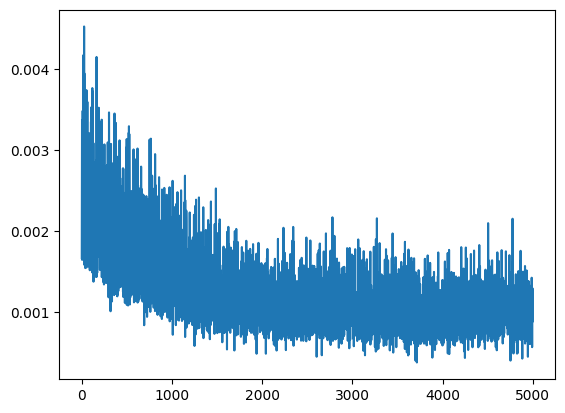

----------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1| Train Loss: 0.3776504


 10%|█         | 1/10 [00:01<00:15,  1.78s/it]

Epoch: 1| Validation error: 0.4007560
Epoch: 2| Train Loss: 0.3566508


 20%|██        | 2/10 [00:03<00:13,  1.66s/it]

Epoch: 2| Validation error: 0.4165949
Epoch: 3| Train Loss: 0.3541987


 30%|███       | 3/10 [00:04<00:11,  1.63s/it]

Epoch: 3| Validation error: 0.3833810
Epoch: 4| Train Loss: 0.3429285


 40%|████      | 4/10 [00:06<00:09,  1.66s/it]

Epoch: 4| Validation error: 0.3801622
Epoch: 5| Train Loss: 0.3455338


 50%|█████     | 5/10 [00:08<00:08,  1.64s/it]

Epoch: 5| Validation error: 0.3719775
Epoch: 6| Train Loss: 0.3388936


 60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

Epoch: 6| Validation error: 0.3754261
Epoch: 7| Train Loss: 0.3422614


 70%|███████   | 7/10 [00:11<00:04,  1.66s/it]

Epoch: 7| Validation error: 0.3743457
Epoch: 8| Train Loss: 0.3318123


 80%|████████  | 8/10 [00:13<00:03,  1.65s/it]

Epoch: 8| Validation error: 0.3721135
Epoch: 9| Train Loss: 0.3358565


 90%|█████████ | 9/10 [00:14<00:01,  1.63s/it]

Epoch: 9| Validation error: 0.3702739
Epoch: 10| Train Loss: 0.3303086


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

Epoch: 10| Validation error: 0.3961337
Epoch:8| Best Train+Val Loss：0.3519629


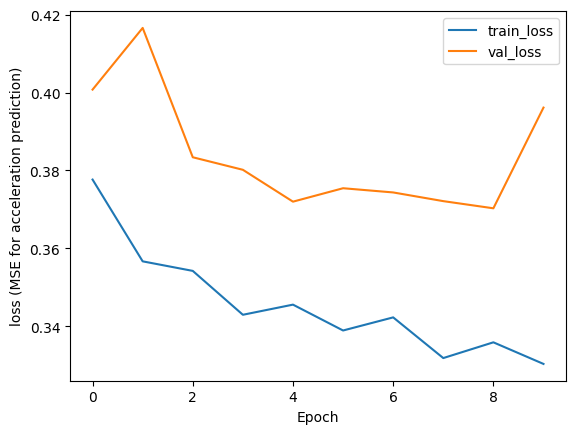

mean_test_error 34.05646586418152


289it [00:27, 10.39it/s]


count= 289 col= 1 rate 0.0034602076124567475 jerk 0.2959129 miniumu_ttc 21.869698
mean_test_error 33.8650560135533


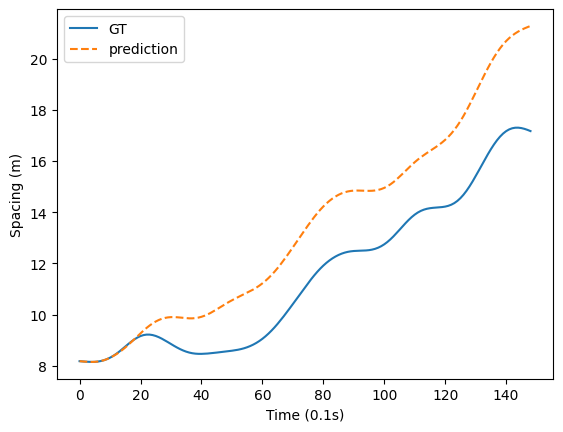

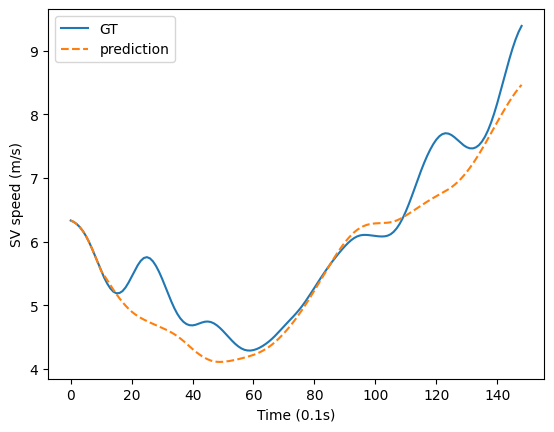

In [6]:
# MAML-跟车  version2   内循环使用adam
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial
import copy


# ACC_LIMIT = 3 # the limit of acceleration, this can be calibrated based on the data 加速度极限
# Ts = 0.04 # time interval for data sampling for HighD is 0.04 for other datasets are 0.1 数据采样时间间隔 15/375s
Ts = 0.1

# load data    加载包含Python对象的.npy或.npz文件，需要显式地设置allow_pickle参数为True
HighD_data = np.load('/kaggle/input/follow-car-datasets/data/HighD_car_fol_event_set_dhw.npy', allow_pickle=True)
NGSIM_data = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS1_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das1_car_fol_event_set.npy', allow_pickle=True)
SPMD_DAS2_data = np.load('/kaggle/input/follow-car-datasets/data/SPMD_das2_car_fol_event_set.npy', allow_pickle=True)
Waymo_data = np.load('/kaggle/input/follow-car-datasets/data/waymo_filter_carfo_info_150.npy', allow_pickle=True)
Lyft_data = np.load('/kaggle/input/lyft-data/Lyft_car_fol_event_set.npy', allow_pickle=True)
Lyft_test = np.load('/kaggle/input/follow-car-datasets/data/Lyft_test_data.npy', allow_pickle=True)
Lyft_train = np.load('/kaggle/input/follow-car-datasets/data/Lyft_train_data.npy', allow_pickle=True)
Lyft_val = np.load('/kaggle/input/follow-car-datasets/data/Lyft_val_data.npy', allow_pickle=True)
HighD_test = np.load('/kaggle/input/follow-car-datasets/data/HighD_test_data.npy', allow_pickle=True)
HighD_train = np.load('/kaggle/input/follow-car-datasets/data/HighD_train_data.npy', allow_pickle=True)
HighD_val = np.load('/kaggle/input/follow-car-datasets/data/HighD_val_data.npy', allow_pickle=True)
NGSIM_test = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_test_data.npy', allow_pickle=True)
NGSIM_train = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_train_data.npy', allow_pickle=True)
NGSIM_val = np.load('/kaggle/input/follow-car-datasets/data/NGSIM_I_80_val_data.npy', allow_pickle=True)
SPMD1_test = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_test_data.npy', allow_pickle=True)
SPMD1_train = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_train_data.npy', allow_pickle=True)
SPMD1_val = np.load('/kaggle/input/follow-car-datasets/data/SPMD1_val_data.npy', allow_pickle=True)
SPMD2_test = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_test_data.npy', allow_pickle=True)
SPMD2_train = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_train_data.npy', allow_pickle=True)
SPMD2_val = np.load('/kaggle/input/follow-car-datasets/data/SPMD2_val_data.npy', allow_pickle=True)
Waymo_test = np.load('/kaggle/input/follow-car-datasets/data/Waymo_test_data.npy', allow_pickle=True)
Waymo_train = np.load('/kaggle/input/follow-car-datasets/data/Waymo_train_data.npy', allow_pickle=True)
Waymo_val = np.load('/kaggle/input/follow-car-datasets/data/Waymo_val_data.npy', allow_pickle=True)
# 使用训练设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 任务数据集划分
def split_train(data,data_ratio):
#     np.random.seed(43)
    # 随机排列数据集的索引
    shuffled_indices=np.random.permutation(len(data))
    if data_ratio < 0:
        # 如果小于零，根据输入百分比计算获取数据集的数量
        data_size=int(len(data)*data_ratio)
        # 根据索引划分数据集
        data_indices =shuffled_indices[:data_size] # 测试 (1881)
    else:
        # 如果大于等于零，则data_ratio为获取数据集中的数量
        data_indices = shuffled_indices[:data_ratio]
    return data[data_indices]
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


# max_len = 375 # for HighD dataset is 375 for others are 150
max_len = 150
his_horizon = 10

# 将数据集划分成样本
class ImitationCarFolData(torch.utils.data.Dataset):
    """
    Dataset class for imitation learning (state -> action fitting) based car-following models.
    """
    def __init__(self, data, max_len = max_len):
        self.data = data
        self.max_len = max_len # Max length of a car following event.

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 获取数据集中指定索引的车辆跟驰事件
        event = self.data[idx]
        # 截取事件中的max_len个时间步数据
        sv = event[1][:self.max_len] # 后车速度
        lv = event[3][:self.max_len] # 前车速度
        spacing = event[0][:self.max_len] # 车距
        relSpeed = event[2][:self.max_len] # 相对速度
        # 构建输入数据，包括 spacing, sv, relSpeed，截取除最后一项的全部数据
        inputs = [spacing[:-1], sv[:-1], relSpeed[:-1]]
        # 计算加速度标签（当前速度减去上一个时间步的速度）
        acc_label = np.diff(sv) / Ts
        # 保存 lv 作为速度标签
        lv_spd = lv
        return {'inputs': inputs, 'label': acc_label, 'lv_spd': lv_spd}


# 定义模型
class nn_model(nn.Module):
    def __init__(self, input_size = 3):
        super(nn_model,self).__init__()
        self.net=nn.Sequential(OrderedDict([
            ('l1',nn.Linear(input_size,256)),
            ('relu1',nn.ReLU()),
            ('l2',nn.Linear(256,256)),
            ('relu2',nn.ReLU()),
            ('l3',nn.Linear(256,1))
        ]))
        self.state = list(self.net.parameters())
    # 用于元学习的内循环中更新权重的方法，用于计算元损失，然后重置下一个元任务的权重。
    def argforward(self,x,weights): 
        x=F.linear(x,weights[0],weights[1])  # (input,weight,bias)
        x=F.relu(x)
        x=F.linear(x,weights[2],weights[3])
        x=F.relu(x)
        x=F.linear(x,weights[4],weights[5])
        return x


# 元学习内循环训练过程
def inner_train(data_loader, net ,temp_weights, criterion):
    # 初始化变量
    train_loss_his = []  # 训练损失
    best_train_loss = None  # 最佳训练损失
    best_epoch = None  # 最佳验证损失时的轮次
    # 训练过程
    train_losses = []  # 记录每个epoch的训练损失
    net.train()
    # 遍历数据集
    for i, item in enumerate(data_loader):
        # x_data, y_data = item['inputs'].float().to(device), item['label'].float().to(device)
        # 获取输入数据及标签，input包括[距离，后车速度，相对速度]，label为加速度
        x_data, y_data = item['inputs'], item['label'] # x_data((20,149)，(20,149)，(20,149))  y_data(20,149)
        # Put T into the first dimension, B, T, d -> T, B, d
        # 将x_data中3个(20,149)连接，转换成(3,20,149)
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        # x->(149,20,3)，y->(149,20)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data
#         print(T,B,d)  # 149  20  3
        y_pre = torch.zeros(T - his_horizon, B).to(device) # 存储预测加速度 (139,20)
        y_label = y_data[his_horizon:] # 存储从his_horizon开始的真实加速度 (139,20)
        # 从历史数据时间步开始遍历
        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10, 20, 3)
            if model_type == 'nn':
                x = x.transpose(0,1).reshape(B, -1) # flatten for history data (20, 30)
            # 根据his_horizon个数据预测加速度
            acc_pre = net.argforward(x, temp_weights).squeeze() # (32)
            y_pre[frame - his_horizon] = acc_pre
        #计算损失并进行反传及优化
        loss = criterion(y_pre, y_label)
        return loss


# 生成不同数据集的任务类
class DataTask():
    def __init__(self,data_range):
        self.data_range = data_range
  # 生成任务数据，默认生成一个数据点，可以通过指定size参数生成多个数据点
    def sample_data(self,size=1):
        if self.data_range == 1:
            meta_data = HighD_data
            Ts = 0.04
            max_len = 375
#             print('--HighD--')
        elif self.data_range == 2:
            meta_data = Lyft_data
            Ts = 0.1
            max_len = 150
#             print('--Lyft---')
        elif self.data_range == 3:
            meta_data = SPMD_DAS1_data
            Ts = 0.1
            max_len = 150
#             print('SPMD_DAS1')
        elif self.data_range == 4:
            meta_data = SPMD_DAS2_data
            Ts = 0.1
            max_len = 150
#             print('SPMD_DAS2')
        elif self.data_range == 5:
            meta_data = Waymo_data
            Ts = 0.1
            max_len = 150
#             print('--Waymo--')
        meta_data_set = split_train(meta_data, size)
#         print(data_set[0].shape)
        dataset_loader = ImitationCarFolData(meta_data_set, max_len = max_len)
        return dataset_loader


# 任务分布，及选择不同的数据
class DataDistribution():
    def __init__(self, data_range=5, n=3):
        self.data_range = data_range    # 元数据集的数量
        self.n = n  # 每次获取数据集的数量
    # 随机生成一个跟车数据集
    def sample_task(self):
        # 从1到5中随机选择3个不重复的数
        data_choice = np.random.choice(self.data_range, size=self.n, replace=False) + 1
        return data_choice


# MAML元学习训练过程
class MAML():
    def __init__(self, net, alpha, beta, tasks, k):  # (net,alpha=0.01,beta=0.001,tasks=data_tasks,k=100)
        # 初始化 MAML 算法的元参数
        self.net = net  # 元学习使用的神经网络模型
        self.weights = list(net.parameters())  # 获取神经网络的参数
        self.alpha = alpha  # 内循环学习率
        self.beta = beta  # 外循环学习率
        self.tasks = tasks  # 正弦任务的分布
        self.k = k  # 内循环（任务采样）的数据集大小
        self.criterion = nn.MSELoss()  # 均方误差损失函数
        self.meta_optimiser = torch.optim.Adam(self.weights, self.beta)  # 外循环优化器（Adam）
        self.meta_losses = []  # 用于存储元学习的损失历史
        self.plot_every = 1  # 每隔多少次迭代记录一次损失，用于绘图
        self.print_every = 1  # 每隔多少次迭代输出一次损失信息，用于打印
        self.batch_size = self.k

    def inner_loop(self, task):
        # 内循环更新参数，用于计算元学习损失
#         temp_weights = [w.clone() for w in self.weights]  # 复制当前网络参数作为临时参数
#         temp_weights.requires_grad = True
        temp_weights = self.weights
        inner_optim = torch.optim.Adam(temp_weights, self.alpha)
        dataset_loader = task.sample_data(size=self.k)  # 从任务中采样数据集 D
        dataloader = DataLoader(
                dataset_loader,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=1,
                drop_last=False)
        # 训练过程  第一步
        loss = inner_train(dataloader, self.net, temp_weights, self.criterion) / self.k
        # 优化过程
        grads = torch.autograd.grad(loss, temp_weights)  # 计算损失对参数的梯度
        for w, g in zip(temp_weights, grads):
            w.grad = g
        inner_optim.step()
#         temp_weights = [w - self.alpha * g for w, g in zip(temp_weights, grads)]  # 临时参数更新 梯度下降
        # 第二步
        metaloss = inner_train(dataloader, self.net, temp_weights, self.criterion) / self.k
        return metaloss

    def outer_loop(self, num_epochs):  # epoch 5000
        total_loss = 0
        for epoch in tqdm(range(1, num_epochs + 1)):
            metaloss_sum = 0
            tasks = self.tasks.sample_task()  # 从任务分布中采样一个元任务
            for i in tasks:
                task = DataTask(i)
                metaloss = self.inner_loop(task)  # 内循环更新参数，计算元学习损失
                metaloss_sum += metaloss  # mete_loss求和
            metagrads = torch.autograd.grad(metaloss_sum, self.weights)  # 计算元学习损失对参数的梯度
            # 重要步骤：使用元学习梯度更新网络参数
            for w, g in zip(self.weights, metagrads):
                w.grad = g
            self.meta_optimiser.step()  # 使用外循环优化器更新网络参数
            total_loss += metaloss_sum.item() / len(tasks)
            if epoch % self.print_every == 0:
                print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.print_every))
            if epoch % self.plot_every == 0:
                self.meta_losses.append(total_loss / self.plot_every)
                total_loss = 0

dataset = 'NGSIM'
model_type = 'nn'
save = f'{model_type}_{dataset}.pt' # 保存模型文件
if model_type == 'nn':
    net = nn_model(input_size = his_horizon*3).to(device)
# elif model_type == 'lstm':
#     net = lstm_model(input_size = 3, lstm_layers = 1).to(device) # single layer lstm
data_tasks=DataDistribution(data_range=5, n=3)
maml=MAML(net,alpha=0.0001,beta=0.0001,tasks=data_tasks,k=150)


maml.outer_loop(num_epochs=5000)
plt.plot(maml.meta_losses)
plt.show()
print('----------------------')


# Train
Ts = 0.1
max_len = 150
og_net = maml.net.net
# 创建一个与原始网络结构相同的虚拟网络
if model_type == 'nn':
    dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(his_horizon*3,256)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(256,256)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(256,1))
    ]))
dummy_net=dummy_net.to(device)
# 加载原始网络的权重
dummy_net.load_state_dict(og_net.state_dict())
# 进行迭代，每次更新虚拟网络的参数
num_shots=10
lr = 0.01
loss_fn=nn.MSELoss()
optim=torch.optim.SGD
opt=optim(dummy_net.parameters(),lr=lr)


# 数据集划分
def split_data(data,data_ratio):
    if data_ratio < 0:
        # 如果小于零，根据输入百分比计算获取数据集的数量
        data_size=int(len(data)*data_ratio)
    else:
        # 如果大于等于零，则data_ratio为获取数据集中的数量
        data_size = data_ratio
    return data[:data_size]
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# 获取数据集的数量
K=40
dataset_train = split_data(NGSIM_train, K)
dataset_loader_train = ImitationCarFolData(dataset_train, max_len = max_len)
train_loader = DataLoader(
            dataset_loader_train,
            batch_size=10,
            shuffle=True,
            num_workers=1,
            drop_last=True)
dataset_val = NGSIM_val
dataset_loader_val = ImitationCarFolData(dataset_val, max_len = max_len)
val_loader = DataLoader(
            dataset_loader_val,
            batch_size=10,
            shuffle=True,
            num_workers=1,
            drop_last=True)
dataset_test = NGSIM_test
dataset_loader_test = ImitationCarFolData(dataset_test, max_len = max_len)
test_loader = DataLoader(
            dataset_loader_test,
            batch_size=10,
            shuffle=False,
            num_workers=1,
            drop_last=True)


# 初始化变量
train_loss_his = [] # 训练损失
test_error_his = [] # 测试误差
validation_error_his = [] # 验证误差
best_train_loss = None # 最佳训练损失
best_validation_loss = None # 最佳验证损失
best_epoch = None # 最佳验证损失时的轮次

# 训练过程
for epoch in tqdm(range(num_shots)):
    train_losses = [] # 记录每个epoch的训练损失
    validation_losses = [] # 记录每个epoch的验证损失
    jerk_val = 0
    dummy_net.train()
    # 遍历数据集
    for i, item in enumerate(train_loader):
        # x_data, y_data = item['inputs'].float().to(device), item['label'].float().to(device)
        # 获取输入数据及标签，input包括[距离，后车速度，相对速度]，label为加速度
        x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
        # Put T into the first dimension, B, T, d -> T, B, d
        # 将x_data中3个(32,374)连接，转换成(3,32,374)
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        # x->(374,32,3)，y->(374,32)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

        y_pre = torch.zeros(T - his_horizon, B).to(device) # 存储预测加速度 (364,32)
        y_label = y_data[his_horizon:] # 存储从his_horizon开始的真实加速度 (364,32)
        # 从历史数据时间步开始遍历
        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
            if model_type == 'nn':
                x = x.transpose(0,1).reshape(B, -1) # flatten for history data
            # 根据his_horizon个数据预测加速度
            acc_pre = dummy_net(x).squeeze() # (32)
            y_pre[frame - his_horizon] = acc_pre
        #计算损失并进行反传及优化
        loss = loss_fn(y_pre, y_label)
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dummy_net.parameters(), 0.25) # 对模型梯度进行裁剪，避免梯度爆炸
        opt.step()

        train_losses.append(loss.item())
    # 计算本轮平均损失
    train_loss = np.mean(train_losses)

    train_loss_his.append(train_loss)
    print("Epoch: {0}| Train Loss: {1:.7f}".format(epoch + 1, train_loss))

    # 验证过程
    dummy_net.eval()
    error_list = []
    for i, item in enumerate(val_loader):
        x_data, y_data = item['inputs'], item['label']
        # Put T into the first dimension, B, T, d -> T, B, d
        x_data = torch.stack(x_data)
        # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
        x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)
        # lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)
        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data
        # save a copy of x_data
        x_data_orig = x_data.clone().detach()
        y_label = y_data[his_horizon:]
        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
            if model_type == 'nn':
              x = x.transpose(0,1).reshape(B, -1) # flatten for history data
            acc_pre = dummy_net(x).squeeze()
            y_pre[frame - his_horizon] = acc_pre
        validation_loss = loss_fn(y_pre, y_label)
        # jerk_val = np.mean(np.abs(np.diff(torch.tensor(y_pre))/Ts))/batch_size
        # print("Val jerk：", jerk_val)
        opt.zero_grad()
        torch.nn.utils.clip_grad_norm_(dummy_net.parameters(), 0.25)
        opt.step()
        validation_losses.append(validation_loss.item())
    # 计算平均验证误差
    mean_validation_error = np.mean(validation_losses)
    train_val_error = (mean_validation_error + train_loss)/2
    if best_validation_loss is None or best_validation_loss > train_val_error:
        best_epoch = epoch + 1
        best_validation_loss = train_val_error
        # save the best model
    with open(save, 'wb') as f:
        torch.save(dummy_net, f)

    validation_error_his.append(mean_validation_error)
    print("Epoch: {0}| Validation error: {1:.7f}".format(epoch + 1, mean_validation_error))

# print(list(dummy_net.parameters()))
print("Epoch:{0}| Best Train+Val Loss：{1:.7f}".format(best_epoch, best_validation_loss))
plt.plot(train_loss_his, label = 'train_loss')
plt.plot(validation_error_his, label = 'val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss (MSE for acceleration prediction)')
plt.show()


# Testing, closed-loop prediction
# Load the best model saved
model = dummy_net
with open(f'{save}', 'rb') as f:
    model = torch.load(f).to(device)
model.eval()


error_list = []

for i, item in enumerate(test_loader):
    x_data, y_data = item['inputs'], item['label'] # x_data((32,374)，(32,374)，(32,374))  y_data(32,374)
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data) # (3,32,374)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device) # x(374,32,3)  y(374,32)
    # 获取前车速度
    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1) # (375,32)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach() # (374,32,3)

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d) (10,32,3)
        if model_type == 'nn':
            x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze() # (32,1)

        # update next data
        # 根据前一次计算得到的值，计算后面的值
        if frame < T-1:
            # 根据当前速度和加速度计算下一时间速度
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts # (32)
            # 计算下一时间速度的相对速度
            delta_v_ = lv_spd[frame + 1] - sv_spd_ # (32)
            # 该时刻真实相对速度
            delta_v = x_data[frame, :, -1] # (32)
            # 通过两车车距加上相对位移得到下一时间段车距 ？
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2 # (32)

            # update 根据计算得到的值，更新下一时间的值
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data

    # Calculating spacing error for the closed-loop simulation
    # 预测的车距
    spacing_pre = x_data[..., 0] # (374,32)
    # 真实的车距
    spacing_obs = x_data_orig[..., 0] # (374,32)

    error = loss_fn(spacing_pre, spacing_obs).item()
    error_list.append(error)
model.train()
# 计算MSE - 间距均方误差（Mean square error of spacing）
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)


# plot for one event
event_no = 2
plt.plot(spacing_obs[:, event_no].cpu().detach().numpy(), label = 'GT')
plt.plot(spacing_pre[:, event_no].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('Spacing (m)')

# speed part
plt.figure()
plt.plot(x_data_orig[:, event_no, 1].cpu().detach().numpy(), label = 'GT')
plt.plot(x_data[:, event_no, 1].cpu().detach().numpy(), '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('SV speed (m/s)')


# Updated for the four key elvaluation metrics.  Note that: The loss design in FollowNet is for the reduction of the mse of spacing.
# Please note that The TTC results presented in the table of the paper indicate the average TTC value calculated.
# However, a drawback of this approach is that if the relative velocity in just one frame is extremely small, it will result in a significantly large computed TTC when reproducing paper.
# To address this issue, it may be beneficial to consider plotting the distribution of TTC as a way to present the results.
# 间距均方误差（Mean square error of spacing (MSE))
# 碰撞率（Collision rate）
# 驾驶舒适度指标(颠簸)（Driving comfort metric (jerk)）
# 碰撞时间(TTC)指标（Time-To-Collision (TTC) metric）
# for test
# 创建测试集 DataLoader
# Ts = 0.1
# max_len = 150
dataset_test = NGSIM_test
dataset_loader_test = ImitationCarFolData(dataset_test, max_len = max_len)
test_loader = DataLoader(
            dataset_loader_test,
            batch_size=1,
            shuffle=False,
            num_workers=1,
            drop_last=True)
# 记录跟车事件数和发生碰撞事件数
count = 0
col = 0
jerk_set = []
# TTC_set = []
minimum_ttc_set = []
model.eval()
# ttc = [1, 2, 3, 4, 5, 6, 7, 8, -1, -3, 7]
def calculate_safety(ttc):
    # Remove any negative values (assuming TTC cannot be negative)
    # ttc = [x for x in ttc if x >= 0]
    # 计算ttc中最小值
    minimum_ttc = min(ttc)
    # 计算ttc中第1百分位的值
    first_percentile_ttc = np.percentile(ttc, 1)
    # print(1111)
    return minimum_ttc, first_percentile_ttc

# # Example usage
# minimum_ttc, first_percentile_ttc = calculate_safety(ttc)
# print("Minimum TTC:", minimum_ttc)
# print("1st Percentile TTC:", first_percentile_ttc)

for i, item in tqdm(enumerate(test_loader)):

    # jerk
    # jerk = np.diff(sv)/Ts
    acc_single = []
    TTC_single = []

    count += 1
    x_data, y_data = item['inputs'], item['label']
    # Put T into the first dimension, B, T, d -> T, B, d
    x_data = torch.stack(x_data)
    # x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
    x_data, y_data = x_data.transpose(0, 2).float().to(device), y_data.transpose(0, 1).float().to(device)

    lv_spd = item['lv_spd'].float().to(device).transpose(0, 1)

    T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

    # save a copy of x_data
    x_data_orig = x_data.clone().detach()

    for frame in range(his_horizon, T):
        x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
        if model_type == 'nn':
          x = x.transpose(0,1).reshape(B, -1) # flatten for history data

        acc_pre = model(x).squeeze()

        acc_single.append(acc_pre)

        # update next data
        if frame < T-1:
            sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts
            # print(sv_spd_)
            # MyDevice = torch.device('cuda:0')
            # 速度取值大于0.001的
            sv_spd_ = torch.tensor(np.maximum(np.array(sv_spd_.detach().cpu()),0.001), device=device)
            delta_v_ = lv_spd[frame + 1] - sv_spd_
            delta_v = x_data[frame, :, -1]
            spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2

            spacing = np.array(spacing_.cpu())
            # 如果spacing<=0，表示发生碰撞
            if float(np.array(spacing_.cpu())) <= 0:
                col += 1
                break
            next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
            x_data[frame + 1] = next_frame_data
        # 计算TTC
        TTC_single.append(-spacing_ / delta_v_) # 正常情况(139)
    # Mean absolute jerk
    jerk =np.mean(np.abs(np.diff(torch.tensor(acc_single))/Ts))

    # if np.sum(torch.tensor(TTC_single).cuda().cpu().numpy()>0) == 0:
    #     continue
    TTC_single = torch.tensor(TTC_single).to(device).cpu().numpy()
    TTC_single = [x for x in TTC_single if x >= 0]
    if len(TTC_single) > 0:
        minimum_ttc, _ = calculate_safety(TTC_single)
        minimum_ttc_set.append(minimum_ttc)  # 大小为测试数据总数减去发生了碰撞的事件

    # Calculating spacing error for the closed-loop simulation
    # 预测车距
    spacing_pre = x_data[..., 0]
    # 真实车距
    spacing_obs = x_data_orig[..., 0]

    # plt.plot(np.array(spacing_obs.cpu()), label = 'GT')
    # plt.plot(np.array(spacing_pre.cpu()), '--', label = 'Prediction')
    # plt.legend()
    # plt.xlabel(f'Time ({Ts}s)');
    # plt.ylabel('Spacing (m)');
    # plt.show()
    error = loss_fn(spacing_pre[:(frame+1)], spacing_obs[:(frame+1)]).item()
    error_list.append(error)

    jerk_set.append(jerk)
# 输出指标
print("count=",count,"col=",col,"rate",col/count,"jerk", np.mean(jerk_set), "miniumu_ttc", np.mean(minimum_ttc_set))
model.train()
mean_test_error = np.mean(error_list)
print('mean_test_error',mean_test_error)